# 此處利用Tensorflow提供之CNN教學code做簡易demo

此demo利用Tensorflow內建之資料集 ─ MNIST，作為我們的訓練以及驗證資料集，MNIST為一機器學習初學者常見之數據集，內容為0~9之手寫阿拉伯數字，目標是利用訓練資料集來讓機器分辨0~9的數字。

## 載入所需 package

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf
import time

tf.logging.set_verbosity(tf.logging.INFO)

## 設計CNN網路架構

這裡我們設計了一個簡單的CNN網路架構，其架構如下： (括號內為code中代碼名稱)
    1. Convolutional Layer 1 (conv1):
        參數設定為：filters = 32、kernel_size = 5x5、padding = same(output與input同維度)、activation function使用ReLU
    2. Pooling Layer 1 (pool1):
        參數設定為：pool_size = 2x2、strides = 2(每次矩陣移動的距離)
    3. Convolutional Layer 2 (conv2):
        參數設定為：filters = 64、kernel_size = 5x5、padding = same、activation function使用ReLU
    4. Pooling Layer 2 (pool2):
        參數設定為：pool_size = 2x2、strides = 2
    5. Full Connected Layer (dense)：
        參數設定為：units = 1024 (該層有1024個神經元)、activation function使用ReLU
    6. Dropout (dropout)：
        參數設定為：rate = 0.4 (每次隨機抽取四成神經元捨去)、training=mode == tf.estimator.ModeKeys.TRAIN (唯有在train時啟動dropout)
    7. Full Connected Layer (logit)：
        參數設定為：units = 10 (為輸出層，需與欲分類類別數相同)
    8. Predict (predictions)
    8-1. Argmax (tf.argmax)：
        將logit中，得分最高的類別令為預測的結果
    8-2. Softmax (tf.nn.softmax)：
        將logit經過softmax函數處理後得到各類別預測可能百分比
        
    9. Optimizer：SGD (tf.train.GradientDescentOptimizer)
        參數設定為：learning_rate = 0.001

In [3]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## 建構main (運行主體)
分為數個部分
    1. Load training and eval data:
        讀取資料 (MNIST)
    2. Create the Estimator:
        estimator為tensorflow其中一種型態，用以將上述建立之model整合，並應用於之後會使用的模型訓練, 模型評測以及結論
    3. Set up logging for predictions:
        由於CNN需要跑一陣子，我們設定一個logging來在CNN訓練時監測他的訓練狀況
        tensors_to_log為我們想要監測的tensors，此處我們設定為softmax tensor，即，各筆資料可能的分類百分比
    4. Train the model:
        訓練模型，參數設定為：batch_size = 100 (每次投入100筆資料進入我的model進行訓練)，num_epochs = None (不限制我的訓練次數)
    5. Evaluate the model and print results:
        評測模型，將testing data帶入訓練好的模型中，此處num_epochs = 1用意為每一筆testing data都需看過。
        並將結果print出來

In [4]:
def main(unused_argv):
  # Load training and eval data
  start_time = time.time()
  mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  train_data = mnist.train.images  # Returns np.array
  train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
  eval_data = mnist.test.images  # Returns np.array
  eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

  # Create the Estimator
  mnist_classifier = tf.estimator.Estimator(
      model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

  # Set up logging for predictions
  # Log the values in the "Softmax" tensor with label "probabilities"
  tensors_to_log = {"probabilities": "softmax_tensor"}
  logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)

  # Train the model
  train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)
  mnist_classifier.train(
      input_fn=train_input_fn,
      steps=20000,
      hooks=[logging_hook])

  # Evaluate the model and print results
  eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
  eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
  print(eval_results)

## 開始訓練並產出結果
這邊使用的是 GPU 進行訓練，為了瞭解 GPU 以及 CPU 間運算速度的差異，我們在此先將 GPU 總運行時間記錄下來 (gpu_time)

In [20]:
start_time = time.time()
if __name__ == "__main__":
  tf.app.run()
end_time = time.time() - start_time

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_convnet_model', '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_is_chief': True, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_evaluation_master': '', '_service': None, '_master': '', '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_num_worker_replicas': 1, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000281E2C9ACC0>, '_task_id': 0, '_save_checkpoints_secs': 600, '_global_id_in_cluster': 0, '_distribute': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph w

INFO:tensorflow:step = 100001, loss = 0.015688902
INFO:tensorflow:probabilities = [[0.00000001 0.00000009 0.00000019 0.00000008 0.99993837 0.00000149
  0.00000002 0.00000038 0.00000018 0.00005928]
 [0.9998971  0.00000026 0.00006148 0.00000002 0.00000005 0.00000862
  0.00001448 0.00001232 0.00000452 0.00000127]
 [0.00002233 0.00000002 0.00000124 0.00704714 0.00000169 0.9179677
  0.06456248 0.00000567 0.01019072 0.00020115]
 [0.         0.         0.00000001 0.99996984 0.         0.
  0.         0.         0.0000302  0.00000004]
 [0.0000001  0.0000007  0.00000052 0.00000812 0.00001846 0.00003898
  0.00000005 0.00006656 0.00000192 0.9998646 ]
 [0.         0.00000001 0.         0.00000724 0.00001024 0.000059
  0.         0.00013058 0.00006755 0.9997254 ]
 [0.00000011 0.00000008 0.00002732 0.00006078 0.00000134 0.00040932
  0.00009019 0.00000002 0.9994049  0.00000597]
 [0.00007413 0.9958682  0.00052775 0.00002479 0.00032815 0.00000559
  0.00001473 0.00205224 0.00079766 0.00030686]
 [0.00000

INFO:tensorflow:global_step/sec: 120.842
INFO:tensorflow:probabilities = [[0.00000361 0.92743576 0.00056751 0.00012402 0.00160715 0.00000286
  0.00000114 0.00391492 0.066342   0.00000094]
 [0.00004936 0.00012975 0.00320847 0.00000006 0.00156456 0.00070466
  0.9941942  0.00000091 0.00013844 0.00000957]
 [0.00058442 0.00000005 0.00002488 0.00000498 0.00061353 0.00000583
  0.0002266  0.00015631 0.49222955 0.5061538 ]
 [0.00000366 0.9987068  0.00000916 0.00000123 0.00002131 0.00000012
  0.00000034 0.00124304 0.00000775 0.0000065 ]
 [0.00000229 0.00006607 0.0000096  0.00005221 0.00001605 0.00000148
  0.00000001 0.9965377  0.00000789 0.0033068 ]
 [0.         0.00000001 0.00000008 0.99999535 0.         0.00000174
  0.         0.         0.00000011 0.00000264]
 [0.00000267 0.         0.         0.         0.         0.0000001
  0.99999464 0.         0.00000262 0.        ]
 [0.00000001 0.00000026 0.00000059 0.         0.99999833 0.
  0.00000019 0.00000064 0.         0.        ]
 [0.         0.0

INFO:tensorflow:step = 100101, loss = 0.043851417 (0.828 sec)
INFO:tensorflow:probabilities = [[0.9925857  0.00002962 0.00046033 0.00009369 0.00000199 0.00485923
  0.00092652 0.00005111 0.00042142 0.00057036]
 [0.00000046 0.00001442 0.00000137 0.00000145 0.9960989  0.00000129
  0.0000081  0.00029452 0.00001281 0.00356672]
 [0.         0.         0.         0.00000002 0.         0.
  0.         0.9999976  0.         0.00000233]
 [0.00000015 0.0000007  0.00026926 0.00008273 0.00001358 0.00008001
  0.00000238 0.0000001  0.99954623 0.00000489]
 [0.00000003 0.00000119 0.00000001 0.00000007 0.99967563 0.00000022
  0.00000025 0.00001479 0.00001894 0.00028888]
 [0.         0.00000053 0.00000596 0.9954129  0.         0.00000938
  0.         0.0000007  0.00456831 0.00000221]
 [0.00000003 0.00000001 0.00000002 0.00000001 0.0000006  0.00000087
  0.9999981  0.00000002 0.00000034 0.00000001]
 [0.00000219 0.00276572 0.9883001  0.00699984 0.00000101 0.00000116
  0.00000177 0.00130376 0.00062049 0.0000

INFO:tensorflow:global_step/sec: 147.577
INFO:tensorflow:probabilities = [[0.99979514 0.00000002 0.00004155 0.         0.00000001 0.00001788
  0.00004329 0.00000845 0.00000055 0.00009304]
 [0.         0.         0.         0.00003651 0.00000001 0.99995816
  0.00000187 0.         0.0000006  0.00000282]
 [0.00016417 0.00001269 0.00001254 0.00000339 0.00000007 0.9745702
  0.00312258 0.00147098 0.02064127 0.00000208]
 [0.00037247 0.00000021 0.00000622 0.00002351 0.00111298 0.00000025
  0.00000393 0.00008381 0.00368253 0.9947141 ]
 [0.00000068 0.         0.00000001 0.00000014 0.00000002 0.00000001
  0.         0.999928   0.00000006 0.000071  ]
 [0.0000034  0.00000024 0.00010003 0.00000534 0.00000421 0.00000038
  0.00000041 0.00000121 0.9998516  0.00003317]
 [0.0000072  0.00000117 0.00003862 0.00000006 0.00006003 0.00005837
  0.9998318  0.00000001 0.00000276 0.00000002]
 [0.00000427 0.00000051 0.00000993 0.9929917  0.00000001 0.00677934
  0.         0.00000043 0.00011763 0.00009607]
 [0.0000

INFO:tensorflow:step = 100201, loss = 0.02756872 (0.678 sec)
INFO:tensorflow:probabilities = [[0.00001494 0.00000048 0.00000123 0.00000438 0.00000001 0.99940455
  0.00008557 0.00000027 0.00048844 0.00000013]
 [0.         0.         0.         0.00000011 0.         0.99999964
  0.         0.         0.         0.00000028]
 [0.00009144 0.00000018 0.00000999 0.00000113 0.00015843 0.00000253
  0.00001039 0.00150691 0.0000039  0.9982151 ]
 [0.         0.00000001 0.         0.         0.9999597  0.
  0.         0.00000026 0.00004    0.00000003]
 [0.00000512 0.00006009 0.00000013 0.00006711 0.00003101 0.0000505
  0.00000001 0.29583862 0.00000912 0.7039383 ]
 [0.00000013 0.00071404 0.9986136  0.00018332 0.00000052 0.00000432
  0.         0.00047951 0.00000461 0.00000004]
 [0.00000002 0.00000011 0.00024472 0.00040574 0.00000109 0.
  0.         0.997612   0.00000067 0.00173562]
 [0.00000064 0.99997723 0.00000003 0.00000001 0.00000054 0.00000002
  0.00000021 0.00001641 0.00000489 0.00000016]
 [0.

INFO:tensorflow:global_step/sec: 146.496
INFO:tensorflow:probabilities = [[0.00000006 0.         0.00000006 0.         0.00000004 0.99751955
  0.00247832 0.         0.00000158 0.00000048]
 [0.0001683  0.00006174 0.00014558 0.00024077 0.01034012 0.00004063
  0.00001014 0.00229077 0.00042999 0.986272  ]
 [0.00000052 0.00000043 0.000023   0.00002289 0.00000004 0.00000092
  0.00000289 0.00000013 0.9999471  0.00000216]
 [0.         0.         0.         0.00000007 0.         0.99999845
  0.00000097 0.         0.00000046 0.00000002]
 [0.         0.00000002 0.00000001 0.99999416 0.         0.00000022
  0.         0.         0.00000549 0.00000006]
 [0.00000002 0.         0.00000001 0.00000003 0.00000022 0.00000179
  0.99998677 0.         0.0000112  0.        ]
 [0.         0.00000055 0.00000001 0.         0.9999697  0.
  0.00000004 0.00001105 0.00000007 0.00001847]
 [0.00000518 0.00001442 0.70678604 0.25990906 0.0000549  0.00023245
  0.00000243 0.00012408 0.02902935 0.00384195]
 [0.         0.

INFO:tensorflow:step = 100301, loss = 0.076281235 (0.685 sec)
INFO:tensorflow:probabilities = [[0.9999862  0.00000007 0.00001211 0.00000001 0.00000003 0.00000003
  0.00000067 0.0000003  0.00000033 0.00000025]
 [0.00000007 0.00000003 0.00000038 0.         0.00006219 0.00000105
  0.99993634 0.00000002 0.00000001 0.        ]
 [0.         0.         0.         0.00001531 0.         0.99996257
  0.00000001 0.00000146 0.00002078 0.00000002]
 [0.02775846 0.00000137 0.00106586 0.00015398 0.00169619 0.00460585
  0.0000982  0.0458008  0.89452714 0.02429225]
 [0.00000008 0.         0.00000001 0.         0.00008963 0.
  0.99991024 0.         0.         0.        ]
 [0.         0.         0.00012455 0.99970275 0.         0.00000003
  0.         0.00001372 0.00015829 0.00000068]
 [0.         0.         0.00000012 0.9999895  0.         0.00000097
  0.         0.         0.00000923 0.0000002 ]
 [0.         0.         0.00000009 0.00000014 0.00000001 0.
  0.         0.99999857 0.         0.00000118]
 [

INFO:tensorflow:global_step/sec: 144.383
INFO:tensorflow:probabilities = [[0.00000001 0.00002414 0.9999745  0.         0.00000046 0.00000002
  0.00000023 0.00000022 0.00000033 0.        ]
 [0.00019812 0.0000019  0.99968195 0.00000644 0.00000004 0.00000003
  0.         0.0000929  0.00000274 0.00001591]
 [0.00011568 0.00000262 0.00039341 0.00021207 0.00000023 0.00014971
  0.99902225 0.00000027 0.00008262 0.00002108]
 [0.00000026 0.99959654 0.00000702 0.00000933 0.00008138 0.00000197
  0.00001737 0.0000067  0.00027712 0.00000221]
 [0.00000332 0.0004657  0.00169879 0.00015486 0.9938525  0.00004111
  0.00007719 0.00310336 0.00057793 0.0000252 ]
 [0.00000007 0.00007402 0.00000139 0.0000342  0.9977477  0.00000219
  0.0000001  0.00001955 0.00001535 0.00210546]
 [0.00000056 0.00000056 0.99984777 0.00005558 0.00000002 0.00000003
  0.0000001  0.00000789 0.0000876  0.00000002]
 [0.00000001 0.00008645 0.00000019 0.00000001 0.9994561  0.00000027
  0.00000006 0.00000949 0.00000012 0.00044742]
 [0.000

INFO:tensorflow:step = 100401, loss = 0.009270823 (0.691 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.0000648  0.         0.9997019
  0.         0.00000004 0.00000022 0.00023298]
 [0.00000002 0.00000002 0.00000868 0.0000196  0.00000303 0.00000051
  0.00000013 0.00000005 0.99996746 0.00000048]
 [0.         0.         0.         0.         0.9999995  0.
  0.         0.00000017 0.00000001 0.00000041]
 [0.00000001 0.00022046 0.99971527 0.00005806 0.         0.
  0.         0.0000061  0.00000007 0.        ]
 [0.         0.00000001 0.00000005 0.00002036 0.         0.
  0.         0.9999782  0.00000002 0.00000146]
 [0.9969547  0.00000296 0.0013073  0.00000161 0.00000133 0.00007441
  0.00004165 0.00002729 0.00000142 0.00158736]
 [0.00000007 0.00000012 0.00000641 0.00000001 0.9999912  0.
  0.00000005 0.00000182 0.         0.00000045]
 [0.9999329  0.00000007 0.00001151 0.00000292 0.00000001 0.00001347
  0.00002632 0.00000012 0.00001209 0.00000049]
 [0.00000032 0.0000

INFO:tensorflow:global_step/sec: 146.927
INFO:tensorflow:probabilities = [[0.         0.         0.00000029 0.0007099  0.00000017 0.00009122
  0.00000018 0.00000002 0.9991912  0.00000704]
 [0.00000701 0.00000003 0.00000016 0.00000001 0.00020965 0.00000121
  0.99978155 0.         0.00000032 0.00000001]
 [0.000011   0.00000171 0.99996066 0.00000033 0.00000453 0.00000032
  0.00001814 0.00000055 0.00000265 0.        ]
 [0.00000028 0.0000088  0.9992478  0.00000165 0.00000076 0.00000003
  0.         0.00072286 0.00001778 0.0000003 ]
 [0.00000003 0.00001637 0.00000036 0.00000034 0.99769694 0.00000113
  0.0000004  0.00027474 0.00000632 0.00200351]
 [0.00000615 0.0023593  0.00029289 0.00045491 0.98146516 0.00000157
  0.00000161 0.01073485 0.0004102  0.00427336]
 [0.00000001 0.00000009 0.99999774 0.00000186 0.00000005 0.00000001
  0.         0.00000008 0.00000007 0.00000005]
 [0.9999964  0.         0.00000001 0.         0.00000001 0.
  0.00000001 0.00000158 0.00000003 0.00000204]
 [0.00000035 0.

INFO:tensorflow:step = 100501, loss = 0.034506872 (0.682 sec)
INFO:tensorflow:probabilities = [[0.00000036 0.00000005 0.00000033 0.00002221 0.00000426 0.9998172
  0.00004974 0.000003   0.00009026 0.00001277]
 [0.00453084 0.00519394 0.00268477 0.00699876 0.16375396 0.02138995
  0.73716486 0.05144967 0.00307138 0.00376191]
 [0.         0.         0.         0.00000545 0.         0.99999404
  0.         0.         0.00000009 0.00000039]
 [0.0000001  0.00000099 0.00000593 0.00009937 0.00000002 0.00000936
  0.00000001 0.0000011  0.999881   0.00000203]
 [0.00000831 0.00003866 0.00033698 0.00003463 0.85472834 0.00001982
  0.00000864 0.00124323 0.00003635 0.14354517]
 [0.00009369 0.5010686  0.49490568 0.00358433 0.00000015 0.00000086
  0.00000001 0.00032014 0.00000058 0.00002593]
 [0.00000001 0.00000044 0.00000004 0.00000001 0.99932575 0.00000001
  0.00000003 0.00000038 0.0000008  0.0006726 ]
 [0.         0.00025549 0.00000113 0.00001154 0.00241438 0.00002543
  0.00000001 0.0000193  0.00013702

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.99999523 0.         0.00000011 0.         0.         0.
  0.0000028  0.00000005 0.         0.00000192]
 [0.00000001 0.00016244 0.9949713  0.00015434 0.00000114 0.00000017
  0.00000011 0.00466619 0.00004425 0.00000005]
 [0.00000024 0.00025775 0.00121821 0.0008825  0.0000017  0.00000061
  0.00000036 0.00001535 0.9973699  0.00025338]
 [0.00000004 0.00000282 0.00008415 0.00002992 0.         0.
  0.         0.9998641  0.00000053 0.00001846]
 [0.00000012 0.00000227 0.00000157 0.00003258 0.00000713 0.00881742
  0.00000195 0.00019637 0.9909251  0.00001548]
 [0.00000018 0.00000347 0.0002514  0.00034679 0.00067259 0.00000038
  0.00000009 0.9973679  0.00000482 0.00135235]
 [0.00000002 0.00000008 0.00000001 0.0000423  0.00000001 0.9989563
  0.         0.00000043 0.00000357 0.00099725]
 [0.00000236 0.00000005 0.00008041 0.9966428  0.00000001 0.00003782
  0.00000182 0.00000518 0.00319593 0.00003367]
 [0.00000008 0.         

INFO:tensorflow:step = 100601, loss = 0.017111523 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00000515 0.00000063 0.0001651  0.9726648  0.00000009 0.00000667
  0.         0.000315   0.00067594 0.02616647]
 [0.00000002 0.00001699 0.00001303 0.00003773 0.00000021 0.00000002
  0.         0.9999255  0.0000003  0.00000617]
 [0.         0.         0.         0.999998   0.         0.00000019
  0.         0.         0.00000001 0.00000181]
 [0.00000012 0.00000003 0.00167991 0.000132   0.         0.00000116
  0.00000481 0.         0.99818194 0.00000003]
 [0.00000008 0.00000001 0.0000006  0.00063034 0.         0.9922765
  0.0070741  0.         0.00001822 0.00000008]
 [0.98458093 0.00000022 0.00483929 0.00000149 0.00000056 0.00005671
  0.01048038 0.00000047 0.00003692 0.00000283]
 [0.00000509 0.00000106 0.00000069 0.00007911 0.00001539 0.00000199
  0.00000001 0.00000013 0.9986211  0.00127544]
 [0.0024585  0.00001138 0.99190617 0.00197416 0.00000036 0.00011583
  0.00000032 0.00053828 0.00018373

INFO:tensorflow:global_step/sec: 148.014
INFO:tensorflow:probabilities = [[0.00000013 0.         0.00006363 0.00000321 0.         0.00000053
  0.00000001 0.         0.9999316  0.00000101]
 [0.         0.         0.00000001 0.9999995  0.         0.00000014
  0.         0.         0.00000021 0.00000013]
 [0.00000075 0.9994685  0.00000273 0.00007946 0.00010432 0.00000015
  0.0000012  0.00017179 0.00015416 0.00001696]
 [0.00000049 0.00000001 0.00000021 0.00000002 0.         0.00005649
  0.9983032  0.         0.00163955 0.00000002]
 [0.00000027 0.00000001 0.00000049 0.0061267  0.         0.99177647
  0.00000001 0.00000116 0.00000724 0.00208774]
 [0.9994962  0.00000001 0.00048395 0.         0.00000159 0.
  0.00000078 0.00000886 0.00000165 0.00000693]
 [0.00000966 0.9300614  0.00093454 0.06231852 0.00000004 0.00653113
  0.00000012 0.00002797 0.00011157 0.00000526]
 [0.00000849 0.99191535 0.00000115 0.00001005 0.00075409 0.00000166
  0.0000011  0.00585001 0.00023405 0.00122419]
 [0.00000101 0.

INFO:tensorflow:step = 100701, loss = 0.0089011965 (0.677 sec)
INFO:tensorflow:probabilities = [[0.00000036 0.00000001 0.00000004 0.00066731 0.         0.9991773
  0.00000099 0.00000002 0.00015245 0.0000016 ]
 [0.00000005 0.00000001 0.00000414 0.00000003 0.         0.00000003
  0.00000139 0.         0.9999944  0.        ]
 [0.         0.         0.         0.00026613 0.         0.9997286
  0.         0.00000004 0.00000204 0.0000032 ]
 [0.00000003 0.00001089 0.00000032 0.00000063 0.99994993 0.0000004
  0.00000172 0.00002113 0.00000699 0.00000802]
 [0.00000009 0.00000394 0.00000021 0.00059017 0.00089789 0.00000468
  0.00000003 0.00030139 0.00000405 0.9981976 ]
 [0.00000069 0.00000012 0.00000002 0.0000158  0.0000002  0.00000002
  0.         0.999566   0.00000157 0.00041566]
 [0.00000939 0.00000582 0.00000871 0.0002577  0.00000233 0.99891806
  0.00055687 0.0000094  0.00022845 0.00000338]
 [0.         0.00000022 0.00000002 0.00000001 0.9998721  0.00000218
  0.00000045 0.00001389 0.00000002 

INFO:tensorflow:global_step/sec: 140.333
INFO:tensorflow:probabilities = [[0.00000072 0.00000031 0.         0.00000278 0.         0.9999101
  0.00008529 0.00000001 0.00000041 0.00000033]
 [0.00000004 0.99994075 0.00000036 0.00000007 0.00000716 0.
  0.00000013 0.00003565 0.00001001 0.00000581]
 [0.00000076 0.99979526 0.00000268 0.00001163 0.00000987 0.00000001
  0.00000005 0.00001495 0.00016442 0.00000044]
 [0.         0.         0.         0.00000055 0.         0.99998355
  0.00000001 0.         0.00000642 0.00000946]
 [0.99447834 0.00000128 0.00018361 0.0000013  0.00067587 0.00003505
  0.0025891  0.00001229 0.00000941 0.00201364]
 [0.00000009 0.00000081 0.00002769 0.00002728 0.00000001 0.
  0.         0.99993014 0.00001072 0.00000321]
 [0.00000445 0.99847096 0.00005827 0.00000975 0.00010912 0.0000003
  0.00000304 0.00101191 0.00030937 0.0000227 ]
 [0.         0.         0.00000203 0.9996271  0.         0.00000053
  0.         0.00000002 0.00037025 0.00000015]
 [0.99969566 0.00000012 0

INFO:tensorflow:step = 100801, loss = 0.034385525 (0.712 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000004 0.00000746 0.00046479 0.00000977
  0.         0.00020247 0.00036158 0.9989538 ]
 [0.00006377 0.00000128 0.00011751 0.00000905 0.00002665 0.00069677
  0.9990778  0.00000007 0.00000676 0.0000002 ]
 [0.00000049 0.00000504 0.999889   0.00001524 0.00003572 0.00000053
  0.00000044 0.00000009 0.00003874 0.00001472]
 [0.         0.00000008 0.00000011 0.99999976 0.         0.00000002
  0.         0.         0.         0.        ]
 [0.00000217 0.00002614 0.00000051 0.00000112 0.00020337 0.00001646
  0.00000001 0.00018523 0.00002079 0.9995442 ]
 [0.00000145 0.00003107 0.00000107 0.95149505 0.00000002 0.04399714
  0.00000304 0.00000002 0.00067527 0.00379594]
 [0.         0.00000005 0.99996805 0.00002585 0.         0.
  0.         0.         0.00000612 0.        ]
 [0.00001023 0.00000001 0.00001401 0.00000021 0.00029164 0.00000017
  0.00000195 0.00008977 0.0013683  0.9982

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000001 0.00000099 0.00000001 0.00003815 0.00016587 0.00000475
  0.         0.00341065 0.0000023  0.9963773 ]
 [0.9999962  0.         0.00000346 0.00000002 0.         0.0000001
  0.00000003 0.00000018 0.         0.00000015]
 [0.00098879 0.9284623  0.00041871 0.00808602 0.04483455 0.00005464
  0.00005895 0.0148553  0.00008339 0.00215713]
 [0.00000076 0.00000003 0.0000002  0.         0.999841   0.
  0.0000041  0.00000007 0.00000001 0.00015384]
 [0.00000007 0.00000253 0.0000055  0.00048995 0.         0.00000001
  0.         0.99949455 0.00000107 0.00000632]
 [0.00000001 0.00000022 0.         0.00000003 0.99993813 0.
  0.00000022 0.00000091 0.00000001 0.00006041]
 [0.00000018 0.00000115 0.00082083 0.00223416 0.00000237 0.00000035
  0.         0.00034611 0.99639773 0.00019711]
 [0.00000122 0.00000235 0.00000193 0.00000925 0.00009798 0.00001223
  0.         0.999785   0.00001137 0.0000787 ]
 [0.         0.00000001 

INFO:tensorflow:step = 100901, loss = 0.047331784 (0.668 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000052 0.00000841 0.00000001
  0.         0.00000358 0.00000052 0.999987  ]
 [0.00000611 0.9997316  0.00000242 0.0000001  0.00006294 0.
  0.00000032 0.00015563 0.00004081 0.00000011]
 [0.00002535 0.00000008 0.00008012 0.00004375 0.00025816 0.00000116
  0.00000213 0.0000487  0.00009761 0.9994429 ]
 [0.00000019 0.00000818 0.00001744 0.00025009 0.00000009 0.
  0.         0.9997008  0.00000059 0.00002269]
 [0.00000068 0.         0.         0.         0.00000021 0.00000002
  0.99999905 0.         0.00000001 0.        ]
 [0.0001196  0.0003836  0.00001591 0.00004433 0.00000386 0.01576685
  0.9835632  0.0000261  0.00007565 0.00000082]
 [0.00008163 0.00000032 0.00001017 0.00000078 0.00000492 0.00000576
  0.9998939  0.00000001 0.00000244 0.00000013]
 [0.00000024 0.00001924 0.9981781  0.00166296 0.00000001 0.00000031
  0.00006537 0.         0.00007377 0.        ]
 [

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00449152 0.00001675 0.9878165  0.00315127 0.00000966 0.00041965
  0.00000137 0.00016452 0.0006634  0.00326515]
 [0.00169837 0.00000009 0.00508525 0.00019697 0.03159493 0.00043657
  0.00003985 0.00043924 0.01454734 0.9459614 ]
 [0.00001166 0.00000077 0.00003694 0.00000043 0.000061   0.00010845
  0.9997795  0.00000008 0.00000097 0.00000012]
 [0.         0.         0.00000257 0.99999595 0.         0.00000134
  0.00000001 0.         0.00000009 0.        ]
 [0.9998388  0.00000002 0.00015538 0.         0.00000006 0.00000002
  0.00000015 0.0000044  0.00000001 0.00000105]
 [0.00000003 0.         0.00032181 0.00002792 0.         0.
  0.         0.9996489  0.00000025 0.00000104]
 [0.00003666 0.00000041 0.00026704 0.00000647 0.00000156 0.00000142
  0.00000005 0.00012699 0.99947864 0.00008074]
 [0.         0.00000001 0.00000006 0.         0.9999994  0.
  0.00000006 0.00000047 0.         0.00000005]
 [0.00000004 0.00000032

INFO:tensorflow:step = 101001, loss = 0.02818003 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.00000009 0.00000002 0.         0.00000167 0.00000006
  0.         0.99986863 0.         0.00012939]
 [0.9981705  0.00010409 0.00146769 0.00000075 0.00001442 0.00000275
  0.00006847 0.0001537  0.00000574 0.00001202]
 [0.00000059 0.0000814  0.00003374 0.00000754 0.00000014 0.0000021
  0.00000031 0.00000111 0.9998667  0.00000636]
 [0.00000065 0.00000022 0.9997626  0.00000251 0.         0.
  0.         0.00023409 0.         0.        ]
 [0.00000228 0.00000008 0.00000017 0.         0.00000453 0.0000342
  0.99995255 0.         0.00000367 0.00000247]
 [0.         0.0007169  0.9977774  0.00146081 0.00000002 0.00000001
  0.         0.00004477 0.00000021 0.00000005]
 [0.9995435  0.00000001 0.00000005 0.         0.00000041 0.00000125
  0.00045415 0.00000073 0.         0.00000001]
 [0.00004782 0.00063571 0.00016083 0.00000573 0.00001238 0.00001958
  0.00000263 0.00000427 0.9990074  0.0001036

INFO:tensorflow:global_step/sec: 148.013
INFO:tensorflow:probabilities = [[0.         0.         0.         0.9999945  0.         0.00000293
  0.         0.         0.00000243 0.0000001 ]
 [0.00000312 0.00000045 0.0000399  0.01018989 0.0000047  0.00161277
  0.00000249 0.00005171 0.9878428  0.00025209]
 [0.         0.         0.         0.99999404 0.         0.00000576
  0.         0.         0.00000014 0.00000007]
 [0.00000178 0.00005814 0.93812484 0.00017346 0.00000036 0.
  0.00000001 0.06129254 0.0003467  0.00000225]
 [0.         0.         0.         0.00000068 0.00000166 0.00000025
  0.         0.00033232 0.0000009  0.9996642 ]
 [0.         0.         0.00000002 0.9998035  0.         0.00005901
  0.         0.         0.00000037 0.00013716]
 [0.         0.00000016 0.0000007  0.00000155 0.00051564 0.00000242
  0.         0.00017132 0.00000012 0.9993081 ]
 [0.         0.         0.00000115 0.00000075 0.         0.
  0.         0.9999914  0.00000003 0.00000673]
 [0.00000005 0.00000132

INFO:tensorflow:step = 101101, loss = 0.029581837 (0.676 sec)
INFO:tensorflow:probabilities = [[0.00000115 0.00007073 0.00002465 0.5748392  0.00011881 0.05105468
  0.00000031 0.00000056 0.00316244 0.37072754]
 [0.00000007 0.00000227 0.00000248 0.00096286 0.00046369 0.00000012
  0.         0.00083176 0.00000092 0.99773586]
 [0.00000003 0.00000093 0.9999889  0.00000381 0.00000086 0.00000043
  0.00000057 0.00000123 0.00000319 0.00000006]
 [0.00010872 0.94537824 0.03397945 0.00237314 0.00469032 0.0000099
  0.0021473  0.00030316 0.01097524 0.00003438]
 [0.         0.         0.         0.00000003 0.00015738 0.
  0.         0.00000166 0.00000013 0.99984074]
 [0.         0.         0.         0.00000113 0.         0.9999989
  0.         0.         0.00000002 0.00000001]
 [0.99996376 0.00000001 0.00003202 0.00000175 0.         0.00000057
  0.00000008 0.00000005 0.         0.00000164]
 [0.         0.         0.00000001 0.00000844 0.00000927 0.00000023
  0.         0.00030561 0.00000023 0.999676

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000002 0.00000004 0.00000261 0.00000035 0.0000059  0.00000121
  0.0000001  0.00000063 0.9999788  0.00001031]
 [0.00000998 0.05206943 0.78680027 0.05242244 0.00000304 0.00000145
  0.00000549 0.10649854 0.00218245 0.00000696]
 [0.00000037 0.00000138 0.00000007 0.         0.9999198  0.00000004
  0.00000022 0.00000057 0.         0.00007762]
 [0.         0.         0.         0.00000097 0.         0.9999982
  0.         0.         0.00000081 0.00000001]
 [0.0000005  0.99993026 0.00000073 0.00000263 0.00000586 0.00000096
  0.00001691 0.00003055 0.0000078  0.00000399]
 [0.         0.00000001 0.         0.         1.         0.
  0.         0.00000005 0.         0.        ]
 [0.         0.00000002 0.00000009 0.99992895 0.         0.00006214
  0.         0.00000005 0.00000632 0.00000246]
 [0.         0.00000009 0.00000001 0.9996424  0.00000001 0.00030466
  0.         0.         0.00004186 0.00001096]
 [0.00000001 0.0

INFO:tensorflow:step = 101201, loss = 0.019584352 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000103 0.         0.00000479 0.00000001 0.00000425 0.00000012
  0.99998975 0.         0.00000002 0.        ]
 [0.00000047 0.00000004 0.00000261 0.00000934 0.00070346 0.00000085
  0.00000008 0.00009553 0.00003937 0.99914825]
 [0.00000001 0.         0.00001783 0.00000691 0.         0.00000071
  0.00000016 0.         0.99997437 0.00000001]
 [0.00000734 0.00000004 0.00007136 0.00262423 0.00000022 0.00070526
  0.00002247 0.00000033 0.99615896 0.00040976]
 [0.         0.         0.00000015 0.99999547 0.         0.00000026
  0.         0.00000001 0.00000417 0.00000004]
 [0.00000903 0.00000001 0.00029851 0.00000183 0.         0.00000011
  0.         0.9984068  0.00000219 0.00128163]
 [0.00000439 0.00000615 0.9999665  0.00000295 0.00000008 0.00000004
  0.         0.00000643 0.00001343 0.00000003]
 [0.99986804 0.0000003  0.00012365 0.00000011 0.0000001  0.00000008
  0.00000609 0.00000032 0.0000006

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.         0.         0.00000004 0.0000021  0.00000998 0.00000013
  0.         0.00000123 0.00000022 0.9999863 ]
 [0.00000223 0.99995244 0.00000223 0.00000011 0.00000273 0.00000066
  0.00001217 0.0000131  0.00001387 0.00000054]
 [0.         0.         0.00000074 0.00000606 0.00000041 0.00000446
  0.         0.00000005 0.9999865  0.00000177]
 [0.00000332 0.00004207 0.00002625 0.9101964  0.00003554 0.00246325
  0.00000032 0.0692826  0.00082927 0.01712082]
 [0.00000004 0.00002898 0.00000073 0.9103165  0.00000066 0.00005761
  0.         0.08890845 0.00001853 0.00066846]
 [0.00001774 0.00000034 0.00004024 0.00212828 0.00000021 0.00000794
  0.00000646 0.00000389 0.99700963 0.00078521]
 [0.00000294 0.9995528  0.00000838 0.00000002 0.00009321 0.00000001
  0.00000434 0.000003   0.00033508 0.00000039]
 [0.00000048 0.00000233 0.00156637 0.00000059 0.99840647 0.00000468
  0.0000019  0.00000421 0.00000006 0.00001305]
 [0.741

INFO:tensorflow:step = 101301, loss = 0.047145434 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00033748 0.00000416 0.00002567 0.00005976 0.010575   0.00003168
  0.00001133 0.00156363 0.00218821 0.9852031 ]
 [0.         0.00000001 0.00000001 0.         0.99999917 0.
  0.         0.00000038 0.         0.0000005 ]
 [0.9999969  0.         0.0000007  0.         0.         0.00000128
  0.00000073 0.00000003 0.         0.00000032]
 [0.98672557 0.0000017  0.00019718 0.00000035 0.00000372 0.0006854
  0.01210317 0.00025268 0.00002899 0.00000126]
 [0.00000026 0.9998846  0.0000008  0.00000034 0.00000216 0.00000017
  0.00001033 0.00000712 0.0000937  0.00000044]
 [0.00000479 0.00155653 0.00002837 0.00239979 0.00142598 0.00046918
  0.00000538 0.0022362  0.00245331 0.9894204 ]
 [0.00000014 0.00000011 0.00000484 0.00004248 0.00000009 0.97824657
  0.00000013 0.00000042 0.01278139 0.00892377]
 [0.00000302 0.00000459 0.00000388 0.00000046 0.00004587 0.00012515
  0.9997476  0.00000107 0.00006842 0.00000

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.         0.         0.         0.9999763  0.         0.00002345
  0.         0.         0.         0.00000022]
 [0.         0.         0.         0.00000007 0.         0.9999999
  0.         0.         0.         0.00000005]
 [0.9999815  0.00000002 0.00001436 0.         0.         0.00000022
  0.00000218 0.00000072 0.00000001 0.00000095]
 [0.00001456 0.         0.0000028  0.00000635 0.         0.00014915
  0.00001133 0.         0.9998085  0.00000738]
 [0.00000029 0.         0.00000012 0.00006103 0.00000003 0.99959785
  0.00000171 0.00000007 0.00024973 0.00008913]
 [0.00000041 0.0000019  0.00000053 0.00000833 0.0041999  0.00000344
  0.00000004 0.00043234 0.00001317 0.99534   ]
 [0.99995184 0.00000002 0.00003705 0.         0.00000001 0.00000001
  0.00001097 0.00000002 0.00000005 0.00000017]
 [0.00001576 0.98424596 0.00008167 0.00012131 0.00020658 0.00018877
  0.00008691 0.00000858 0.01474071 0.00030378]
 [0.0000

INFO:tensorflow:step = 101401, loss = 0.015081693 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00000011 0.00004321 0.9999552  0.00000103 0.         0.
  0.         0.00000018 0.00000018 0.00000019]
 [0.9998425  0.00000023 0.00012729 0.0000002  0.00000014 0.
  0.00000035 0.00000156 0.00002755 0.00000014]
 [0.00000004 0.         0.00000831 0.000027   0.         0.00000002
  0.00000008 0.0000001  0.9999633  0.00000114]
 [0.00000007 0.00000033 0.00000415 0.9985366  0.         0.00127015
  0.         0.00000005 0.00014127 0.00004754]
 [0.         0.00004157 0.9936799  0.00622943 0.         0.00000001
  0.         0.00000017 0.00004888 0.        ]
 [0.         0.00000001 0.00000149 0.00080535 0.00000035 0.00000687
  0.00000244 0.00000016 0.9991819  0.00000145]
 [0.         0.         0.00000043 0.9998066  0.         0.00000689
  0.         0.00018553 0.00000033 0.00000013]
 [0.00003499 0.00000001 0.00000039 0.00000163 0.00000071 0.00013862
  0.9998148  0.         0.00000886 0.00000003]
 [

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000051 0.00000145 0.00000044 0.00003369 0.0034232  0.00000024
  0.00000003 0.00002454 0.00000952 0.9965064 ]
 [0.00000001 0.         0.00000301 0.00000079 0.00008417 0.00000003
  0.         0.00009431 0.0000028  0.9998149 ]
 [0.00000005 0.00000481 0.00000592 0.00000026 0.99996877 0.00000255
  0.00000412 0.00000118 0.00000005 0.00001233]
 [0.00001345 0.00000037 0.00000095 0.00016169 0.00000011 0.99352795
  0.00577659 0.00000079 0.00051672 0.00000134]
 [0.00242791 0.9013949  0.00012397 0.0000051  0.00001281 0.00077139
  0.05644232 0.00010414 0.03869423 0.00002318]
 [0.00001806 0.00035891 0.98910904 0.00070695 0.00000004 0.00000026
  0.00000002 0.00980028 0.00000594 0.00000062]
 [0.99850935 0.00000039 0.00001757 0.00000121 0.         0.00142886
  0.00000002 0.00000162 0.00000001 0.00004099]
 [0.00000004 0.0000001  0.00000568 0.00001093 0.00019319 0.00000077
  0.         0.00020306 0.9995159  0.0000703 ]
 [0.000

INFO:tensorflow:step = 101501, loss = 0.0829067 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00000035 0.00000266 0.00000029 0.00085068 0.00000007
  0.         0.9991209  0.00000054 0.00002443]
 [0.00000001 0.00000001 0.00000546 0.00001206 0.00000001 0.
  0.         0.99998116 0.00000013 0.00000123]
 [0.00000001 0.00000001 0.00000005 0.00000075 0.00008547 0.00000028
  0.         0.00001005 0.00000051 0.99990284]
 [0.         0.00000001 0.00000021 0.00034857 0.         0.9996319
  0.0000149  0.         0.00000438 0.00000001]
 [0.00000564 0.00000003 0.00000036 0.00000092 0.00000188 0.00017066
  0.99944776 0.         0.00037232 0.00000042]
 [0.00000804 0.9998547  0.00001468 0.00000007 0.0000059  0.00000127
  0.00000426 0.00004544 0.0000654  0.0000001 ]
 [0.         0.         0.00000014 0.00000507 0.00000002 0.00000001
  0.         0.99990916 0.         0.00008562]
 [0.00006068 0.00000322 0.00032392 0.00000562 0.00138403 0.00000069
  0.0000015  0.9981659  0.00002139 0.0000331

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00743474 0.00011636 0.01297118 0.0011442  0.00476904 0.00011097
  0.00056134 0.75170106 0.00045862 0.22073247]
 [0.00000442 0.00003138 0.00008012 0.00051382 0.0023475  0.07073709
  0.0001639  0.000167   0.00109637 0.9248584 ]
 [0.00000403 0.00027888 0.00013112 0.0065299  0.00000035 0.00000673
  0.00000002 0.9929374  0.00002205 0.00008966]
 [0.00000005 0.00000002 0.00000106 0.9792644  0.         0.00009409
  0.         0.00000017 0.000004   0.02063623]
 [0.0000001  0.9999521  0.00000022 0.00000131 0.00000607 0.00000005
  0.00000012 0.00000566 0.00003313 0.00000135]
 [0.00000104 0.00000132 0.00490574 0.9911965  0.00000106 0.00003088
  0.00000409 0.0038473  0.00001198 0.00000008]
 [0.00000006 0.00000005 0.00000049 0.00000001 0.00000045 0.00050195
  0.9994734  0.         0.0000236  0.        ]
 [0.00000036 0.9935377  0.00099287 0.00000266 0.00021287 0.
  0.0000224  0.0052049  0.00002256 0.00000373]
 [0.         0.

INFO:tensorflow:step = 101601, loss = 0.02809415 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00000734 0.00000293 0.00001746 0.00000133 0.9739197  0.00000933
  0.00000065 0.00063301 0.00000006 0.02540822]
 [0.         0.00000001 0.00000066 0.99998677 0.         0.00000558
  0.         0.00000001 0.00000043 0.00000639]
 [0.00000305 0.00000001 0.00000069 0.00012322 0.00058823 0.00079186
  0.00000002 0.00002439 0.00000747 0.9984611 ]
 [0.00000006 0.9997242  0.0000048  0.00000267 0.00001509 0.00000027
  0.00000056 0.0000228  0.0002291  0.00000063]
 [0.0000105  0.9999287  0.00000779 0.00000005 0.00001411 0.00000024
  0.00000828 0.00001441 0.00001509 0.00000091]
 [0.9993253  0.00001888 0.00009748 0.00003432 0.00000833 0.00005036
  0.00030823 0.00002305 0.00002132 0.00011279]
 [0.         0.         0.00000132 0.9998282  0.         0.00000061
  0.         0.00000006 0.00009001 0.00007979]
 [0.00001697 0.9993476  0.0000147  0.0000161  0.00022338 0.00000073
  0.00001978 0.00014884 0.00021183

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.00000086 0.00001118 0.0000181  0.00035831 0.00000025 0.9979297
  0.00148189 0.00000217 0.00017994 0.00001766]
 [0.00000004 0.         0.0000001  0.00020191 0.00000092 0.00356257
  0.00000002 0.00053347 0.0011288  0.9945722 ]
 [0.         0.         0.9999988  0.00000007 0.00000001 0.
  0.         0.         0.00000104 0.        ]
 [0.         0.         0.         0.99986565 0.         0.00013433
  0.         0.         0.00000003 0.00000003]
 [0.00000088 0.00000063 0.0000294  0.00748151 0.00000111 0.00619581
  0.00000893 0.00005102 0.98227924 0.00395149]
 [0.         0.         0.00000021 0.00000407 0.00004153 0.00000086
  0.         0.00002206 0.00001841 0.99991286]
 [0.         0.00000218 0.00000152 0.00001268 0.9801584  0.00001089
  0.         0.00001704 0.00000286 0.01979459]
 [0.         0.00000008 0.         0.00000124 0.         0.9999982
  0.         0.00000001 0.00000052 0.        ]
 [0.         0.  

INFO:tensorflow:step = 101701, loss = 0.064010516 (0.674 sec)
INFO:tensorflow:probabilities = [[0.0000001  0.00000002 0.00000002 0.         0.00000004 0.0000003
  0.9999994  0.         0.00000008 0.        ]
 [0.         0.         0.00000011 0.00000025 0.         0.00000014
  0.00000021 0.         0.9999989  0.00000039]
 [0.999984   0.00000009 0.00001129 0.         0.00000001 0.
  0.00000358 0.00000083 0.00000004 0.00000015]
 [0.         0.         0.99998856 0.00001139 0.         0.
  0.         0.00000005 0.00000006 0.        ]
 [0.00000052 0.00000049 0.0000052  0.00000024 0.00000011 0.00000031
  0.9999918  0.00000007 0.00000121 0.00000002]
 [0.00000326 0.00000014 0.01413188 0.00094613 0.00000002 0.00000026
  0.00000047 0.00000013 0.9849163  0.00000139]
 [0.         0.         0.         0.00060891 0.         0.9993411
  0.00000005 0.00000001 0.00000829 0.00004168]
 [0.00000365 0.00000137 0.00000093 0.00000001 0.9998716  0.00000009
  0.00000501 0.00000376 0.00000045 0.00011303]
 [0.

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.0011608  0.00003047 0.00275633 0.00041476 0.8758002  0.00000096
  0.01792472 0.00240745 0.09836391 0.00114038]
 [0.99968886 0.0000158  0.00000554 0.00000004 0.00000034 0.00000395
  0.00000046 0.00024351 0.00000895 0.00003251]
 [0.         0.00026415 0.9997359  0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.         0.00000043 0.9999993  0.00000026 0.         0.
  0.         0.00000006 0.         0.        ]
 [0.00000016 0.00000003 0.00000053 0.92725426 0.00000018 0.07253112
  0.00000019 0.00007049 0.0001117  0.00003119]
 [0.00001435 0.00000001 0.00012529 0.00192219 0.00000068 0.0000027
  0.00000521 0.0000006  0.9971796  0.00074943]
 [0.99999976 0.         0.00000014 0.         0.         0.
  0.00000001 0.00000001 0.         0.0000001 ]
 [0.00000002 0.00000001 0.00000017 0.00000002 0.00000072 0.00001281
  0.9999863  0.         0.00000001 0.        ]
 [0.00000003 0.00000001 0.000000

INFO:tensorflow:step = 101801, loss = 0.01680407 (0.667 sec)
INFO:tensorflow:probabilities = [[0.00001242 0.00000073 0.00000003 0.         0.00000026 0.00000719
  0.99997866 0.         0.00000016 0.00000058]
 [0.         0.00000606 0.9999893  0.00000008 0.00000001 0.
  0.         0.00000439 0.0000001  0.        ]
 [0.981281   0.00024845 0.00293895 0.00007786 0.00032743 0.0000633
  0.01454052 0.00004653 0.00047367 0.00000218]
 [0.00000081 0.0000134  0.00102018 0.00000261 0.00004959 0.00149761
  0.00084724 0.00031851 0.9760055  0.02024457]
 [0.         0.         0.         0.00000001 0.         0.9999994
  0.         0.         0.         0.00000063]
 [0.         0.         0.         0.         0.00000006 0.9998907
  0.00000213 0.0000033  0.00010217 0.00000149]
 [0.00000005 0.9999939  0.00000015 0.         0.00000059 0.
  0.00000095 0.0000006  0.00000368 0.00000009]
 [0.         0.         0.         0.00000001 0.         0.99999726
  0.00000002 0.         0.00000205 0.00000076]
 [0.00

INFO:tensorflow:global_step/sec: 150.011
INFO:tensorflow:probabilities = [[0.9999771  0.00000001 0.00001116 0.         0.         0.00000363
  0.00000675 0.00000075 0.00000003 0.00000061]
 [0.         0.00049005 0.999463   0.00004243 0.00000103 0.
  0.         0.00000158 0.00000186 0.        ]
 [0.99999535 0.         0.0000001  0.         0.         0.00000073
  0.00000006 0.00000161 0.         0.00000201]
 [0.0000626  0.00000904 0.00020403 0.0004908  0.00000323 0.9965481
  0.0001856  0.00017121 0.00231721 0.00000822]
 [0.00320884 0.02340227 0.00009448 0.6742553  0.04090092 0.0149891
  0.08757749 0.00087163 0.14146681 0.01323323]
 [0.00000022 0.00000039 0.00000001 0.00000017 0.00000013 0.00000001
  0.         0.99998796 0.00000002 0.00001109]
 [0.00000555 0.00000198 0.00186508 0.00011548 0.00000001 0.00000087
  0.00000006 0.00000436 0.9979113  0.00009528]
 [0.00066281 0.9965726  0.00016875 0.00000983 0.00066765 0.00000096
  0.00003748 0.00095351 0.00086254 0.00006404]
 [0.         0.00

INFO:tensorflow:step = 101901, loss = 0.057760343 (0.668 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.9999989  0.         0.
  0.         0.00000001 0.         0.00000104]
 [0.00000018 0.         0.00000638 0.00000576 0.00000001 0.00000001
  0.         0.99984026 0.00000001 0.00014735]
 [0.00000486 0.00000022 0.00000021 0.00000008 0.00053267 0.00000591
  0.9994561  0.00000001 0.00000001 0.00000002]
 [0.         0.00000002 0.00000032 0.         0.9999994  0.
  0.00000024 0.         0.         0.        ]
 [0.99999607 0.00000012 0.00000322 0.00000001 0.00000001 0.00000003
  0.00000064 0.00000001 0.00000006 0.00000004]
 [0.961971   0.00003834 0.00759449 0.00003997 0.00027455 0.00020172
  0.00028838 0.00915442 0.00256043 0.01787657]
 [0.9999356  0.00000067 0.00005947 0.00000004 0.00000001 0.00000047
  0.00000069 0.00000184 0.00000002 0.00000123]
 [0.         0.         0.00004622 0.00001029 0.00000013 0.00000016
  0.00000026 0.00000034 0.9999423  0.00000019]
 [

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.9838305  0.00000028 0.01583578 0.00000754 0.00000944 0.00000042
  0.00016294 0.00000071 0.00013067 0.00002184]
 [0.00000001 0.00026094 0.99892837 0.00010529 0.00000031 0.00000008
  0.00000014 0.00000243 0.00070245 0.00000001]
 [0.         0.00002058 0.9999732  0.00000342 0.00000001 0.
  0.         0.00000094 0.00000179 0.        ]
 [0.00000006 0.00000001 0.00000004 0.01130001 0.         0.9886592
  0.00000001 0.         0.00001128 0.00002932]
 [0.00000464 0.9842084  0.0009102  0.00001678 0.00329915 0.00269999
  0.00090501 0.00000047 0.00789545 0.00005968]
 [0.         0.00000005 0.00000039 0.00000183 0.00000001 0.00000013
  0.00000278 0.00000014 0.99999464 0.00000003]
 [0.0000001  0.00000002 0.00000216 0.00000015 0.00000001 0.
  0.         0.9999937  0.         0.00000395]
 [0.         0.         0.00000001 0.00000247 0.00025219 0.00000003
  0.         0.00001519 0.00000093 0.9997292 ]
 [0.00000249 0.0000002  

INFO:tensorflow:step = 102001, loss = 0.02025405 (0.670 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000027 0.99998736 0.         0.00000001
  0.         0.00000001 0.00000555 0.0000068 ]
 [0.         0.         0.         0.         0.         0.9999999
  0.         0.         0.00000007 0.        ]
 [0.00013696 0.00000008 0.00000006 0.00000003 0.0000022  0.00000154
  0.9998386  0.         0.00002049 0.        ]
 [0.00000052 0.00000062 0.9995759  0.00002996 0.00000015 0.00000001
  0.         0.00038898 0.00000396 0.00000001]
 [0.00000043 0.00000017 0.00009184 0.00005311 0.         0.01019538
  0.00000008 0.00001595 0.98685384 0.00278919]
 [0.00000008 0.00003476 0.9995223  0.00018668 0.00000945 0.0000016
  0.00000001 0.00002146 0.00022233 0.00000143]
 [0.00000035 0.         0.9999926  0.00000019 0.00000656 0.00000002
  0.00000002 0.00000002 0.00000007 0.00000008]
 [0.00000028 0.00000012 0.00000033 0.00007484 0.0065984  0.00028847
  0.00000001 0.00799536 0.00038024 0

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.9999678  0.00000002 0.00000111 0.00000205 0.         0.00001865
  0.         0.00000635 0.00000207 0.00000214]
 [0.9999937  0.         0.00000627 0.         0.         0.
  0.00000001 0.         0.         0.        ]
 [0.         0.00000001 0.         0.         1.         0.
  0.         0.         0.00000001 0.00000002]
 [0.00000002 0.00000394 0.9984976  0.00115281 0.00009694 0.00000058
  0.00000001 0.00000019 0.00024736 0.00000058]
 [0.9998771  0.00000052 0.00006208 0.0000216  0.00000008 0.00002246
  0.00000203 0.00000598 0.00000223 0.00000593]
 [0.         0.         0.         0.         0.9999994  0.
  0.00000002 0.00000061 0.         0.        ]
 [0.00000336 0.99993455 0.00000202 0.00000088 0.00000991 0.
  0.00000055 0.00004738 0.00000116 0.00000013]
 [0.0000001  0.00000008 0.00000018 0.00000018 0.9995431  0.00000121
  0.00000003 0.00001326 0.00000098 0.00044111]
 [0.00000008 0.00000022 0.00000025 0.  

INFO:tensorflow:step = 102101, loss = 0.002194863 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000251 0.         0.00000001 0.00000008 0.         0.00150554
  0.99848926 0.         0.00000258 0.00000001]
 [0.         0.         0.00000048 0.00001565 0.00028492 0.0000186
  0.         0.0006483  0.00143085 0.9976012 ]
 [0.00000094 0.00000008 0.00005499 0.00000065 0.00000258 0.00035727
  0.99958223 0.         0.00000135 0.        ]
 [0.00000193 0.00000006 0.00001237 0.00001182 0.00041674 0.00000521
  0.00000009 0.00004016 0.00004723 0.99946445]
 [0.         0.00000006 0.00000019 0.00000305 0.00000001 0.
  0.         0.9999962  0.00000001 0.00000052]
 [0.         0.         0.00000001 0.99999547 0.         0.00000376
  0.         0.         0.00000069 0.00000001]
 [0.00000132 0.00006511 0.00039279 0.00383303 0.00005485 0.00000003
  0.         0.99542254 0.00001591 0.00021444]
 [0.00003077 0.00002078 0.00000503 0.20697787 0.00006158 0.7893495
  0.001793   0.0000004  0.00175525 0.000005

INFO:tensorflow:global_step/sec: 149.563
INFO:tensorflow:probabilities = [[0.         0.00001067 0.99980515 0.00010213 0.         0.00000001
  0.         0.00007984 0.00000209 0.00000001]
 [0.00000001 0.00000002 0.         0.00002805 0.00000222 0.00000022
  0.         0.00001429 0.00000053 0.9999547 ]
 [0.00000004 0.00000001 0.00000001 0.01485847 0.00000003 0.9815363
  0.         0.00001511 0.00061696 0.00297303]
 [0.0000002  0.         0.00000002 0.00000557 0.         0.9994603
  0.00000004 0.00000142 0.00003637 0.00049611]
 [0.         0.00000009 0.9998944  0.00009517 0.00000021 0.00000001
  0.         0.0000026  0.00000747 0.00000006]
 [0.         0.         0.         0.00003021 0.00000399 0.00000256
  0.         0.00003098 0.00000378 0.9999285 ]
 [0.00006425 0.00073302 0.0232708  0.09589252 0.00000304 0.00200377
  0.00000017 0.86515135 0.01282946 0.00005156]
 [0.00000224 0.         0.00000926 0.00041767 0.00000276 0.9306314
  0.00000455 0.00000043 0.02514814 0.04378358]
 [0.000001

INFO:tensorflow:step = 102201, loss = 0.042279672 (0.669 sec)
INFO:tensorflow:probabilities = [[0.9999428  0.00000022 0.00003694 0.00000064 0.00000007 0.00000054
  0.00001437 0.00000029 0.00000197 0.0000022 ]
 [0.00000034 0.         0.         0.00000001 0.00000001 0.00000207
  0.9999975  0.         0.00000007 0.        ]
 [0.03666149 0.00113778 0.69801044 0.00014624 0.00298805 0.00000086
  0.00002767 0.24917279 0.01131666 0.00053791]
 [0.00000916 0.00000001 0.00000003 0.00004431 0.00000001 0.00004576
  0.         0.9872793  0.         0.01262152]
 [0.00000035 0.99975544 0.00000014 0.00000005 0.00006246 0.00000069
  0.00000013 0.00017077 0.00000985 0.00000017]
 [0.9999343  0.         0.00000161 0.00000012 0.00000018 0.00000006
  0.00005003 0.00000013 0.00001246 0.00000081]
 [0.00000175 0.0000001  0.9993906  0.00003464 0.         0.
  0.         0.00000793 0.00056488 0.        ]
 [0.9999827  0.         0.00000005 0.         0.         0.00000386
  0.00000324 0.         0.         0.0000

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.         0.0000001  0.         0.00000004 0.9996037  0.0000005
  0.         0.00000068 0.00000039 0.00039468]
 [0.00007705 0.00000014 0.9992812  0.00006461 0.00000584 0.00000022
  0.00000007 0.00040411 0.00014571 0.00002114]
 [0.00000001 0.0000007  0.         0.         0.9999976  0.
  0.00000003 0.00000001 0.00000032 0.00000129]
 [0.0000006  0.99972457 0.00003646 0.00000016 0.00009637 0.00000001
  0.00000005 0.00008275 0.00005895 0.00000006]
 [0.00000016 0.00000115 0.00000002 0.00363095 0.         0.99508
  0.00000009 0.00000031 0.00013472 0.0011525 ]
 [0.         0.         0.00000101 0.999992   0.         0.00000541
  0.         0.00000004 0.00000002 0.00000172]
 [0.         0.00000024 0.00000002 0.00000674 0.00000002 0.
  0.         0.99998426 0.         0.00000866]
 [0.9999999  0.         0.00000001 0.         0.         0.
  0.         0.00000005 0.         0.0000001 ]
 [0.         0.         0.00017617 

INFO:tensorflow:step = 102301, loss = 0.005709712 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000176 0.9990416  0.0000107  0.00000016 0.00020633 0.00000003
  0.00001924 0.00000178 0.00071586 0.00000248]
 [0.0203489  0.00001206 0.9791117  0.00032882 0.0001258  0.00000013
  0.00000228 0.00001096 0.00000883 0.00005047]
 [0.00000035 0.00134409 0.00025734 0.00003816 0.0000348  0.00000016
  0.         0.9982033  0.00002742 0.00009452]
 [0.00000097 0.00000097 0.9999312  0.00001679 0.00002171 0.00000009
  0.0000004  0.00000988 0.00001782 0.00000021]
 [0.00003789 0.00044457 0.99081755 0.00520239 0.00316593 0.00005642
  0.00019461 0.0000125  0.00005792 0.0000101 ]
 [0.00000882 0.9986564  0.00009372 0.00002099 0.00066056 0.00000337
  0.00002436 0.000313   0.00015608 0.00006268]
 [0.00000237 0.9998318  0.00000073 0.00000014 0.00004748 0.00000006
  0.00000316 0.00011084 0.00000232 0.00000107]
 [0.         0.         0.00000004 0.00000004 0.         0.00000001
  0.         0.         0.9999997

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00026873 0.00000875 0.00009703 0.00359333 0.00116657 0.00093522
  0.00000063 0.00495245 0.01254113 0.97643614]
 [0.00000027 0.00000191 0.00000177 0.00006359 0.00000954 0.00000001
  0.00000002 0.9990374  0.00000117 0.00088442]
 [0.9999819  0.00000121 0.00000985 0.00000006 0.00000018 0.00000002
  0.00000298 0.00000046 0.00000322 0.00000009]
 [0.00004716 0.01151728 0.00000063 0.00536144 0.0000896  0.9081388
  0.00878663 0.00000559 0.06548184 0.00057109]
 [0.00000103 0.00000004 0.00000005 0.00000021 0.00001025 0.00000539
  0.9999776  0.         0.00000542 0.00000007]
 [0.99879336 0.00000183 0.00001309 0.00000502 0.00005328 0.00000089
  0.00112257 0.00000254 0.0000022  0.00000532]
 [0.00000032 0.         0.0000289  0.9996259  0.00000001 0.00009698
  0.         0.00000027 0.00001832 0.0002293 ]
 [0.00000004 0.00001355 0.0000001  0.0000087  0.00152903 0.00001163
  0.         0.00660579 0.00000008 0.9918311 ]
 [0.0000

INFO:tensorflow:step = 102401, loss = 0.024427101 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00001002 0.99993086 0.00004612 0.         0.
  0.         0.0000124  0.00000055 0.        ]
 [0.00001122 0.00000009 0.00003124 0.00001114 0.00000024 0.00004162
  0.00000004 0.00021296 0.99966764 0.00002378]
 [0.00000099 0.         0.00000225 0.0000253  0.00000011 0.00000087
  0.00000003 0.00000003 0.9985494  0.00142096]
 [0.00000028 0.         0.00000022 0.00001045 0.00002147 0.00000222
  0.00000001 0.00039301 0.00000403 0.9995683 ]
 [0.         0.         0.         0.         0.9999161  0.
  0.         0.00000044 0.00000006 0.00008344]
 [0.0000664  0.00421517 0.00162625 0.0051351  0.00354701 0.00010517
  0.00001285 0.00547727 0.01849893 0.96131593]
 [0.         0.         0.00000231 0.9999515  0.         0.00000302
  0.         0.00000022 0.00000577 0.00003725]
 [0.         0.00000011 0.9991667  0.00067045 0.00000002 0.00000002
  0.         0.00016216 0.00000062 0.00000006]
 [

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00000519 0.00000499 0.00001501 0.00002229 0.00000657 0.00000118
  0.00000007 0.00000326 0.9996731  0.00026824]
 [0.         0.00000001 0.         0.         0.99998355 0.00000001
  0.00000002 0.00000073 0.00000013 0.00001559]
 [0.00000004 0.00000001 0.00000006 0.0000693  0.00000916 0.00000199
  0.         0.00042016 0.00000003 0.9994992 ]
 [0.00000941 0.986572   0.00000417 0.00000094 0.00009899 0.00001156
  0.00014158 0.00001802 0.01309008 0.00005326]
 [0.00000058 0.00018069 0.9937889  0.00487186 0.00000317 0.00000045
  0.00000008 0.0011488  0.00000294 0.00000235]
 [0.00005363 0.00000035 0.00002285 0.0000719  0.02197038 0.0000001
  0.00000036 0.00642384 0.00001193 0.9714446 ]
 [0.00000004 0.00000363 0.00000016 0.00000758 0.01170645 0.00000227
  0.00000001 0.00005627 0.00000436 0.98821926]
 [0.00000129 0.00000621 0.00000003 0.00148034 0.00000021 0.993986
  0.00001425 0.00000046 0.00064465 0.00386659]
 [0.000000

INFO:tensorflow:step = 102501, loss = 0.08702259 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00000104 0.99950993 0.00000049 0.00000537 0.00003758 0.00000015
  0.00000054 0.00005066 0.00029769 0.00009664]
 [0.         0.         0.00000101 0.         0.         0.
  0.         0.         0.9999989  0.        ]
 [0.00000007 0.00000005 0.00000095 0.00000012 0.99391806 0.00000002
  0.00000032 0.00033216 0.00000184 0.00574642]
 [0.00393649 0.00665503 0.9179555  0.01165155 0.00006615 0.00010588
  0.00010005 0.00018354 0.05934192 0.00000385]
 [0.         0.00000003 0.00000011 0.00001104 0.         0.
  0.         0.9999807  0.         0.00000809]
 [0.9495721  0.00002179 0.04854722 0.00001449 0.00002083 0.00000004
  0.00007121 0.00000615 0.00172091 0.00002525]
 [0.         0.         0.00000249 0.9999975  0.         0.00000003
  0.         0.         0.00000004 0.00000001]
 [0.00000293 0.00000002 0.00000605 0.00014002 0.00000002 0.00438036
  0.00002601 0.00000007 0.9954412  0.00000329]
 [0

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.00012896 0.00000035 0.00000803 0.00000036 0.00001465 0.00004695
  0.999796   0.00000003 0.00000449 0.00000022]
 [0.08093347 0.00001172 0.91786635 0.00008987 0.00005305 0.00000574
  0.00002578 0.00005545 0.00009504 0.0008635 ]
 [0.00000179 0.00000044 0.00000999 0.00003509 0.00000002 0.00000015
  0.00000012 0.00000001 0.9999503  0.00000209]
 [0.00000007 0.00000331 0.00001108 0.00001549 0.         0.
  0.         0.9999697  0.00000012 0.00000021]
 [0.00000238 0.9979729  0.00001659 0.00000472 0.00067164 0.00000011
  0.00000587 0.00113929 0.00017142 0.00001516]
 [0.         0.         0.         0.00000052 0.         0.9999994
  0.00000008 0.         0.00000004 0.00000001]
 [0.         0.00000027 0.         0.         0.99999154 0.
  0.         0.00000002 0.         0.00000822]
 [0.00000911 0.00000545 0.00001302 0.00003764 0.00000001 0.12285643
  0.02425343 0.00000026 0.8528228  0.00000194]
 [0.         0.         

INFO:tensorflow:step = 102601, loss = 0.04615217 (0.672 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00003679 0.998211   0.00016964 0.00002276 0.00000158
  0.         0.00000017 0.0015571  0.00000103]
 [0.99980503 0.00000025 0.00011474 0.00000023 0.00000009 0.00005379
  0.00000461 0.00000267 0.         0.00001858]
 [0.         0.         0.         0.00000021 0.         0.99999833
  0.         0.         0.00000002 0.00000142]
 [0.00002026 0.00000518 0.00002636 0.0000001  0.00000459 0.00004
  0.00006619 0.00000167 0.9996797  0.00015595]
 [0.00000005 0.99999547 0.00000135 0.         0.00000211 0.
  0.00000002 0.00000058 0.00000047 0.00000003]
 [0.99914753 0.00000011 0.00048077 0.00000145 0.00001362 0.00000007
  0.00014954 0.0000006  0.00000022 0.00020611]
 [0.8646646  0.00000463 0.00495364 0.00006265 0.00000037 0.00015056
  0.00062783 0.00000659 0.12911515 0.00041381]
 [0.         0.00000505 0.00000002 0.00000013 0.00000011 0.
  0.         0.99999154 0.00000003 0.00000313]
 [0.  

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.0000002  0.0000006  0.00041821 0.00130443 0.00000005 0.0000001
  0.00000002 0.00000043 0.9982759  0.0000001 ]
 [0.00000034 0.00000002 0.00000031 0.00000002 0.99966073 0.00001244
  0.00000065 0.00021232 0.00000746 0.00010574]
 [0.00000284 0.0002509  0.00010638 0.00046582 0.00000001 0.00000008
  0.         0.9988405  0.00025757 0.00007592]
 [0.         0.         0.99999917 0.00000087 0.         0.
  0.         0.00000003 0.00000005 0.        ]
 [0.00000132 0.00000032 0.99430555 0.00002196 0.00562905 0.00002428
  0.00000038 0.00001093 0.00000008 0.00000617]
 [0.00000006 0.00000354 0.00000087 0.         0.00046419 0.00000055
  0.9995308  0.         0.00000002 0.00000003]
 [0.00000077 0.0000007  0.00000055 0.00000029 0.00000009 0.00023033
  0.99958736 0.00000002 0.00017997 0.00000005]
 [0.         0.0000507  0.999943   0.00000366 0.00000002 0.
  0.         0.00000015 0.00000251 0.        ]
 [0.         0.00000032 

INFO:tensorflow:step = 102701, loss = 0.014099445 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000086 0.00000006 0.00001129 0.00001598 0.0006628  0.00015565
  0.00000248 0.00011456 0.00015589 0.99888045]
 [0.00014693 0.00000037 0.00000024 0.00013202 0.00000975 0.00052894
  0.9990349  0.00000001 0.00014668 0.00000007]
 [0.00000005 0.00000006 0.00000006 0.         0.9999956  0.00000001
  0.00000005 0.00000383 0.         0.00000046]
 [0.00000006 0.         0.00000003 0.         0.00000039 0.00000022
  0.99999905 0.00000019 0.         0.        ]
 [0.00001804 0.99939287 0.0001335  0.00000233 0.00005579 0.00000021
  0.00000484 0.00026788 0.00012093 0.00000342]
 [0.         0.00000003 0.00000026 0.0000602  0.0000002  0.
  0.         0.9999392  0.00000011 0.00000006]
 [0.         0.         0.         0.99999535 0.         0.00000465
  0.         0.         0.00000001 0.        ]
 [0.00000062 0.00000013 0.0000167  0.00022078 0.0000071  0.00000402
  0.00000004 0.0000295  0.9992693  0.0004

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000612 0.00000288 0.00005426 0.00000067 0.9996989  0.00000865
  0.00006687 0.00001789 0.00000112 0.00014279]
 [0.00000003 0.         0.         0.         0.00000005 0.
  0.9999999  0.         0.00000001 0.        ]
 [0.         0.         0.9999995  0.00000032 0.         0.
  0.         0.00000009 0.00000001 0.        ]
 [0.00000245 0.99973184 0.00000773 0.00000151 0.00003174 0.00000023
  0.00000337 0.00000962 0.00021016 0.00000129]
 [0.         0.00000001 0.00000008 0.00000057 0.         0.
  0.         0.99999785 0.         0.00000152]
 [0.         0.         0.         0.00000015 0.         0.99999654
  0.00000002 0.         0.00000055 0.00000268]
 [0.         0.00000001 0.00000002 0.00000107 0.00000008 0.
  0.         0.999915   0.         0.00008382]
 [0.00000002 0.         0.00000705 0.00000002 0.         0.
  0.         0.         0.99999297 0.        ]
 [0.         0.         0.         0.9999964  0

INFO:tensorflow:step = 102801, loss = 0.032802403 (0.671 sec)
INFO:tensorflow:probabilities = [[0.99999833 0.         0.00000013 0.         0.         0.
  0.00000005 0.0000002  0.         0.0000013 ]
 [0.00000112 0.00034912 0.00019365 0.00027655 0.00000002 0.00000052
  0.         0.99740845 0.00008007 0.00169052]
 [0.         0.00000008 0.00000088 0.00000003 0.0000009  0.00000027
  0.9999976  0.         0.00000022 0.        ]
 [0.         0.         0.         0.00000001 0.99852556 0.00000001
  0.         0.00000577 0.00000011 0.0014686 ]
 [0.00000042 0.00003447 0.00040331 0.98731136 0.00000009 0.00022691
  0.         0.01026396 0.00003041 0.00172904]
 [0.         0.00000947 0.00000398 0.00000038 0.9988882  0.00000039
  0.00000006 0.00000278 0.00000075 0.00109417]
 [0.00000001 0.00000144 0.00000034 0.99986434 0.         0.00013201
  0.00000001 0.00000002 0.00000153 0.00000018]
 [0.00000626 0.00000004 0.0000001  0.         0.00000259 0.00000151
  0.9999889  0.         0.00000053 0.0000

INFO:tensorflow:global_step/sec: 148.894
INFO:tensorflow:probabilities = [[0.9999486  0.         0.00000058 0.00000004 0.00000124 0.00000006
  0.00000006 0.00000034 0.00000001 0.00004907]
 [0.00000004 0.00000001 0.9712597  0.0078356  0.         0.
  0.         0.00007311 0.02083158 0.00000001]
 [0.99999917 0.         0.00000036 0.         0.00000004 0.
  0.         0.00000021 0.         0.00000024]
 [0.00000001 0.00006445 0.999933   0.00000021 0.         0.00000001
  0.         0.0000021  0.00000012 0.        ]
 [0.00002442 0.00001982 0.00053313 0.00000132 0.59208    0.00003015
  0.4072909  0.00001208 0.00000282 0.00000537]
 [0.00000254 0.9996643  0.00004207 0.00000189 0.00007521 0.00000412
  0.00003897 0.00006964 0.00010043 0.00000086]
 [0.00000036 0.00000084 0.         0.         0.9999306  0.00000003
  0.00000003 0.00000323 0.00000263 0.00006231]
 [0.00000558 0.9995453  0.00002927 0.00000004 0.00013146 0.00000004
  0.00000688 0.00021804 0.00006283 0.00000058]
 [0.00000001 0.        

INFO:tensorflow:step = 102901, loss = 0.044956923 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000007 0.         0.         0.9999529  0.
  0.00000001 0.00003891 0.00000486 0.00000318]
 [0.00000002 0.00000009 0.00000037 0.00000032 0.00000011 0.00000171
  0.00000232 0.         0.9999949  0.00000023]
 [0.00000001 0.         0.         0.00000073 0.         0.9999945
  0.00000027 0.         0.00000084 0.00000364]
 [0.00000001 0.00000023 0.00000436 0.00000472 0.00000001 0.00000019
  0.         0.00000001 0.99998903 0.00000139]
 [0.00000005 0.         0.00000118 0.         0.00930146 0.00000001
  0.990697   0.00000022 0.00000013 0.        ]
 [0.         0.         0.00000001 0.9994822  0.         0.00000931
  0.         0.         0.0003775  0.0001311 ]
 [0.00000108 0.99980396 0.00000805 0.00000005 0.00003933 0.
  0.00000236 0.00000528 0.00013978 0.00000011]
 [0.00000012 0.999881   0.00004408 0.00000005 0.00002362 0.
  0.00000015 0.00001016 0.00004089 0.00000004]
 [0.0000046

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00000002 0.00000036 0.00000165 0.99995685 0.         0.00000074
  0.         0.00000004 0.00000448 0.00003584]
 [0.00003893 0.00000877 0.00001273 0.00019055 0.00003035 0.99812025
  0.00108391 0.00001664 0.00000983 0.00048791]
 [0.00000016 0.00000005 0.00000644 0.00001655 0.00000021 0.
  0.         0.99994624 0.00000001 0.00003042]
 [0.         0.00000033 0.99999964 0.00000003 0.         0.
  0.         0.         0.         0.        ]
 [0.9999672  0.00000001 0.00002761 0.         0.         0.00000039
  0.00000079 0.00000092 0.00000042 0.0000025 ]
 [0.00000056 0.9973183  0.00005305 0.00001014 0.0017676  0.0000003
  0.00000467 0.00007311 0.00007428 0.00069783]
 [0.0000001  0.         0.         0.00001314 0.00000002 0.99945647
  0.00006398 0.00000064 0.00000938 0.0004563 ]
 [0.00000866 0.00000635 0.00246218 0.00001842 0.00044727 0.00017044
  0.99688125 0.         0.00000542 0.        ]
 [0.         0.         

INFO:tensorflow:step = 103001, loss = 0.025120936 (0.670 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000257 0.         0.99999726
  0.         0.         0.00000002 0.0000001 ]
 [0.00000001 0.         0.00000001 0.00000023 0.00001221 0.
  0.         0.0000599  0.00000012 0.9999275 ]
 [0.00000032 0.00000302 0.00006586 0.00012876 0.         0.
  0.         0.99980086 0.00000052 0.00000072]
 [0.         0.         0.         0.00004643 0.         0.9999509
  0.00000003 0.         0.00000259 0.00000007]
 [0.00002689 0.145786   0.00040238 0.00024773 0.00001528 0.00000109
  0.00000312 0.8471782  0.00632193 0.00001738]
 [0.00000873 0.00000627 0.00003154 0.00003161 0.00012611 0.00003825
  0.00000051 0.00027627 0.00005228 0.99942833]
 [0.0000008  0.00440542 0.808187   0.17970984 0.00000715 0.00004868
  0.00000198 0.00004271 0.00757498 0.00002152]
 [0.00000002 0.00000106 0.00000108 0.00000001 0.99999225 0.00000001
  0.0000012  0.0000001  0.00000005 0.00000428]
 [0

INFO:tensorflow:global_step/sec: 140.332
INFO:tensorflow:probabilities = [[0.00008893 0.00000001 0.0004527  0.00000089 0.00003327 0.00011323
  0.99919516 0.00000022 0.00009113 0.00002439]
 [0.00000013 0.         0.9545402  0.04545218 0.         0.00000004
  0.00000001 0.         0.00000749 0.        ]
 [0.00000004 0.00000001 0.         0.00000175 0.00000043 0.00003316
  0.         0.9995252  0.0000001  0.00043931]
 [0.00001785 0.00000168 0.00000269 0.         0.00012774 0.00000009
  0.9998485  0.00000008 0.00000129 0.        ]
 [0.00000003 0.00000079 0.         0.00007547 0.         0.9999088
  0.00000402 0.00000016 0.00001061 0.00000009]
 [0.         0.00000012 0.00000103 0.00000953 0.         0.
  0.         0.99997544 0.00000001 0.00001382]
 [0.         0.         0.         0.00000006 0.         0.99999905
  0.         0.         0.00000036 0.00000053]
 [0.9991209  0.00000008 0.00006981 0.00000429 0.00000002 0.00000442
  0.00078127 0.00000223 0.00001591 0.0000011 ]
 [0.00000001 0.0

INFO:tensorflow:step = 103101, loss = 0.03428383 (0.712 sec)
INFO:tensorflow:probabilities = [[0.         0.00000054 0.00002577 0.00001926 0.         0.
  0.         0.9999521  0.00000063 0.00000182]
 [0.00000115 0.00000037 0.00001131 0.03033196 0.00000001 0.00005637
  0.00000034 0.00000075 0.96958196 0.00001584]
 [0.9993625  0.00000277 0.00048674 0.00000225 0.0000012  0.00000099
  0.00000175 0.00000418 0.00000035 0.00013728]
 [0.00000011 0.1274036  0.00000212 0.00000241 0.8719144  0.00000039
  0.00001749 0.00000381 0.00003717 0.0006184 ]
 [0.99998784 0.         0.00001046 0.         0.         0.
  0.00000163 0.         0.         0.00000005]
 [0.00000381 0.00000003 0.00000001 0.00000005 0.00002465 0.
  0.         0.99994266 0.00000009 0.0000286 ]
 [0.9969921  0.00000099 0.00004904 0.00000058 0.00000077 0.0002475
  0.00001427 0.00242574 0.00020427 0.00006471]
 [0.         0.00000002 0.00001193 0.00000074 0.         0.
  0.         0.99998724 0.00000001 0.00000016]
 [0.00000008 0.     

INFO:tensorflow:global_step/sec: 148.233
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00000003 0.         0.00000007 0.00000072
  0.99999917 0.         0.         0.        ]
 [0.9998971  0.00000101 0.00007494 0.00000235 0.00000263 0.00000055
  0.00001112 0.00000242 0.00000766 0.00000026]
 [0.         0.00000016 0.         0.00000258 0.00017853 0.00000423
  0.         0.00000721 0.00000101 0.9998062 ]
 [0.         0.         0.00000003 0.00000001 0.9999664  0.00000003
  0.00000014 0.00000887 0.00000001 0.00002468]
 [0.000001   0.00000014 0.00000197 0.0000179  0.0091168  0.00000115
  0.00000005 0.00042905 0.00000486 0.990427  ]
 [0.00000001 0.         0.00000955 0.00004501 0.         0.
  0.         0.9999453  0.00000003 0.00000012]
 [0.00000001 0.00000003 0.00000052 0.00003719 0.00000011 0.00000001
  0.         0.00000053 0.99996114 0.00000044]
 [0.00000011 0.9999236  0.00000017 0.0000035  0.00004013 0.00000005
  0.00000157 0.00000628 0.00002109 0.00000355]
 [0.99996257 0.

INFO:tensorflow:step = 103201, loss = 0.055574317 (0.674 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.00000003 0.00000754 0.00000023 0.00000006 0.00000007
  0.00000011 0.00000005 0.99999106 0.00000087]
 [0.         0.00000196 0.9998006  0.00002468 0.00000004 0.00000001
  0.00000008 0.0000001  0.00017243 0.        ]
 [0.00000006 0.00000007 0.00000025 0.99954283 0.         0.00004936
  0.         0.00000008 0.00000725 0.00040011]
 [0.00001179 0.00000047 0.00000306 0.00000034 0.0000399  0.00000444
  0.9999397  0.00000001 0.00000036 0.00000001]
 [0.00000092 0.0000002  0.00000011 0.00009831 0.00002297 0.00000168
  0.         0.00001702 0.00020531 0.99965346]
 [0.00003632 0.00007321 0.00002096 0.9939174  0.00000012 0.00362019
  0.00000169 0.00000029 0.00064126 0.00168878]
 [0.00003185 0.9673543  0.0005078  0.00025873 0.00142877 0.00005078
  0.00004354 0.02897818 0.00091239 0.00043366]
 [0.00000794 0.00000004 0.00038789 0.00109709 0.00000022 0.00043092
  0.0000031  0.00000047 0.9948010

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00000404 0.00000001 0.00057514 0.00012562 0.00000009 0.00001253
  0.00000007 0.00000963 0.9992723  0.00000055]
 [0.99924076 0.00000037 0.00006819 0.00000042 0.00007052 0.00000011
  0.00059778 0.00002065 0.00000026 0.00000109]
 [0.         0.         0.0000051  0.9989826  0.         0.00000183
  0.         0.         0.00091717 0.00009319]
 [0.00000012 0.00000147 0.00002624 0.00000003 0.0030906  0.00000067
  0.9968561  0.00002458 0.00000003 0.00000008]
 [0.00000047 0.00000002 0.00000088 0.00000144 0.00011799 0.00000334
  0.00000008 0.00044688 0.00000155 0.9994273 ]
 [0.         0.0000001  0.00000003 0.00001843 0.00000531 0.00000049
  0.         0.00000111 0.00000061 0.9999739 ]
 [0.00000124 0.99992144 0.00000061 0.00000437 0.00000273 0.00000029
  0.00000604 0.00000061 0.00006273 0.00000003]
 [0.         0.         0.         0.00000022 0.00000001 0.9681492
  0.00000022 0.00000003 0.03184554 0.00000486]
 [0.0000

INFO:tensorflow:step = 103301, loss = 0.028733263 (0.668 sec)
INFO:tensorflow:probabilities = [[0.0000048  0.999949   0.00000141 0.00000005 0.00002463 0.00000008
  0.00000511 0.00000811 0.00000421 0.00000268]
 [0.00000021 0.00001673 0.00004138 0.00003687 0.02813995 0.00015582
  0.00000844 0.00166513 0.00015178 0.9697837 ]
 [0.         0.00000006 0.00000108 0.07025771 0.         0.91213477
  0.00000037 0.         0.00029248 0.01731352]
 [0.         0.         0.00000004 0.00005735 0.         0.00000066
  0.         0.         0.99994195 0.00000003]
 [0.00000026 0.00000729 0.         0.00000001 0.9999399  0.00000002
  0.00000055 0.00000437 0.00000459 0.00004287]
 [0.         0.00049302 0.9821001  0.00000079 0.01740559 0.00000013
  0.00000039 0.         0.00000001 0.        ]
 [0.00000001 0.00013767 0.00008597 0.99884295 0.00000002 0.00000024
  0.         0.0000117  0.00092114 0.00000038]
 [0.00000226 0.00002229 0.00067843 0.00115265 0.00000203 0.00000044
  0.         0.99805343 0.0000006

INFO:tensorflow:global_step/sec: 148.233
INFO:tensorflow:probabilities = [[0.00000001 0.00000004 0.00001649 0.00009053 0.00001226 0.00000251
  0.00000004 0.00000204 0.00008968 0.99978644]
 [0.00000151 0.00013541 0.00001034 0.00000555 0.8999461  0.0000152
  0.00001007 0.00002453 0.00015843 0.09969278]
 [0.00001065 0.00000698 0.00015435 0.00135436 0.00000192 0.00000084
  0.00000047 0.00002088 0.998198   0.00025153]
 [0.         0.00000361 0.00000105 0.00000056 0.00000045 0.
  0.         0.9999943  0.00000002 0.00000005]
 [0.0000013  0.00000223 0.999959   0.0000324  0.0000009  0.00000002
  0.00000093 0.00000256 0.00000061 0.        ]
 [0.         0.00002301 0.9981786  0.00172627 0.         0.
  0.         0.00000038 0.00007193 0.        ]
 [0.00000029 0.00000534 0.00000296 0.9994367  0.00000007 0.00000445
  0.         0.00005869 0.0003768  0.00011463]
 [0.9999988  0.         0.00000011 0.         0.         0.
  0.         0.00000001 0.         0.00000111]
 [0.00076683 0.0011007  0.000058

INFO:tensorflow:step = 103401, loss = 0.06594478 (0.676 sec)
INFO:tensorflow:probabilities = [[0.00010925 0.00000187 0.00004351 0.00000595 0.00006349 0.00000674
  0.00000027 0.9996735  0.00000333 0.0000921 ]
 [0.00000002 0.00000108 0.0000032  0.00000021 0.9999045  0.00000875
  0.00000018 0.00000402 0.00000102 0.0000769 ]
 [0.00051014 0.00000077 0.06274614 0.588095   0.00000017 0.0000481
  0.00000466 0.00000866 0.34843826 0.00014814]
 [0.00000304 0.9990891  0.00000171 0.00000116 0.00002697 0.0000002
  0.00000126 0.00002152 0.00084591 0.00000904]
 [0.00004286 0.00000706 0.9647455  0.00340685 0.00000147 0.00001379
  0.00063211 0.03110082 0.00004741 0.00000222]
 [0.00071629 0.0003416  0.00007013 0.00019943 0.28789085 0.00186061
  0.0000842  0.00363569 0.0000327  0.70516855]
 [0.00001992 0.0096519  0.0003961  0.00739034 0.00001197 0.00000015
  0.00000001 0.9647764  0.00030417 0.01744906]
 [0.00208833 0.00001389 0.00090171 0.00000532 0.07245165 0.00003714
  0.9192301  0.00001103 0.00494687 0

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.         0.00000001 0.         0.00000005 0.9999982  0.00000001
  0.         0.00000073 0.00000014 0.00000095]
 [0.00000062 0.0000342  0.00001325 0.00235645 0.0012133  0.00025346
  0.000001   0.0000553  0.07796811 0.9181043 ]
 [0.         0.00000012 0.9999994  0.00000041 0.         0.
  0.         0.         0.0000001  0.        ]
 [0.00000004 0.         0.00000084 0.0000069  0.         0.
  0.         0.9999759  0.         0.00001639]
 [0.         0.00000011 0.00000109 0.99998116 0.         0.00000314
  0.         0.         0.00001372 0.00000079]
 [0.00042784 0.00022915 0.00031042 0.05864715 0.00083259 0.69853985
  0.00025403 0.03804661 0.04533885 0.1573735 ]
 [0.00141924 0.00051754 0.00027031 0.00071102 0.00616787 0.00000833
  0.00000039 0.6373392  0.1381764  0.21538968]
 [0.00000005 0.00000365 0.9995041  0.00004382 0.00000001 0.
  0.         0.00044686 0.0000016  0.00000003]
 [0.00004099 0.00239968 0.00007

INFO:tensorflow:step = 103501, loss = 0.040866304 (0.667 sec)
INFO:tensorflow:probabilities = [[0.00000097 0.99988794 0.00000046 0.00000006 0.0000089  0.
  0.00000255 0.00001525 0.00008371 0.00000017]
 [0.00000009 0.99996686 0.00000011 0.00000003 0.00000505 0.
  0.0000018  0.00001616 0.0000098  0.00000007]
 [0.00000001 0.00000002 0.00000153 0.99999595 0.         0.00000096
  0.         0.00000024 0.00000057 0.0000007 ]
 [0.00000002 0.00203824 0.9979411  0.00001976 0.         0.00000001
  0.         0.         0.00000101 0.        ]
 [0.00000244 0.00000007 0.00003328 0.00000193 0.00000086 0.0015239
  0.9960228  0.00000002 0.00241472 0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.00000001]
 [0.0000003  0.00000536 0.99995494 0.00002627 0.00000736 0.00000001
  0.00000002 0.00000003 0.00000568 0.        ]
 [0.         0.         0.         0.00000028 0.00001886 0.0000001
  0.         0.00000078 0.00000183 0.9999782 ]
 [0.00000066

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.9998129  0.         0.0000062  0.00000003 0.         0.00017468
  0.         0.00000539 0.00000002 0.00000085]
 [0.         0.00000087 0.99999666 0.00000042 0.00000002 0.00000001
  0.00000001 0.00000007 0.00000185 0.        ]
 [0.00000031 0.00000063 0.000052   0.99947613 0.00000011 0.00021283
  0.00000021 0.00000063 0.00024806 0.00000922]
 [0.         0.         0.00000006 0.         0.         0.
  0.         0.9999958  0.         0.00000405]
 [0.00001257 0.00000657 0.00041366 0.00000166 0.99939525 0.00002744
  0.00006922 0.00007054 0.00000196 0.00000123]
 [0.00000005 0.00000027 0.00000002 0.00001659 0.00102273 0.00000062
  0.         0.00007971 0.0000066  0.9988734 ]
 [0.00000001 0.00000026 0.00000008 0.00001375 0.00019764 0.00000534
  0.         0.00004922 0.00011646 0.9996172 ]
 [0.0000016  0.99985695 0.00000098 0.00000366 0.00000519 0.00000332
  0.00002506 0.00000991 0.00009226 0.00000107]
 [0.         0.

INFO:tensorflow:step = 103601, loss = 0.014439743 (0.669 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000052 0.99999106 0.         0.00000596
  0.         0.         0.00000025 0.00000223]
 [0.         0.         0.00003537 0.00093463 0.00000027 0.00000001
  0.         0.99902785 0.00000013 0.00000181]
 [0.0000049  0.9993594  0.00003999 0.00001405 0.00002444 0.00000018
  0.00001147 0.00005648 0.0004807  0.00000847]
 [0.00002842 0.9990631  0.00007845 0.0000016  0.00014212 0.00000204
  0.00014151 0.00038833 0.00015108 0.00000336]
 [0.0000194  0.00000567 0.00001095 0.1449894  0.00099959 0.00186848
  0.00014186 0.00007386 0.8474984  0.00439234]
 [0.00000188 0.9987362  0.00002973 0.00004258 0.00034932 0.00000176
  0.00006537 0.00043205 0.00031735 0.00002369]
 [0.00000021 0.99997485 0.00000009 0.         0.00000187 0.
  0.00000014 0.00001174 0.00001092 0.00000004]
 [0.         0.00000001 0.         0.         0.9999993  0.
  0.         0.00000051 0.00000001 0.0000002 ]
 [

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000002 0.         0.         0.00000053 0.         0.99999917
  0.00000002 0.00000001 0.00000009 0.00000015]
 [0.00000023 0.00000017 0.00000127 0.00000059 0.00092386 0.00002887
  0.00000022 0.00006831 0.0002766  0.9986999 ]
 [0.00000001 0.         0.99999976 0.00000023 0.         0.
  0.         0.         0.         0.        ]
 [0.0000844  0.00477495 0.88687533 0.00171112 0.0020895  0.00009534
  0.00003913 0.00844196 0.09578115 0.00010704]
 [0.00000564 0.9998491  0.00000291 0.00000007 0.00000183 0.00000028
  0.0000009  0.00013049 0.0000086  0.00000023]
 [0.9999434  0.         0.00003299 0.00000001 0.         0.00000042
  0.00001874 0.00000101 0.00000318 0.00000006]
 [0.         0.         0.         0.9999924  0.         0.00000523
  0.         0.         0.00000215 0.00000022]
 [0.00000072 0.99931645 0.00000088 0.00000526 0.00000267 0.0000023
  0.00007163 0.00000366 0.00059593 0.00000072]
 [0.00066541 0.0

INFO:tensorflow:step = 103701, loss = 0.084798954 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.         0.         0.         0.00000001 0.00000654
  0.99999344 0.         0.         0.        ]
 [0.00002342 0.00007531 0.99370956 0.0027099  0.0000001  0.00000731
  0.00000094 0.00319163 0.00028095 0.00000086]
 [0.         0.         0.00000001 0.99998486 0.         0.00001508
  0.         0.         0.         0.00000004]
 [0.00000006 0.99943215 0.00000181 0.00000004 0.00001021 0.
  0.         0.00050568 0.00005021 0.00000002]
 [0.00000021 0.9999329  0.00000262 0.00000012 0.00000759 0.00000239
  0.00000727 0.00001816 0.00002772 0.00000093]
 [0.00000004 0.         0.00000078 0.00000112 0.         0.00000002
  0.         0.00000003 0.99999774 0.0000002 ]
 [0.00004379 0.00012598 0.00000194 0.00000022 0.00000141 0.00638583
  0.99328554 0.00000025 0.00015513 0.00000003]
 [0.00000049 0.00000302 0.00000001 0.05435757 0.00000206 0.93660855
  0.00000002 0.00000133 0.00001603 0.0090

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000113 0.00000014 0.00000873 0.00000003 0.00000043 0.0000006
  0.00000386 0.00000005 0.9999846  0.00000032]
 [0.9996087  0.00000014 0.00033497 0.00000007 0.00000119 0.00000005
  0.00000443 0.00004918 0.0000005  0.00000081]
 [0.00000002 0.00001464 0.00000277 0.00000004 0.9999609  0.00000001
  0.00000002 0.00000568 0.00000073 0.0000151 ]
 [0.00000087 0.00033546 0.9996132  0.0000223  0.00000007 0.00000035
  0.00000003 0.00000375 0.00002408 0.00000001]
 [0.00000001 0.00001457 0.00000008 0.99981326 0.         0.00014487
  0.         0.00000001 0.00002187 0.00000534]
 [0.00000059 0.00000015 0.0000017  0.00009888 0.00000002 0.99875474
  0.00035029 0.00000032 0.00076377 0.00002956]
 [0.00000001 0.         0.00001393 0.9998685  0.         0.00000794
  0.         0.         0.00010928 0.00000022]
 [0.00000004 0.00000137 0.         0.00000024 0.9851482  0.00000204
  0.00000026 0.0000031  0.01351211 0.00133266]
 [0.    

INFO:tensorflow:step = 103801, loss = 0.06038617 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000033 0.00000015 0.00000169 0.00261021 0.00000091 0.97244453
  0.00073135 0.00003078 0.00560474 0.01857537]
 [0.00002544 0.00000036 0.1060567  0.00006366 0.         0.
  0.         0.8938364  0.00000092 0.00001651]
 [0.9999963  0.         0.00000172 0.         0.         0.
  0.         0.00000001 0.         0.00000204]
 [0.99995446 0.00000001 0.00004459 0.         0.         0.
  0.00000051 0.00000003 0.         0.00000043]
 [0.00000001 0.00000014 0.0000001  0.00000037 0.00000017 0.00000007
  0.         0.99328244 0.         0.00671668]
 [0.         0.00000064 0.9999994  0.00000003 0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00000001 0.         0.00000028 0.00092744 0.00000011 0.00007083
  0.00000001 0.0000001  0.9989706  0.00003064]
 [0.         0.00000001 1.         0.00000003 0.00000001 0.
  0.         0.         0.         0.        ]
 [0.00000856 0.00004479 0.0

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000004 0.00000022 0.99888164 0.00103712 0.00000008 0.00000001
  0.00000002 0.00004457 0.00003052 0.00000586]
 [0.00000002 0.00017842 0.9991026  0.00055108 0.00000092 0.00000159
  0.         0.00016318 0.00000221 0.00000005]
 [0.         0.         0.         0.         0.9999999  0.
  0.         0.00000004 0.00000006 0.00000012]
 [0.00000007 0.00006005 0.9993055  0.00000359 0.0005972  0.00000079
  0.00003155 0.         0.00000125 0.        ]
 [0.         0.00000019 0.00000327 0.000001   0.9999094  0.00000245
  0.00000155 0.00008213 0.00000001 0.00000002]
 [0.00000079 0.00000002 0.99968517 0.00009842 0.         0.
  0.         0.0000284  0.00018721 0.        ]
 [0.0000003  0.00000121 0.0000787  0.99193454 0.00000005 0.00012719
  0.00000382 0.00000124 0.00785144 0.00000149]
 [0.00002026 0.00000971 0.00168239 0.00000201 0.0000264  0.00000659
  0.00000101 0.00002514 0.9982192  0.00000728]
 [0.00004796 0.00000002

INFO:tensorflow:step = 103901, loss = 0.012704823 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00003846 0.0000002  0.00000236 0.         0.00011351 0.00000004
  0.9998437  0.00000068 0.00000003 0.00000098]
 [0.         0.         0.         0.00001228 0.         0.99997807
  0.         0.         0.00000001 0.00000962]
 [0.         0.00000138 0.99999785 0.00000061 0.         0.
  0.         0.00000016 0.         0.        ]
 [0.         0.00000002 0.9999999  0.00000013 0.         0.
  0.         0.         0.         0.        ]
 [0.99997747 0.00000033 0.00000854 0.00000001 0.00000004 0.00000003
  0.00000292 0.00000954 0.00000113 0.00000003]
 [0.00000059 0.99997985 0.00000021 0.00000001 0.00000441 0.00000001
  0.00000024 0.00001183 0.00000012 0.00000276]
 [0.         0.9999703  0.00000007 0.00000531 0.00002174 0.
  0.00000006 0.00000005 0.00000204 0.00000037]
 [0.00002635 0.00000001 0.997875   0.00198747 0.00000113 0.00000013
  0.00000027 0.0000143  0.00009456 0.00000084]
 [0.000168

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00000078 0.99959093 0.00000053 0.00000094 0.00001124 0.00000021
  0.00000069 0.00000529 0.00038005 0.00000938]
 [0.00000013 0.00000042 0.00000018 0.00000006 0.00001382 0.00005624
  0.9999262  0.         0.00000293 0.00000001]
 [0.9994118  0.00000001 0.00000041 0.         0.00000033 0.00000348
  0.0000143  0.0000003  0.00000005 0.00056945]
 [0.         0.         0.         0.00014009 0.         0.9998584
  0.00000002 0.00000001 0.00000075 0.00000084]
 [0.00000001 0.         0.00000039 0.         0.00000155 0.00000015
  0.99999785 0.         0.         0.        ]
 [0.0000028  0.00000002 0.00028756 0.0008909  0.00000007 0.00022101
  0.00005374 0.0000003  0.9984596  0.00008398]
 [0.00000025 0.00031225 0.00000218 0.9948954  0.00000219 0.00451398
  0.0000101  0.00000003 0.00026236 0.0000014 ]
 [0.99999964 0.         0.00000036 0.         0.         0.
  0.00000001 0.00000001 0.         0.        ]
 [0.00002077 0.0

INFO:tensorflow:step = 104001, loss = 0.018486165 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000001 0.         0.99124473 0.         0.00049974
  0.         0.         0.00000009 0.00825539]
 [0.0000001  0.00011454 0.00000017 0.0000019  0.992328   0.00000016
  0.00000059 0.0000058  0.00000462 0.00754412]
 [0.         0.         0.0000007  0.00000001 0.         0.
  0.         0.99999475 0.         0.00000457]
 [0.00000384 0.00000014 0.9984212  0.0002054  0.00000103 0.00000026
  0.0000105  0.00000095 0.00135649 0.00000025]
 [0.00000001 0.00000001 0.         0.         0.00000004 0.
  1.         0.         0.         0.        ]
 [0.00000055 0.00000113 0.00000122 0.0000003  0.00003577 0.00000006
  0.         0.99982846 0.00000805 0.00012435]
 [0.99984455 0.00000003 0.00000126 0.         0.00000001 0.00000237
  0.00015136 0.00000015 0.00000023 0.        ]
 [0.00000065 0.00002451 0.00001033 0.00000468 0.9997869  0.00000098
  0.00000989 0.00002929 0.00000062 0.00013212]
 [

INFO:tensorflow:global_step/sec: 148.894
INFO:tensorflow:probabilities = [[0.00000001 0.0000008  0.00000047 0.00000117 0.00000024 0.
  0.         0.9999356  0.00000001 0.00006162]
 [0.00000107 0.00000081 0.00000376 0.995732   0.         0.00402857
  0.00000002 0.00000001 0.00000308 0.00023075]
 [0.9993992  0.00000001 0.00000073 0.         0.00000007 0.00001087
  0.00055229 0.00000006 0.00000041 0.00003629]
 [0.         0.         0.         0.00000262 0.         0.9999974
  0.         0.         0.00000002 0.        ]
 [0.0001384  0.00000035 0.0000029  0.00000001 0.9924245  0.00000008
  0.00000395 0.00014058 0.00000081 0.00728845]
 [0.00173765 0.00349696 0.00862831 0.00771019 0.00381594 0.00016068
  0.0003543  0.84940577 0.02496686 0.09972338]
 [0.00016598 0.62954664 0.3188016  0.00058363 0.00118065 0.00000001
  0.00000005 0.045034   0.00426851 0.00041889]
 [0.00000213 0.00001189 0.00015679 0.99145633 0.00000116 0.00004259
  0.         0.0007065  0.00094647 0.00667617]
 [0.999342   0.0

INFO:tensorflow:step = 104101, loss = 0.0609495 (0.673 sec)
INFO:tensorflow:probabilities = [[0.99996424 0.         0.000028   0.00000001 0.         0.00000237
  0.00000159 0.00000335 0.00000024 0.00000029]
 [0.         0.         0.00000002 0.00000462 0.         0.00000078
  0.00000001 0.         0.99999297 0.00000156]
 [0.00000181 0.00002022 0.00000021 0.00000202 0.00003474 0.00003289
  0.         0.99759126 0.00000033 0.00231652]
 [0.9999958  0.00000001 0.00000357 0.         0.         0.00000002
  0.00000016 0.00000029 0.00000022 0.00000001]
 [0.9999074  0.         0.00000076 0.         0.         0.00007668
  0.000015   0.00000001 0.00000001 0.00000019]
 [0.0000001  0.00000218 0.00000052 0.00001833 0.00103575 0.00017141
  0.00000006 0.00100478 0.00008753 0.9976794 ]
 [0.00000079 0.00000001 0.00000007 0.         0.00002151 0.00000001
  0.99997747 0.         0.00000013 0.        ]
 [0.         0.         0.00000004 0.00000095 0.00001306 0.00000234
  0.         0.00000635 0.00000313 

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000146 0.00000172 0.00003665 0.00000001 0.00001584 0.00000339
  0.99994075 0.00000002 0.00000006 0.        ]
 [0.00000125 0.00000012 0.00000002 0.         0.99998415 0.
  0.00001417 0.00000021 0.         0.00000004]
 [0.         0.         0.         0.00000263 0.00000009 0.00000447
  0.         0.99998975 0.00000157 0.00000153]
 [0.00001292 0.00000004 0.00002844 0.00000986 0.00000019 0.9987558
  0.00042831 0.00000062 0.00076248 0.00000143]
 [0.00000121 0.99926144 0.00000652 0.00000948 0.00029669 0.00000038
  0.00000916 0.00024605 0.00012136 0.0000475 ]
 [0.00000004 0.00000005 0.00507898 0.00038883 0.         0.0000013
  0.00000009 0.00000159 0.9945292  0.00000003]
 [0.         0.         0.         0.00000082 0.         0.9999981
  0.         0.         0.00000091 0.00000014]
 [0.00000009 0.00000002 0.00000001 0.00000009 0.01065668 0.00002663
  0.00000002 0.00713259 0.00046265 0.9817213 ]
 [0.00000088 0.   

INFO:tensorflow:step = 104201, loss = 0.031874694 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.         0.999987   0.00000117 0.00001179 0.
  0.         0.00000001 0.00000002 0.        ]
 [0.00115128 0.0000473  0.00084547 0.00003338 0.00000035 0.00004557
  0.9978314  0.00000097 0.00004199 0.00000227]
 [0.00027647 0.99394023 0.00030379 0.00010793 0.00133371 0.00008573
  0.00047553 0.00113501 0.00203562 0.00030603]
 [0.00000003 0.999912   0.00000046 0.00000152 0.00006    0.00000001
  0.00000588 0.00000033 0.00001951 0.00000027]
 [0.99984694 0.00000003 0.00002633 0.00000243 0.00000208 0.00004661
  0.00007429 0.00000007 0.0000004  0.000001  ]
 [0.00000012 0.00000011 0.00000227 0.00000065 0.00002729 0.00027729
  0.9995408  0.00000004 0.00015063 0.00000089]
 [0.00000015 0.00000001 0.00000094 0.00018824 0.00002459 0.00000036
  0.         0.00000181 0.00022762 0.99955624]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000021 0.         0.00000005 0.         0.         0.00000013
  0.99999905 0.         0.00000064 0.        ]
 [0.00000009 0.         0.00002458 0.00003484 0.00000001 0.00000031
  0.00000057 0.         0.99993944 0.00000016]
 [0.         0.00000004 0.00000023 0.00010928 0.00000115 0.00000001
  0.         0.999887   0.         0.00000226]
 [0.9993167  0.0000002  0.00027899 0.00000036 0.0000006  0.00000197
  0.00012676 0.00002102 0.00000152 0.00025185]
 [0.00000013 0.         0.00000003 0.         0.00000023 0.00000001
  0.99999964 0.         0.00000002 0.        ]
 [0.00000001 0.00000005 0.00000005 0.00069552 0.00000001 0.9985905
  0.00002368 0.00000003 0.00058967 0.00010047]
 [0.00000384 0.00000219 0.00000191 0.00086143 0.00000354 0.9756673
  0.01735839 0.00000033 0.00574949 0.00035161]
 [0.00000001 0.         0.00020694 0.00427696 0.         0.00000047
  0.         0.00000031 0.9955153  0.00000003]
 [0.00000

INFO:tensorflow:step = 104301, loss = 0.018275378 (0.670 sec)
INFO:tensorflow:probabilities = [[0.         0.00000008 0.00000002 0.00001805 0.00000677 0.00000008
  0.         0.00007169 0.00000019 0.9999031 ]
 [0.         0.00000013 0.00000223 0.00025537 0.00000023 0.00000747
  0.         0.00000106 0.9997167  0.00001682]
 [0.00000231 0.00000001 0.00000004 0.00000007 0.00000001 0.995729
  0.00013021 0.00000023 0.00413796 0.00000002]
 [0.         0.         1.         0.00000003 0.         0.
  0.         0.00000006 0.00000002 0.        ]
 [0.99998176 0.         0.00000595 0.         0.         0.
  0.         0.00000031 0.         0.0000119 ]
 [0.00000033 0.9999318  0.00000076 0.00000038 0.00000355 0.00000007
  0.0000008  0.00002186 0.00003995 0.00000045]
 [0.00000026 0.00000203 0.00000868 0.9991504  0.         0.000245
  0.         0.0000002  0.00001254 0.00058093]
 [0.00000007 0.000021   0.00000009 0.00000023 0.99846244 0.00000183
  0.00000007 0.00006255 0.00000251 0.00144911]
 [0.00

INFO:tensorflow:global_step/sec: 147.795
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000031 0.         0.9999945
  0.00000168 0.         0.00000343 0.00000004]
 [0.00002652 0.0000006  0.00000568 0.00005161 0.00146116 0.00014866
  0.00000146 0.00673811 0.00368882 0.98787737]
 [0.00000681 0.00008456 0.00395384 0.00112992 0.98555446 0.00234045
  0.0000052  0.00668775 0.00000299 0.00023414]
 [0.         0.         0.         0.99999523 0.         0.00000068
  0.         0.         0.00000327 0.00000085]
 [0.00010557 0.0000043  0.99791795 0.00122488 0.00001269 0.00000005
  0.00000002 0.00016917 0.000547   0.00001847]
 [0.         0.         0.         0.00001489 0.         0.9999695
  0.         0.00000002 0.00001091 0.00000475]
 [0.         0.00000002 0.         0.         0.99999285 0.
  0.         0.00000024 0.00000001 0.00000697]
 [0.         0.         0.         0.00002763 0.         0.99997175
  0.         0.         0.00000005 0.00000062]
 [0.9999701  0.00

INFO:tensorflow:step = 104401, loss = 0.03255889 (0.676 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000005 0.00000199 0.02377918 0.         0.97595793
  0.00000002 0.         0.00024798 0.00001294]
 [0.00000012 0.9997913  0.00000025 0.00000217 0.00011504 0.00000017
  0.00000307 0.00000012 0.00008686 0.00000091]
 [0.9985671  0.         0.00002321 0.         0.0000004  0.00000017
  0.00140672 0.00000175 0.00000043 0.00000028]
 [0.         0.00000001 0.         0.00073768 0.         0.99750704
  0.00000006 0.         0.00000037 0.00175478]
 [0.         0.00000034 0.         0.         0.99999607 0.
  0.00000029 0.00000333 0.         0.00000004]
 [0.00000373 0.00000011 0.00000001 0.00000008 0.00000876 0.00000613
  0.99998105 0.         0.00000012 0.00000001]
 [0.00000606 0.9771211  0.00003621 0.00062559 0.00020856 0.00000337
  0.00000825 0.0195095  0.00018565 0.00229553]
 [0.00000036 0.9999602  0.00000019 0.00000028 0.00000334 0.00000002
  0.00000531 0.00000466 0.0000243  0.00000

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000059 0.00000104 0.00000472 0.00000029 0.02275835 0.00000061
  0.00000012 0.00142044 0.00000396 0.9758099 ]
 [0.00000076 0.9999889  0.00000222 0.00000001 0.00000524 0.
  0.0000008  0.00000155 0.0000004  0.00000012]
 [0.00000004 0.00000018 0.9999516  0.00002779 0.         0.
  0.         0.00002011 0.0000002  0.        ]
 [0.00020012 0.00004579 0.00004927 0.00030872 0.00197699 0.00001194
  0.00000105 0.00159088 0.00001179 0.9958034 ]
 [0.00000011 0.         0.00000002 0.00004912 0.00000918 0.00000624
  0.         0.00019951 0.00059951 0.99913627]
 [0.00000001 0.         0.00000001 0.         0.00000001 0.00008036
  0.99991965 0.         0.00000002 0.        ]
 [0.00000017 0.00000022 0.00000001 0.01576635 0.00000056 0.90649843
  0.0000001  0.00003671 0.00051249 0.07718489]
 [0.         0.00000001 0.9999956  0.00000002 0.00000002 0.00000001
  0.00000011 0.00000391 0.00000032 0.        ]
 [0.99981326 0.00000002

INFO:tensorflow:step = 104501, loss = 0.057616327 (0.670 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.9999995  0.
  0.         0.00000007 0.00000001 0.00000041]
 [0.00014174 0.00000236 0.00000127 0.00000478 0.00005605 0.0000572
  0.99951625 0.00002747 0.0001924  0.00000039]
 [0.         0.         0.00000001 0.9999989  0.         0.00000037
  0.         0.         0.00000001 0.00000068]
 [0.00000008 0.00046761 0.99797255 0.00142941 0.00000001 0.00000167
  0.00000001 0.00005692 0.00007179 0.00000012]
 [0.00000263 0.00000042 0.0000093  0.00001282 0.00000427 0.00003062
  0.00000094 0.0000087  0.99982625 0.00010408]
 [0.69132686 0.0005426  0.00032309 0.00003153 0.00004486 0.13759576
  0.00720372 0.00053319 0.15539642 0.00700191]
 [0.00010395 0.00000002 0.00000052 0.00000594 0.00000028 0.11126639
  0.88847005 0.00000012 0.00013168 0.0000211 ]
 [0.         0.00000006 0.00000043 0.00000026 0.99558926 0.00004147
  0.00000002 0.00002521 0.00093521 0.00340

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.00000156 0.99982846 0.00000045 0.00000978 0.00003703 0.0000001
  0.00000134 0.00008889 0.000007   0.00002531]
 [0.00000002 0.00000119 0.00000095 0.00000003 0.99998415 0.00000032
  0.00000196 0.00000509 0.00000273 0.00000354]
 [0.99995863 0.         0.00000956 0.         0.00000004 0.0000017
  0.00002965 0.0000002  0.00000007 0.00000006]
 [0.00000392 0.00009189 0.00199686 0.09453487 0.00000094 0.00007144
  0.00000037 0.8953596  0.00012113 0.00781895]
 [0.         0.         0.00000004 0.00000006 0.         0.00000002
  0.0000014  0.         0.99999845 0.        ]
 [0.00000195 0.00000004 0.00000021 0.00000014 0.00000173 0.00000025
  0.00000002 0.99999285 0.00000004 0.00000292]
 [0.0000001  0.0000037  0.         0.00000227 0.00496003 0.00000021
  0.         0.00000372 0.00000739 0.99502254]
 [0.00000032 0.00005558 0.00031053 0.00001417 0.99927217 0.00010328
  0.00001444 0.00003624 0.00000226 0.00019103]
 [0.99999

INFO:tensorflow:step = 104601, loss = 0.07742353 (0.670 sec)
INFO:tensorflow:probabilities = [[0.99991155 0.00000001 0.00001458 0.00000001 0.00000004 0.00000395
  0.00001709 0.00000148 0.00000003 0.00005144]
 [0.00000198 0.00000031 0.00000002 0.00000001 0.00000343 0.00000135
  0.9999926  0.         0.00000029 0.        ]
 [0.         0.         0.         0.9999939  0.         0.00000448
  0.         0.         0.0000001  0.00000143]
 [0.00000039 0.00001047 0.00000005 0.0000196  0.00006785 0.00000002
  0.         0.9990152  0.00000095 0.0008854 ]
 [0.         0.00000003 0.00000017 0.         0.99999774 0.00000011
  0.00000005 0.00000013 0.00000002 0.00000177]
 [0.00000001 0.00000291 0.99999714 0.00000001 0.         0.
  0.         0.         0.         0.        ]
 [0.99997914 0.         0.00000029 0.00000004 0.         0.00000199
  0.00001801 0.00000012 0.00000026 0.00000028]
 [0.00002744 0.00184563 0.00017121 0.00025467 0.0000006  0.00135964
  0.         0.43159243 0.5631408  0.00160

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.996949   0.00004308 0.00239356 0.00026876 0.00000388 0.0000029
  0.00023505 0.00000338 0.00009935 0.00000122]
 [0.00000017 0.0019985  0.0000009  0.00426588 0.22120224 0.00000271
  0.00000033 0.00017215 0.00026306 0.77209413]
 [0.0000001  0.00000238 0.00001949 0.99140716 0.00000062 0.00092996
  0.00000003 0.00004615 0.0009284  0.00666578]
 [0.         0.00001556 0.99997187 0.00000074 0.         0.
  0.         0.00001137 0.00000049 0.        ]
 [0.9999994  0.         0.00000005 0.         0.         0.
  0.00000054 0.         0.         0.        ]
 [0.00000003 0.00277326 0.99716514 0.00001851 0.00000022 0.00000024
  0.00000015 0.00000075 0.00004055 0.00000115]
 [0.         0.00000004 0.00006445 0.9999337  0.         0.00000043
  0.         0.         0.00000067 0.0000006 ]
 [0.0000274  0.00000013 0.00004314 0.000004   0.00000007 0.00302987
  0.99645054 0.00000001 0.00044459 0.00000021]
 [0.00000029 0.00000053 

INFO:tensorflow:step = 104701, loss = 0.0447009 (0.673 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.99999845 0.         0.00000149
  0.         0.         0.00000001 0.00000012]
 [0.00000003 0.9988977  0.00000729 0.00000168 0.00026761 0.
  0.00000011 0.00077482 0.00005014 0.00000075]
 [0.00000033 0.00000019 0.00000017 0.0009003  0.00000002 0.99901927
  0.00002341 0.00000012 0.00005143 0.0000047 ]
 [0.00000014 0.000007   0.00017668 0.00194074 0.00000266 0.00173568
  0.00003272 0.000007   0.996095   0.00000238]
 [0.         0.         0.00000038 0.00000083 0.00000004 0.00000006
  0.         0.         0.9999981  0.00000061]
 [0.00000019 0.00000018 0.00026796 0.00465215 0.00000003 0.00000041
  0.00000004 0.00000005 0.995074   0.00000504]
 [0.00000018 0.00000043 0.00001291 0.00000006 0.9999443  0.00000039
  0.00000088 0.00001298 0.00000006 0.00002791]
 [0.0000615  0.0000005  0.00000079 0.00003479 0.00004836 0.00031578
  0.00000011 0.24792883 0.00000535 0.751604

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000087 0.00001953 0.00005388 0.00000477 0.9834171  0.00000498
  0.00000084 0.00735931 0.00000391 0.00913486]
 [0.         0.         0.         0.00000007 0.00011318 0.00000016
  0.         0.00001452 0.00020866 0.99966335]
 [0.         0.         0.00000259 0.00000038 0.         0.00000002
  0.         0.99999666 0.         0.0000003 ]
 [0.00000001 0.00000001 0.00000002 0.00008241 0.         0.9995813
  0.00004253 0.         0.00001837 0.00027534]
 [0.99838495 0.00000036 0.00030429 0.00000657 0.00000468 0.00042793
  0.00078995 0.00002729 0.00000262 0.00005136]
 [0.00000058 0.00000002 0.00000121 0.00000009 0.00000005 0.00000112
  0.9999939  0.         0.00000286 0.00000012]
 [0.         0.00000005 0.00000019 0.         0.9999902  0.00000013
  0.00000115 0.00000762 0.00000007 0.00000045]
 [0.00000005 0.         0.99999535 0.00000245 0.         0.
  0.         0.         0.00000216 0.        ]
 [0.         0.0

INFO:tensorflow:step = 104801, loss = 0.012924141 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000514 0.9998635  0.00003822 0.00000009 0.00000849 0.00000009
  0.00001215 0.00000266 0.00006954 0.0000001 ]
 [0.00000001 0.00000093 0.00000746 0.00000034 0.00069477 0.00000005
  0.         0.99928457 0.00001025 0.00000163]
 [0.9894996  0.00000399 0.01033655 0.00000038 0.00000467 0.00000019
  0.00000468 0.00007484 0.00007412 0.00000095]
 [0.00000003 0.9999552  0.00000301 0.         0.00002718 0.00000001
  0.00000022 0.0000141  0.0000004  0.        ]
 [0.         0.00000001 0.00000007 0.         0.9999987  0.
  0.         0.0000001  0.         0.00000105]
 [0.00000022 0.         0.00002318 0.00013463 0.00000001 0.00015287
  0.00000335 0.00000006 0.99961734 0.0000683 ]
 [0.00002348 0.00000001 0.00000044 0.00000007 0.00000073 0.00000082
  0.9999738  0.         0.0000007  0.00000001]
 [0.00000126 0.00000002 0.00001187 0.00005233 0.00000034 0.
  0.         0.00000687 0.00002259 0.99990475]
 [

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.         0.00000011 0.00000003 0.9999852  0.         0.00000713
  0.         0.         0.00000034 0.0000072 ]
 [0.00000286 0.9997222  0.00000329 0.00000249 0.0000982  0.00000021
  0.00000124 0.0001338  0.00002322 0.00001233]
 [0.         0.         0.         0.9999732  0.         0.00002657
  0.         0.         0.00000003 0.00000019]
 [0.0000008  0.00000007 0.00000079 0.00000305 0.00000045 0.00553593
  0.99428815 0.         0.00017079 0.        ]
 [0.00000006 0.00000236 0.00003814 0.00008609 0.00000004 0.
  0.         0.99984133 0.00000183 0.00003017]
 [0.00000863 0.00002383 0.0000437  0.00000296 0.00000009 0.00000019
  0.         0.99984705 0.00000853 0.00006494]
 [0.0000966  0.00007016 0.00552475 0.00000826 0.00810971 0.00026109
  0.9858568  0.00000001 0.00007255 0.00000011]
 [0.00000222 0.00000202 0.00000056 0.00397318 0.00000688 0.9949274
  0.00000268 0.00004033 0.00102643 0.00001824]
 [0.00000042 0.9

INFO:tensorflow:step = 104901, loss = 0.03115738 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000085 0.99993753 0.00001509 0.00000007 0.00000792 0.00000013
  0.00000035 0.00003429 0.00000369 0.00000002]
 [0.00000009 0.9999298  0.00000023 0.00000021 0.00000664 0.00000001
  0.00000124 0.00000601 0.00005573 0.00000006]
 [0.00000003 0.00000325 0.00000468 0.00012825 0.00000054 0.00000277
  0.00000001 0.00000507 0.9997433  0.0001121 ]
 [0.00000322 0.00000016 0.00000122 0.9936473  0.         0.00590867
  0.00000034 0.00000165 0.00039741 0.00003998]
 [0.780893   0.00002128 0.00006578 0.00001214 0.00000418 0.20568866
  0.00012565 0.00650233 0.00003846 0.00664848]
 [0.         0.00000006 0.00000181 0.99959356 0.         0.00040448
  0.00000004 0.         0.00000017 0.00000006]
 [0.         0.         0.         0.00000125 0.         0.9999962
  0.00000002 0.         0.         0.00000265]
 [0.00000642 0.00000192 0.00000087 0.00000004 0.99919623 0.00000046
  0.00000135 0.00001032 0.00000044 

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.         0.00000003 0.00000002 0.0031538  0.00000001 0.9967694
  0.00000109 0.00000001 0.00001794 0.00005776]
 [0.00000979 0.0000001  0.00000001 0.00000414 0.00000008 0.00001768
  0.         0.9819032  0.00000001 0.01806501]
 [0.00000007 0.00000012 0.00000793 0.00000241 0.00000039 0.00000064
  0.00000078 0.00000003 0.9999876  0.00000005]
 [0.00209061 0.00000827 0.00010261 0.00000105 0.00000331 0.00002637
  0.9976152  0.00000394 0.00004163 0.00010706]
 [0.00000002 0.00000028 0.00000299 0.00007716 0.         0.
  0.         0.99991846 0.00000002 0.00000104]
 [0.00000025 0.         0.00000083 0.00000206 0.00003413 0.00000019
  0.         0.0000594  0.00000159 0.99990153]
 [0.0000005  0.         0.00000011 0.0000007  0.00001049 0.00000188
  0.00000007 0.00002731 0.00012335 0.9998356 ]
 [0.00000004 0.         0.00000364 0.00002473 0.         0.
  0.         0.9999435  0.         0.00002816]
 [0.9998678  0.00000001 

INFO:tensorflow:step = 105001, loss = 0.014500827 (0.668 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.         0.9999454
  0.00000003 0.         0.00003474 0.00001988]
 [0.         0.0000012  0.00000411 0.00002715 0.         0.98324895
  0.00004703 0.00000001 0.01666992 0.00000159]
 [0.00002663 0.9983152  0.00007961 0.00000245 0.00109087 0.00000009
  0.00000628 0.00027716 0.00012837 0.00007316]
 [0.         0.00000002 0.         0.9999721  0.         0.00002575
  0.         0.00000001 0.00000022 0.00000186]
 [0.9999716  0.00000001 0.00000551 0.00000005 0.00000595 0.00000033
  0.00000237 0.00001142 0.0000002  0.00000255]
 [0.00016205 0.97667843 0.00118619 0.00012147 0.00001784 0.00033712
  0.00006016 0.00223333 0.01884347 0.00035988]
 [0.00175023 0.00000786 0.00068297 0.00000014 0.04384713 0.00001563
  0.00030202 0.0001065  0.95328754 0.        ]
 [0.00000002 0.00001026 0.9999888  0.00000011 0.00000032 0.
  0.         0.00000029 0.00000028 0.00000

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000001 0.00000146 0.00000061 0.99982566 0.00000036 0.00000592
  0.         0.00000022 0.0001424  0.00002341]
 [0.         0.00018724 0.99980015 0.00001001 0.         0.
  0.         0.00000207 0.00000057 0.        ]
 [0.00000001 0.0000002  0.         0.         0.00002778 0.00000011
  0.         0.9999715  0.         0.00000034]
 [0.00068432 0.00003507 0.04415273 0.00061436 0.00000225 0.00000028
  0.00000002 0.9430975  0.00001142 0.01140197]
 [0.00000354 0.00000011 0.00003854 0.00000609 0.00000184 0.00000015
  0.00000011 0.00001506 0.00001999 0.9999145 ]
 [0.00000008 0.00000261 0.00000019 0.99811566 0.00000035 0.00112676
  0.00000004 0.00000007 0.00057364 0.00018064]
 [0.00000043 0.00000038 0.00001591 0.00011929 0.00000001 0.00000061
  0.00000004 0.00000101 0.9998381  0.00002423]
 [0.00000075 0.99975485 0.00000029 0.00000141 0.0000219  0.00000001
  0.00000007 0.00013647 0.00001508 0.00006913]
 [0.99999976 0.

INFO:tensorflow:step = 105101, loss = 0.014001613 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000689 0.00000887 0.00266257 0.00037375 0.00000065 0.00000001
  0.00000001 0.00000056 0.99651474 0.00043193]
 [0.         0.         0.00000008 0.99999785 0.         0.00000059
  0.         0.00000004 0.00000145 0.00000002]
 [0.00000003 0.         0.00000001 0.00000324 0.         0.99998355
  0.0000001  0.         0.00000101 0.00001202]
 [0.00000028 0.99931276 0.00000332 0.00000002 0.00003704 0.
  0.00000008 0.00063359 0.00001291 0.00000005]
 [0.9996427  0.00000006 0.00017878 0.00000009 0.00000113 0.00001336
  0.00014754 0.00000254 0.00000823 0.00000543]
 [0.00000485 0.00000001 0.00000127 0.00000013 0.00000157 0.0000019
  0.99998915 0.         0.0000006  0.00000052]
 [0.         0.00000001 0.         0.         0.99923897 0.
  0.         0.00000088 0.00000001 0.00076025]
 [0.00000001 0.00000003 0.00000044 0.0021954  0.00000022 0.9966055
  0.00001986 0.         0.00117313 0.00000546]
 [0.

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.9988475  0.00000041 0.00042059 0.00000117 0.00000009 0.00013026
  0.00001686 0.0004172  0.00000997 0.00015583]
 [0.00000007 0.         0.         0.00125994 0.         0.99873656
  0.00000243 0.         0.00000003 0.00000109]
 [0.0000055  0.00002563 0.00174379 0.00786481 0.00003894 0.0004314
  0.00000018 0.00097656 0.9868282  0.00208502]
 [0.         0.         0.         0.00021195 0.         0.9997533
  0.         0.         0.00003009 0.00000479]
 [0.         0.         0.         0.00000126 0.00001841 0.00000003
  0.         0.00000268 0.         0.9999776 ]
 [0.00000027 0.00001776 0.0000151  0.00092548 0.00123733 0.00000042
  0.00000001 0.9976743  0.00000164 0.00012773]
 [0.00000006 0.00000001 0.         0.         0.00000011 0.00000001
  0.99999976 0.         0.         0.        ]
 [0.00000082 0.00000399 0.0000004  0.00000765 0.00135942 0.00000003
  0.         0.00032387 0.0000856  0.99821824]
 [0.99907

INFO:tensorflow:step = 105201, loss = 0.007576887 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00004827 0.9441492  0.01446789 0.00030122 0.00044077 0.00022502
  0.03310783 0.00000326 0.00725575 0.00000076]
 [0.00001262 0.00006551 0.00001373 0.00000146 0.00000369 0.0008029
  0.9985461  0.00000005 0.00055386 0.00000007]
 [0.99703336 0.00000332 0.00165983 0.00000227 0.0000046  0.00000015
  0.00000143 0.00011521 0.00001529 0.00116456]
 [0.00000002 0.         0.0000001  0.00000017 0.         0.
  0.         0.9999993  0.         0.00000047]
 [0.00000117 0.00014399 0.00000091 0.00000646 0.00016024 0.00000156
  0.00000003 0.99935466 0.00001272 0.00031819]
 [0.00000009 0.00000002 0.00000018 0.00000003 0.00000929 0.
  0.         0.998276   0.00000001 0.00171442]
 [0.0000029  0.00004911 0.9988102  0.00010678 0.00000739 0.00000003
  0.00000004 0.00022528 0.00079529 0.0000031 ]
 [0.00000003 0.00000002 0.00000063 0.00000042 0.00000003 0.
  0.         0.99999475 0.         0.00000421]
 [0.9999631

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00003341 0.00000041 0.00000421 0.00000218 0.0005721  0.00000279
  0.00000021 0.00096644 0.00004484 0.9983734 ]
 [0.00000002 0.         0.00000749 0.9771652  0.00000001 0.00005625
  0.00000001 0.00000822 0.00287881 0.01988376]
 [0.00000006 0.00000017 0.99999857 0.00000059 0.00000016 0.00000004
  0.00000006 0.00000035 0.00000015 0.        ]
 [0.99999285 0.00000034 0.00000057 0.00000002 0.         0.
  0.00000012 0.00000063 0.00000543 0.00000002]
 [0.00000004 0.00000002 0.00000009 0.0000065  0.00028473 0.00000006
  0.00000001 0.00015231 0.00000643 0.9995498 ]
 [0.00000017 0.9990202  0.00000067 0.00000108 0.00060538 0.00001285
  0.00004535 0.00000168 0.00031077 0.00000184]
 [0.00000026 0.00000005 0.00000253 0.00001165 0.00000002 0.00002005
  0.00001656 0.         0.9999486  0.00000027]
 [0.         0.         0.         0.00001328 0.         0.9999325
  0.         0.         0.00005215 0.00000215]
 [0.         0. 

INFO:tensorflow:step = 105301, loss = 0.026890198 (0.669 sec)
INFO:tensorflow:probabilities = [[0.9996092  0.00000023 0.00008831 0.00000007 0.00000051 0.00000001
  0.00000082 0.0001562  0.0000008  0.00014385]
 [0.         0.         0.         0.         0.9999999  0.
  0.         0.00000009 0.         0.        ]
 [0.00000011 0.00000003 0.         0.         0.9999982  0.00000001
  0.00000012 0.0000009  0.00000002 0.00000063]
 [0.00000088 0.00000406 0.00000023 0.00000623 0.00000028 0.01146694
  0.00005645 0.0000001  0.9884642  0.0000007 ]
 [0.0000715  0.99961925 0.00000722 0.00000011 0.00005409 0.00000019
  0.00000166 0.00008336 0.00016134 0.00000107]
 [0.9999949  0.         0.00000493 0.         0.         0.
  0.00000028 0.00000001 0.         0.        ]
 [0.00000632 0.99995303 0.00000362 0.00000001 0.00001351 0.
  0.00000024 0.00000368 0.00001901 0.00000071]
 [0.00000157 0.99942136 0.00000054 0.00000006 0.00002843 0.0000084
  0.00000419 0.00012284 0.00040741 0.00000495]
 [0.9998185

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000016 0.99998593 0.         0.00001369
  0.         0.00000001 0.00000008 0.00000013]
 [0.00000002 0.00000039 0.         0.         0.9999994  0.
  0.00000006 0.00000007 0.00000001 0.00000003]
 [0.         0.00000004 0.00000097 0.00001106 0.000004   0.00000036
  0.         0.00000775 0.00000022 0.99997556]
 [0.0000109  0.00000057 0.00342278 0.0001002  0.0000032  0.00000044
  0.00000207 0.00000991 0.99644804 0.00000193]
 [0.0000001  0.9998031  0.00000004 0.00000119 0.00007191 0.00000003
  0.00000015 0.00000155 0.00011746 0.00000455]
 [0.00000016 0.00000007 0.99998236 0.00000686 0.00000007 0.
  0.         0.00000856 0.00000182 0.        ]
 [0.         0.00000005 0.99999917 0.00000083 0.         0.
  0.         0.         0.         0.        ]
 [0.00000074 0.9999125  0.00002719 0.00000014 0.00002229 0.0000001
  0.00000156 0.00003005 0.00000536 0.00000014]
 [0.         0.00003895 0.999961

INFO:tensorflow:step = 105401, loss = 0.05493174 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000125 0.00000744 0.00000023 0.00000923 0.00019253 0.00000159
  0.00000003 0.00016118 0.00002704 0.9995995 ]
 [0.00000068 0.00000003 0.00000561 0.00000002 0.         0.00000001
  0.00000003 0.00000007 0.99999344 0.00000015]
 [0.00014494 0.0175527  0.00005737 0.00001317 0.00000224 0.00102298
  0.9793673  0.00000037 0.0018389  0.00000001]
 [0.03230223 0.7501746  0.00799685 0.00001283 0.01038101 0.00001343
  0.00113345 0.00008448 0.19777751 0.00012381]
 [0.00000015 0.00000847 0.9792138  0.00003024 0.00000013 0.00000102
  0.00000038 0.02074493 0.00000089 0.        ]
 [0.00001207 0.99775034 0.00004979 0.00067746 0.00040913 0.00000471
  0.00001703 0.00073197 0.00023449 0.00011303]
 [0.99992347 0.         0.00006206 0.00000001 0.00000013 0.
  0.00001106 0.00000019 0.00000188 0.00000108]
 [0.         0.00000001 0.00000008 0.99999475 0.         0.00000315
  0.         0.         0.00000028 0.00000

INFO:tensorflow:global_step/sec: 147.577
INFO:tensorflow:probabilities = [[0.00000001 0.00000001 0.         0.00001678 0.0000017  0.00000001
  0.         0.00001777 0.00000018 0.9999635 ]
 [0.00000009 0.00000738 0.00000104 0.         0.99998796 0.00000003
  0.00000014 0.00000293 0.00000004 0.00000051]
 [0.9998252  0.         0.00000027 0.00000001 0.00000013 0.00000126
  0.00000074 0.00000039 0.         0.00017208]
 [0.         0.         0.         0.99998844 0.         0.00001048
  0.         0.         0.00000026 0.0000008 ]
 [0.00000524 0.00004975 0.13066305 0.4785102  0.00000011 0.00000628
  0.00000913 0.0000162  0.3907368  0.0000033 ]
 [0.         0.         0.00000027 0.99983406 0.         0.00001612
  0.         0.00000004 0.00009726 0.00005228]
 [0.99925584 0.00000026 0.0000162  0.00000003 0.00007514 0.0000021
  0.0006426  0.00000662 0.00000029 0.00000078]
 [0.00003255 0.000009   0.00015516 0.00020117 0.00409986 0.00000862
  0.00001051 0.00015647 0.00030136 0.99502534]
 [0.0000

INFO:tensorflow:step = 105501, loss = 0.025620352 (0.678 sec)
INFO:tensorflow:probabilities = [[0.00000105 0.00000124 0.00000084 0.00324844 0.0000282  0.00009678
  0.00000001 0.00028766 0.00001259 0.9963232 ]
 [0.00000001 0.00000001 0.00000007 0.         0.00000758 0.00000313
  0.9999889  0.         0.00000027 0.00000002]
 [0.00000001 0.00000001 0.9998827  0.00001057 0.         0.
  0.         0.00000018 0.00010638 0.        ]
 [0.0000002  0.99995923 0.00000245 0.00000078 0.00000291 0.00000001
  0.00000032 0.00002516 0.00000855 0.00000022]
 [0.00000331 0.00071398 0.0000017  0.00000541 0.9929155  0.00002333
  0.000007   0.00123361 0.00407484 0.00102135]
 [0.00000003 0.00000028 0.00000011 0.00000001 0.9997514  0.00000004
  0.00000003 0.00016534 0.00000434 0.0000786 ]
 [0.         0.         0.         0.00004239 0.         0.99992144
  0.00000005 0.         0.00001726 0.00001882]
 [0.9991763  0.00000348 0.00075155 0.00000247 0.00000376 0.00000003
  0.00000042 0.00001641 0.00004083 0.0000

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.00000035 0.00000003 0.0000001  0.00000002 0.00000027 0.00000031
  0.00000002 0.00000008 0.99999595 0.00000286]
 [0.00011584 0.00000001 0.00002872 0.00042074 0.00000245 0.00001635
  0.00012355 0.00000007 0.9992162  0.00007596]
 [0.00000004 0.99999166 0.00000001 0.00000002 0.00000007 0.
  0.00000013 0.00000088 0.00000693 0.00000037]
 [0.         0.00000001 0.00215325 0.00000994 0.00000001 0.
  0.         0.9978358  0.00000096 0.00000001]
 [0.         0.         0.00000001 0.00000094 0.00011585 0.00001202
  0.         0.00040116 0.00003175 0.9994382 ]
 [0.         0.         0.         0.00005285 0.         0.9992467
  0.00000008 0.00000003 0.00000101 0.00069937]
 [0.         0.00000021 0.00000915 0.00000001 0.999974   0.00000001
  0.00000001 0.00001306 0.00000001 0.00000347]
 [0.00000005 0.00000006 0.00000013 0.00000002 0.00000137 0.0000291
  0.99996924 0.         0.00000006 0.        ]
 [0.00002317 0.00003777 0

INFO:tensorflow:step = 105601, loss = 0.03375351 (0.672 sec)
INFO:tensorflow:probabilities = [[0.00006133 0.00000016 0.00001996 0.00001404 0.00034073 0.00006922
  0.00000082 0.0014242  0.0013839  0.9966857 ]
 [0.         0.         0.         0.         1.         0.
  0.         0.00000005 0.         0.        ]
 [0.00000001 0.         0.00175781 0.00001679 0.         0.
  0.         0.99822503 0.00000022 0.00000012]
 [0.         0.00000002 0.00000029 0.         0.9999373  0.00000001
  0.00000007 0.00000006 0.00000001 0.00006211]
 [0.00000684 0.9997104  0.00004121 0.00000063 0.00006074 0.00000015
  0.00000679 0.00013596 0.00003538 0.00000195]
 [0.00000008 0.00000002 0.00000025 0.99989355 0.         0.00010597
  0.         0.         0.00000003 0.00000011]
 [0.00000049 0.00000139 0.000005   0.00040219 0.00116732 0.00004909
  0.00000018 0.00485072 0.00002255 0.993501  ]
 [0.00001017 0.9991229  0.00012132 0.00000002 0.0000009  0.00002439
  0.00033484 0.00001008 0.0003753  0.00000002]
 [0

INFO:tensorflow:global_step/sec: 148.895
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.9999999  0.
  0.         0.00000004 0.00000016 0.00000006]
 [0.00000015 0.         0.00000115 0.00139759 0.00000002 0.00015866
  0.00000002 0.00000001 0.9977921  0.00065028]
 [0.         0.         0.         0.9998549  0.         0.00012451
  0.         0.         0.00000003 0.00002047]
 [0.99976724 0.00000001 0.00000944 0.00000003 0.00000097 0.00000273
  0.00000017 0.00021494 0.0000008  0.00000379]
 [0.00031997 0.00000005 0.00001849 0.00001518 0.00000172 0.00148835
  0.99782085 0.00000003 0.0003336  0.00000177]
 [0.9999447  0.00000005 0.00003156 0.00000053 0.         0.00000587
  0.0000054  0.00000563 0.00000631 0.00000016]
 [0.00002252 0.00000122 0.0000501  0.95178795 0.00000401 0.02673763
  0.00000018 0.0000037  0.00182272 0.01956984]
 [0.0000644  0.9998254  0.00000964 0.00000005 0.0000255  0.00000002
  0.00000059 0.00000202 0.00006941 0.00000312]
 [0.00029009 0.

INFO:tensorflow:step = 105701, loss = 0.046372227 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00004495 0.99591345 0.00006879 0.00012569 0.0004217  0.00005009
  0.00005025 0.00021795 0.00158758 0.00151953]
 [0.99994683 0.00000003 0.00000956 0.00000018 0.00000005 0.00001123
  0.00000014 0.00000079 0.00000018 0.00003123]
 [0.00000016 0.00001497 0.00014849 0.00052982 0.         0.00000008
  0.         0.9992987  0.00000441 0.00000332]
 [0.00000002 0.0003522  0.00000084 0.00138448 0.00028045 0.00001959
  0.         0.95627207 0.03378065 0.00790962]
 [0.00000006 0.00000003 0.00004388 0.97515905 0.         0.00000052
  0.         0.02442099 0.00018287 0.00019253]
 [0.00114362 0.00014185 0.9970932  0.00132978 0.00003479 0.00001224
  0.00000421 0.00016552 0.00005386 0.00002097]
 [0.0000737  0.00000496 0.00000056 0.00000001 0.9998159  0.00000193
  0.00001996 0.00003782 0.00004192 0.00000334]
 [0.00000003 0.         0.00000001 0.00021306 0.         0.997127
  0.00000004 0.         0.00264323 

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.         0.00000088 0.99999917 0.00000004 0.         0.
  0.         0.         0.00000003 0.        ]
 [0.         0.         0.0000004  0.9998574  0.         0.00012199
  0.         0.         0.00000153 0.00001861]
 [0.00000014 0.00000606 0.00000065 0.00000066 0.9960808  0.00000002
  0.00000001 0.0000324  0.00004492 0.00383446]
 [0.         0.00000008 0.         0.00000684 0.00005223 0.00000006
  0.         0.00000332 0.0000012  0.9999362 ]
 [0.00000074 0.00000008 0.00000165 0.0000255  0.00000148 0.99815
  0.00050582 0.00000019 0.00054604 0.00076838]
 [0.00001701 0.99878854 0.00000568 0.00000258 0.00009126 0.00000026
  0.00001376 0.00105832 0.00000948 0.00001294]
 [0.00000033 0.00000202 0.99997926 0.00001637 0.         0.
  0.         0.00000027 0.00000176 0.        ]
 [0.00000001 0.00000001 0.0000027  0.00139971 0.00000004 0.14947468
  0.00000017 0.00000005 0.84910816 0.00001443]
 [0.00001884 0.00000262 0.

INFO:tensorflow:step = 105801, loss = 0.047588665 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000012 0.00000007 0.99998796 0.00001179 0.00000001 0.
  0.         0.00000001 0.00000005 0.        ]
 [0.00001751 0.99580115 0.00005428 0.00001529 0.00007189 0.00000028
  0.0000014  0.00383382 0.00010613 0.00009818]
 [0.00000038 0.00000087 0.00000019 0.0000006  0.0000011  0.00012161
  0.9997266  0.         0.00014859 0.00000002]
 [0.00000228 0.0002676  0.00002466 0.00013668 0.9456467  0.00010742
  0.00001869 0.00057907 0.00014771 0.05306917]
 [0.00001768 0.02459397 0.955034   0.01433263 0.00005574 0.00000659
  0.00001127 0.00001432 0.00558407 0.00034958]
 [0.         0.00000033 0.         0.9999503  0.         0.00004159
  0.         0.         0.00000773 0.00000003]
 [0.00000992 0.000001   0.00103191 0.05058832 0.00007093 0.00007531
  0.00000038 0.00184151 0.00246175 0.943919  ]
 [0.         0.         0.         0.         0.99999213 0.
  0.         0.00000431 0.         0.00000356]
 [

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000019 0.         0.         0.         0.         0.00000001
  0.99999976 0.         0.00000003 0.        ]
 [0.00000158 0.9998839  0.00007327 0.00000018 0.00000835 0.00000001
  0.00000042 0.00000901 0.00002299 0.00000007]
 [0.97774386 0.00002699 0.00008358 0.00000574 0.00002914 0.020079
  0.00177763 0.00002564 0.00022015 0.00000826]
 [0.00004046 0.00001439 0.00016996 0.00034977 0.00009615 0.99826896
  0.00030044 0.0003324  0.00035309 0.00007441]
 [0.00027449 0.00000047 0.00002016 0.00118634 0.0000033  0.00521611
  0.42835987 0.00000038 0.56389785 0.00104106]
 [0.00000008 0.9999113  0.0000012  0.00000192 0.000012   0.00000005
  0.00000024 0.00003056 0.0000405  0.00000216]
 [0.00000018 0.9995322  0.00000629 0.00000009 0.00017921 0.00000001
  0.00000002 0.00026492 0.00001086 0.00000634]
 [0.0000001  0.00000627 0.00008497 0.00004715 0.         0.
  0.         0.99985373 0.00000009 0.00000763]
 [0.00000195 0.00

INFO:tensorflow:step = 105901, loss = 0.08111632 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000049 0.00000003 0.         0.
  0.00000003 0.         0.99999917 0.0000003 ]
 [0.00000012 0.00000001 0.00002305 0.00000002 0.0000005  0.0002452
  0.9997279  0.         0.00000328 0.        ]
 [0.00000005 0.00000005 0.99998343 0.00000616 0.00000212 0.00000001
  0.00000019 0.00000001 0.00000788 0.00000001]
 [0.00000214 0.00003785 0.00000212 0.00000211 0.0001217  0.00014222
  0.9977597  0.00000001 0.00193169 0.00000041]
 [0.00000045 0.00001486 0.00000045 0.00000029 0.99951494 0.00000193
  0.00000128 0.00005046 0.00000071 0.0004147 ]
 [0.00000221 0.00000965 0.00007437 0.00017218 0.01335118 0.00016032
  0.0000116  0.9809837  0.00488009 0.00035473]
 [0.00006876 0.00000006 0.00014517 0.00107908 0.00000019 0.00000233
  0.00000001 0.9828833  0.00000027 0.01582081]
 [0.00000023 0.00000042 0.00000068 0.00002193 0.00000005 0.
  0.         0.9997744  0.00000029 0.00020204]
 [0.

INFO:tensorflow:global_step/sec: 146.282
INFO:tensorflow:probabilities = [[0.         0.         0.00000003 0.99998975 0.         0.00000001
  0.         0.         0.00000947 0.00000088]
 [0.00162665 0.4166899  0.00015095 0.01936466 0.01637332 0.0037466
  0.00010906 0.13631539 0.00584449 0.39977896]
 [0.         0.00000146 0.99889153 0.0001448  0.00000005 0.00000001
  0.         0.0009599  0.00000236 0.        ]
 [0.0000003  0.00000002 0.0000001  0.00000884 0.00044586 0.00000075
  0.00000001 0.00001404 0.00099042 0.9985397 ]
 [0.00000001 0.00000002 0.         0.00002663 0.00000992 0.00000082
  0.         0.00002906 0.0000102  0.99992335]
 [0.00000002 0.00000002 0.00000029 0.00000001 0.99998116 0.00000093
  0.00000019 0.00000852 0.         0.00000881]
 [0.00012289 0.00000001 0.01220866 0.00001417 0.00000005 0.00004098
  0.00000242 0.00000024 0.98761046 0.00000016]
 [0.00000003 0.00000034 0.00011427 0.0000947  0.00000001 0.
  0.         0.99978954 0.00000004 0.00000108]
 [0.99953854 0.0

INFO:tensorflow:step = 106001, loss = 0.02859415 (0.688 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000243 0.9999192  0.         0.00002099
  0.         0.00000005 0.00000109 0.00005643]
 [0.00000008 0.00004632 0.00004205 0.00016942 0.00000001 0.00000002
  0.         0.99973744 0.00000057 0.0000041 ]
 [0.00000871 0.0000463  0.99046385 0.00845326 0.00000001 0.00000185
  0.         0.00072584 0.00029932 0.00000079]
 [0.00000053 0.00000001 0.00000016 0.00001169 0.         0.99997175
  0.00000191 0.00000002 0.00000305 0.00001081]
 [0.         0.         0.00000001 0.99999976 0.         0.00000002
  0.         0.         0.00000001 0.00000028]
 [0.00000598 0.00000049 0.00048471 0.00094341 0.00000002 0.0001169
  0.00005345 0.00000015 0.9983918  0.00000315]
 [0.9999392  0.00000007 0.00003175 0.00000018 0.00000004 0.00000328
  0.00000482 0.00000352 0.00001713 0.00000009]
 [0.         0.         0.         0.00000138 0.         0.99907684
  0.00000001 0.00000002 0.00002695 

INFO:tensorflow:global_step/sec: 146.283
INFO:tensorflow:probabilities = [[0.00026062 0.00228891 0.00021481 0.00010187 0.4877926  0.00048494
  0.5001851  0.00012009 0.00052069 0.00803038]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.00000004 0.        ]
 [0.00025842 0.0000147  0.00011001 0.00000004 0.99848217 0.00000009
  0.00087451 0.0000678  0.00018882 0.00000341]
 [0.         0.         0.         0.99999833 0.         0.00000001
  0.         0.         0.00000149 0.00000017]
 [0.         0.         0.         0.99999976 0.         0.00000013
  0.         0.         0.         0.00000008]
 [0.         0.         0.00000006 0.         0.00000001 0.0000004
  0.99999905 0.         0.00000046 0.        ]
 [0.         0.         0.00000018 0.9999894  0.         0.00001
  0.         0.         0.00000024 0.00000014]
 [0.00000034 0.00000011 0.00011132 0.00011782 0.00000032 0.
  0.         0.99976355 0.00000102 0.00000544]
 [0.00000001 0.         0.0

INFO:tensorflow:step = 106101, loss = 0.02127033 (0.681 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.00000409 0.00004765 0.00008603 0.00000005 0.
  0.         0.99980396 0.0000003  0.00005789]
 [0.00000806 0.9990627  0.00000041 0.00000007 0.00001431 0.
  0.00000001 0.00090799 0.0000029  0.00000352]
 [0.         0.00000204 0.999998   0.         0.         0.
  0.         0.         0.00000002 0.        ]
 [0.         0.00000001 0.00001144 0.00003652 0.00000017 0.00000018
  0.00000008 0.0000016  0.9999312  0.00001878]
 [0.00000001 0.9999089  0.00000011 0.00000053 0.00002388 0.00000001
  0.00000029 0.00000224 0.00006336 0.00000077]
 [0.9999896  0.         0.00000562 0.         0.         0.00000364
  0.00000029 0.00000006 0.         0.00000088]
 [0.         0.         0.00000001 1.         0.         0.
  0.         0.         0.00000001 0.00000002]
 [0.00136112 0.00024097 0.00006533 0.00000362 0.8404282  0.00307491
  0.1536178  0.00001734 0.00000273 0.00118803]
 [0.00000032 0.9989

INFO:tensorflow:global_step/sec: 148.453
INFO:tensorflow:probabilities = [[0.00000044 0.9993747  0.00000218 0.00000007 0.00032195 0.00000023
  0.00003277 0.00000102 0.0002596  0.00000708]
 [0.9999137  0.00000001 0.0000347  0.0000041  0.0000001  0.00000095
  0.00004648 0.00000004 0.00000004 0.00000004]
 [0.00000137 0.00000004 0.00000113 0.00003384 0.0000035  0.00001742
  0.00000021 0.00023123 0.00000031 0.999711  ]
 [0.00000001 0.99993277 0.00000003 0.00000054 0.0000247  0.
  0.00000012 0.00000777 0.00002913 0.00000503]
 [0.00000219 0.00001104 0.99537706 0.0022401  0.         0.00000684
  0.00005306 0.00000015 0.00230946 0.        ]
 [0.9999782  0.00000001 0.0000125  0.         0.00000005 0.00000423
  0.00000187 0.00000078 0.00000103 0.00000132]
 [0.99999344 0.         0.00000048 0.         0.         0.
  0.00000611 0.         0.         0.00000004]
 [0.0000057  0.00000001 0.00000005 0.00000109 0.00000001 0.00269843
  0.99636143 0.00000001 0.00093052 0.0000029 ]
 [0.         0.        

INFO:tensorflow:step = 106201, loss = 0.03160845 (0.674 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000001 0.99998605 0.00000001
  0.         0.00000005 0.00000001 0.00001396]
 [0.9982418  0.00000029 0.00000424 0.00000004 0.00000015 0.00140847
  0.00026948 0.00003039 0.0000082  0.00003703]
 [0.0000006  0.99996626 0.0000009  0.00000051 0.00001844 0.
  0.00000203 0.00000002 0.00001112 0.0000001 ]
 [0.         0.0004418  0.97296494 0.02657982 0.         0.
  0.         0.00000002 0.00001347 0.        ]
 [0.         0.         0.         0.00000005 0.         0.99999416
  0.00000531 0.         0.00000006 0.00000035]
 [0.00000001 0.9999856  0.00000263 0.         0.00000241 0.
  0.         0.00000902 0.00000035 0.00000002]
 [0.00000324 0.00002782 0.00001653 0.9621082  0.00003359 0.00079771
  0.0000002  0.02694839 0.00033821 0.00972607]
 [0.00000032 0.9994305  0.00000127 0.00008308 0.00006202 0.00000405
  0.00000017 0.00010921 0.00024425 0.00006504]
 [0.       

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.00000004 0.00000001 0.00000001 0.         0.00000005 0.00000243
  0.99999523 0.         0.00000223 0.00000002]
 [0.99999416 0.         0.00000066 0.         0.         0.00000044
  0.00000157 0.00000125 0.         0.00000196]
 [0.00000089 0.99933606 0.0000078  0.00000119 0.00023372 0.00000006
  0.00000318 0.00037732 0.00002436 0.00001558]
 [0.0000013  0.99991155 0.00000119 0.00000004 0.00006213 0.00000001
  0.0000017  0.00000577 0.00001365 0.00000281]
 [0.00000017 0.00000027 0.00000791 0.0000013  0.         0.
  0.         0.9999759  0.00000003 0.00001447]
 [0.0000011  0.00000028 0.00000006 0.00000002 0.9986904  0.00000006
  0.00117897 0.00001597 0.00009855 0.00001466]
 [0.99886644 0.00000015 0.00080021 0.         0.00000753 0.00000002
  0.00029056 0.00001135 0.00001094 0.00001299]
 [0.9999976  0.         0.00000056 0.         0.00000009 0.
  0.00000012 0.00000045 0.         0.00000111]
 [0.00000001 0.00000003

INFO:tensorflow:step = 106301, loss = 0.045774978 (0.671 sec)
INFO:tensorflow:probabilities = [[0.         0.00000003 0.00000003 0.99809164 0.         0.00133283
  0.         0.         0.00000087 0.00057452]
 [0.9799999  0.00000045 0.00000453 0.00000244 0.00000091 0.00000673
  0.01991711 0.00000007 0.00006691 0.00000072]
 [0.00000272 0.00000001 0.00006833 0.98999804 0.00000007 0.00046679
  0.00000003 0.0000226  0.00850546 0.00093598]
 [0.00002107 0.00000091 0.00045664 0.00009263 0.00000006 0.00000002
  0.00000001 0.99783045 0.00000171 0.0015965 ]
 [0.00000041 0.00000011 0.00000009 0.00008906 0.00073291 0.00004933
  0.00000003 0.00027226 0.00023139 0.99862444]
 [0.00000003 0.         0.00000093 0.00000036 0.00000004 0.00000097
  0.         0.00000028 0.999992   0.00000533]
 [0.00000001 0.         0.00000001 0.00000179 0.00056655 0.
  0.         0.00094913 0.00000319 0.9984793 ]
 [0.9999993  0.         0.00000002 0.         0.         0.00000001
  0.00000034 0.00000005 0.00000001 0.0000

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000066 0.00000048 0.00000987 0.0000003  0.99165416 0.00000097
  0.00000438 0.00003461 0.00009678 0.00819775]
 [0.9995223  0.0000014  0.00032261 0.00000023 0.00003286 0.00000017
  0.00009728 0.00002024 0.00000108 0.00000181]
 [0.00000014 0.00000445 0.00004618 0.00133311 0.00081126 0.00000032
  0.         0.00612539 0.00001058 0.9916686 ]
 [0.00000017 0.00000621 0.00000073 0.00017861 0.00000152 0.00000042
  0.         0.9997414  0.00002574 0.0000452 ]
 [0.99998057 0.         0.00001937 0.         0.00000002 0.
  0.00000003 0.00000001 0.00000001 0.        ]
 [0.00000222 0.         0.00000079 0.00000008 0.00000007 0.00016937
  0.9998091  0.         0.00001841 0.        ]
 [0.00000013 0.00000002 0.00000012 0.00000002 0.00000006 0.00007109
  0.9998771  0.         0.00005151 0.00000002]
 [0.00000001 0.00000002 0.99999905 0.00000001 0.0000006  0.
  0.         0.00000041 0.00000002 0.        ]
 [0.00000006 0.00000054

INFO:tensorflow:step = 106401, loss = 0.06685298 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000235 0.9991505  0.00000238 0.00000647 0.00042115 0.00000293
  0.00002136 0.00001408 0.00037797 0.00000087]
 [0.00000188 0.00000069 0.00000067 0.00000331 0.0003286  0.00007819
  0.00000223 0.00045498 0.0000869  0.9990426 ]
 [0.         0.00000051 0.00000003 0.00000002 0.00000002 0.
  0.         0.9999982  0.00000003 0.00000119]
 [0.00000023 0.00001498 0.01355501 0.00001359 0.00001874 0.00000001
  0.00000001 0.9863875  0.00000984 0.00000009]
 [0.00000002 0.00000135 0.00000008 0.         0.9995109  0.
  0.         0.00000094 0.00000019 0.00048649]
 [0.00000223 0.00000044 0.00000015 0.00000255 0.00001807 0.00000008
  0.         0.99995995 0.00000001 0.00001658]
 [0.99998355 0.00000002 0.00001512 0.         0.00000001 0.00000002
  0.00000119 0.00000001 0.         0.00000009]
 [0.00000011 0.00000009 0.00000028 0.00008104 0.00012577 0.00009941
  0.00000003 0.00332163 0.000007   0.99636465]
 [0

INFO:tensorflow:global_step/sec: 148.453
INFO:tensorflow:probabilities = [[0.00000254 0.000127   0.00026528 0.00000168 0.9995408  0.00002592
  0.00001357 0.00001894 0.00000029 0.00000393]
 [0.00000001 0.         0.         0.00006156 0.00001605 0.00000075
  0.         0.00011082 0.00000005 0.99981076]
 [0.0007532  0.00000085 0.03114478 0.00026332 0.00085816 0.00002284
  0.00003414 0.02853596 0.26646587 0.67192084]
 [0.00002819 0.9954932  0.0001498  0.00022526 0.00031267 0.00000281
  0.0000088  0.00240843 0.00118459 0.00018624]
 [0.         0.         0.         1.         0.         0.00000004
  0.         0.         0.         0.        ]
 [0.00004315 0.00054203 0.02646556 0.00195639 0.00000176 0.00000892
  0.00000001 0.97076786 0.00017687 0.00003746]
 [0.00000201 0.00000085 0.00003064 0.98998255 0.00000006 0.0004039
  0.00000001 0.00000506 0.0022869  0.0072881 ]
 [0.0000028  0.00000163 0.00013691 0.00000156 0.00006264 0.00132863
  0.99846506 0.00000004 0.00000086 0.        ]
 [0.0000

INFO:tensorflow:step = 106501, loss = 0.11421605 (0.675 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99999666 0.00000001
  0.00000005 0.00000182 0.         0.00000157]
 [0.9999999  0.         0.00000001 0.         0.         0.
  0.00000008 0.         0.         0.        ]
 [0.0000001  0.9999807  0.00000027 0.         0.00000787 0.00000001
  0.00000202 0.00000153 0.00000753 0.00000001]
 [0.         0.         0.00000181 0.00000045 0.         0.0000002
  0.         0.         0.9999974  0.00000015]
 [0.00000009 0.00000171 0.99946696 0.00030402 0.         0.
  0.         0.00000083 0.00022634 0.        ]
 [0.9190407  0.0000002  0.00009393 0.00000011 0.00000137 0.00000025
  0.07915281 0.00000035 0.00171043 0.00000004]
 [0.00000003 0.00000013 0.00000035 0.         0.9999014  0.00000066
  0.00000101 0.00008614 0.00000001 0.00001028]
 [0.0000025  0.00000051 0.00000007 0.00000004 0.0000324  0.00000528
  0.         0.9964414  0.00000002 0.00351773]
 [0.

INFO:tensorflow:global_step/sec: 148.895
INFO:tensorflow:probabilities = [[0.00840372 0.00000758 0.0000773  0.00000041 0.5292788  0.00001184
  0.46173942 0.00002793 0.00000122 0.00045181]
 [0.00393596 0.0000001  0.00000027 0.00000109 0.00009568 0.00001017
  0.9933733  0.00000008 0.00257599 0.00000729]
 [0.         0.00000013 0.99968874 0.00002577 0.         0.
  0.         0.00000938 0.00027597 0.00000001]
 [0.00000048 0.00004711 0.00000222 0.00010583 0.00022527 0.00000311
  0.00000001 0.0010801  0.00013286 0.998403  ]
 [0.00003328 0.0000199  0.00010008 0.04401072 0.00000052 0.9448714
  0.00008802 0.00001022 0.01056761 0.00029829]
 [0.0000631  0.9973145  0.00002942 0.00001263 0.00000105 0.00000949
  0.0016929  0.00002679 0.00085    0.00000012]
 [0.00000087 0.00000006 0.00000838 0.         0.00005022 0.00000003
  0.9999256  0.00001483 0.         0.        ]
 [0.00000007 0.00000628 0.00000006 0.000012   0.00055772 0.00000587
  0.00000001 0.0004764  0.00006502 0.9988765 ]
 [0.99998355 0. 

INFO:tensorflow:step = 106601, loss = 0.09019434 (0.672 sec)
INFO:tensorflow:probabilities = [[0.99878687 0.00000001 0.00099205 0.00000003 0.0000004  0.00000001
  0.00000004 0.00016551 0.00000555 0.00004962]
 [0.00000072 0.00000044 0.00000321 0.00002255 0.00013728 0.00000071
  0.00000007 0.00004084 0.00001467 0.9997795 ]
 [0.00000001 0.00000021 0.00000749 0.00053304 0.         0.00000001
  0.         0.99945706 0.0000002  0.00000187]
 [0.         0.         0.00000001 0.00021978 0.         0.99862456
  0.00000034 0.         0.00000544 0.00114982]
 [0.00000024 0.00003088 0.00000002 0.00001393 0.00000002 0.99878675
  0.00075289 0.00000002 0.00041405 0.00000122]
 [0.00000055 0.00000049 0.00000297 0.00000275 0.0286179  0.00268103
  0.00047869 0.00000836 0.00000089 0.9682064 ]
 [0.00000185 0.9996939  0.00000654 0.00000365 0.00008936 0.00000001
  0.00000384 0.00011089 0.00008765 0.00000209]
 [0.00000041 0.00000133 0.0001978  0.00010342 0.         0.
  0.         0.99969184 0.00000021 0.00000

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.         0.00000014 0.99999976 0.00000007 0.         0.
  0.         0.00000004 0.00000003 0.        ]
 [0.0000007  0.         0.00002272 0.00001569 0.00000003 0.00001201
  0.00000095 0.00000007 0.9999337  0.0000141 ]
 [0.00000007 0.         0.00000254 0.00003837 0.         0.00000061
  0.         0.         0.9999286  0.00002981]
 [0.99990046 0.00000002 0.00009561 0.         0.00000045 0.
  0.00000332 0.00000001 0.00000008 0.00000002]
 [0.9983839  0.00000074 0.00112178 0.00000084 0.00007568 0.00000151
  0.00040306 0.00000431 0.00000337 0.00000483]
 [0.00000809 0.00000015 0.00020425 0.00027453 0.00000213 0.00085079
  0.00028668 0.00000017 0.9982651  0.00010817]
 [0.0000114  0.00008357 0.00000399 0.00000091 0.00018503 0.00004352
  0.00000002 0.9805876  0.00000205 0.0190818 ]
 [0.         0.00000007 0.00000085 0.9999968  0.         0.00000119
  0.         0.00000012 0.00000015 0.00000088]
 [0.00000009 0.9999645 

INFO:tensorflow:step = 106701, loss = 0.054004986 (0.668 sec)
INFO:tensorflow:probabilities = [[0.0008084  0.00493794 0.02627278 0.00434712 0.00010399 0.0000935
  0.00000043 0.18773036 0.7391949  0.03651055]
 [0.00000005 0.00000058 0.00000717 0.00000626 0.         0.00000002
  0.         0.9999858  0.00000001 0.00000014]
 [0.         0.         0.00000026 0.         0.00000103 0.00001704
  0.99997985 0.         0.00000176 0.        ]
 [0.         0.         0.00000065 0.         0.9999989  0.
  0.         0.00000001 0.         0.00000047]
 [0.00000011 0.00000628 0.00002477 0.00000463 0.00000017 0.00000005
  0.         0.99985075 0.00000116 0.00011199]
 [0.00142932 0.00000095 0.0000197  0.00437894 0.00009401 0.00002794
  0.000092   0.00000117 0.97812885 0.01582707]
 [0.         0.00000058 0.00000035 0.00000016 0.9989825  0.00000254
  0.00000009 0.00000744 0.00000064 0.00100583]
 [0.00000366 0.00000018 0.00000099 0.00000117 0.0000012  0.00160205
  0.9983615  0.00000001 0.00002905 0.00000

INFO:tensorflow:global_step/sec: 148.453
INFO:tensorflow:probabilities = [[0.00005823 0.00000187 0.00012049 0.97549623 0.00000012 0.0188627
  0.00000001 0.00000887 0.00543264 0.000019  ]
 [0.00001274 0.00000003 0.00000378 0.00000112 0.00000646 0.00462728
  0.0006473  0.00000004 0.9945314  0.00016983]
 [0.00000001 0.00000005 0.00000001 0.00002349 0.00014736 0.00000083
  0.         0.00012855 0.00000007 0.9996996 ]
 [0.9922125  0.00000049 0.00002381 0.00000001 0.00095088 0.00000112
  0.00000624 0.00000562 0.00000079 0.00679858]
 [0.9996525  0.00000113 0.00021924 0.00000249 0.0000322  0.00000044
  0.00007761 0.00000792 0.00000028 0.00000627]
 [0.00000014 0.00000069 0.00000408 0.         0.9999826  0.00000039
  0.000001   0.00001094 0.00000006 0.00000014]
 [0.0000002  0.00000004 0.00000103 0.19177613 0.00000144 0.01687624
  0.         0.00030316 0.6491713  0.14187042]
 [0.         0.00000042 0.00000052 0.99948823 0.         0.00000125
  0.         0.00000111 0.00000079 0.0005077 ]
 [0.8839

INFO:tensorflow:step = 106801, loss = 0.029246135 (0.674 sec)
INFO:tensorflow:probabilities = [[0.0116664  0.00024774 0.00002654 0.00258113 0.00425804 0.00468942
  0.00002604 0.42154905 0.00038656 0.55456907]
 [0.00006868 0.8913641  0.00159518 0.00007366 0.00098424 0.0000006
  0.00000184 0.10081612 0.0002112  0.00488443]
 [0.00000306 0.01051517 0.98691076 0.00228003 0.         0.00000079
  0.00000005 0.00000089 0.00028918 0.        ]
 [0.         0.         0.         0.00000087 0.         0.99999905
  0.00000001 0.         0.         0.00000011]
 [0.00004279 0.00000053 0.00077392 0.00013426 0.00000215 0.00008097
  0.00444024 0.00000004 0.99450916 0.00001596]
 [0.00001368 0.00004151 0.00000128 0.00000532 0.00000663 0.00002797
  0.         0.9895216  0.00000097 0.01038103]
 [0.00003394 0.00000043 0.00000002 0.         0.01370173 0.0000007
  0.98626107 0.00000006 0.00000001 0.00000199]
 [0.00000153 0.9992593  0.00000174 0.00000183 0.00019123 0.00000452
  0.00002992 0.00003727 0.00046816 

INFO:tensorflow:global_step/sec: 148.453
INFO:tensorflow:probabilities = [[0.00013823 0.0000296  0.00001097 0.00000084 0.0005825  0.00002121
  0.99920875 0.00000052 0.00000729 0.00000026]
 [0.00000202 0.00000321 0.00000004 0.00000117 0.00000925 0.0000216
  0.         0.9973084  0.00000064 0.00265366]
 [0.00000003 0.00000149 0.00000041 0.         0.99999046 0.00000002
  0.00000757 0.00000006 0.         0.        ]
 [0.00017581 0.00000084 0.0057283  0.9781041  0.00000032 0.01199983
  0.00000253 0.00000709 0.00130566 0.00267544]
 [0.         0.         0.00000001 0.         0.00000001 0.
  0.         0.9999995  0.         0.00000049]
 [0.00000006 0.00002812 0.00000049 0.9989581  0.00000002 0.00035146
  0.00000002 0.00000093 0.00013664 0.00052424]
 [0.         0.         0.         0.0000001  0.         0.9999994
  0.00000015 0.         0.00000038 0.        ]
 [0.00000005 0.0000002  0.00010614 0.00052192 0.9701838  0.00000704
  0.00000067 0.02907719 0.00001342 0.00008953]
 [0.         0.  

INFO:tensorflow:step = 106901, loss = 0.08132342 (0.676 sec)
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000014 0.9999994  0.         0.00000001
  0.         0.00000001 0.00000021 0.00000018]
 [0.         0.00000008 0.         0.00000104 0.00000018 0.00000008
  0.         0.9999894  0.00000008 0.0000091 ]
 [0.         0.         0.00007192 0.0000115  0.         0.00000047
  0.         0.         0.9999161  0.        ]
 [0.00000188 0.00000001 0.00000141 0.00007534 0.00000196 0.9997292
  0.00002717 0.00000228 0.00005143 0.00010931]
 [0.00000002 0.00064107 0.99932516 0.00000707 0.         0.00000001
  0.00000003 0.00000091 0.00002569 0.        ]
 [0.00000007 0.00000025 0.00000115 0.99880826 0.         0.00111897
  0.0000001  0.         0.00006568 0.00000549]
 [0.00000826 0.00007302 0.9988129  0.00106104 0.00002641 0.00000581
  0.00000016 0.00000634 0.00000604 0.00000003]
 [0.00000006 0.00000025 0.99996865 0.00000387 0.         0.
  0.         0.0000264  0.00000087 0.      

INFO:tensorflow:global_step/sec: 147.795
INFO:tensorflow:probabilities = [[0.9997365  0.00000038 0.000016   0.00000007 0.00000069 0.00006291
  0.00002679 0.00001322 0.00000142 0.0001419 ]
 [0.         0.         0.         0.00083925 0.         0.9991561
  0.         0.00000001 0.00000277 0.00000189]
 [0.00000314 0.9978529  0.00020025 0.00007608 0.00000311 0.00000048
  0.00000045 0.00002733 0.00174072 0.00009551]
 [0.00000808 0.00203658 0.00004015 0.74471885 0.0000202  0.25272214
  0.00039983 0.00000405 0.00002072 0.0000293 ]
 [0.00000338 0.9995628  0.00001323 0.00000043 0.00006329 0.00000027
  0.00003015 0.0002521  0.00007116 0.00000326]
 [0.00000023 0.00000151 0.00002032 0.99956745 0.00000014 0.00021181
  0.00000003 0.00000045 0.00001332 0.00018472]
 [0.0000029  0.00000002 0.00000008 0.         0.00000062 0.00000054
  0.9999957  0.         0.00000007 0.00000001]
 [0.00000098 0.14358725 0.00000139 0.0000069  0.85576606 0.00000088
  0.00000409 0.00000118 0.000207   0.0004243 ]
 [0.    

INFO:tensorflow:step = 107001, loss = 0.034338217 (0.676 sec)
INFO:tensorflow:probabilities = [[0.00000305 0.0000675  0.0000082  0.00011794 0.00000656 0.00000095
  0.         0.944954   0.00030336 0.05453843]
 [0.00000007 0.         0.00000001 0.         0.00000001 0.00000122
  0.99999845 0.         0.00000029 0.        ]
 [0.00001027 0.9999517  0.00000037 0.00000001 0.00002762 0.00000001
  0.00000302 0.00000121 0.00000582 0.00000006]
 [0.00000015 0.9998554  0.00000106 0.00000031 0.00012885 0.
  0.00000184 0.00000011 0.00001094 0.00000127]
 [0.00000055 0.00000001 0.0000002  0.00030495 0.         0.0000018
  0.         0.99958116 0.         0.00011134]
 [0.         0.00000002 0.         0.         0.9999821  0.00000182
  0.         0.00000327 0.00000014 0.00001271]
 [0.00007541 0.         0.99856573 0.00010907 0.00000017 0.00000144
  0.00000009 0.00000105 0.00122605 0.00002096]
 [0.         0.         0.00000001 0.         0.9999988  0.
  0.00000005 0.         0.         0.00000124]
 [0

INFO:tensorflow:global_step/sec: 133.588
INFO:tensorflow:probabilities = [[0.00000018 0.00000023 0.00000169 0.         0.9999547  0.00000002
  0.00000054 0.00004231 0.00000013 0.00000012]
 [0.0000029  0.00000035 0.00000002 0.00000001 0.99940765 0.00001337
  0.00000727 0.00045182 0.00000071 0.00011608]
 [0.         0.         0.         0.00002585 0.         0.99997413
  0.         0.         0.         0.00000002]
 [0.         0.         1.         0.         0.00000001 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00000821 0.00002093 0.         0.
  0.         0.9999708  0.00000003 0.00000004]
 [0.00001594 0.00037181 0.00013911 0.00002216 0.00000039 0.00000012
  0.00000007 0.00000326 0.99942964 0.00001755]
 [0.0000144  0.9995365  0.0000026  0.00001453 0.0001748  0.00000213
  0.00005784 0.00004165 0.00015248 0.00000301]
 [0.00000284 0.00000002 0.00000313 0.0055117  0.00000013 0.00000414
  0.00000024 0.00000005 0.9939057  0.00057207]
 [0.0000008  0.00005524

INFO:tensorflow:step = 107101, loss = 0.042732682 (0.749 sec)
INFO:tensorflow:probabilities = [[0.00000041 0.989999   0.0000067  0.00005333 0.00139171 0.00000016
  0.00000051 0.00422568 0.0001298  0.00419268]
 [0.00000005 0.         0.00000173 0.00009675 0.         0.00007736
  0.00000026 0.         0.9998229  0.00000096]
 [0.00000004 0.         0.00000005 0.00000001 0.99998987 0.00000001
  0.00000127 0.00000032 0.00000536 0.00000296]
 [0.00053803 0.00000041 0.00026711 0.00000761 0.00001783 0.00002252
  0.00000019 0.9345145  0.00000385 0.06462792]
 [0.00216198 0.0024299  0.00589494 0.00090798 0.00058307 0.00512665
  0.9790621  0.00001634 0.00380343 0.00001355]
 [0.00000101 0.9734388  0.00023583 0.00351301 0.00257336 0.0000688
  0.00004712 0.00003316 0.01981935 0.0002696 ]
 [0.9997141  0.         0.00011296 0.00000001 0.         0.00000003
  0.         0.00016121 0.00001145 0.0000002 ]
 [0.00001193 0.99930966 0.00000098 0.0000009  0.00001506 0.00000483
  0.00002965 0.0003529  0.00026648

INFO:tensorflow:global_step/sec: 148.894
INFO:tensorflow:probabilities = [[0.00000028 0.00000078 0.0000023  0.77213883 0.00000013 0.09482234
  0.0000006  0.00012899 0.1328862  0.00001981]
 [0.00004041 0.00000001 0.00000414 0.00000349 0.00000179 0.0011516
  0.9987147  0.00000002 0.00007959 0.00000426]
 [0.         0.00000036 0.         0.9993013  0.         0.00000094
  0.         0.00005055 0.00000024 0.00064663]
 [0.0000203  0.         0.00000003 0.         0.00000012 0.
  0.99997926 0.         0.00000021 0.        ]
 [0.00013768 0.00000027 0.00000049 0.00004465 0.00000235 0.99888116
  0.00001828 0.00003081 0.0005406  0.00034375]
 [0.0000021  0.         0.00000931 0.00429239 0.         0.00000016
  0.         0.9954205  0.         0.00027552]
 [0.         0.         0.         0.9994854  0.         0.00051305
  0.         0.         0.00000098 0.00000061]
 [0.00000028 0.         0.00000004 0.         0.00000006 0.00000023
  0.99999917 0.         0.00000022 0.        ]
 [0.         0. 

INFO:tensorflow:step = 107201, loss = 0.030375049 (0.671 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.0000004  0.         0.99994636
  0.0000002  0.         0.00000207 0.00005096]
 [0.00000445 0.00234269 0.00005717 0.00001042 0.95819956 0.000006
  0.00000116 0.00115406 0.00039168 0.03783276]
 [0.0000013  0.00000219 0.00029328 0.00000375 0.         0.0000001
  0.00000076 0.00000005 0.99969864 0.00000002]
 [0.00000002 0.         0.00000011 0.0000264  0.00000358 0.00000016
  0.         0.00003173 0.00000028 0.9999378 ]
 [0.00001269 0.00002009 0.00026799 0.00064819 0.00004709 0.00001462
  0.00000071 0.00018342 0.00008657 0.9987186 ]
 [0.0000002  0.00001674 0.999979   0.00000039 0.00000004 0.00000001
  0.00000001 0.00000029 0.00000351 0.        ]
 [0.9923267  0.00004473 0.00447206 0.00008175 0.00038055 0.00012582
  0.00067272 0.00065112 0.00036385 0.00088075]
 [0.00000028 0.9998946  0.00000166 0.00000299 0.00002613 0.00000028
  0.00000308 0.0000614  0.00000726 0

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.         0.9999831  0.00000029 0.         0.00000263 0.
  0.00000017 0.00000195 0.00001208 0.        ]
 [0.         0.00000001 0.00000029 0.9998807  0.         0.00011679
  0.         0.         0.00000193 0.00000025]
 [0.00000006 0.00000263 0.00004737 0.00001563 0.00000316 0.00000421
  0.00000013 0.00000195 0.9999242  0.00000075]
 [0.         0.00000001 0.00000003 0.9999684  0.         0.00002167
  0.         0.         0.00000161 0.00000832]
 [0.00000027 0.00000006 0.00000054 0.00001212 0.00000014 0.99988854
  0.00000714 0.00000111 0.00008266 0.00000746]
 [0.9999957  0.         0.00000258 0.         0.         0.00000055
  0.00000001 0.00000098 0.00000002 0.00000017]
 [0.00020756 0.0000156  0.01325549 0.8784185  0.00000481 0.00027563
  0.00000163 0.10460213 0.00271706 0.00050151]
 [0.         0.         0.         0.         0.00000008 0.00000181
  0.999998   0.         0.00000009 0.        ]
 [0.         0.

INFO:tensorflow:step = 107301, loss = 0.050789226 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000151 0.         0.         0.         0.         0.00000801
  0.99999034 0.         0.00000007 0.        ]
 [0.00002894 0.9990614  0.00003341 0.00000183 0.00055998 0.00000065
  0.0000041  0.00028402 0.00000917 0.00001656]
 [0.00005824 0.00042664 0.7574355  0.18885022 0.00000567 0.00002479
  0.00001673 0.00624925 0.04639833 0.00053452]
 [0.00000001 0.         0.00000417 0.00000155 0.00000369 0.00000002
  0.         0.00000028 0.00000074 0.9999895 ]
 [0.00000003 0.         0.9999958  0.00000001 0.00000378 0.
  0.         0.0000002  0.00000006 0.00000002]
 [0.         0.00000005 0.00000142 0.00001375 0.         0.
  0.         0.99998474 0.         0.00000001]
 [0.9999622  0.00000021 0.00002172 0.00000001 0.00000099 0.
  0.00000043 0.00000706 0.00000037 0.00000709]
 [0.00000056 0.         0.         0.00000014 0.00000001 0.00002435
  0.9999721  0.         0.00000289 0.        ]
 [0.000018

INFO:tensorflow:global_step/sec: 148.894
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000012 0.         0.9999993
  0.00000021 0.         0.00000012 0.00000029]
 [0.00000047 0.00000068 0.00000028 0.         0.00000079 0.00000053
  0.99999106 0.         0.0000062  0.00000003]
 [0.00000009 0.00000026 0.00029031 0.00342854 0.00000049 0.00000305
  0.         0.00000005 0.9962733  0.00000397]
 [0.00000001 0.0000002  0.00000938 0.00000034 0.00000024 0.00000048
  0.00000007 0.00000003 0.99998903 0.00000019]
 [0.00031965 0.00000541 0.00000075 0.         0.00098173 0.00000072
  0.9986744  0.00000007 0.00001731 0.00000003]
 [0.00000005 0.         0.00000108 0.         0.00000103 0.00000003
  0.9999976  0.         0.00000023 0.        ]
 [0.         0.00010316 0.9998342  0.00005413 0.         0.
  0.         0.         0.00000842 0.        ]
 [0.00000042 0.00000117 0.00000026 0.00000015 0.9756944  0.0128984
  0.00738065 0.0000852  0.00004425 0.00389512]
 [0.         0.  

INFO:tensorflow:step = 107401, loss = 0.028264994 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00003034 0.00017451 0.00097938 0.03761164 0.00000196 0.00045528
  0.00000139 0.00000538 0.9607172  0.00002294]
 [0.00000112 0.9999734  0.00000901 0.00000001 0.0000025  0.
  0.0000005  0.00000571 0.0000078  0.        ]
 [0.99997616 0.00000004 0.00000089 0.         0.00000003 0.00000001
  0.00002146 0.00000127 0.00000012 0.00000007]
 [0.         0.00000122 0.9999572  0.00000005 0.         0.00000018
  0.00002802 0.00001336 0.         0.        ]
 [0.00000232 0.9988732  0.00001468 0.00000833 0.00009249 0.00000018
  0.00000112 0.00087801 0.0000973  0.00003251]
 [0.00080309 0.00000004 0.9983463  0.00000314 0.00000004 0.00000273
  0.00000056 0.00000171 0.00084247 0.00000001]
 [0.0004701  0.9941512  0.00146717 0.00001257 0.0000521  0.00002514
  0.00039036 0.0005998  0.00282065 0.00001075]
 [0.00000309 0.00002329 0.99981815 0.00000017 0.         0.
  0.         0.0001552  0.         0.00000026]
 [

INFO:tensorflow:global_step/sec: 149.117
INFO:tensorflow:probabilities = [[0.0000051  0.00000107 0.00116755 0.0001183  0.00000679 0.00000727
  0.00004087 0.00000021 0.99858475 0.00006811]
 [0.00018792 0.         0.9856512  0.01347    0.00000001 0.00000843
  0.00005329 0.00010684 0.00052239 0.00000003]
 [0.00000007 0.0000001  0.00000142 0.00001568 0.00129375 0.00008461
  0.00000225 0.00000161 0.0000292  0.9985713 ]
 [0.00000005 0.00000002 0.00000182 0.00000301 0.         0.
  0.         0.9999951  0.         0.00000005]
 [0.00000968 0.00000003 0.00011111 0.992784   0.         0.0000108
  0.00000001 0.00000057 0.00573565 0.00134814]
 [0.         0.00000011 0.00000002 0.9998746  0.00000002 0.00007875
  0.         0.         0.00000116 0.0000453 ]
 [0.0000007  0.00001319 0.00017199 0.00000261 0.9995009  0.000005
  0.00003073 0.00026693 0.00000736 0.00000055]
 [0.00000001 0.         0.00000001 0.00217531 0.00000033 0.9939541
  0.         0.00000429 0.00000012 0.00386581]
 [0.00000001 0.    

INFO:tensorflow:step = 107501, loss = 0.029934065 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000031 0.99989736 0.00000336 0.00001767 0.00003064 0.00000045
  0.00000803 0.00002311 0.00001887 0.00000028]
 [0.00306856 0.00002136 0.00012614 0.00007488 0.00000022 0.00297349
  0.00014269 0.00000442 0.9935881  0.00000015]
 [0.00001695 0.0000001  0.11566206 0.85374635 0.00000811 0.00024538
  0.00000138 0.00001406 0.02055487 0.00975056]
 [0.00000001 0.00000008 0.00000001 0.         0.00000063 0.00000003
  0.9999993  0.         0.         0.        ]
 [0.00000006 0.00002768 0.00001318 0.00000025 0.9967746  0.00000534
  0.00000001 0.00005426 0.00000029 0.00312434]
 [0.         0.         0.00000005 0.00000575 0.         0.00000074
  0.         0.         0.99999344 0.00000002]
 [0.00000184 0.00000025 0.00000011 0.         0.00000646 0.00000009
  0.9999913  0.         0.00000003 0.        ]
 [0.00001483 0.00000012 0.00000002 0.         0.00000095 0.00000017
  0.9999839  0.00000003 0.0000000

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.0000006  0.         0.         0.         0.         0.99948066
  0.00000001 0.0000155  0.00050328 0.00000001]
 [0.9999924  0.00000001 0.00000616 0.         0.00000001 0.
  0.         0.00000146 0.         0.00000005]
 [0.00000258 0.00027955 0.00003486 0.0000833  0.00015729 0.0000005
  0.         0.9982457  0.00012069 0.00107557]
 [0.9999963  0.00000012 0.00000066 0.         0.         0.
  0.00000004 0.00000286 0.         0.00000003]
 [0.00000009 0.00000002 0.00000007 0.00000093 0.00000008 0.00001728
  0.9999641  0.         0.00001743 0.00000001]
 [0.00000003 0.         0.00000048 0.00029267 0.000019   0.00000049
  0.         0.00001513 0.00001859 0.9996536 ]
 [0.         0.00000012 0.         0.00000036 0.00017277 0.00000005
  0.         0.00008646 0.00000145 0.99973875]
 [0.00002081 0.00000032 0.00000032 0.00007273 0.00000142 0.9996376
  0.00021866 0.00001542 0.00002748 0.00000529]
 [0.00005863 0.00000026 0

INFO:tensorflow:step = 107601, loss = 0.008982946 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000246 0.99988055 0.00001578 0.00000005 0.00002158 0.00000013
  0.00000134 0.0000684  0.00000962 0.00000015]
 [0.00007191 0.00000003 0.00000243 0.         0.99991155 0.
  0.00000319 0.0000109  0.00000001 0.00000002]
 [0.00633134 0.00112924 0.00307947 0.00001066 0.868968   0.00001504
  0.02793086 0.00130422 0.00248232 0.08874889]
 [0.0000014  0.00000014 0.00000017 0.00000032 0.00043246 0.00000087
  0.         0.0004614  0.00000012 0.9991032 ]
 [0.         0.00000099 0.00000008 0.00001596 0.00006234 0.00001104
  0.         0.0000245  0.00002349 0.9998616 ]
 [0.00014173 0.00046861 0.00001384 0.00000763 0.8078101  0.00040311
  0.00011789 0.02379652 0.00003498 0.16720562]
 [0.00000033 0.00001035 0.00000094 0.00014723 0.00000001 0.0000002
  0.         0.9996778  0.00000206 0.00016111]
 [0.         0.00000013 0.0000208  0.00024309 0.         0.
  0.         0.99972874 0.00000007 0.0000072 ]
 [0

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000002 0.         0.00000002 0.00004541 0.00000003 0.00000017
  0.         0.00005525 0.00000033 0.9998988 ]
 [0.00000024 0.00016414 0.00000725 0.00000043 0.99955577 0.00000023
  0.00000049 0.00026582 0.00000003 0.0000056 ]
 [0.9999995  0.         0.00000012 0.         0.00000001 0.
  0.00000004 0.         0.         0.00000031]
 [0.         0.         0.00000002 0.9999945  0.         0.00000009
  0.         0.00000009 0.00000413 0.00000106]
 [0.9999988  0.         0.00000089 0.         0.         0.00000004
  0.00000007 0.00000027 0.         0.00000002]
 [0.00000046 0.00004102 0.00013279 0.0003777  0.00000165 0.00003305
  0.00000007 0.00001544 0.99938846 0.00000934]
 [0.00000071 0.9999902  0.00000013 0.         0.0000037  0.00000001
  0.00000014 0.00000344 0.00000165 0.        ]
 [0.00058825 0.00002243 0.21517916 0.03147953 0.00002999 0.00001805
  0.00007026 0.00003703 0.75251055 0.00006479]
 [0.00000002 0.

INFO:tensorflow:step = 107701, loss = 0.01460661 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00003225 0.00000152 0.01108989 0.00040119 0.00000003 0.0000031
  0.00000006 0.9881231  0.00000588 0.00034301]
 [0.00001961 0.00000358 0.99991333 0.00000257 0.00000176 0.00000031
  0.00000045 0.00001295 0.00004083 0.0000043 ]
 [0.00000001 0.0000065  0.0000016  0.00000547 0.0000002  0.00000001
  0.         0.9999852  0.00000055 0.00000041]
 [0.00000001 0.0000001  0.00000043 0.00000487 0.         0.
  0.         0.9999944  0.00000002 0.00000023]
 [0.00003225 0.999081   0.00003637 0.00003637 0.00004917 0.00000146
  0.00001696 0.00034742 0.00038051 0.00001858]
 [0.00000006 0.         0.00000019 0.00021231 0.00001114 0.00000081
  0.         0.00001618 0.00006666 0.9996927 ]
 [0.00010961 0.00001185 0.00000394 0.00000094 0.9879879  0.00007742
  0.00101849 0.00000372 0.00000535 0.01078076]
 [0.00000011 0.         0.00000858 0.00001883 0.         0.00000025
  0.00000001 0.         0.9999714  0.000000

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.         0.00001785 0.99997866 0.00000172 0.         0.
  0.         0.00000178 0.         0.        ]
 [0.         0.         0.00000093 0.00000001 0.         0.00000001
  0.         0.         0.99999905 0.        ]
 [0.99985945 0.00000086 0.00003395 0.00000004 0.         0.0000001
  0.0001026  0.00000016 0.00000003 0.00000288]
 [0.99936    0.00000102 0.00062435 0.00000025 0.00000131 0.00000001
  0.00000274 0.00000115 0.00000639 0.00000263]
 [0.99930274 0.00000002 0.00000134 0.00000002 0.00004875 0.00000111
  0.00000037 0.00002935 0.00003526 0.00058123]
 [0.00000001 0.00003589 0.0000019  0.00002004 0.00000008 0.
  0.         0.99993896 0.00000001 0.00000311]
 [0.00002133 0.00000099 0.00016668 0.00033164 0.00000264 0.0000031
  0.         0.9979971  0.00001391 0.00146263]
 [0.9999633  0.00000001 0.00000732 0.00000006 0.00000068 0.00000098
  0.0000158  0.00000985 0.00000137 0.00000055]
 [0.00000002 0.00000019 0

INFO:tensorflow:step = 107801, loss = 0.025384149 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00007863 0.00000011 0.00043557 0.00001656 0.0000031  0.00002412
  0.0000074  0.00000348 0.9988807  0.00055041]
 [0.00000026 0.00000003 0.00000418 0.00000282 0.00000006 0.00000061
  0.0000013  0.00000004 0.99999034 0.00000037]
 [0.00000008 0.00000323 0.9998209  0.0000602  0.00000001 0.
  0.00000001 0.00011561 0.00000001 0.        ]
 [0.         0.000014   0.00000191 0.00002195 0.         0.
  0.         0.99996114 0.00000008 0.00000079]
 [0.00000001 0.         0.00000003 0.         0.00000003 0.00000021
  0.99999976 0.         0.00000002 0.        ]
 [0.00000006 0.00000002 0.         0.00000413 0.         0.9999777
  0.0000014  0.00000012 0.00001224 0.00000425]
 [0.00011585 0.9964611  0.00228176 0.00000128 0.00015811 0.00000003
  0.00000691 0.00002496 0.00095    0.0000001 ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.00000001]
 [0.0000026

INFO:tensorflow:global_step/sec: 146.711
INFO:tensorflow:probabilities = [[0.00000005 0.00000002 0.00000002 0.00000001 0.9999281  0.
  0.00000012 0.0000517  0.00001377 0.00000625]
 [0.00000006 0.9998878  0.0000005  0.00000027 0.00003497 0.
  0.00000021 0.00000853 0.00006705 0.00000063]
 [0.00000003 0.00000005 0.00000001 0.00000597 0.0000958  0.00000003
  0.         0.00154644 0.00000062 0.9983511 ]
 [0.00000061 0.         0.00000006 0.         0.00000001 0.0000232
  0.9996214  0.         0.00035479 0.00000002]
 [0.00000185 0.9999193  0.00000468 0.00000001 0.00006847 0.
  0.00000185 0.00000078 0.00000314 0.00000005]
 [0.00013609 0.00001097 0.9749493  0.01137756 0.00000381 0.00001011
  0.00000148 0.01279957 0.00021032 0.0005008 ]
 [0.00000002 0.         0.         0.00000016 0.00001118 0.00000001
  0.         0.00001675 0.00000033 0.9999715 ]
 [0.00001416 0.00000015 0.00000146 0.00000006 0.0000228  0.00096418
  0.9989912  0.         0.00000584 0.00000008]
 [0.         0.         0.      

INFO:tensorflow:step = 107901, loss = 0.01797845 (0.681 sec)
INFO:tensorflow:probabilities = [[0.00000823 0.00000007 0.00001535 0.00000109 0.00048525 0.00000048
  0.00000087 0.00021181 0.00000333 0.9992735 ]
 [0.00000041 0.99997616 0.00000041 0.         0.00000609 0.
  0.00000026 0.00001221 0.00000465 0.        ]
 [0.0000002  0.00000004 0.00000047 0.00019279 0.00000222 0.9986438
  0.00110686 0.00000008 0.00002156 0.00003187]
 [0.01627888 0.0017034  0.00129817 0.00175446 0.00005342 0.04979379
  0.845097   0.00000847 0.08399929 0.00001313]
 [0.00001358 0.00010103 0.00005629 0.00236113 0.00020969 0.00000832
  0.00000004 0.03234297 0.00012282 0.96478415]
 [0.00000001 0.         0.00000908 0.00015452 0.         0.00000186
  0.00000001 0.00000023 0.9998079  0.00002648]
 [0.00000082 0.0000006  0.00022333 0.00002486 0.00000037 0.00002443
  0.00000143 0.00012253 0.99957806 0.00002363]
 [0.00000001 0.00000042 0.9999995  0.00000001 0.00000002 0.
  0.         0.         0.00000001 0.        ]
 [0.

INFO:tensorflow:global_step/sec: 149.117
INFO:tensorflow:probabilities = [[0.00003965 0.01960391 0.8718493  0.00000748 0.00000217 0.00000177
  0.10848606 0.         0.00000964 0.        ]
 [0.00000002 0.00000012 0.00000066 0.00000009 0.99993336 0.00000152
  0.00005674 0.00000053 0.00000073 0.00000631]
 [0.00000053 0.00001481 0.00000125 0.00073354 0.00246458 0.00580271
  0.00000668 0.00001715 0.00538987 0.9855688 ]
 [0.00002022 0.99493474 0.00022269 0.00010988 0.00169242 0.00001707
  0.00030758 0.00118447 0.00143808 0.00007297]
 [0.         0.         0.         0.00001831 0.         0.99997616
  0.         0.         0.00000056 0.00000491]
 [0.00002717 0.00000064 0.00000001 0.00000001 0.9997907  0.00000001
  0.00008015 0.0000023  0.00000005 0.00009921]
 [0.         0.00008913 0.9999106  0.00000019 0.         0.
  0.         0.00000005 0.00000001 0.        ]
 [0.9996308  0.00001781 0.00001866 0.00000144 0.00000087 0.00000151
  0.00030036 0.00000158 0.00001703 0.00000985]
 [0.00000061 0.

INFO:tensorflow:step = 108001, loss = 0.089389615 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00000035 0.00051057 0.00000369 0.00195652 0.0000006  0.00000056
  0.         0.99692875 0.00000348 0.00059548]
 [0.99980086 0.00000003 0.00004129 0.00000003 0.00000037 0.00001402
  0.00011726 0.00000206 0.00000011 0.00002411]
 [0.00043272 0.0035273  0.9899046  0.00540752 0.00005423 0.00002121
  0.00013082 0.00000236 0.00051884 0.00000018]
 [0.         0.         0.         0.00000614 0.         0.99986815
  0.00000001 0.         0.00000003 0.00012567]
 [0.         0.00000013 0.00000117 0.00004275 0.00000006 0.00000532
  0.00000016 0.00000002 0.99994564 0.00000479]
 [0.00000103 0.0000142  0.9996319  0.00000026 0.00013784 0.0000014
  0.0000025  0.00020348 0.00000726 0.        ]
 [0.         0.         0.         0.00000065 0.         0.99999833
  0.         0.         0.00000021 0.00000086]
 [0.0000007  0.00000008 0.         0.00000013 0.00880914 0.00009852
  0.         0.04558769 0.00000764

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00027589 0.         0.99972206
  0.         0.         0.00000147 0.00000054]
 [0.00000001 0.00000031 0.00000032 0.9997836  0.         0.00019627
  0.00000002 0.00000001 0.00001947 0.00000008]
 [0.00007082 0.99882656 0.00085412 0.00000522 0.00011299 0.00000166
  0.00000842 0.00005173 0.00006684 0.00000171]
 [0.00016855 0.00001131 0.00419633 0.00024315 0.00085528 0.00001565
  0.00000892 0.9654641  0.0001981  0.02883857]
 [0.99896383 0.00000094 0.00032169 0.00000031 0.00000882 0.00000648
  0.00062481 0.00006174 0.00000635 0.00000513]
 [0.         0.         0.00000435 0.9999877  0.         0.00000216
  0.         0.00000128 0.0000036  0.00000092]
 [0.         0.00000001 0.9999937  0.00000008 0.0000048  0.00000006
  0.00000119 0.00000003 0.00000016 0.        ]
 [0.9992455  0.         0.00075281 0.00000003 0.00000001 0.
  0.00000011 0.00000013 0.00000119 0.0000002 ]
 [0.00000007 0.

INFO:tensorflow:step = 108101, loss = 0.046058368 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000062 0.         0.0000004  0.00000172
  0.99999726 0.         0.00000004 0.        ]
 [0.00000021 0.00000239 0.00000003 0.00000001 0.9998424  0.00000021
  0.00001553 0.00000477 0.00012674 0.00000769]
 [0.00005133 0.         0.00000344 0.00000002 0.00000217 0.00000008
  0.00000017 0.00021771 0.00008941 0.9996356 ]
 [0.00005607 0.00000276 0.00000044 0.00000111 0.00000184 0.01132395
  0.00006572 0.00001565 0.98852915 0.00000332]
 [0.9654395  0.00000344 0.02497147 0.0001034  0.00030497 0.0000028
  0.00534646 0.00002897 0.00073949 0.00305958]
 [0.00000105 0.9996244  0.00001519 0.00000026 0.00019449 0.00000109
  0.0000056  0.00005826 0.00009624 0.0000035 ]
 [0.00000144 0.00000123 0.00032174 0.0000336  0.00012183 0.00001429
  0.00000051 0.00000178 0.9992047  0.00029882]
 [0.00000218 0.0014615  0.00000734 0.48433408 0.0000843  0.00059603
  0.00000012 0.03577918 0.00014855

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00000511 0.00006044 0.99184495 0.00240176 0.00001636 0.00000677
  0.0000224  0.00470903 0.00093302 0.00000038]
 [0.         0.0000007  0.00000017 0.00000003 0.00000788 0.00000006
  0.         0.99998605 0.00000326 0.00000192]
 [0.9999596  0.00000004 0.00003236 0.00000003 0.00000008 0.
  0.00000393 0.00000049 0.00000336 0.00000023]
 [0.00000772 0.00000001 0.00000627 0.00000438 0.00000035 0.99914277
  0.00031408 0.00000243 0.00052188 0.00000012]
 [0.99344057 0.00001366 0.0031437  0.00000518 0.00012872 0.00000444
  0.00002126 0.00004277 0.00000464 0.00319512]
 [0.9998373  0.         0.00003201 0.00000008 0.         0.00000003
  0.00000098 0.00000022 0.         0.00012934]
 [0.         0.         0.         0.99999976 0.         0.00000007
  0.         0.         0.         0.00000016]
 [0.00000525 0.00000268 0.00000107 0.00000056 0.0000003  0.00004301
  0.99994123 0.00000013 0.00000518 0.00000056]
 [0.00000003 0.

INFO:tensorflow:step = 108201, loss = 0.033666432 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000431 0.00004354 0.00026707 0.00004791 0.00000008 0.00000761
  0.00001029 0.00000066 0.99959284 0.00002573]
 [0.00000092 0.00000006 0.00000535 0.0000003  0.00000206 0.0002835
  0.9997025  0.         0.00000491 0.00000036]
 [0.00000001 0.00000009 0.00000046 0.00000002 0.99969137 0.00000112
  0.00000002 0.00000725 0.00000006 0.00029955]
 [0.00002028 0.00000557 0.00000038 0.00001748 0.0003565  0.00000136
  0.00000002 0.9994624  0.00000001 0.00013594]
 [0.00000009 0.00003578 0.0000053  0.00005734 0.00000004 0.00000002
  0.         0.99984133 0.00000018 0.00005981]
 [0.         0.         0.99999785 0.         0.         0.
  0.00000001 0.00000209 0.         0.        ]
 [0.00000004 0.00000011 0.00007878 0.00005837 0.00000001 0.00000056
  0.00000001 0.00000208 0.9998592  0.00000081]
 [0.00007966 0.00000006 0.00000327 0.00003456 0.00000108 0.0000124
  0.9998288  0.         0.00003946 0.000000

INFO:tensorflow:global_step/sec: 149.117
INFO:tensorflow:probabilities = [[0.00000055 0.00000003 0.00000002 0.00000047 0.00000015 0.00003198
  0.         0.99970716 0.00000002 0.00025951]
 [0.00000623 0.00000066 0.00000078 0.00000023 0.00000943 0.00002367
  0.99995875 0.         0.00000027 0.        ]
 [0.         0.00000001 0.         0.         0.9999995  0.
  0.00000042 0.00000006 0.         0.        ]
 [0.00000004 0.         0.00000006 0.00011466 0.00000015 0.00001069
  0.         0.00000154 0.00000757 0.9998653 ]
 [0.00000006 0.         0.         0.         0.00000002 0.00000001
  0.9999999  0.         0.00000004 0.        ]
 [0.00000045 0.99994934 0.00000037 0.         0.00001384 0.
  0.00000008 0.00003005 0.00000177 0.00000401]
 [0.00000099 0.05649173 0.00000027 0.00000075 0.01603511 0.00000095
  0.00000002 0.00098943 0.00000017 0.9264806 ]
 [0.00000957 0.00000062 0.00000132 0.01310281 0.00000251 0.97547376
  0.00010199 0.00000781 0.01121219 0.00008742]
 [0.00003143 0.00000063

INFO:tensorflow:step = 108301, loss = 0.04264827 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000018 0.99982315 0.00003942 0.00000016 0.00009168 0.
  0.0000001  0.00004089 0.00000455 0.00000003]
 [0.00000145 0.         0.00000069 0.         0.00001988 0.00000006
  0.9999778  0.         0.00000007 0.00000001]
 [0.         0.         0.         0.00000651 0.00031942 0.00011829
  0.         0.00002835 0.0000048  0.9995227 ]
 [0.00000019 0.9999063  0.0000022  0.00000001 0.00002272 0.
  0.00000014 0.00003146 0.00003372 0.00000316]
 [0.00000143 0.9992167  0.00003809 0.00000165 0.00008439 0.00000036
  0.00000282 0.00033616 0.00029901 0.00001939]
 [0.         0.         0.         0.99992204 0.         0.00004838
  0.         0.         0.00000037 0.00002918]
 [0.00000001 0.         0.00000013 0.00001886 0.0000203  0.00000001
  0.         0.00051282 0.00000158 0.99944633]
 [0.00000131 0.00000012 0.00000069 0.00053831 0.0000002  0.99939656
  0.0000088  0.00000159 0.00002462 0.00002772]
 [0

INFO:tensorflow:global_step/sec: 148.233
INFO:tensorflow:probabilities = [[0.99936575 0.00000034 0.00038275 0.00000003 0.         0.00000009
  0.00002882 0.00000373 0.00021847 0.00000001]
 [0.00000003 0.00000016 0.0000535  0.00050856 0.00000008 0.0000078
  0.00000369 0.00000004 0.99942327 0.00000288]
 [0.00000002 0.         0.00000001 0.00000001 0.00000006 0.00004432
  0.9999497  0.         0.00000585 0.        ]
 [0.9999697  0.         0.00000337 0.         0.00000142 0.00000003
  0.00002455 0.00000077 0.00000001 0.00000021]
 [0.         0.         0.         0.00001431 0.         0.9999702
  0.00000003 0.         0.00000013 0.00001536]
 [0.00000001 0.00000002 0.0000001  0.00000002 0.99993885 0.00000017
  0.0000001  0.00001492 0.         0.00004593]
 [0.         0.00000001 0.         0.         0.99993336 0.
  0.         0.00000056 0.00000001 0.00006606]
 [0.00000006 0.00115412 0.99849176 0.00016649 0.00000005 0.00000034
  0.00000001 0.00000098 0.00018581 0.00000035]
 [0.00000153 0.99

INFO:tensorflow:step = 108401, loss = 0.022596257 (0.675 sec)
INFO:tensorflow:probabilities = [[0.00000124 0.99664646 0.0031066  0.00009957 0.00000008 0.00006693
  0.00000678 0.00000093 0.00007128 0.0000001 ]
 [0.0000004  0.00000021 0.00000001 0.         0.99993    0.00000002
  0.00006094 0.00000749 0.00000063 0.00000033]
 [0.9998337  0.00000017 0.00014428 0.         0.00000395 0.
  0.00000747 0.00000793 0.00000167 0.00000068]
 [0.0000002  0.00000008 0.00000013 0.00000623 0.00003859 0.0000019
  0.         0.00009865 0.00000065 0.9998536 ]
 [0.00000002 0.0000004  0.00000152 0.00012334 0.00000166 0.00000251
  0.         0.999853   0.00000869 0.00000879]
 [0.         0.         0.00000007 0.9999356  0.         0.00006331
  0.         0.         0.00000063 0.00000035]
 [0.00000048 0.00000003 0.00000053 0.00000059 0.0000001  0.00000433
  0.9999939  0.         0.00000005 0.00000001]
 [0.00000004 0.00000015 0.0000015  0.0000231  0.00000241 0.00001797
  0.00000168 0.00000019 0.9997882  0.00016

INFO:tensorflow:global_step/sec: 148.895
INFO:tensorflow:probabilities = [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.00000001]
 [0.00000131 0.00000056 0.0000038  0.00000785 0.00000005 0.00000002
  0.         0.99990094 0.0000001  0.00008531]
 [0.00001028 0.00062385 0.00019782 0.00259723 0.00019876 0.10181279
  0.8692901  0.00000071 0.02524637 0.00002207]
 [0.000165   0.9995378  0.00000117 0.00000012 0.00000581 0.00000224
  0.00001392 0.00004035 0.00023181 0.00000164]
 [0.00000098 0.9999424  0.00000304 0.0000003  0.00001963 0.00000066
  0.00000972 0.00001194 0.0000103  0.00000085]
 [0.00000194 0.00000015 0.00005774 0.00008525 0.         0.00001036
  0.00000001 0.00000002 0.99984396 0.00000057]
 [0.0001443  0.00000103 0.9851382  0.00044595 0.00996113 0.00014212
  0.00000347 0.00224086 0.00000001 0.00192304]
 [0.00000253 0.00066769 0.00004464 0.00000397 0.9848835  0.00000412
  0.0000409  0.01423747 0.00010976 0.00000535]
 [0.00005701 0.

INFO:tensorflow:step = 108501, loss = 0.006591508 (0.673 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000003 0.         0.         0.
  0.         0.99999976 0.         0.00000028]
 [0.9999286  0.         0.00006065 0.         0.         0.00000767
  0.0000012  0.00000051 0.00000137 0.00000001]
 [0.00000499 0.00000014 0.000001   0.00000017 0.0000007  0.00000049
  0.99997294 0.00000014 0.00001928 0.00000018]
 [0.00000008 0.00000005 0.40505055 0.59387445 0.         0.00000002
  0.         0.00000409 0.00107049 0.00000029]
 [0.00001637 0.00000103 0.00003162 0.00000125 0.01375902 0.00000787
  0.00004923 0.00000744 0.00001862 0.9861076 ]
 [0.         0.         0.         0.         0.99999917 0.
  0.         0.00000016 0.00000003 0.00000074]
 [0.00000148 0.00000326 0.00000056 0.00000089 0.0006234  0.00000037
  0.0000006  0.00001424 0.00001701 0.9993382 ]
 [0.00000001 0.         0.00001535 0.00000042 0.00000031 0.
  0.         0.9999825  0.00000075 0.00000069]
 [0.      

INFO:tensorflow:global_step/sec: 148.233
INFO:tensorflow:probabilities = [[0.99999976 0.         0.00000009 0.         0.         0.00000001
  0.00000009 0.00000001 0.         0.00000001]
 [0.0000002  0.00000059 0.00015859 0.00032515 0.00000012 0.00000562
  0.00000004 0.00000204 0.9994574  0.00005025]
 [0.00000405 0.9998024  0.00001628 0.00000007 0.00000113 0.0000003
  0.00006798 0.00000065 0.00010682 0.00000026]
 [0.00023883 0.00009402 0.0068262  0.95657694 0.000083   0.01599245
  0.00000593 0.00043042 0.00237531 0.01737694]
 [0.9999895  0.         0.000004   0.         0.         0.00000509
  0.00000037 0.0000006  0.00000006 0.00000024]
 [0.         0.         0.00000356 0.00000005 0.         0.00000009
  0.00000005 0.00000001 0.999985   0.00001116]
 [0.00000014 0.00016293 0.99879164 0.00004671 0.00000042 0.00000017
  0.00034801 0.00000001 0.00065001 0.        ]
 [0.00000002 0.00000002 0.00000016 0.99978477 0.         0.00007559
  0.         0.00000002 0.00000427 0.0001352 ]
 [0.0000

INFO:tensorflow:step = 108601, loss = 0.06434114 (0.674 sec)
INFO:tensorflow:probabilities = [[0.00341595 0.         0.         0.         0.00001744 0.00000014
  0.99646133 0.00000006 0.000001   0.00010402]
 [0.00000004 0.         0.00000007 0.00000065 0.00002049 0.00000011
  0.         0.00004024 0.00000145 0.99993694]
 [0.00000004 0.         0.         0.         0.9999963  0.
  0.         0.00000027 0.         0.0000034 ]
 [0.00000001 0.         0.00000001 0.00001193 0.00007062 0.0000002
  0.         0.00001133 0.00000054 0.99990535]
 [0.00000042 0.99978    0.00003015 0.00000035 0.00013441 0.
  0.00000001 0.00004998 0.00000364 0.00000097]
 [0.00000057 0.00000002 0.0000001  0.00000107 0.0000004  0.00049895
  0.00000711 0.00000024 0.99947566 0.00001584]
 [0.         0.00000001 0.00000005 0.9999862  0.         0.00000721
  0.         0.00000039 0.00000543 0.00000074]
 [0.         0.0000001  0.00000068 0.00000088 0.         0.
  0.         0.99999833 0.         0.        ]
 [0.        

INFO:tensorflow:global_step/sec: 147.143
INFO:tensorflow:probabilities = [[0.00000035 0.00005338 0.00000071 0.00000499 0.00010073 0.0000115
  0.         0.99851006 0.00000237 0.00131587]
 [0.9993554  0.         0.0000041  0.00000103 0.00000179 0.00000108
  0.00060856 0.00000001 0.00002657 0.00000161]
 [0.00000257 0.00026549 0.00104422 0.00002073 0.99517655 0.00016772
  0.00027743 0.00297586 0.00006007 0.0000094 ]
 [0.00000002 0.00009975 0.99956065 0.00033283 0.         0.
  0.         0.00000001 0.00000681 0.        ]
 [0.00000002 0.00004564 0.99993265 0.00000122 0.000018   0.00000011
  0.00000001 0.00000119 0.00000122 0.00000002]
 [0.         0.         0.         0.00000015 0.         0.99999964
  0.00000011 0.         0.00000008 0.        ]
 [0.00000242 0.00000253 0.00027021 0.00000283 0.99959666 0.00001287
  0.0000002  0.00003782 0.00000003 0.00007451]
 [0.99971014 0.00000147 0.00020554 0.0000001  0.00000172 0.0000026
  0.00001298 0.0000181  0.00004241 0.00000493]
 [0.00000004 0.00

INFO:tensorflow:step = 108701, loss = 0.010084778 (0.681 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000004 0.00020679 0.000003   0.         0.00000007
  0.00000002 0.00000022 0.9997899  0.00000001]
 [0.         0.         0.         0.00000006 0.         0.99998045
  0.00000435 0.00000002 0.00001474 0.00000024]
 [0.         0.00000001 0.0000001  0.00000069 0.         0.
  0.         0.99999905 0.00000007 0.00000001]
 [0.0010763  0.00666918 0.06314349 0.00012917 0.482455   0.00076375
  0.4442128  0.00102614 0.00044613 0.00007794]
 [0.00000375 0.00000197 0.00001245 0.00003717 0.00000029 0.0000003
  0.         0.9998679  0.00000009 0.00007602]
 [0.         0.         0.9999999  0.0000001  0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00000082 0.00000025 0.00000079 0.00000017 0.00001895 0.00006972
  0.999281   0.00000002 0.00062838 0.00000002]
 [0.00000104 0.00000047 0.00006138 0.00265376 0.00000297 0.01758946
  0.00000224 0.00006649 0.9795401  0.00008204]
 [0

INFO:tensorflow:global_step/sec: 148.013
INFO:tensorflow:probabilities = [[0.00001761 0.0000013  0.00000018 0.00000003 0.00015737 0.00000386
  0.99978036 0.00000014 0.00001201 0.00002714]
 [0.         0.00000058 0.00000037 0.         0.9998915  0.00000005
  0.00000002 0.00010555 0.00000143 0.00000045]
 [0.00000014 0.         0.0000081  0.00000019 0.         0.00000003
  0.         0.9999887  0.         0.00000282]
 [0.0000003  0.00000079 0.00000101 0.00001858 0.00021067 0.00000005
  0.00000009 0.00160185 0.00003528 0.99813145]
 [0.00000001 0.         0.00000401 0.00000001 0.         0.00000006
  0.00000001 0.00000003 0.9999958  0.00000003]
 [0.         0.00268402 0.99731475 0.0000008  0.         0.
  0.         0.00000036 0.00000001 0.        ]
 [0.00000011 0.99997544 0.00000034 0.         0.00000032 0.
  0.00000001 0.00000228 0.00002148 0.        ]
 [0.00000008 0.00000123 0.00000109 0.99995804 0.00000001 0.00000514
  0.         0.00000015 0.00003018 0.00000416]
 [0.00000111 0.00000029

INFO:tensorflow:step = 108801, loss = 0.012131107 (0.676 sec)
INFO:tensorflow:probabilities = [[0.00000493 0.00000649 0.9984029  0.00137738 0.0000002  0.00000163
  0.00000009 0.00003269 0.00016183 0.00001169]
 [0.         0.00000005 0.00001618 0.00000068 0.9813929  0.00000021
  0.00000216 0.01858026 0.         0.00000763]
 [0.         0.         0.         0.         0.99999785 0.
  0.         0.00000044 0.         0.00000162]
 [0.00000019 0.00001274 0.00000011 0.         0.9999795  0.
  0.00000415 0.0000001  0.         0.00000322]
 [0.00000165 0.00020275 0.00000523 0.00001822 0.00001253 0.00000008
  0.         0.99807394 0.000002   0.00168354]
 [0.00000001 0.00035963 0.0000001  0.00000461 0.91969824 0.00000056
  0.00000002 0.00416825 0.00000014 0.07576852]
 [0.00000001 0.         0.00000077 0.00000532 0.         0.00000053
  0.         0.         0.9999933  0.00000001]
 [0.0000003  0.99900585 0.0000105  0.00004961 0.00020845 0.00000015
  0.00000028 0.00019247 0.00006289 0.00046961]
 [

INFO:tensorflow:global_step/sec: 147.795
INFO:tensorflow:probabilities = [[0.00001366 0.00000301 0.00019994 0.00009374 0.00072509 0.00789189
  0.00001843 0.0000225  0.9909061  0.00012551]
 [0.00000012 0.00000096 0.00001044 0.9655415  0.         0.03443015
  0.00000019 0.00000003 0.00001448 0.00000212]
 [0.00007507 0.00192348 0.00808735 0.9524428  0.00000215 0.01911853
  0.00000033 0.00034888 0.01689921 0.00110214]
 [0.00000007 0.00000002 0.00000013 0.         0.9999994  0.
  0.00000003 0.         0.         0.0000004 ]
 [0.0000011  0.9978782  0.00000206 0.00001672 0.00167269 0.00003298
  0.0002404  0.00000066 0.00014897 0.00000629]
 [0.00000061 0.00000006 0.00000013 0.         0.9997234  0.
  0.00000001 0.00000518 0.00000004 0.00027067]
 [0.00000002 0.0000113  0.9999418  0.00002224 0.00000001 0.
  0.         0.00001011 0.00001447 0.00000001]
 [0.00004902 0.00000007 0.00000653 0.0000013  0.00003395 0.00001044
  0.00000001 0.00001069 0.99946445 0.00042356]
 [0.0000842  0.00009044 0.00050

INFO:tensorflow:step = 108901, loss = 0.030892279 (0.676 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000058 0.9999988  0.         0.00000006
  0.         0.         0.00000051 0.        ]
 [0.00006877 0.00000034 0.00036043 0.00634603 0.00000068 0.0000015
  0.00000309 0.0000067  0.9929047  0.00030773]
 [0.00005094 0.00000076 0.00000045 0.00000024 0.00000364 0.00331006
  0.99655765 0.0000004  0.00006237 0.00001355]
 [0.         0.         0.         0.00001438 0.         0.99997973
  0.         0.         0.00000003 0.00000588]
 [0.00000021 0.00010597 0.00000209 0.00000745 0.00927168 0.0000665
  0.00000067 0.0000773  0.00005231 0.9904158 ]
 [0.         0.         0.0000034  0.00000011 0.         0.
  0.         0.99999654 0.         0.00000002]
 [0.         0.         0.         0.99998105 0.         0.00001716
  0.         0.         0.00000098 0.00000078]
 [0.00000003 0.         0.         0.         0.00000006 0.
  0.9999999  0.         0.         0.        ]
 [0.

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.         0.00000008 0.00000035 0.00000003 0.99993    0.00000004
  0.00000003 0.00000575 0.00000002 0.00006378]
 [0.00000038 0.         0.9999567  0.00000389 0.         0.00000034
  0.00002673 0.         0.00001193 0.        ]
 [0.00000054 0.99992466 0.00006691 0.         0.00000518 0.
  0.00000008 0.00000139 0.00000121 0.        ]
 [0.         0.00000001 0.00000047 0.99999857 0.         0.00000086
  0.         0.         0.00000002 0.00000009]
 [0.00000002 0.00001084 0.         0.00021109 0.00000005 0.9996761
  0.00004301 0.00000001 0.00005723 0.0000017 ]
 [0.9999119  0.00000526 0.000005   0.00000084 0.00000156 0.00000539
  0.00001277 0.00004882 0.00000379 0.00000463]
 [0.00004236 0.00002025 0.00001571 0.00000064 0.00037162 0.00031717
  0.9992292  0.00000014 0.00000239 0.00000057]
 [0.00000005 0.         0.00000016 0.00004287 0.00000005 0.99969375
  0.0000008  0.00001079 0.00022214 0.00002931]
 [0.00005027 0.9

INFO:tensorflow:step = 109001, loss = 0.0579287 (0.671 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000076 0.00001264 0.00000002
  0.         0.00001368 0.00000071 0.9999722 ]
 [0.00000015 0.00000012 0.0000006  0.00000173 0.00000002 0.
  0.         0.9999832  0.00000005 0.00001418]
 [0.00000033 0.00000072 0.00000048 0.00000055 0.00000018 0.00000001
  0.         0.999936   0.00000014 0.00006159]
 [0.         0.00001008 0.99998975 0.00000005 0.         0.
  0.         0.         0.00000015 0.        ]
 [0.00000015 0.00000012 0.00000324 0.99927443 0.         0.00005774
  0.         0.         0.00064976 0.00001438]
 [0.00000012 0.00000001 0.00000001 0.00000871 0.00002492 0.00000063
  0.         0.0127327  0.00000058 0.9872323 ]
 [0.00000633 0.         0.00000036 0.0000001  0.00000033 0.00000372
  0.9999573  0.         0.00003184 0.00000001]
 [0.         0.00000035 0.00000001 0.         0.00001066 0.00000038
  0.99998844 0.         0.00000006 0.        ]
 [0.

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000001 0.00000096 0.00002008 0.00000007 0.00000007 0.
  0.         0.9999788  0.         0.00000002]
 [0.00000004 0.9999933  0.00000047 0.         0.00000204 0.
  0.         0.00000361 0.00000054 0.00000004]
 [0.00000007 0.00027578 0.9990615  0.0000894  0.00000004 0.00000059
  0.00000005 0.00000358 0.00056878 0.00000029]
 [0.00009994 0.9962675  0.00014996 0.00005425 0.0007239  0.00001157
  0.00059881 0.0003145  0.00168582 0.00009383]
 [0.00003365 0.00000834 0.00000666 0.00000015 0.9995509  0.00000009
  0.00036879 0.0000177  0.00000035 0.00001322]
 [0.         0.00000001 0.         0.99999976 0.         0.00000018
  0.         0.         0.00000001 0.        ]
 [0.         0.         0.00000013 0.00000598 0.00000001 0.00000167
  0.         0.00000001 0.9998265  0.00016565]
 [0.00000001 0.         0.00000004 0.00000001 0.         0.9999554
  0.         0.         0.00004454 0.        ]
 [0.00000005 0.00000775 

INFO:tensorflow:step = 109101, loss = 0.021313174 (0.670 sec)
INFO:tensorflow:probabilities = [[0.         0.00000003 0.00022285 0.00008686 0.00000001 0.00000001
  0.         0.00000375 0.99968636 0.00000017]
 [0.00000005 0.         0.         0.00000004 0.         0.9999938
  0.00000055 0.00000003 0.00000548 0.00000002]
 [0.00000015 0.00000004 0.00000061 0.000008   0.00029925 0.00000009
  0.         0.00041658 0.00001742 0.99925786]
 [0.         0.         0.00000001 0.00000335 0.         0.9997974
  0.00000024 0.0000001  0.00019597 0.000003  ]
 [0.         0.         0.         0.00000098 0.         0.99986553
  0.00000116 0.00000037 0.00000621 0.00012576]
 [0.00014873 0.0000574  0.00310905 0.00276091 0.00000411 0.00101567
  0.0000033  0.00004841 0.9918766  0.00097588]
 [0.0000008  0.00000006 0.00000003 0.00000005 0.00000238 0.00001384
  0.00000006 0.999959   0.00000055 0.00002308]
 [0.00000052 0.99996185 0.00000505 0.00000006 0.00001493 0.00000006
  0.00000257 0.00000435 0.00001056 

INFO:tensorflow:global_step/sec: 148.895
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00002802 0.         0.99977463
  0.00000001 0.         0.00000002 0.00019733]
 [0.00000026 0.         0.00000002 0.         0.00000007 0.00000018
  0.9999995  0.         0.00000005 0.        ]
 [0.00000001 0.         0.00000683 0.99971336 0.         0.00000017
  0.         0.0002029  0.00007426 0.00000254]
 [0.99388945 0.00000757 0.00112379 0.00032418 0.00016704 0.00000343
  0.00410137 0.00036637 0.00001041 0.00000641]
 [0.00000008 0.         0.00000511 0.00001816 0.00000002 0.
  0.         0.99996567 0.00000003 0.00001096]
 [0.00000001 0.00000026 0.00000045 0.         0.9999497  0.
  0.00000003 0.00000013 0.00000001 0.00004947]
 [0.         0.         0.00000001 0.00000108 0.00001639 0.00000108
  0.         0.00019479 0.00000464 0.999782  ]
 [0.         0.         0.00000402 0.99994266 0.         0.0000001
  0.         0.0000002  0.00001107 0.00004179]
 [0.00006591 0.00000025 

INFO:tensorflow:step = 109201, loss = 0.01230292 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00002862 0.00001966 0.00000066 0.00000298 0.00001274 0.00000177
  0.         0.9988085  0.00003642 0.00108858]
 [0.00000065 0.00044347 0.00005297 0.99224865 0.         0.00724311
  0.00000002 0.00000002 0.00001087 0.0000004 ]
 [0.00000001 0.         0.         0.00001459 0.         0.99998474
  0.         0.         0.00000002 0.00000068]
 [0.6320103  0.00000473 0.00007169 0.00015296 0.00003335 0.00573763
  0.36099145 0.00000122 0.00081694 0.00017973]
 [0.9999628  0.00000001 0.00000007 0.         0.00000001 0.00000788
  0.00001994 0.00000003 0.         0.00000931]
 [0.00007439 0.00000025 0.00000184 0.00004011 0.00001534 0.999683
  0.0000349  0.00001004 0.00000204 0.00013813]
 [0.9993318  0.00000003 0.00000151 0.00036292 0.0000001  0.00005448
  0.00000362 0.00003323 0.00000011 0.00021226]
 [0.01251531 0.00000012 0.00003215 0.00000002 0.00331112 0.00000002
  0.984136   0.00000494 0.00000033 0

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00121479 0.95189434 0.00115217 0.00003632 0.00002965 0.00000338
  0.00000049 0.00360689 0.04075659 0.00130543]
 [0.99997413 0.         0.00001343 0.         0.0000003  0.
  0.00001067 0.00000003 0.0000012  0.00000028]
 [0.00000004 0.00000013 0.00000044 0.7885463  0.0000005  0.00031442
  0.         0.00000013 0.0000872  0.2110508 ]
 [0.00000011 0.00000003 0.00000001 0.         0.00000053 0.00000008
  0.9999927  0.         0.0000066  0.        ]
 [0.         0.         0.         0.00002248 0.         0.99997675
  0.         0.         0.         0.00000072]
 [0.00000016 0.00000002 0.00000639 0.00000051 0.00000001 0.00000903
  0.9999795  0.         0.00000439 0.        ]
 [0.         0.00000135 0.9999987  0.00000001 0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00000001 0.00000002 0.00000003 0.0000821  0.00002027 0.00000523
  0.         0.00002771 0.00000069 0.999864  ]
 [0.00000062 0.00003276

INFO:tensorflow:step = 109301, loss = 0.04673629 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000145 0.99530184 0.00001541 0.00001581 0.00418115 0.0000216
  0.00002321 0.00000787 0.00042606 0.00000563]
 [0.00000004 0.00000029 0.9955499  0.00002605 0.         0.00000005
  0.00003286 0.00439081 0.00000001 0.        ]
 [0.00000003 0.00000444 0.00075027 0.00171746 0.00001142 0.00000029
  0.00000006 0.99724704 0.0000048  0.00026419]
 [0.00000486 0.00000077 0.00001372 0.00000133 0.00000087 0.00078151
  0.9991798  0.00000001 0.0000172  0.        ]
 [0.         0.00000001 0.00000078 0.00043452 0.         0.
  0.         0.9995617  0.00000042 0.00000257]
 [0.00002697 0.9979608  0.00007562 0.00009568 0.00069545 0.00000427
  0.00003075 0.00080539 0.00030183 0.00000325]
 [0.00001533 0.9980989  0.00000182 0.00000391 0.000651   0.00000102
  0.00000146 0.00117475 0.0000472  0.0000046 ]
 [0.03766373 0.00075878 0.00318545 0.00794181 0.00080068 0.00080768
  0.31866086 0.0000464  0.62994325 0.000191

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000002 0.00000011 0.00043148 0.00003648 0.         0.
  0.         0.99950266 0.00000762 0.00002157]
 [0.         0.         0.         0.         0.00000006 0.00000502
  0.         0.99998116 0.         0.00001372]
 [0.00000015 0.0000218  0.00001072 0.00007033 0.00314093 0.00001235
  0.0000002  0.00080296 0.00010193 0.99583864]
 [0.00000174 0.99984276 0.00000057 0.0000395  0.00003414 0.00000106
  0.00001612 0.00001603 0.00004569 0.00000243]
 [0.00000006 0.9615602  0.00034073 0.0046142  0.02374594 0.00000452
  0.00000091 0.00000111 0.00698681 0.00274541]
 [0.00000126 0.00002225 0.0000573  0.99939156 0.00000017 0.00001716
  0.         0.00026616 0.0000037  0.00024048]
 [0.9997274  0.00000101 0.00000995 0.00000001 0.00015505 0.00000018
  0.00000968 0.00008263 0.00000021 0.00001392]
 [0.00024078 0.95591617 0.00160834 0.00129073 0.00650836 0.00083158
  0.00366806 0.00611494 0.021262   0.00255904]
 [0.00004111 0.

INFO:tensorflow:step = 109401, loss = 0.10770401 (0.669 sec)
INFO:tensorflow:probabilities = [[0.9998826  0.         0.00000087 0.00000001 0.00000024 0.0000001
  0.00010091 0.00000004 0.00000016 0.00001509]
 [0.00000001 0.00000031 0.00000006 0.00000171 0.6635263  0.00000001
  0.0000002  0.00009547 0.00047713 0.33589882]
 [0.9999702  0.00000001 0.00000297 0.         0.         0.00000008
  0.00002578 0.         0.000001   0.        ]
 [0.00000088 0.9983388  0.00002289 0.00000003 0.00159709 0.
  0.0000034  0.00001467 0.0000215  0.00000077]
 [0.00073091 0.         0.00008759 0.00004322 0.00000028 0.00001514
  0.00000045 0.00000029 0.9960891  0.003033  ]
 [0.00000003 0.0000119  0.00001389 0.00001138 0.         0.
  0.         0.99995077 0.00000272 0.00000927]
 [0.00000176 0.0000018  0.00000282 0.0000185  0.00001676 0.00057628
  0.00119786 0.00000003 0.99818027 0.00000397]
 [0.         0.         0.00000002 0.9999659  0.         0.00002165
  0.         0.00000001 0.00000637 0.00000602]
 [0.

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.00007451 0.9992914  0.00023058 0.00000321 0.00000913 0.00000001
  0.00000218 0.00007647 0.0003121  0.00000032]
 [0.00000011 0.         0.00000022 0.00007332 0.00000019 0.00000132
  0.         0.00001557 0.0000819  0.9998274 ]
 [0.         0.         0.         0.         0.999918   0.00000013
  0.00000239 0.00002629 0.00001385 0.00003932]
 [0.00000002 0.00000005 0.00001709 0.00001503 0.00000006 0.00001174
  0.00000064 0.         0.9999554  0.00000001]
 [0.00003043 0.9933454  0.00001862 0.00005018 0.00059481 0.00000082
  0.00000654 0.00577049 0.00014406 0.00003856]
 [0.         0.00000003 0.         0.99999905 0.         0.00000003
  0.         0.         0.00000026 0.00000067]
 [0.         0.         0.00000002 0.00000065 0.00000215 0.00001093
  0.         0.00002755 0.00000095 0.9999577 ]
 [0.00000012 0.00000001 0.00000236 0.         0.00031294 0.00000004
  0.9996846  0.         0.00000001 0.        ]
 [0.999

INFO:tensorflow:step = 109501, loss = 0.012906396 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.99646425 0.00000891 0.00002271 0.0030195  0.00000267
  0.0000178  0.00003217 0.00039967 0.00003218]
 [0.         0.         0.00000019 0.9999958  0.         0.00000395
  0.         0.         0.00000002 0.00000001]
 [0.         0.00000001 0.00007795 0.9999069  0.         0.00001421
  0.         0.00000044 0.00000025 0.00000023]
 [0.00000002 0.00000032 0.00003927 0.00085958 0.00015004 0.00002796
  0.00000002 0.00015269 0.00000607 0.99876404]
 [0.         0.00000003 0.00000013 0.         0.9998956  0.00000009
  0.         0.00000016 0.00000006 0.00010401]
 [0.00000404 0.00006596 0.00000297 0.00005415 0.9265029  0.00002874
  0.00000118 0.00126817 0.00000175 0.07207018]
 [0.         0.0000021  0.99999285 0.00000484 0.         0.
  0.         0.         0.00000006 0.        ]
 [0.         0.         0.00000012 0.00000018 0.         0.
  0.         0.9999994  0.         0.00000018]
 [

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.00000037 0.00000001 0.00000266 0.00001153 0.00003344 0.00000006
  0.         0.00004807 0.00000187 0.999902  ]
 [0.         0.         0.         0.         0.00001168 0.00000001
  0.         0.00005333 0.00000005 0.9999349 ]
 [0.         0.         0.00000092 0.00001358 0.         0.
  0.         0.99998176 0.         0.00000365]
 [0.00002723 0.00000004 0.00000065 0.         0.00004503 0.00000124
  0.99992585 0.         0.00000001 0.        ]
 [0.00000002 0.00000134 0.00000063 0.9995772  0.00000001 0.00007017
  0.         0.00000008 0.00034101 0.00000935]
 [0.99995863 0.         0.00002721 0.         0.         0.00000463
  0.0000089  0.00000049 0.         0.00000016]
 [0.00000007 0.         0.00000004 0.         0.00000333 0.00000435
  0.9999912  0.         0.00000112 0.        ]
 [0.         0.         0.         0.         0.99999964 0.
  0.         0.0000002  0.         0.0000001 ]
 [0.00000021 0.00000058

INFO:tensorflow:step = 109601, loss = 0.025197068 (0.673 sec)
INFO:tensorflow:probabilities = [[0.9650858  0.00000024 0.00588047 0.00001832 0.00000099 0.0000807
  0.00000981 0.00044264 0.00000224 0.0284789 ]
 [0.00000008 0.         0.         0.00000045 0.         0.99960893
  0.00000204 0.00000001 0.00036066 0.00002774]
 [0.00000663 0.999158   0.00000602 0.00000166 0.00006613 0.00000012
  0.00000701 0.00060531 0.00010725 0.00004175]
 [0.9997086  0.00000001 0.00011421 0.00000021 0.00002455 0.00000002
  0.00007264 0.00000028 0.00000001 0.00007949]
 [0.00000009 0.00000008 0.00000097 0.00006252 0.         0.00000001
  0.         0.99975604 0.00000036 0.00017997]
 [0.00000001 0.         0.00025275 0.00000892 0.00000001 0.00000024
  0.00000001 0.00000004 0.9997378  0.00000021]
 [0.00000026 0.9994337  0.00001693 0.00007141 0.0003369  0.00000646
  0.00001137 0.00001287 0.00008757 0.00002268]
 [0.00000002 0.         0.00000005 0.00002865 0.00011418 0.00000004
  0.         0.00028876 0.00000181

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.0000003  0.00000209 0.99999726 0.00000024 0.00000002 0.00000003
  0.         0.00000009 0.         0.        ]
 [0.00000251 0.99894255 0.00000287 0.00000478 0.00017099 0.00000034
  0.00000095 0.00043484 0.00041292 0.00002716]
 [0.00000001 0.         0.         0.         0.99999785 0.
  0.000002   0.00000006 0.00000001 0.        ]
 [0.00000005 0.00000108 0.00000117 0.00001986 0.00002383 0.00001577
  0.00000013 0.00002704 0.00029137 0.9996197 ]
 [0.00000011 0.00000003 0.0000005  0.00001042 0.00801439 0.00000006
  0.00000003 0.00008113 0.00000309 0.9918902 ]
 [0.00000002 0.00000045 0.9995691  0.00002266 0.00000008 0.00000872
  0.00001081 0.00000026 0.00038753 0.00000035]
 [0.00001144 0.00000214 0.00007437 0.00148973 0.00000112 0.00000287
  0.00000033 0.00000159 0.99816906 0.00024744]
 [0.         0.         0.00000033 0.9999995  0.         0.00000005
  0.         0.         0.         0.00000011]
 [0.9999511  0.

INFO:tensorflow:step = 109701, loss = 0.019129703 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00000366 0.         0.00000013 0.00000052 0.00000011 0.00001281
  0.9999802  0.         0.00000252 0.        ]
 [0.         0.         0.00000001 0.         0.00000001 0.00000004
  0.9999999  0.         0.         0.        ]
 [0.00000148 0.00000004 0.00000403 0.9998659  0.         0.00011474
  0.00000005 0.00000047 0.00000587 0.00000734]
 [0.         0.         0.00000004 0.00000046 0.00000001 0.00000021
  0.         0.00000139 0.99999774 0.00000006]
 [0.         0.00000092 0.9999372  0.00006142 0.         0.
  0.         0.00000054 0.00000006 0.        ]
 [0.00000002 0.00000053 0.00000007 0.00128442 0.00000004 0.99821544
  0.00000004 0.00000036 0.00006937 0.00042984]
 [0.00002342 0.00000073 0.00014818 0.00537761 0.00000068 0.9646239
  0.01468342 0.00000657 0.01472217 0.00041313]
 [0.         0.         0.         0.00009273 0.         0.99990237
  0.00000017 0.         0.00000278 0.00000

INFO:tensorflow:global_step/sec: 148.895
INFO:tensorflow:probabilities = [[0.00048798 0.00001974 0.0000127  0.00001096 0.00003241 0.0016454
  0.9976604  0.00000082 0.00012609 0.00000355]
 [0.         0.         0.         0.00000423 0.         0.9999957
  0.         0.         0.00000003 0.00000014]
 [0.         0.00000106 0.         0.00000002 0.9971462  0.00000003
  0.         0.00006017 0.00000037 0.00279224]
 [0.00000001 0.00000002 0.9999994  0.00000004 0.00000001 0.
  0.00000002 0.00000039 0.00000028 0.        ]
 [0.         0.         0.00000019 0.99999774 0.         0.00000026
  0.         0.00000006 0.00000077 0.000001  ]
 [0.00000293 0.00000009 0.00000032 0.00000009 0.00000068 0.00004175
  0.9999486  0.         0.00000539 0.00000008]
 [0.00000004 0.         0.         0.         0.00001512 0.
  0.99998486 0.         0.         0.        ]
 [0.00000001 0.         0.00000736 0.00001101 0.         0.
  0.         0.9999815  0.         0.00000013]
 [0.         0.         0.       

INFO:tensorflow:step = 109801, loss = 0.12332706 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.00000016 0.99966836 0.00005753 0.00024584 0.00000175
  0.00000001 0.00002602 0.00000001 0.00000023]
 [0.         0.         0.         0.         0.99999976 0.
  0.         0.0000002  0.         0.        ]
 [0.00000003 0.00000115 0.00000026 0.00003076 0.00000001 0.00000001
  0.         0.99995565 0.00000001 0.00001213]
 [0.00000001 0.         0.00001155 0.9999106  0.         0.00003393
  0.         0.00000001 0.00004263 0.00000117]
 [0.00000003 0.99997973 0.00000043 0.00000269 0.00000278 0.
  0.00000016 0.00000677 0.00000671 0.00000076]
 [0.         0.         0.00000004 0.00002764 0.         0.99983823
  0.0000014  0.         0.00006626 0.00006634]
 [0.         0.         0.00000035 0.0000007  0.         0.
  0.         0.9999989  0.         0.00000001]
 [0.00000001 0.99999094 0.00000006 0.00000002 0.00000286 0.
  0.00000003 0.00000592 0.00000025 0.00000001]
 [0.00000007 0.9999

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.00016428 0.00000037 0.0000057  0.00000503 0.00050141 0.00000061
  0.00000003 0.00505148 0.00000013 0.99427104]
 [0.00000526 0.00000002 0.         0.         0.99893993 0.00000001
  0.00000069 0.00001405 0.00000296 0.00103709]
 [0.00004941 0.99970526 0.00000599 0.00000082 0.00001419 0.00000006
  0.00000007 0.00016255 0.00005861 0.00000301]
 [0.00000004 0.9999702  0.00000055 0.0000001  0.00001144 0.00000008
  0.00000177 0.00000782 0.00000757 0.00000023]
 [0.         0.00000108 0.9999981  0.00000057 0.         0.
  0.         0.0000003  0.00000006 0.        ]
 [0.00039475 0.00174239 0.00000552 0.0000623  0.00002228 0.00201664
  0.00076239 0.00002307 0.9946709  0.00029975]
 [0.00000034 0.00000002 0.00011165 0.9998272  0.         0.00000304
  0.00000002 0.00000863 0.00000977 0.00003937]
 [0.9998777  0.00000006 0.00004406 0.         0.         0.00003747
  0.00001967 0.00000023 0.00002083 0.00000001]
 [0.00001808 0.

INFO:tensorflow:step = 109901, loss = 0.019599339 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00000073 0.         0.9995871  0.00006042 0.00000003 0.
  0.00000001 0.00005778 0.00029402 0.        ]
 [0.         0.00000002 0.         0.9999976  0.         0.00000195
  0.         0.         0.00000035 0.00000016]
 [0.00000002 0.00000234 0.9989229  0.00037463 0.         0.00000004
  0.         0.00070007 0.00000003 0.        ]
 [0.         0.00000007 0.         0.         0.99696666 0.00000047
  0.         0.00000716 0.00000022 0.0030254 ]
 [0.00000622 0.00000029 0.00002516 0.00001766 0.00000006 0.00217359
  0.0000834  0.00000018 0.9976417  0.00005176]
 [0.00000068 0.00004016 0.00000723 0.00015188 0.00239467 0.00000004
  0.00000001 0.00104047 0.00000312 0.9963618 ]
 [0.00000176 0.00000002 0.00000021 0.00010949 0.00000267 0.00000099
  0.         0.00000199 0.00000002 0.9998828 ]
 [0.         0.00000005 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000105 0.00001719 0.00000029 0.00000052 0.9950523  0.00000514
  0.00000336 0.00003902 0.00000487 0.00487637]
 [0.0000002  0.00000011 0.99943537 0.00017061 0.00000007 0.00000002
  0.         0.00029128 0.00010222 0.00000004]
 [0.00000304 0.00002352 0.00000014 0.00000017 0.00006388 0.0000702
  0.00000006 0.9992292  0.00000054 0.00060934]
 [0.0000059  0.00000001 0.00000001 0.00238958 0.0000002  0.9190835
  0.00001425 0.00006647 0.00346949 0.07497053]
 [0.         0.         0.         0.00000015 0.00000359 0.00000001
  0.         0.00000063 0.0000004  0.99999523]
 [0.99950445 0.         0.00000105 0.00000011 0.00000011 0.00003377
  0.00045932 0.00000108 0.00000003 0.00000013]
 [0.00000001 0.00000002 0.00001355 0.9995092  0.00000001 0.00022407
  0.         0.00000037 0.0000104  0.00024234]
 [0.00000415 0.00000218 0.00001577 0.00001384 0.04761483 0.00039103
  0.00001663 0.00002131 0.00016027 0.95176   ]
 [0.     

INFO:tensorflow:step = 110001, loss = 0.023491012 (0.668 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.9999982  0.0000005  0.         0.
  0.         0.00000126 0.00000003 0.        ]
 [0.00000721 0.00000046 0.00000142 0.0000017  0.00003905 0.00046485
  0.99947995 0.00000001 0.00000537 0.00000002]
 [0.99989235 0.00000007 0.00000884 0.         0.00000003 0.00000425
  0.00000113 0.00009152 0.00000009 0.00000152]
 [0.00000089 0.99938345 0.00000088 0.00000343 0.00002953 0.00000038
  0.00000426 0.00045352 0.00009343 0.00003021]
 [0.9999968  0.         0.00000175 0.         0.         0.00000126
  0.00000014 0.00000001 0.         0.        ]
 [0.00001024 0.00000122 0.00003212 0.00000213 0.00000009 0.00303145
  0.99677026 0.00000003 0.00013727 0.00001531]
 [0.         0.         0.         0.00004172 0.         0.9999418
  0.00000014 0.         0.00000511 0.00001126]
 [0.00000003 0.00000007 0.00000436 0.0000068  0.00000254 0.0000759
  0.00000001 0.00000025 0.99990976 0.000000

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000147 0.99994373 0.00001997 0.00000004 0.00001051 0.00000006
  0.00000613 0.00001411 0.00000426 0.00000002]
 [0.         0.00000061 0.00000142 0.00000029 0.00000008 0.00005544
  0.00000058 0.00000001 0.99993896 0.00000261]
 [0.00000001 0.         0.00002516 0.00000693 0.         0.00000001
  0.         0.         0.9999639  0.00000405]
 [0.         0.00000007 0.00000009 0.00000001 0.999683   0.00000013
  0.00000006 0.00025148 0.00000001 0.00006507]
 [0.00000006 0.00000001 0.00000002 0.         0.0000044  0.00000003
  0.99999547 0.         0.00000003 0.        ]
 [0.01066291 0.0000001  0.9833824  0.00004869 0.00000216 0.00000016
  0.00012588 0.00014403 0.00338183 0.0022519 ]
 [0.99956673 0.00000032 0.00041613 0.00000001 0.00000296 0.
  0.00000172 0.0000054  0.00000177 0.00000496]
 [0.         0.00000003 0.00000001 0.00008435 0.00000004 0.99741274
  0.00249723 0.         0.00000553 0.00000005]
 [0.00000002 0.

INFO:tensorflow:step = 110101, loss = 0.033556666 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00001067 0.00000296 0.0000003  0.00000012 0.00009698 0.00000001
  0.         0.99954116 0.00000005 0.00034776]
 [0.9999999  0.         0.00000002 0.         0.         0.
  0.00000003 0.00000008 0.         0.00000001]
 [0.00000002 0.00094771 0.9967374  0.00223171 0.00000003 0.00000001
  0.         0.00005172 0.0000315  0.        ]
 [0.9999869  0.         0.00000296 0.         0.00000038 0.
  0.00000836 0.00000015 0.00000004 0.00000127]
 [0.9999999  0.         0.00000012 0.         0.         0.00000001
  0.00000002 0.00000004 0.         0.        ]
 [0.         0.         0.9999863  0.00000778 0.00000001 0.
  0.         0.00000031 0.00000564 0.00000002]
 [0.00000031 0.00000296 0.0004159  0.         0.99954236 0.00000001
  0.0000385  0.00000001 0.00000002 0.        ]
 [0.         0.00000002 0.00001135 0.99998856 0.         0.00000018
  0.         0.         0.00000001 0.        ]
 [0.000000

INFO:tensorflow:global_step/sec: 147.577
INFO:tensorflow:probabilities = [[0.00004056 0.0000004  0.00002646 0.00013461 0.00003875 0.9994066
  0.00018263 0.00005185 0.00010324 0.00001489]
 [0.0000279  0.00000069 0.00000035 0.00000003 0.00000032 0.00039452
  0.9982103  0.00000001 0.00136564 0.00000027]
 [0.         0.00000001 0.         0.         0.999948   0.
  0.         0.00000056 0.00000002 0.0000514 ]
 [0.00000152 0.99990904 0.00000032 0.00000001 0.00000195 0.00000001
  0.00000069 0.00007597 0.00000957 0.000001  ]
 [0.         0.00000007 0.9999999  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000043 0.98985964 0.00009917 0.00009187 0.00448311 0.00026004
  0.00036103 0.00001058 0.00481325 0.00002076]
 [0.00001749 0.00000007 0.00000002 0.00010595 0.00000002 0.00149895
  0.         0.99672794 0.00000101 0.00164854]
 [0.00017902 0.04943547 0.00561101 0.00004904 0.00114773 0.00538865
  0.9248231  0.0002761  0.01308875 0.00000125]
 [0.00000976 0.00001356 

INFO:tensorflow:step = 110201, loss = 0.050735425 (0.678 sec)
INFO:tensorflow:probabilities = [[0.00002197 0.00000782 0.0000113  0.00000644 0.00000076 0.00004377
  0.00000006 0.9949992  0.00000003 0.00490871]
 [0.00000274 0.00000155 0.00000209 0.00000004 0.9984719  0.00000264
  0.00075991 0.00012344 0.00014585 0.00048997]
 [0.98778    0.00010972 0.00037425 0.00000265 0.00000258 0.0000036
  0.00385563 0.00000171 0.00786974 0.00000002]
 [0.00004211 0.99245536 0.00031701 0.00019622 0.00111447 0.0001757
  0.00059816 0.00124818 0.00280904 0.00104362]
 [0.00000211 0.9998863  0.00000033 0.00000003 0.00000719 0.0000023
  0.0000185  0.00000626 0.00007428 0.00000273]
 [0.00039928 0.00076014 0.5260895  0.02466664 0.00000051 0.4472848
  0.00001541 0.00000287 0.00075598 0.00002496]
 [0.         0.0000003  0.00000002 0.00000026 0.9993222  0.00000005
  0.         0.00000079 0.00000061 0.00067587]
 [0.00000002 0.         0.         0.         0.9999988  0.
  0.00000125 0.         0.         0.00000003

INFO:tensorflow:global_step/sec: 147.795
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00081797 0.         0.99912983
  0.         0.         0.00000087 0.00005135]
 [0.99998736 0.         0.00000005 0.         0.         0.00001265
  0.00000002 0.00000005 0.         0.00000001]
 [0.00000001 0.         0.         0.         0.9999994  0.
  0.00000003 0.00000014 0.00000003 0.00000053]
 [0.         0.00000003 0.00003879 0.9999275  0.         0.00000234
  0.         0.         0.00003125 0.00000003]
 [0.00000007 0.00004684 0.00000432 0.00000639 0.98655415 0.00002795
  0.00000021 0.00016738 0.00000019 0.01319237]
 [0.         0.         0.         0.00000719 0.00002692 0.00000001
  0.         0.00053924 0.00000009 0.9994266 ]
 [0.00000662 0.00022655 0.00022596 0.00000039 0.00001368 0.00248727
  0.9961289  0.00000003 0.00091047 0.0000001 ]
 [0.9999677  0.         0.0000167  0.00000001 0.         0.00000082
  0.00001335 0.00000109 0.00000002 0.0000004 ]
 [0.         0.

INFO:tensorflow:step = 110301, loss = 0.06645687 (0.676 sec)
INFO:tensorflow:probabilities = [[0.00000271 0.9998399  0.0000008  0.00000105 0.00001519 0.00000037
  0.00000184 0.00009388 0.00002253 0.00002165]
 [0.00000001 0.00000005 0.00001599 0.9998542  0.         0.00000003
  0.         0.         0.00012964 0.        ]
 [0.         0.         0.         0.00000001 0.0000033  0.00000002
  0.         0.00000149 0.00051914 0.999476  ]
 [1.         0.         0.00000002 0.         0.         0.
  0.         0.00000001 0.         0.        ]
 [0.         0.00000819 0.9999918  0.         0.         0.
  0.         0.00000002 0.00000002 0.        ]
 [0.00000021 0.00000007 0.00002055 0.00002585 0.00019566 0.00000284
  0.00000125 0.00021181 0.00008987 0.9994518 ]
 [0.         0.00003202 0.9999343  0.00000366 0.         0.
  0.         0.00002995 0.         0.        ]
 [0.00003488 0.99809664 0.00010664 0.00003171 0.00008962 0.0000013
  0.00005533 0.00087521 0.00067162 0.00003695]
 [0.00140642

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000009 0.00000027 0.00000109 0.00000004 0.9999598  0.00000073
  0.00000039 0.00000302 0.         0.00003473]
 [0.00000026 0.00280845 0.00000647 0.00015735 0.95778406 0.00000085
  0.00000029 0.0000387  0.00000322 0.03920029]
 [0.00000008 0.         0.00000001 0.         0.0000001  0.00000957
  0.9999902  0.         0.00000006 0.        ]
 [0.9966781  0.00000252 0.00040215 0.00201954 0.00000017 0.00007441
  0.00006081 0.00000242 0.00075104 0.00000888]
 [0.00000027 0.00000028 0.00000122 0.00001311 0.00011835 0.00000084
  0.00000058 0.00004237 0.00000183 0.99982125]
 [0.00000014 0.00000288 0.9998938  0.00001818 0.0000458  0.00000006
  0.         0.00000669 0.0000323  0.00000016]
 [0.00000002 0.00000025 0.00000078 0.00014189 0.00001428 0.00000114
  0.         0.00039333 0.00000015 0.9994481 ]
 [0.00000843 0.9998841  0.00002505 0.00000001 0.00000822 0.00000004
  0.00001243 0.00001496 0.00004677 0.00000003]
 [0.000

INFO:tensorflow:step = 110401, loss = 0.061192453 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000138 0.00316085 0.95606947 0.03829913 0.00086471 0.00002684
  0.00000009 0.00011985 0.00143054 0.00002688]
 [1.         0.         0.00000001 0.         0.         0.
  0.         0.00000001 0.         0.        ]
 [0.         0.         0.00000005 0.99999976 0.         0.00000002
  0.         0.         0.         0.00000023]
 [0.         0.         0.         0.00015743 0.         0.99983954
  0.         0.         0.00000279 0.00000026]
 [0.00070788 0.00000089 0.00001018 0.00002442 0.00077079 0.9631573
  0.03326108 0.00000292 0.00205629 0.00000823]
 [0.00000003 0.00000006 0.00000071 0.00004439 0.         0.00003538
  0.00000004 0.         0.9999194  0.00000001]
 [0.         0.         0.         0.00000145 0.         0.99999726
  0.00000049 0.         0.00000023 0.00000055]
 [0.00002892 0.00959775 0.00084398 0.00049567 0.00000268 0.00000137
  0.         0.98716426 0.00061237 0.00125

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.0000002  0.
  0.99999976 0.         0.         0.        ]
 [0.00000091 0.99893004 0.00026784 0.00000162 0.000012   0.00000012
  0.00000055 0.00074177 0.0000415  0.00000343]
 [0.00000011 0.00000086 0.98572624 0.000209   0.00000097 0.00000316
  0.00000033 0.01404885 0.00001044 0.00000001]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00000002 0.         0.9999982
  0.         0.         0.0000003  0.00000144]
 [0.         0.         0.         0.00000001 0.00000004 0.
  0.         0.99999547 0.         0.0000045 ]
 [0.00000001 0.00001444 0.00000284 0.00000004 0.9951351  0.00036115
  0.00000002 0.00102942 0.00015349 0.00330351]
 [0.00000007 0.00150497 0.9984528  0.00001896 0.00000037 0.00000103
  0.0000006  0.0000004  0.00002085 0.        ]
 [0.         0.         0.000000

INFO:tensorflow:step = 110501, loss = 0.015005676 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00035072 0.00031739 0.00000562 0.00014487 0.00006785 0.00021327
  0.00000012 0.9914653  0.00000812 0.00742673]
 [0.         0.0000009  0.00004134 0.0036603  0.00000007 0.
  0.         0.9962852  0.00001177 0.0000003 ]
 [0.00000814 0.00013889 0.04524651 0.94885546 0.0000001  0.00003864
  0.00000007 0.00513057 0.00017107 0.00041048]
 [0.9999925  0.00000002 0.00000689 0.         0.         0.
  0.00000057 0.00000001 0.00000002 0.00000001]
 [0.00000046 0.00000004 0.00000604 0.00003427 0.         0.00481608
  0.00000218 0.00000003 0.9951408  0.00000008]
 [0.         0.         0.         0.00000357 0.00000005 0.9999746
  0.00000001 0.00000034 0.00000014 0.00002139]
 [0.00000256 0.995676   0.00000068 0.00001948 0.00005725 0.00007591
  0.00000839 0.00002635 0.00405985 0.00007345]
 [0.00000041 0.99978393 0.00004385 0.00001841 0.00000603 0.00000001
  0.00000017 0.00000443 0.00014095 0.00000189]
 [0

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00000022 0.00162768 0.99806935 0.00022589 0.00000011 0.00000002
  0.         0.00000096 0.0000756  0.00000019]
 [0.00002542 0.00000071 0.00004867 0.00000179 0.0000114  0.00000456
  0.00000012 0.99983656 0.00000051 0.00007024]
 [0.00000004 0.00000011 0.00001199 0.00001192 0.00000001 0.00000004
  0.         0.99995506 0.00000005 0.00002084]
 [0.00000113 0.00000088 0.00000033 0.00000002 0.00003126 0.00003425
  0.99993205 0.         0.00000008 0.00000004]
 [0.         0.00000001 0.00000447 0.00002646 0.00000028 0.
  0.         0.99996245 0.00000001 0.0000063 ]
 [0.00000974 0.9997856  0.0000052  0.00000345 0.00006635 0.00000017
  0.00000968 0.00004781 0.00006911 0.00000289]
 [0.9999416  0.00000013 0.00000676 0.00000008 0.00000039 0.00001334
  0.00001896 0.00000784 0.00000015 0.00001077]
 [0.00000006 0.00000177 0.00000122 0.9943125  0.0000005  0.00112095
  0.00000004 0.00000032 0.00455616 0.00000651]
 [0.0000001  0.

INFO:tensorflow:step = 110601, loss = 0.05226716 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00034565 0.00008315 0.00000014 0.00000002 0.00000131 0.01072753
  0.9843742  0.0000001  0.00446709 0.00000076]
 [0.00000012 0.00000001 0.00000005 0.00009959 0.0000113  0.00000002
  0.         0.02153789 0.0000193  0.9783317 ]
 [0.00348148 0.00966172 0.22884955 0.72929114 0.00014441 0.00340143
  0.00655152 0.01537166 0.00304125 0.00020583]
 [0.00020027 0.0000756  0.00011884 0.9966131  0.00000215 0.00073408
  0.00000022 0.00000667 0.00044837 0.00180072]
 [0.         0.0000002  0.00000009 0.00000005 0.9999317  0.00000002
  0.00000009 0.00006786 0.         0.00000002]
 [0.0000063  0.         0.         0.00000075 0.0001119  0.00000802
  0.00000002 0.00026388 0.00000363 0.9996055 ]
 [0.00000075 0.9996346  0.00000769 0.00001972 0.00018227 0.00000171
  0.00001321 0.00003475 0.00008278 0.00002238]
 [0.         0.         0.         0.99999285 0.         0.00000004
  0.         0.         0.00000693

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000728 0.9998423  0.00000515 0.00000001 0.00000404 0.00000001
  0.00000014 0.00007929 0.00005675 0.00000512]
 [0.9999459  0.00000002 0.0000344  0.00000001 0.         0.
  0.00000557 0.00000017 0.00001384 0.00000013]
 [0.00001706 0.00000344 0.00000398 0.00013403 0.00000428 0.00054689
  0.00410685 0.00000029 0.9951799  0.00000327]
 [0.00000004 0.0000056  0.00000068 0.00000002 0.00000373 0.00010433
  0.99977    0.00000001 0.00011555 0.        ]
 [0.9999933  0.         0.00000663 0.         0.         0.
  0.00000001 0.00000005 0.00000002 0.00000003]
 [0.00000002 0.         0.         0.         0.00000003 0.00000006
  0.9999999  0.         0.00000002 0.        ]
 [0.00000001 0.98116976 0.00161887 0.016326   0.00007719 0.00063922
  0.00006421 0.00000003 0.00010455 0.00000017]
 [0.00000012 0.00000035 0.9999875  0.00000367 0.         0.00000001
  0.         0.00000225 0.00000612 0.        ]
 [0.00043094 0.00076101

INFO:tensorflow:step = 110701, loss = 0.0057075056 (0.670 sec)
INFO:tensorflow:probabilities = [[0.0000038  0.00000001 0.00007081 0.00926681 0.00000008 0.0023936
  0.00002587 0.00000012 0.9880179  0.000221  ]
 [0.00000001 0.00000008 0.0000001  0.00000001 0.9987363  0.00000001
  0.00000016 0.00000401 0.00000003 0.00125929]
 [0.00000001 0.9990037  0.00000126 0.00000185 0.00064156 0.00000048
  0.00001646 0.00000014 0.00032949 0.000005  ]
 [0.00165269 0.00000011 0.9980147  0.00002568 0.00000002 0.00014291
  0.00000134 0.00000839 0.00015397 0.00000025]
 [0.00000009 0.         0.00000009 0.         0.00000006 0.00093896
  0.99906    0.         0.00000083 0.        ]
 [0.         0.         0.         0.9999957  0.         0.00000004
  0.         0.         0.00000425 0.00000001]
 [0.00002043 0.00001787 0.0026727  0.00056864 0.00030405 0.00001596
  0.00000966 0.00192766 0.00017579 0.9942873 ]
 [0.         0.00003241 0.00005904 0.00000023 0.9999021  0.00000006
  0.00000175 0.00000426 0.       

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.         0.9999925
  0.00000649 0.         0.00000108 0.        ]
 [0.         0.00331517 0.9831564  0.01321613 0.         0.00000001
  0.         0.00000361 0.00030872 0.        ]
 [0.0000001  0.         0.00000001 0.9958462  0.         0.00172161
  0.         0.00000002 0.00000683 0.00242522]
 [0.00002309 0.00000236 0.00183215 0.9709838  0.00000115 0.02464205
  0.00242506 0.00000476 0.00008553 0.00000002]
 [0.00001356 0.00000976 0.00000907 0.00003923 0.00000017 0.00007408
  0.00000001 0.9983973  0.00000136 0.00145551]
 [0.0000012  0.         0.00025301 0.0000004  0.00005736 0.00000011
  0.00000032 0.00001589 0.9996648  0.00000689]
 [0.9992318  0.00000001 0.00003961 0.         0.00000013 0.00001539
  0.00069314 0.00000305 0.00000225 0.00001454]
 [0.9999691  0.00000001 0.00003088 0.         0.00000003 0.
  0.00000003 0.         0.         0.00000001]
 [0.00000035 0.0

INFO:tensorflow:step = 110801, loss = 0.04149875 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000025 0.00000064 0.         0.99986243
  0.00013156 0.         0.00000436 0.00000056]
 [0.99998736 0.00000001 0.00000918 0.00000001 0.0000001  0.00000003
  0.00000166 0.00000013 0.         0.0000015 ]
 [0.00000004 0.00000068 0.00001535 0.00000144 0.         0.
  0.         0.9999814  0.00000022 0.00000089]
 [0.         0.         0.00000037 0.96873593 0.         0.00286935
  0.         0.00000001 0.00022806 0.02816623]
 [0.00000129 0.00078302 0.998028   0.00017595 0.00014094 0.0000032
  0.00000176 0.00060648 0.00025912 0.00000012]
 [0.0000001  0.         0.00000005 0.00000001 0.00000001 0.00000027
  0.9999995  0.         0.         0.        ]
 [0.         0.00000165 0.         0.00000001 0.9956275  0.00000002
  0.0000002  0.00001844 0.00000715 0.00434502]
 [0.00000209 0.00000003 0.00003315 0.00504295 0.00000029 0.00053009
  0.00000024 0.00000491 0.99141896 0.002967

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000002 0.00000018 0.00000131 0.00000298 0.00000002 0.00000011
  0.00000002 0.00000001 0.9999951  0.00000018]
 [0.99999833 0.         0.00000001 0.         0.         0.00000001
  0.00000004 0.0000017  0.00000001 0.00000001]
 [0.00000047 0.9997055  0.0000001  0.00000006 0.00001481 0.00000034
  0.00000028 0.00027613 0.00000211 0.00000012]
 [0.         0.         0.00000025 0.00000025 0.         0.0000016
  0.00000005 0.         0.9999964  0.00000144]
 [0.00000001 0.         0.         0.00531515 0.00000001 0.994679
  0.00000392 0.         0.00000167 0.00000035]
 [0.00000012 0.         0.00000001 0.00000001 0.         0.00011919
  0.9998684  0.         0.00001226 0.        ]
 [0.9999424  0.00000003 0.00000051 0.00000045 0.         0.00004945
  0.00000001 0.0000046  0.         0.00000253]
 [0.00000427 0.00000348 0.00029097 0.00000398 0.00001992 0.00000037
  0.0000005  0.9996468  0.00000375 0.00002603]
 [0.000000

INFO:tensorflow:step = 110901, loss = 0.012017344 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000011 0.00000003 0.00000109 0.00000132 0.00007339 0.00000198
  0.00000006 0.00001133 0.0000023  0.9999083 ]
 [0.00000619 0.00000051 0.00014477 0.00131265 0.00000095 0.00000976
  0.00000014 0.00000091 0.9984175  0.00010663]
 [0.00001709 0.9984302  0.00000393 0.00000255 0.00004492 0.00000045
  0.00000275 0.00145386 0.00001239 0.00003194]
 [0.         0.00000493 0.999984   0.00000903 0.         0.
  0.         0.00000205 0.00000004 0.        ]
 [0.99999535 0.         0.00000441 0.         0.         0.00000017
  0.00000008 0.00000004 0.         0.00000001]
 [0.0000005  0.00000087 0.00000006 0.00000253 0.00000233 0.00685942
  0.99242604 0.         0.00070747 0.00000083]
 [0.         0.         0.         0.00000002 0.         0.99999976
  0.         0.         0.00000005 0.00000028]
 [0.         0.         0.00000002 0.00005537 0.00000394 0.00000077
  0.00000003 0.00000957 0.00001425 0.9999

INFO:tensorflow:global_step/sec: 147.577
INFO:tensorflow:probabilities = [[0.0000001  0.999997   0.00000014 0.00000003 0.00000091 0.
  0.00000018 0.00000135 0.00000016 0.00000013]
 [0.00000002 0.00000009 0.00000022 0.00000087 0.         0.
  0.         0.9999968  0.         0.00000203]
 [0.9999423  0.00001321 0.00000779 0.0000005  0.00000429 0.00001734
  0.00000286 0.00000896 0.00000286 0.00000001]
 [0.00000096 0.99970883 0.00000163 0.00000154 0.00004992 0.00000038
  0.00000091 0.00022691 0.00000812 0.00000066]
 [0.         0.         0.00000687 0.99994516 0.         0.00000041
  0.         0.00000003 0.00004239 0.00000507]
 [0.00000027 0.99965286 0.00000019 0.00000097 0.00000077 0.00000023
  0.00013268 0.00000066 0.00021118 0.0000002 ]
 [0.         0.         0.00000004 0.99977976 0.         0.00000008
  0.         0.         0.00021987 0.00000018]
 [0.         0.00000001 0.00000001 0.00003196 0.0000421  0.00000108
  0.         0.00051148 0.00000341 0.9994099 ]
 [0.         0.00000381

INFO:tensorflow:step = 111001, loss = 0.0145208975 (0.677 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000586 0.9999821  0.00000002 0.000005
  0.         0.00000161 0.00000452 0.00000087]
 [0.00000078 0.00000015 0.00000607 0.00000005 0.00125178 0.00000302
  0.9987356  0.00000009 0.00000228 0.00000011]
 [0.00000056 0.99991035 0.00000013 0.         0.00000077 0.
  0.00000001 0.00007825 0.00000999 0.00000001]
 [0.         0.00000078 0.00000158 0.         0.9999716  0.00000001
  0.00000025 0.00002535 0.0000004  0.00000004]
 [0.         0.         0.         0.99996674 0.         0.00003332
  0.         0.         0.         0.00000004]
 [0.00000033 0.99990976 0.00000209 0.00000005 0.00006569 0.
  0.00000026 0.00000983 0.00001206 0.        ]
 [0.00000419 0.00002808 0.00000652 0.00000356 0.9919001  0.0000318
  0.00000894 0.000365   0.0000124  0.00763936]
 [0.00000011 0.00000002 0.0000005  0.00242925 0.00000141 0.00000163
  0.         0.00010922 0.00000357 0.99745435]
 [0.

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.00000505 0.00000456 0.00288793 0.98063284 0.00000106 0.00047415
  0.00000081 0.00067785 0.01208946 0.00322623]
 [0.00000093 0.00001078 0.00068714 0.00000534 0.00000002 0.00000001
  0.00000014 0.9992933  0.0000005  0.00000177]
 [0.00000019 0.00000102 0.0000075  0.00000021 0.00000031 0.00020968
  0.99949276 0.         0.00028826 0.00000012]
 [0.9999999  0.         0.00000001 0.         0.         0.
  0.         0.         0.         0.00000014]
 [1.         0.         0.00000002 0.         0.         0.
  0.00000001 0.         0.         0.00000001]
 [0.00000017 0.00000055 0.00000007 0.00000096 0.000086   0.00000011
  0.         0.00001914 0.00057454 0.9993185 ]
 [0.00141481 0.00000899 0.00111087 0.00107206 0.00060583 0.00226185
  0.00049946 0.0000363  0.9892953  0.00369448]
 [0.00000008 0.00000031 0.999995   0.00000223 0.00000001 0.
  0.         0.000002   0.00000034 0.        ]
 [0.00000003 0.         0.     

INFO:tensorflow:step = 111101, loss = 0.0125154015 (0.671 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000047 0.         0.99999106
  0.00000072 0.         0.00000195 0.00000587]
 [0.00000186 0.00002289 0.00131773 0.0286501  0.00000029 0.00008623
  0.0000276  0.00000466 0.9698883  0.00000034]
 [0.00000023 0.00082632 0.9989184  0.00017668 0.         0.00000003
  0.00000008 0.00000023 0.00007797 0.        ]
 [0.00000303 0.00001032 0.00216598 0.9921284  0.00000593 0.00039629
  0.00000003 0.00001226 0.00259485 0.00268283]
 [0.00002139 0.02893121 0.9501271  0.0069838  0.00001492 0.0000015
  0.00000215 0.01150933 0.00227575 0.00013279]
 [0.00002988 0.00196717 0.98953027 0.00008105 0.00207772 0.00000197
  0.00630769 0.00000066 0.0000034  0.        ]
 [0.         0.         0.9999393  0.00003441 0.         0.00000011
  0.         0.0000234  0.00000277 0.        ]
 [0.00000035 0.         0.00000001 0.         0.         0.
  0.9999995  0.         0.00000009 0.    

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00000023 0.00000044 0.00000003 0.         0.00000179 0.0000001
  0.99999726 0.         0.00000016 0.        ]
 [0.00000574 0.00004225 0.0004651  0.983564   0.00001478 0.01539182
  0.00005799 0.00007747 0.00023771 0.00014306]
 [0.99962926 0.00000001 0.00036141 0.         0.         0.00000251
  0.00000002 0.00000081 0.         0.00000594]
 [0.00000072 0.00689628 0.01113131 0.0000015  0.05754795 0.03498598
  0.8893485  0.         0.00008765 0.00000006]
 [0.00000482 0.99992573 0.00002469 0.00000002 0.00001303 0.00000005
  0.00000046 0.00001815 0.00001298 0.00000022]
 [0.00014436 0.03485444 0.00050007 0.00470888 0.02805911 0.0003485
  0.9071591  0.00736182 0.01686364 0.00000012]
 [0.         0.00000008 0.00000222 0.99994135 0.00000002 0.00000732
  0.         0.00000065 0.0000271  0.00002144]
 [0.         0.00000015 0.00000078 0.99998915 0.         0.00000851
  0.00000001 0.         0.00000137 0.00000004]
 [0.00003

INFO:tensorflow:step = 111201, loss = 0.008180178 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000005 0.50048494 0.00000045 0.0001237  0.4775747  0.00000067
  0.00000092 0.01098153 0.00000002 0.01083307]
 [0.00000015 0.9996458  0.00002703 0.00000048 0.00029641 0.
  0.00000001 0.00002869 0.00000057 0.00000088]
 [0.00000294 0.00046789 0.00030214 0.00000223 0.9990802  0.00001955
  0.00001732 0.00001018 0.00000698 0.00009065]
 [0.00000295 0.9999566  0.0000046  0.00000011 0.00001107 0.00000015
  0.00000412 0.00000423 0.00001529 0.00000087]
 [0.99964416 0.00000002 0.00017184 0.         0.00000076 0.
  0.00000472 0.00005407 0.00000008 0.00012431]
 [0.00002872 0.00230502 0.00025011 0.00014952 0.9787243  0.00009815
  0.00007992 0.01830033 0.00005703 0.00000691]
 [0.         0.         0.9999995  0.00000034 0.00000009 0.
  0.         0.         0.00000001 0.        ]
 [0.00000006 0.00000085 0.00001067 0.00000435 0.         0.00000001
  0.         0.9999827  0.00000023 0.00000112]
 [0.994519

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000005 0.00000425 0.00008063 0.00304452 0.00286081 0.00005563
  0.00000008 0.00000915 0.00002779 0.99391717]
 [0.00000095 0.99941015 0.00004846 0.0000043  0.00007672 0.00000086
  0.00000902 0.00000337 0.00044599 0.00000021]
 [0.00000008 0.         0.00000001 0.00002753 0.0000003  0.00000001
  0.         0.00031009 0.00002708 0.99963486]
 [0.00000122 0.00000007 0.00039657 0.00050414 0.         0.
  0.         0.99882287 0.00000001 0.00027512]
 [0.999551   0.00000102 0.00036108 0.00000049 0.00001644 0.00000031
  0.00005073 0.00001024 0.00000767 0.00000093]
 [0.00000003 0.         0.00000001 0.00011587 0.00000002 0.99986124
  0.00001747 0.00000007 0.00000477 0.00000036]
 [0.         0.00000024 0.00000922 0.00000095 0.00000001 0.00000054
  0.00000003 0.00000001 0.9999887  0.00000033]
 [0.00000043 0.00000094 0.00000066 0.00040363 0.00275058 0.00000592
  0.         0.01062945 0.0003042  0.98590416]
 [0.00000018 0.

INFO:tensorflow:step = 111301, loss = 0.0161047 (0.669 sec)
INFO:tensorflow:probabilities = [[0.         0.00000426 0.99897563 0.00001624 0.         0.
  0.         0.00099569 0.00000816 0.        ]
 [0.00000006 0.9994948  0.00000004 0.00000005 0.00044336 0.
  0.00000002 0.00003781 0.00001728 0.00000671]
 [0.00000001 0.00000001 0.00000003 0.00032256 0.00000002 0.9993799
  0.00004747 0.         0.00023477 0.00001522]
 [0.01486695 0.00000093 0.00048276 0.15727316 0.00000577 0.00217322
  0.00000058 0.00000238 0.04021421 0.78498   ]
 [0.         0.         0.         0.         0.         0.9999995
  0.00000016 0.         0.0000004  0.        ]
 [0.0001832  0.00016    0.00084064 0.00041936 0.00053708 0.00016625
  0.00004545 0.989929   0.00004419 0.00767477]
 [0.00000076 0.99978954 0.00002134 0.00000021 0.00009788 0.00000006
  0.00000627 0.00008057 0.00000177 0.00000153]
 [0.         0.         0.00000019 0.9999944  0.         0.00000004
  0.         0.         0.00000506 0.00000038]
 [0.  

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.         0.         0.99999976 0.00000006 0.         0.
  0.         0.00000012 0.00000005 0.        ]
 [0.00046492 0.00504542 0.00013334 0.0428691  0.00000438 0.9036268
  0.00151936 0.00207066 0.04416601 0.00009989]
 [0.00000007 0.00023295 0.99928385 0.00007792 0.00000012 0.00000065
  0.00000001 0.00033694 0.00006771 0.00000001]
 [0.00000007 0.00000048 0.00002551 0.00001903 0.00000001 0.00243562
  0.00001089 0.         0.9975078  0.00000061]
 [0.         0.         0.00000001 0.99999726 0.         0.
  0.         0.00000012 0.000002   0.00000056]
 [0.99999344 0.         0.00000013 0.         0.00000012 0.
  0.00000622 0.00000001 0.         0.00000015]
 [0.00059283 0.00185257 0.01840239 0.473888   0.0000392  0.00007239
  0.0000531  0.05464527 0.44936183 0.00109242]
 [0.00001158 0.00000004 0.00014551 0.00091295 0.00000015 0.00099855
  0.00001466 0.00000027 0.9979128  0.00000346]
 [0.00000036 0.00000008 0.000002

INFO:tensorflow:step = 111401, loss = 0.01792348 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00016878 0.00045946 0.02541803 0.00038868 0.9287452  0.00027454
  0.00135505 0.04263679 0.00007987 0.00047357]
 [0.         0.00000027 0.00000001 0.         0.9999994  0.
  0.00000004 0.00000002 0.00000001 0.00000032]
 [0.00000009 0.00000001 0.99999213 0.00000005 0.         0.
  0.         0.000001   0.0000068  0.        ]
 [0.00000557 0.9893736  0.00012674 0.00298518 0.00185072 0.00001005
  0.0000054  0.00001509 0.00520637 0.00042131]
 [0.         0.00057708 0.00194151 0.00000384 0.9972306  0.00000021
  0.00000059 0.00024608 0.         0.00000001]
 [0.9999924  0.         0.00000357 0.00000008 0.00000002 0.00000002
  0.0000021  0.00000018 0.00000006 0.00000147]
 [0.0000001  0.0000001  0.00000016 0.00000003 0.00000359 0.000003
  0.99999297 0.         0.00000002 0.        ]
 [0.00000009 0.         0.00002689 0.00000008 0.00000006 0.00000286
  0.00000011 0.00000026 0.99996924 0.00000037]
 [0.0

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.03013583 0.00000052 0.00001201 0.0026319  0.00000525 0.80809724
  0.11104319 0.00003811 0.04710808 0.00092789]
 [0.00378242 0.5781115  0.00162176 0.00002548 0.00052375 0.00000809
  0.00690022 0.00005409 0.408945   0.00002769]
 [0.         0.9999914  0.00000006 0.00000014 0.00000376 0.00000006
  0.0000001  0.00000007 0.00000387 0.00000046]
 [0.00000001 0.00011979 0.00395955 0.98531413 0.00000135 0.00000011
  0.         0.00001693 0.01033384 0.00025419]
 [0.00000003 0.0000006  0.00000034 0.00000006 0.9998754  0.000001
  0.00000005 0.00003356 0.0000001  0.00008882]
 [0.00000058 0.00000694 0.00000144 0.00000002 0.9993401  0.00000399
  0.00000083 0.00000324 0.00000425 0.0006387 ]
 [0.9997842  0.00000008 0.00018004 0.00000002 0.0000017  0.00000001
  0.00000221 0.00000895 0.00000043 0.0000223 ]
 [0.00000071 0.9997924  0.00000342 0.00000048 0.00013075 0.00000128
  0.00000332 0.00002    0.00004339 0.00000414]
 [0.00000

INFO:tensorflow:step = 111501, loss = 0.046829358 (0.668 sec)
INFO:tensorflow:probabilities = [[0.00000402 0.00008427 0.00039604 0.9910232  0.00003294 0.00031564
  0.00000028 0.00002759 0.00811525 0.00000074]
 [0.         0.         0.         0.0000001  0.         0.99999666
  0.00000319 0.         0.00000004 0.00000004]
 [0.00005105 0.00000579 0.00036065 0.00105175 0.00004611 0.00006518
  0.00153136 0.00001561 0.99577576 0.00109669]
 [0.00000003 0.00000248 0.9998678  0.00012774 0.         0.
  0.         0.00000184 0.00000013 0.        ]
 [0.00000005 0.00104712 0.998906   0.00003933 0.00000002 0.00000013
  0.00000001 0.0000001  0.00000732 0.        ]
 [0.         0.         0.00000051 0.00000819 0.         0.00000006
  0.         0.00000001 0.9999896  0.0000015 ]
 [0.00000124 0.00000001 0.00000003 0.00002745 0.00000108 0.99906
  0.00087017 0.00000007 0.00001933 0.00002073]
 [0.00000005 0.         0.00000005 0.00000001 0.00000003 0.0000016
  0.99999774 0.         0.00000047 0.00000001

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.00000016 0.00273066 0.00026191 0.978243   0.00000422 0.00004135
  0.00000009 0.01082196 0.00771266 0.00018398]
 [0.         0.0001749  0.00000023 0.9995778  0.00000001 0.00017597
  0.         0.00000006 0.00000076 0.00007028]
 [0.99999833 0.         0.00000039 0.         0.         0.00000033
  0.00000007 0.00000081 0.00000002 0.00000003]
 [0.00000024 0.00000038 0.00000004 0.91957515 0.         0.08042104
  0.         0.         0.00000008 0.0000031 ]
 [0.         0.         0.         0.9999888  0.         0.00000014
  0.         0.         0.         0.00001106]
 [0.00080188 0.0000019  0.00284956 0.00001125 0.00016523 0.00093757
  0.00044508 0.00302846 0.9880619  0.00369724]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.00027253 0.00100136 0.02828391 0.75812256 0.0000001  0.00005473
  0.00000006 0.18777013 0.02196805 0.00252654]
 [0.00141585 0.

INFO:tensorflow:step = 111601, loss = 0.04912752 (0.674 sec)
INFO:tensorflow:probabilities = [[0.00285484 0.00009183 0.9945913  0.00185539 0.0000001  0.00000205
  0.00046345 0.         0.00014093 0.        ]
 [0.         0.         0.00000009 0.99999976 0.         0.00000002
  0.         0.         0.         0.00000016]
 [0.         0.         0.0000029  0.9999938  0.         0.
  0.         0.00000316 0.00000002 0.00000007]
 [0.00000004 0.         0.9998665  0.00000015 0.00000007 0.
  0.         0.00013297 0.00000018 0.        ]
 [0.99985075 0.00000014 0.00005589 0.         0.00000082 0.00000004
  0.00000081 0.00009147 0.00000009 0.00000001]
 [0.9999949  0.         0.00000501 0.         0.         0.00000002
  0.00000016 0.         0.         0.00000001]
 [0.00000058 0.00000002 0.00000006 0.05962368 0.00001829 0.0398863
  0.00000061 0.00002975 0.00177341 0.8986673 ]
 [0.         0.         0.         0.         0.99999905 0.00000001
  0.00000003 0.00000055 0.00000009 0.00000023]
 [0.

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00002197 0.99550277 0.00001593 0.00000101 0.00068497 0.00000019
  0.00000438 0.00374335 0.00000792 0.00001739]
 [0.00016937 0.00000001 0.00008207 0.00063148 0.00000019 0.000568
  0.00068111 0.00000006 0.9973098  0.00055795]
 [0.00003102 0.00000423 0.00000489 0.00000001 0.9999325  0.00000011
  0.00000283 0.00000478 0.00000005 0.00001956]
 [0.9997962  0.         0.00020082 0.         0.00000015 0.
  0.00000011 0.00000001 0.00000001 0.00000279]
 [0.00000021 0.00000008 0.00000399 0.00000751 0.00000003 0.
  0.         0.99989665 0.00000017 0.00009143]
 [0.         0.         0.00000009 0.         0.         0.
  0.         0.99999964 0.         0.00000024]
 [0.99988484 0.00000004 0.00002173 0.         0.00000001 0.00000882
  0.00003214 0.00003331 0.00000016 0.00001908]
 [0.01172469 0.00255952 0.00067492 0.00000215 0.00008457 0.00022872
  0.9845576  0.00003328 0.0001324  0.00000216]
 [0.00000409 0.00000435 0.0000167

INFO:tensorflow:step = 111701, loss = 0.018180575 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000005 0.         0.00000105 0.00016492 0.00000004 0.00000151
  0.0000001  0.00000008 0.9997427  0.00008949]
 [0.9999937  0.         0.00000616 0.         0.         0.00000011
  0.00000002 0.         0.         0.00000001]
 [0.00000586 0.99993885 0.0000003  0.00000003 0.00000854 0.00000007
  0.00000136 0.00003672 0.00000731 0.00000107]
 [0.00019753 0.00000002 0.00000008 0.         0.01529141 0.00000003
  0.9845105  0.00000043 0.00000001 0.00000001]
 [0.00000144 0.00299226 0.00000006 0.00001159 0.05391882 0.01600009
  0.00000438 0.03900072 0.0000977  0.8879729 ]
 [0.00018247 0.00002035 0.00000894 0.00008112 0.00112068 0.00006521
  0.99844426 0.00000043 0.000076   0.00000046]
 [0.00000024 0.9992418  0.00000574 0.00019931 0.0000631  0.00000008
  0.00000026 0.00024985 0.00003466 0.00020501]
 [0.0000003  0.99998343 0.00000032 0.00000001 0.00001114 0.
  0.00000002 0.00000241 0.00000246 0.0000

INFO:tensorflow:global_step/sec: 149.786
INFO:tensorflow:probabilities = [[0.00000005 0.00001683 0.0000057  0.00026125 0.00000055 0.00000089
  0.         0.9855548  0.01394749 0.00021246]
 [0.00000004 0.00000063 0.00001215 0.00002148 0.9998652  0.0000214
  0.00000029 0.00004016 0.00000052 0.00003813]
 [0.         0.         0.         0.         0.         0.99985945
  0.00000146 0.         0.00013914 0.00000002]
 [0.99999726 0.         0.00000278 0.         0.         0.00000002
  0.00000003 0.         0.         0.00000002]
 [0.         0.         0.         0.00003295 0.         0.9999453
  0.         0.         0.00002183 0.00000002]
 [0.00000257 0.00047512 0.00000889 0.00002657 0.00010615 0.00018771
  0.00001359 0.00020654 0.9982626  0.0007103 ]
 [0.00000345 0.00000244 0.00000218 0.03991103 0.00153783 0.00007111
  0.00000032 0.836836   0.00025799 0.12137771]
 [0.00000807 0.00000068 0.00000105 0.00004126 0.0004827  0.00000761
  0.00000107 0.00004351 0.00036322 0.9990508 ]
 [0.     

INFO:tensorflow:step = 111801, loss = 0.047994904 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000039 0.000039   0.9999434  0.00001185 0.         0.
  0.00000004 0.00000084 0.00000466 0.        ]
 [0.00000243 0.99998534 0.00000137 0.00000008 0.00000285 0.00000003
  0.00000011 0.0000034  0.00000419 0.00000024]
 [0.         0.00000146 0.0281655  0.97182006 0.         0.
  0.         0.00001041 0.00000256 0.00000002]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.00000001]
 [0.00000207 0.0000003  0.00000935 0.00020817 0.00000007 0.00032219
  0.00004132 0.00000001 0.9990945  0.00032209]
 [0.0000149  0.00000002 0.00000006 0.00000014 0.00000005 0.00007511
  0.         0.99772984 0.00000001 0.00217992]
 [0.         0.         0.00000058 0.9999887  0.         0.00000154
  0.         0.00000001 0.00000512 0.00000401]
 [0.00000237 0.0000038  0.00004129 0.00003865 0.00026402 0.00000634
  0.00000107 0.00154213 0.91333926 0.08476102]
 [0.000000

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000741 0.00000089 0.00000012 0.00000002 0.00061244 0.00001344
  0.9993625  0.00000268 0.00000049 0.00000011]
 [0.         0.         0.00000019 0.9999957  0.         0.00000266
  0.         0.         0.00000136 0.00000007]
 [0.0000039  0.99913055 0.00001139 0.0000059  0.00001103 0.00000001
  0.00000027 0.00025468 0.00053092 0.00005121]
 [0.00000068 0.00000002 0.00000003 0.         0.0000003  0.00000047
  0.9999981  0.         0.00000036 0.        ]
 [0.00000465 0.00000053 0.00013023 0.00000108 0.00005233 0.00000033
  0.00000027 0.0000015  0.00000664 0.9998024 ]
 [0.00000213 0.0000003  0.00000032 0.00000044 0.0000042  0.00000426
  0.99993    0.00000001 0.00005831 0.00000005]
 [0.00000002 0.         0.         0.00000025 0.         0.99964
  0.00001137 0.00000052 0.00034757 0.00000031]
 [0.00000356 0.99847335 0.00007813 0.00003956 0.00096618 0.00000075
  0.00001324 0.0002428  0.00016086 0.00002179]
 [0.003490

INFO:tensorflow:step = 111901, loss = 0.06843235 (0.669 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.9999995  0.         0.00000001
  0.         0.         0.         0.00000052]
 [0.99872214 0.00000032 0.00052769 0.00000004 0.00017229 0.00000007
  0.00054177 0.0000003  0.00000086 0.00003453]
 [0.00000015 0.         0.00000788 0.00422691 0.         0.00000204
  0.00000046 0.00000026 0.99576217 0.00000008]
 [0.00000086 0.00000001 0.00000427 0.00015762 0.00000001 0.00200219
  0.00000062 0.00000001 0.99782443 0.00000995]
 [0.         0.00000003 0.00005209 0.99931717 0.         0.00000022
  0.         0.00000478 0.00062566 0.00000003]
 [0.00000009 0.         0.00000013 0.00000022 0.00000022 0.00000139
  0.999998   0.         0.00000002 0.        ]
 [0.         0.00000004 0.00023343 0.00441315 0.         0.
  0.         0.995352   0.00000004 0.00000128]
 [0.         0.00116273 0.99881184 0.00002534 0.         0.
  0.         0.00000001 0.00000007 0.        ]
 [0

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00043016 0.00000152 0.00000834 0.00000611 0.00370326 0.00000017
  0.00005069 0.00132074 0.00003098 0.99444807]
 [0.         0.         0.99999976 0.00000024 0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00000002 0.00000019 0.00000007 0.00000013 0.00082889 0.00000067
  0.00000001 0.9991001  0.         0.00006991]
 [0.00000035 0.9999114  0.00000048 0.00000024 0.00002314 0.
  0.00000011 0.00001989 0.00003804 0.00000629]
 [0.00000048 0.00000012 0.00000001 0.00001212 0.00000009 0.00000029
  0.         0.9995689  0.         0.00041805]
 [0.00000033 0.00000099 0.00000001 0.00000074 0.00064875 0.00000021
  0.         0.00035804 0.00000244 0.99898845]
 [0.00000003 0.0000001  0.00002673 0.99996364 0.00000002 0.0000054
  0.00000006 0.00000269 0.00000139 0.        ]
 [0.         0.         0.00001625 0.0000054  0.         0.0000004
  0.00000002 0.         0.99997795 0.00000001]
 [0.00002615 0.00000001 0

INFO:tensorflow:step = 112001, loss = 0.01114392 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00000006 0.00000033 0.00000891 0.00000004 0.00003719 0.00028789
  0.99966526 0.00000001 0.0000003  0.        ]
 [0.         0.00000051 0.00000184 0.00000001 0.9999975  0.
  0.         0.00000003 0.         0.00000008]
 [0.00000001 0.         0.00000024 0.         0.00001315 0.00000001
  0.9999865  0.         0.00000002 0.        ]
 [0.00032226 0.98511064 0.00099452 0.00011404 0.00025413 0.00006562
  0.00017405 0.00005988 0.01290285 0.000002  ]
 [0.00012576 0.0000005  0.0000065  0.00040791 0.00001264 0.03903962
  0.96006376 0.00000001 0.00034329 0.0000001 ]
 [0.00000011 0.00000061 0.00004559 0.00000173 0.00000747 0.00001419
  0.9998934  0.00000002 0.00003678 0.00000001]
 [0.00788656 0.00399166 0.0011341  0.32638922 0.00129766 0.13508719
  0.04382147 0.00322431 0.46329078 0.0138769 ]
 [0.00000001 0.00000002 0.00000061 0.9996197  0.00000001 0.00000687
  0.         0.00001624 0.00014656 0.00020

INFO:tensorflow:global_step/sec: 148.453
INFO:tensorflow:probabilities = [[0.00000016 0.         0.         0.00039449 0.         0.99769586
  0.0000002  0.         0.0019029  0.00000634]
 [0.00000001 0.         0.00000005 0.9999957  0.         0.00000006
  0.         0.         0.         0.00000428]
 [0.00003524 0.00000052 0.00000467 0.00016421 0.00001054 0.00000146
  0.00000006 0.00009067 0.00003137 0.9996613 ]
 [0.00000987 0.998445   0.00002681 0.00000184 0.00001955 0.0000002
  0.00000029 0.00093818 0.00053932 0.00001915]
 [0.         0.         0.         0.         0.9999975  0.
  0.00000003 0.00000139 0.00000098 0.00000016]
 [0.99989283 0.00000016 0.00008486 0.00000017 0.00000021 0.00000006
  0.00000492 0.00000034 0.00001093 0.00000556]
 [0.00000007 0.00000004 0.00000041 0.00000914 0.00238397 0.00003768
  0.00000002 0.00005417 0.00001502 0.9974995 ]
 [0.         0.         0.00000061 0.9999825  0.         0.00001122
  0.         0.         0.00000493 0.00000084]
 [0.00000303 0.0

INFO:tensorflow:step = 112101, loss = 0.027905907 (0.677 sec)
INFO:tensorflow:probabilities = [[0.         0.00000001 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00000009 0.         0.9999989
  0.         0.         0.00000077 0.00000026]
 [0.00022978 0.00001416 0.00007608 0.00000138 0.00000019 0.00087176
  0.99877995 0.00000006 0.00002649 0.00000002]
 [0.00001685 0.00019594 0.00000718 0.00003859 0.00002485 0.00000609
  0.00000002 0.94650686 0.00000018 0.05320345]
 [0.00000001 0.00000046 0.         0.00000323 0.000635   0.00000145
  0.         0.0000096  0.00000005 0.99935013]
 [0.9999999  0.         0.00000013 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00030546 0.00000006 0.00000539 0.00029518 0.00000001 0.00001124
  0.         0.9972989  0.00000017 0.00208364]
 [0.00006228 0.00000099 0.00135578 0.00097334 0.00000101 0.00010209
  0.00028466 0.00000418 0.9971744  0.00004119]
 [0

INFO:tensorflow:global_step/sec: 148.014
INFO:tensorflow:probabilities = [[0.00000075 0.99647033 0.00002121 0.00001915 0.00176058 0.00000567
  0.0000005  0.00004703 0.00068546 0.00098937]
 [0.00000084 0.00002812 0.00000053 0.         0.99927765 0.00000183
  0.00000715 0.00000001 0.00000075 0.00068319]
 [0.00000001 0.         0.00004099 0.00000084 0.         0.00000001
  0.         0.         0.99995816 0.00000003]
 [0.00004965 0.00000009 0.         0.         0.99970067 0.
  0.00023878 0.00000017 0.00000001 0.00001067]
 [0.         0.00000001 0.00000579 0.00001474 0.00000004 0.
  0.         0.9999664  0.00000005 0.00001302]
 [0.00000007 0.00000013 0.00000035 0.00000016 0.0000001  0.00000351
  0.9999734  0.         0.0000223  0.        ]
 [0.00000665 0.00002157 0.00000009 0.00000072 0.0000599  0.00001888
  0.         0.98757464 0.00000042 0.01231702]
 [0.00014928 0.9988072  0.00000696 0.00000049 0.00030392 0.00000287
  0.00005327 0.00038534 0.00025695 0.00003393]
 [0.00000264 0.00102032

INFO:tensorflow:step = 112201, loss = 0.028984006 (0.672 sec)
INFO:tensorflow:probabilities = [[0.         0.00000085 0.9999914  0.00000397 0.         0.
  0.         0.00000196 0.00000187 0.        ]
 [0.00000001 0.         0.00000038 0.00000005 0.         0.
  0.         0.9999976  0.         0.00000186]
 [0.00000021 0.0000052  0.99645907 0.00333668 0.00000047 0.00000116
  0.00000001 0.00017943 0.00001688 0.00000074]
 [0.00002031 0.00000879 0.00092953 0.00000082 0.6656211  0.00012144
  0.33326045 0.00001689 0.00001477 0.0000059 ]
 [0.00003889 0.00000002 0.00000016 0.00000004 0.00000773 0.00000045
  0.99995244 0.         0.0000002  0.        ]
 [0.         0.0000002  0.00000009 0.00000128 0.00045642 0.00000151
  0.         0.00028926 0.00000082 0.99925035]
 [0.00020413 0.99886405 0.00046446 0.00000259 0.00030995 0.00000028
  0.00000413 0.00006105 0.00008812 0.00000121]
 [0.00000007 0.00000017 0.00015686 0.0000012  0.00000001 0.
  0.00000001 0.00000001 0.9998416  0.00000008]
 [0.000000

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.         0.00000004 0.00000033 0.99995756 0.         0.00000024
  0.         0.00000001 0.00004074 0.00000112]
 [0.00000001 0.00000002 0.         0.         0.9999931  0.
  0.00000001 0.00000261 0.00000005 0.00000432]
 [0.         0.         0.00005086 0.99987566 0.         0.00000039
  0.         0.00000195 0.00001392 0.00005719]
 [0.         0.00000001 0.         0.         0.99999785 0.00000001
  0.         0.0000019  0.00000001 0.00000018]
 [0.9999726  0.         0.00000091 0.         0.00000013 0.00000042
  0.00001665 0.0000051  0.00000023 0.00000391]
 [0.00000029 0.99991286 0.00001079 0.00000004 0.00003066 0.00000005
  0.00000014 0.00003977 0.00000545 0.00000006]
 [0.000003   0.00000166 0.00009669 0.00016445 0.00000084 0.00000587
  0.00010279 0.00000051 0.99962056 0.00000354]
 [0.         0.         0.         0.00000008 0.         0.99984336
  0.00015505 0.         0.00000022 0.00000117]
 [0.         0.

INFO:tensorflow:step = 112301, loss = 0.03919729 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000034 0.00000019 0.00000566 0.00000052 0.00000055 0.00031236
  0.9995166  0.         0.00016378 0.        ]
 [0.00000222 0.00002337 0.00003664 0.00050126 0.00709511 0.00014227
  0.00000022 0.00805131 0.00001311 0.9841345 ]
 [0.00000021 0.00000002 0.00000001 0.00954367 0.         0.983733
  0.00000004 0.00000002 0.00000114 0.00672191]
 [0.00000007 0.00000001 0.00001048 0.0265042  0.00000002 0.97340006
  0.00001082 0.00000009 0.0000093  0.00006494]
 [0.00000562 0.00003327 0.00001364 0.00007697 0.00003954 0.00000142
  0.         0.99967086 0.00000129 0.00015743]
 [0.00000459 0.00000037 0.00017608 0.00158775 0.0000001  0.00000992
  0.00000016 0.0000001  0.99813986 0.000081  ]
 [0.         0.00000001 0.00000001 0.99991524 0.         0.00008094
  0.         0.         0.00000021 0.00000355]
 [0.00000002 0.00083892 0.9970324  0.00199705 0.         0.00000007
  0.00000041 0.00000024 0.00013083 0

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000029 0.00000004 0.0000001  0.000648   0.00000213 0.0000003
  0.         0.00010832 0.00003183 0.999209  ]
 [0.0000007  0.         0.0000054  0.00000709 0.         0.00002535
  0.00001533 0.         0.9999424  0.00000368]
 [0.00000068 0.9989998  0.00000361 0.00000204 0.00002223 0.00000011
  0.00000466 0.00090519 0.00004187 0.00001977]
 [0.00000299 0.         0.00000003 0.00000004 0.00000001 0.00000723
  0.9999894  0.         0.00000034 0.00000001]
 [0.00010502 0.9257728  0.00002507 0.00001702 0.04340123 0.00001379
  0.0000026  0.00283267 0.00006275 0.02776702]
 [0.         0.         0.00000018 0.00000167 0.00000033 0.00000016
  0.         0.00000004 0.998906   0.00109161]
 [0.         0.00000002 0.         0.         0.99999106 0.
  0.         0.00000265 0.00000052 0.00000583]
 [0.         0.         0.         0.00000003 0.         0.9999982
  0.00000034 0.         0.00000133 0.00000012]
 [0.         0.00

INFO:tensorflow:step = 112401, loss = 0.043078 (0.670 sec)
INFO:tensorflow:probabilities = [[0.9991027  0.00001923 0.00017205 0.00011442 0.00000005 0.000476
  0.0000067  0.00008414 0.00000311 0.00002167]
 [0.00004488 0.00000143 0.0002585  0.00000128 0.00126232 0.00025274
  0.99817705 0.00000001 0.00000171 0.00000016]
 [0.00000117 0.00000794 0.997393   0.00142888 0.         0.00000005
  0.         0.00094182 0.00022709 0.        ]
 [0.9999001  0.         0.00009682 0.         0.00000001 0.00000003
  0.00000137 0.00000005 0.00000023 0.00000153]
 [0.00000112 0.00000954 0.00103983 0.0000916  0.00001961 0.00001126
  0.00006237 0.00000002 0.9987281  0.00003654]
 [0.         0.         0.00000002 0.0000009  0.         0.999964
  0.00001471 0.         0.00000195 0.00001847]
 [0.         0.         0.         0.         0.99999845 0.
  0.         0.00000043 0.         0.00000101]
 [0.00000016 0.9995333  0.00001357 0.0000043  0.00000515 0.00000028
  0.00000296 0.00021704 0.00022307 0.00000029]
 

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.         0.         0.00000004 0.00172257 0.         0.99814665
  0.00000118 0.         0.00002792 0.00010164]
 [0.00000419 0.00022429 0.99959856 0.00011913 0.00001341 0.00001908
  0.00000161 0.00001347 0.00000285 0.0000034 ]
 [0.         0.00000001 0.         0.         1.         0.
  0.         0.00000001 0.         0.00000003]
 [0.         0.         0.0000001  0.9999275  0.         0.00000169
  0.         0.00000004 0.00000774 0.00006294]
 [0.00000009 0.00000209 0.00006317 0.00004509 0.00000007 0.00000061
  0.0000067  0.00000001 0.99988174 0.0000003 ]
 [0.         0.         0.         0.00000069 0.00001    0.
  0.         0.0000312  0.00000002 0.99995804]
 [0.         0.00000006 0.00000095 0.00000804 0.         0.00001264
  0.00000008 0.00000002 0.99997807 0.00000007]
 [0.9999989  0.         0.00000057 0.         0.         0.
  0.00000042 0.         0.         0.        ]
 [0.00000009 0.00000003 0.     

INFO:tensorflow:step = 112501, loss = 0.045132164 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00045708 0.00000306 0.00001979 0.00001283 0.00001089 0.00000511
  0.9994785  0.00000006 0.0000126  0.00000002]
 [0.00000204 0.02175079 0.27831513 0.00000198 0.69918585 0.00002137
  0.00000646 0.00071602 0.00000013 0.00000021]
 [0.99999356 0.         0.00000613 0.         0.00000002 0.
  0.00000001 0.00000004 0.00000001 0.00000034]
 [0.06786605 0.00000032 0.00003694 0.00000576 0.00000106 0.00004445
  0.00380527 0.00000003 0.9282295  0.00001065]
 [0.         0.00000008 0.00000028 0.9999826  0.00000002 0.00000085
  0.         0.00000025 0.00001447 0.00000153]
 [0.         0.         0.         0.99996114 0.         0.00001726
  0.         0.         0.         0.00002162]
 [0.00001937 0.00000011 0.00000087 0.         0.00000217 0.00000011
  0.99997187 0.         0.00000541 0.00000013]
 [0.         0.00000001 0.         0.0000001  0.         0.
  0.         0.99999917 0.         0.00000066]
 [

INFO:tensorflow:global_step/sec: 148.013
INFO:tensorflow:probabilities = [[0.00822222 0.00027127 0.00062849 0.00002588 0.9079152  0.00001435
  0.00536357 0.00288164 0.00150739 0.07316998]
 [0.9999975  0.         0.00000195 0.         0.         0.
  0.00000064 0.         0.00000001 0.        ]
 [0.00000012 0.99987483 0.00000063 0.00000001 0.00002238 0.00000001
  0.00000074 0.00009911 0.0000023  0.00000005]
 [0.00000076 0.9998808  0.00000162 0.00000059 0.00005956 0.00000004
  0.00000098 0.00000937 0.0000379  0.00000836]
 [0.00000001 0.00000036 0.99534506 0.00068886 0.00000004 0.00000003
  0.         0.00376575 0.00019995 0.00000003]
 [0.         0.0006368  0.99936277 0.00000026 0.         0.
  0.         0.00000027 0.00000002 0.        ]
 [0.         0.         0.00000019 0.00000406 0.00052416 0.00000035
  0.         0.00006098 0.00008232 0.9993279 ]
 [0.         0.         0.         0.         0.         0.99999917
  0.         0.         0.00000082 0.        ]
 [0.9999474  0.00000007

INFO:tensorflow:step = 112601, loss = 0.023664892 (0.676 sec)
INFO:tensorflow:probabilities = [[0.9999709  0.         0.00002594 0.         0.00000001 0.
  0.00000008 0.0000001  0.00000008 0.00000279]
 [0.0000004  0.9999738  0.00000132 0.00000006 0.00000553 0.00000024
  0.00000086 0.00000627 0.00001161 0.00000003]
 [0.         0.00025022 0.00000001 0.00000003 0.9990802  0.00000002
  0.         0.00001334 0.00000259 0.00065359]
 [0.00528626 0.0004231  0.00020701 0.00032733 0.01457107 0.00183122
  0.00004402 0.00540618 0.00010426 0.97179955]
 [0.00000127 0.         0.00000001 0.         0.00000749 0.00000003
  0.9999912  0.         0.00000004 0.00000001]
 [0.9996824  0.         0.00000043 0.         0.00000016 0.0001824
  0.00013065 0.00000072 0.         0.00000318]
 [0.00000001 0.         0.00000252 0.00000002 0.00000146 0.00000004
  0.99999523 0.         0.00000073 0.        ]
 [0.00000982 0.8817276  0.00000152 0.00001258 0.00033928 0.00000148
  0.0000002  0.09289362 0.00019673 0.02481

INFO:tensorflow:global_step/sec: 148.233
INFO:tensorflow:probabilities = [[0.         0.         0.         0.99999964 0.         0.00000034
  0.         0.         0.         0.00000001]
 [0.00000052 0.99978286 0.00000541 0.00003774 0.00007899 0.0000004
  0.0000006  0.00003005 0.0000393  0.00002415]
 [0.00000031 0.00015759 0.00000003 0.00010794 0.00495797 0.00000279
  0.00000002 0.14757597 0.00000043 0.84719694]
 [0.         0.00000004 0.00000001 0.00004592 0.         0.
  0.         0.9999534  0.00000003 0.00000064]
 [0.00000017 0.00002999 0.00001039 0.00000083 0.00039678 0.0000997
  0.9994591  0.00000001 0.00000294 0.00000017]
 [0.00000021 0.00000002 0.00000119 0.00000014 0.00000019 0.
  0.         0.9999939  0.00000006 0.00000418]
 [0.9999914  0.         0.00000747 0.         0.         0.
  0.0000007  0.00000032 0.         0.00000001]
 [0.         0.         0.         0.00030589 0.00000459 0.0000002
  0.         0.00001519 0.00002783 0.9996463 ]
 [0.         0.00001167 0.00000001

INFO:tensorflow:step = 112701, loss = 0.022060413 (0.674 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000419 0.9999951  0.00000007 0.00000065 0.
  0.         0.00000004 0.         0.00000001]
 [0.0000062  0.00021621 0.00000297 0.00002922 0.00000513 0.00000319
  0.         0.99081403 0.00000706 0.00891601]
 [0.         0.00000007 0.00000001 0.         0.9999908  0.
  0.         0.00000002 0.00000027 0.00000886]
 [0.99999547 0.         0.00000288 0.         0.         0.00000007
  0.00000158 0.00000001 0.         0.00000003]
 [0.00000004 0.00000109 0.0000756  0.9996637  0.         0.00000075
  0.         0.00024405 0.00000719 0.00000765]
 [0.00000001 0.00000071 0.0001021  0.9996604  0.00000023 0.00000185
  0.00000005 0.00000163 0.00023292 0.00000005]
 [0.00000001 0.         0.00000004 0.00000001 0.00000001 0.0000035
  0.9999944  0.         0.00000208 0.        ]
 [0.         0.         0.         0.00003402 0.         0.999938
  0.00000049 0.         0.00002559 0.00000186]
 [0.0

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000002 0.         0.         0.02330171 0.         0.9758967
  0.00000001 0.00000002 0.00000236 0.00079927]
 [0.00001875 0.999403   0.00004    0.00001803 0.00016777 0.00000785
  0.00009535 0.00004917 0.00018335 0.00001676]
 [0.00000047 0.9981002  0.00056047 0.00007264 0.00018735 0.00000352
  0.00007041 0.00000615 0.00099802 0.00000058]
 [0.         0.00000011 0.00000024 0.         0.9999987  0.
  0.00000001 0.00000001 0.00000004 0.0000009 ]
 [0.         0.00000046 0.00000045 0.00001198 0.00000471 0.
  0.         0.9999708  0.00000001 0.00001159]
 [0.00000001 0.00000002 0.00000003 0.00006203 0.00002607 0.8864937
  0.00000233 0.00059449 0.00062939 0.11219199]
 [0.00000258 0.00000009 0.00000104 0.00010065 0.0000003  0.9862329
  0.01344639 0.00000006 0.00013587 0.00008001]
 [0.00000277 0.00002356 0.00180754 0.00046368 0.00000063 0.00000002
  0.         0.99718326 0.00001288 0.00050565]
 [0.9999832  0.00000001 0.

INFO:tensorflow:step = 112801, loss = 0.031168455 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000039 0.00000001 0.00000003 0.00000065 0.00001841 0.00000372
  0.         0.00014501 0.00000075 0.99983096]
 [0.00000625 0.00000028 0.00000011 0.0000151  0.00000075 0.00089053
  0.99908626 0.00000002 0.00000072 0.00000001]
 [0.00000157 0.         0.00034551 0.00000247 0.         0.00000068
  0.00000142 0.00000001 0.99964786 0.0000005 ]
 [0.00000218 0.9999254  0.0000079  0.00000663 0.00001981 0.00000039
  0.00001043 0.00000337 0.00002232 0.00000179]
 [0.00000125 0.         0.00000003 0.         0.00001075 0.0000111
  0.99997663 0.         0.0000002  0.        ]
 [0.00000003 0.00000004 0.00000059 0.         0.00000023 0.00010508
  0.99989223 0.         0.00000181 0.        ]
 [0.         0.         0.         0.9999728  0.         0.00000878
  0.         0.         0.00000003 0.00001833]
 [0.00000009 0.00000001 0.00000146 0.99854445 0.         0.00126493
  0.00000001 0.         0.0000179 

INFO:tensorflow:global_step/sec: 148.894
INFO:tensorflow:probabilities = [[0.         0.         0.00000127 0.9999982  0.         0.00000013
  0.         0.         0.00000033 0.00000001]
 [0.00002997 0.9979013  0.00008276 0.00000911 0.00167211 0.00000087
  0.00003084 0.0002319  0.00003108 0.00001007]
 [0.0000001  0.00000024 0.00000053 0.00924097 0.00001598 0.00000011
  0.00000001 0.00307784 0.00000362 0.9876605 ]
 [0.00000007 0.         0.00000055 0.00018861 0.         0.99962425
  0.00000015 0.         0.00000907 0.00017732]
 [0.         0.         0.00623996 0.0001023  0.00000018 0.
  0.         0.9936575  0.         0.        ]
 [0.9999949  0.00000001 0.00000054 0.         0.         0.00000003
  0.00000431 0.00000015 0.00000009 0.00000002]
 [0.9828431  0.00010776 0.00320783 0.00020397 0.00006128 0.0000131
  0.00032101 0.00010213 0.0128981  0.00024155]
 [0.00001327 0.99947125 0.00003279 0.00000594 0.00005268 0.00002529
  0.00007959 0.00013794 0.00017784 0.00000342]
 [0.00000004 0. 

INFO:tensorflow:step = 112901, loss = 0.042910133 (0.672 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.         0.00000027 0.         0.00000018 0.00000004
  0.00000003 0.00000008 0.99999297 0.00000629]
 [0.         0.         0.         0.00000005 0.         1.
  0.00000002 0.         0.00000001 0.        ]
 [0.00005902 0.00059241 0.00006769 0.0000671  0.96883106 0.00010329
  0.00003972 0.00143605 0.00290018 0.02590362]
 [0.         0.00000019 0.00000012 0.00000006 0.00000002 0.
  0.         0.99999785 0.00000002 0.00000184]
 [0.00000525 0.00000045 0.00000568 0.0000396  0.00000086 0.9940691
  0.00445005 0.00000021 0.00077761 0.00065129]
 [0.00000204 0.00000009 0.00000977 0.00000245 0.003577   0.00000052
  0.00000007 0.00014117 0.00012313 0.9961437 ]
 [0.85392827 0.00000012 0.00055587 0.00002727 0.0000001  0.03199809
  0.06991538 0.00001702 0.04310026 0.00045761]
 [0.0000103  0.00000763 0.00018588 0.00000655 0.00001024 0.00000106
  0.00003262 0.00000583 0.999353   0.00038694]
 [0

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.00000075 0.9997377  0.00000046 0.00000035 0.00017485 0.00000001
  0.00000008 0.00007402 0.00000418 0.00000766]
 [0.99914336 0.00000032 0.00009592 0.00000028 0.00000088 0.00010329
  0.00027473 0.0002969  0.00000032 0.00008393]
 [0.9999993  0.         0.00000063 0.         0.         0.00000001
  0.00000012 0.00000004 0.         0.00000002]
 [0.00000062 0.9991897  0.00001251 0.00000572 0.00020317 0.0000007
  0.00000462 0.00019539 0.00038181 0.00000586]
 [0.         0.         0.00000143 0.00046995 0.         0.00000001
  0.         0.00000004 0.9995285  0.00000002]
 [0.00001446 0.00722588 0.84584135 0.00168005 0.0000003  0.00000003
  0.00000001 0.14522207 0.00000747 0.00000837]
 [0.9947056  0.00000517 0.00144978 0.00050916 0.00004006 0.00032401
  0.00057058 0.00000057 0.00236307 0.00003196]
 [0.00014666 0.00066332 0.00003824 0.00349652 0.01371036 0.00299503
  0.02403828 0.00003217 0.9503727  0.00450673]
 [0.0000

INFO:tensorflow:step = 113001, loss = 0.028062068 (0.672 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.00047905 0.9995154  0.00000245 0.00000016 0.00000001
  0.00000001 0.00000174 0.00000056 0.00000041]
 [0.99965763 0.         0.00006675 0.         0.00000016 0.00000002
  0.00027549 0.         0.00000006 0.        ]
 [0.         0.         0.         0.00000022 0.         0.99998915
  0.         0.         0.00000003 0.0000106 ]
 [0.00000005 0.00000017 0.00000091 0.         0.99998784 0.00000002
  0.00000003 0.0000104  0.00000033 0.00000035]
 [0.00063082 0.00015679 0.00026928 0.00034159 0.01234774 0.00243671
  0.00000032 0.03318281 0.91516495 0.03546899]
 [0.00000021 0.99945    0.00000155 0.0000026  0.00001863 0.00000008
  0.00000025 0.00000194 0.00052381 0.000001  ]
 [0.00000002 0.9992132  0.00000663 0.0000003  0.00014229 0.00000001
  0.00000006 0.00063625 0.00000095 0.00000025]
 [0.999984   0.00000006 0.00001176 0.         0.00000011 0.00000001
  0.00000282 0.00000105 0.       

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00001168 0.00094915 0.00095681 0.00004948 0.00010065 0.00000191
  0.00000001 0.9975399  0.00021389 0.00017643]
 [0.         0.00000728 0.99997985 0.00000238 0.00000001 0.
  0.         0.00000458 0.00000595 0.00000001]
 [0.00001771 0.9997837  0.00003157 0.00000021 0.00007358 0.00000073
  0.00003266 0.00003962 0.00001995 0.00000033]
 [0.00000003 0.         0.00000071 0.00240931 0.00000004 0.9969054
  0.00000032 0.00000036 0.00065183 0.00003198]
 [0.         0.         0.00000008 0.00002369 0.0000067  0.00000003
  0.         0.00002212 0.00001532 0.99993205]
 [0.00000007 0.         0.00000003 0.         0.00000007 0.00001553
  0.99997413 0.         0.00001013 0.        ]
 [0.9999871  0.         0.00000409 0.         0.         0.
  0.00000872 0.00000003 0.00000014 0.        ]
 [0.00000013 0.00000001 0.00001118 0.00001419 0.00000056 0.00000106
  0.00000005 0.00056535 0.00009918 0.9993082 ]
 [0.00000018 0.00012396 

INFO:tensorflow:step = 113101, loss = 0.257936 (0.669 sec)
INFO:tensorflow:probabilities = [[0.00000004 0.00000129 0.00952825 0.9897636  0.         0.00000024
  0.         0.00000071 0.00070583 0.00000002]
 [0.00000086 0.00000171 0.00000013 0.00000016 0.04119567 0.00001859
  0.00000158 0.00392368 0.00000055 0.95485705]
 [0.00017116 0.00000394 0.00384477 0.00595982 0.000301   0.00000885
  0.0000002  0.9352774  0.04451199 0.0099208 ]
 [0.00003989 0.00578632 0.9857573  0.00003702 0.00000836 0.00000054
  0.00000012 0.00824959 0.0001206  0.00000033]
 [0.00000013 0.00000134 0.00000863 0.00049485 0.00222824 0.00074938
  0.00000015 0.00000956 0.00025632 0.9962514 ]
 [0.0000073  0.00000013 0.00000012 0.00000045 0.00000641 0.00000217
  0.99998295 0.         0.00000053 0.00000001]
 [0.         0.         0.         0.00000002 0.         0.9999957
  0.0000003  0.         0.00000352 0.00000038]
 [0.         0.         0.         0.99987376 0.         0.00011443
  0.         0.         0.00000303 0.

INFO:tensorflow:global_step/sec: 148.894
INFO:tensorflow:probabilities = [[0.00000315 0.9993631  0.00000177 0.00000024 0.00005918 0.00000167
  0.0000014  0.00048513 0.00007273 0.0000117 ]
 [0.         0.         0.00000001 0.00029256 0.00000001 0.0000007
  0.         0.0000209  0.00018869 0.9994972 ]
 [0.9999976  0.         0.00000011 0.         0.         0.00000042
  0.00000158 0.00000007 0.         0.00000006]
 [0.00117948 0.0000001  0.00001295 0.00035515 0.00000503 0.99527776
  0.00089438 0.00006761 0.00010506 0.00210243]
 [0.         0.         0.         0.         1.         0.
  0.         0.00000003 0.         0.00000001]
 [0.00000061 0.9998275  0.00002437 0.0000001  0.0000156  0.
  0.00000035 0.00011598 0.0000155  0.00000002]
 [0.00000001 0.00000003 0.00000019 0.00000385 0.00005474 0.00000002
  0.00000001 0.00000224 0.00000261 0.99993634]
 [0.         0.         0.         0.00000568 0.         0.99998474
  0.00000588 0.         0.00000356 0.00000011]
 [0.00000001 0.00000008 

INFO:tensorflow:step = 113201, loss = 0.026244555 (0.672 sec)
INFO:tensorflow:probabilities = [[0.0000013  0.00000002 0.00000086 0.00000202 0.00005577 0.00000012
  0.00000005 0.00001189 0.00000036 0.99992764]
 [0.00000085 0.00000185 0.00010878 0.00022364 0.00000003 0.00001115
  0.00000086 0.00000238 0.99965036 0.00000017]
 [0.00000053 0.9997466  0.00000072 0.00000008 0.00003449 0.00000021
  0.00000473 0.00020689 0.00000562 0.00000007]
 [0.         0.00000004 0.         0.         0.99989057 0.
  0.         0.00000062 0.00000011 0.00010876]
 [0.00000003 0.00000002 0.00000107 0.0000002  0.         0.
  0.         0.99995697 0.         0.00004174]
 [0.9999964  0.         0.00000011 0.         0.         0.00000001
  0.00000022 0.00000001 0.         0.00000321]
 [0.00000001 0.         0.         0.         0.00000001 0.00000005
  0.9999999  0.         0.00000001 0.        ]
 [0.         0.         0.         0.         0.9999808  0.00000001
  0.         0.00001922 0.00000002 0.00000002]
 [

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00000318 0.9998752  0.00008616 0.00000058 0.00000273 0.
  0.00000017 0.00000657 0.00002538 0.00000004]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.00000158 0.00018048 0.00000092 0.         0.
  0.         0.9998171  0.         0.00000003]
 [0.9999032  0.         0.00000022 0.         0.00000012 0.00000005
  0.00000013 0.00005922 0.00000221 0.00003476]
 [0.00000198 0.00790177 0.00282695 0.00060022 0.00000211 0.00000016
  0.00000008 0.00017596 0.98844844 0.00004232]
 [0.00000006 0.00000004 0.00000271 0.00009933 0.00000033 0.00000003
  0.         0.00000052 0.9997161  0.00018086]
 [0.00000022 0.00046383 0.9800323  0.01499953 0.00000141 0.00000028
  0.00000002 0.00009577 0.00440392 0.00000283]
 [0.00000008 0.         0.00001819 0.00037093 0.00000049 0.00000002
  0.         0.00045545 0.00073903 0.9984158 ]
 [0.00000013 0.00000005 0.00019

INFO:tensorflow:step = 113301, loss = 0.017712265 (0.671 sec)
INFO:tensorflow:probabilities = [[0.0000072  0.99848795 0.00001486 0.00000755 0.00022395 0.00000713
  0.00053758 0.0000007  0.0007118  0.00000134]
 [0.         0.00000014 0.00000814 0.00007367 0.00000005 0.
  0.         0.99991465 0.00000004 0.00000333]
 [0.00000002 0.         0.00000001 0.00002235 0.00001503 0.00000036
  0.         0.0000077  0.00002726 0.9999273 ]
 [0.00000002 0.00000012 0.00010848 0.00063071 0.00000033 0.00000044
  0.00000005 0.00004258 0.9991015  0.00011577]
 [0.         0.00000012 0.00000004 0.         0.99995494 0.00000002
  0.00000001 0.00003559 0.         0.00000924]
 [0.00000298 0.9980058  0.00003515 0.00000225 0.00177775 0.00000019
  0.0000013  0.00005813 0.00008676 0.00002963]
 [0.00000009 0.0000002  0.00000005 0.0182167  0.00001238 0.00001988
  0.         0.00004432 0.00116042 0.98054594]
 [0.00001576 0.00000085 0.999514   0.00001984 0.00000056 0.00000003
  0.00000001 0.00041818 0.0000298  0.0000

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.00006004 0.00003956 0.00000076 0.00000005 0.00000196 0.00004575
  0.9998461  0.00000004 0.00000518 0.00000064]
 [0.00033339 0.00005221 0.02291905 0.00067816 0.00000031 0.00000117
  0.00000328 0.00000505 0.9760054  0.00000202]
 [0.00001038 0.00001046 0.00000019 0.00000691 0.00001708 0.00000564
  0.         0.99993026 0.00000046 0.00001857]
 [0.00000998 0.90160626 0.00000341 0.001671   0.00747021 0.00000302
  0.00000001 0.00124948 0.00073743 0.0872492 ]
 [0.00000047 0.         0.99991035 0.00001209 0.         0.00000003
  0.         0.00000066 0.00007623 0.00000013]
 [0.00000001 0.0000001  0.0027067  0.00006895 0.         0.00000114
  0.         0.00000005 0.99722254 0.00000044]
 [0.         0.         0.00000033 0.99999964 0.         0.
  0.         0.00000001 0.00000001 0.        ]
 [0.00000001 0.0000004  0.00000541 0.99981457 0.         0.00003731
  0.         0.00000111 0.00009935 0.00004185]
 [0.9999938  0.

INFO:tensorflow:step = 113401, loss = 0.018789746 (0.670 sec)
INFO:tensorflow:probabilities = [[0.99999356 0.         0.00000584 0.         0.         0.00000002
  0.         0.00000026 0.         0.00000032]
 [0.00000035 0.00021891 0.00001139 0.00011948 0.00481296 0.00003388
  0.0000005  0.00000165 0.00775092 0.98705   ]
 [0.         0.         0.00022997 0.99605346 0.00000006 0.00003048
  0.         0.00000015 0.00362874 0.00005698]
 [0.0000015  0.00000151 0.00000009 0.8995052  0.0001093  0.00343043
  0.00000043 0.00022443 0.00008959 0.09663747]
 [0.00009581 0.00002419 0.991394   0.00307566 0.00000004 0.0000041
  0.00000006 0.00536514 0.00002573 0.00001528]
 [0.0000104  0.9988356  0.00002314 0.00000715 0.0002472  0.00001502
  0.00014018 0.00056517 0.00014064 0.00001557]
 [0.00000168 0.9974354  0.00002378 0.00005834 0.00002382 0.00000018
  0.00000421 0.00004421 0.0024004  0.000008  ]
 [0.00022996 0.00000003 0.00000092 0.00155214 0.00000034 0.9979755
  0.00009906 0.00000412 0.00013101 

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.9999994  0.         0.00000015 0.         0.         0.00000008
  0.00000035 0.00000001 0.00000002 0.        ]
 [0.         0.         0.00000001 0.0000721  0.00000025 0.00000059
  0.         0.0000001  0.00000152 0.9999254 ]
 [0.         0.00000001 0.00000005 0.00000683 0.00000019 0.00000004
  0.         0.00000531 0.00000134 0.9999862 ]
 [0.00000001 0.00000006 0.00227635 0.00000267 0.         0.0000002
  0.00000015 0.00000053 0.99771994 0.00000001]
 [0.0000001  0.00000106 0.00000041 0.00000888 0.00000129 0.00000001
  0.         0.9999664  0.00000001 0.00002178]
 [0.         0.00000175 0.99999595 0.00000204 0.         0.
  0.         0.00000007 0.00000011 0.        ]
 [0.00000001 0.         0.00000004 0.00037672 0.00001265 0.
  0.         0.00082    0.00001238 0.99877816]
 [0.00000008 0.00000002 0.00000082 0.00000001 0.00000118 0.00000441
  0.99999166 0.         0.00000173 0.        ]
 [0.         0.00000006 

INFO:tensorflow:step = 113501, loss = 0.02033833 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00022396 0.00000001 0.00000076 0.00000002 0.0001118  0.00000024
  0.99966276 0.         0.00000043 0.        ]
 [0.         0.         0.         1.         0.         0.00000001
  0.         0.00000001 0.         0.        ]
 [0.         0.         0.0000013  0.9866261  0.         0.0000073
  0.         0.00000236 0.0003188  0.01304409]
 [0.         0.00000002 0.00000035 0.99999166 0.00000003 0.00000081
  0.         0.00000001 0.00000383 0.0000033 ]
 [0.00000026 0.0000901  0.00000234 0.00006283 0.00000011 0.00000005
  0.         0.99971837 0.00000308 0.00012288]
 [0.00000002 0.00000012 0.00000009 0.99995244 0.00000007 0.0000155
  0.         0.         0.00000481 0.0000269 ]
 [0.         0.         0.         0.9999969  0.         0.00000005
  0.         0.00000001 0.00000036 0.00000278]
 [0.         0.00000006 0.00000001 0.00000001 0.9999968  0.00000003
  0.00000011 0.00000233 0.00000063 0

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.00000002 0.00000133 0.02953625 0.03560521 0.00000245 0.00000013
  0.         0.9347106  0.0000012  0.00014279]
 [0.         0.         0.         0.9997819  0.         0.00020999
  0.         0.         0.00000034 0.00000773]
 [0.         0.00000956 0.9999901  0.00000031 0.         0.
  0.         0.         0.         0.        ]
 [0.00000001 0.         0.00000017 0.00024245 0.00000892 0.01361621
  0.00000001 0.00000814 0.00180668 0.9843174 ]
 [0.         0.00000001 0.00000923 0.99928516 0.         0.00000003
  0.         0.0001725  0.00053069 0.00000236]
 [0.00000004 0.         0.00000549 0.99997294 0.         0.00002042
  0.         0.00000001 0.00000106 0.00000008]
 [0.00000001 0.00000148 0.00000316 0.00000002 0.0000103  0.00005528
  0.9999223  0.         0.00000739 0.00000013]
 [0.         0.         0.00000019 0.00002286 0.00000039 0.00000244
  0.00000002 0.00000002 0.9999676  0.00000646]
 [0.00000291 0.

INFO:tensorflow:step = 113601, loss = 0.021533627 (0.672 sec)
INFO:tensorflow:probabilities = [[0.99981254 0.00000001 0.00000725 0.00001642 0.00000009 0.00003837
  0.0000069  0.00000063 0.00000085 0.00011694]
 [0.00000345 0.00013306 0.00000587 0.03209437 0.00569646 0.00028191
  0.00000295 0.00001409 0.9261007  0.03566718]
 [0.         0.         0.00000001 0.         0.         0.00000003
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.00000102 0.00000294 0.00000451
  0.         0.00017147 0.00075493 0.9990651 ]
 [0.         0.         0.         0.9999162  0.         0.00008355
  0.         0.         0.00000005 0.00000024]
 [0.         0.         0.00000001 0.99999917 0.         0.00000016
  0.         0.         0.00000049 0.0000002 ]
 [0.00000038 0.00000003 0.00000413 0.00000243 0.00000001 0.0000001
  0.         0.00000058 0.9999914  0.00000099]
 [0.00005144 0.00000059 0.00003424 0.00000045 0.00154039 0.00010725
  0.99826473 0.00000027 0.00000043

INFO:tensorflow:global_step/sec: 148.895
INFO:tensorflow:probabilities = [[0.00000011 0.00000179 0.9999696  0.00002716 0.         0.
  0.         0.00000059 0.00000076 0.        ]
 [0.         0.00000001 0.00000003 0.99476874 0.         0.00017674
  0.         0.00010068 0.00495376 0.0000001 ]
 [0.00011977 0.99760616 0.00005723 0.00001812 0.00002773 0.00000003
  0.00000491 0.00003212 0.00212276 0.00001132]
 [0.00000056 0.00000314 0.00000635 0.0000624  0.         0.00000001
  0.         0.9999219  0.00000039 0.00000529]
 [0.00000001 0.00000153 0.09993505 0.00045573 0.00001453 0.00000048
  0.00000003 0.89959216 0.00000005 0.00000046]
 [0.         0.00000002 0.00001175 0.00130248 0.00000001 0.00000162
  0.         0.0000003  0.99867696 0.00000679]
 [0.         0.00000001 0.         0.9999927  0.         0.00000013
  0.         0.         0.00000001 0.00000713]
 [0.00000891 0.9926179  0.00010102 0.0000241  0.00033522 0.00000149
  0.00002547 0.00424533 0.00237639 0.00026416]
 [0.00000011 0.

INFO:tensorflow:step = 113701, loss = 0.021309018 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00000264 0.00000001 0.00000064 0.00000076 0.0000003  0.00000832
  0.99997854 0.         0.00000886 0.        ]
 [0.         0.         0.00000002 0.00001193 0.00000138 0.00000332
  0.         0.00010307 0.00000376 0.9998765 ]
 [0.00000001 0.99971384 0.00000083 0.00000017 0.00024133 0.
  0.00000004 0.00003264 0.00001126 0.00000003]
 [0.0078373  0.00225854 0.7682017  0.20817067 0.00132757 0.00216936
  0.00140291 0.00008965 0.0053858  0.00315645]
 [0.00084627 0.00153934 0.04316787 0.9417632  0.00000103 0.01216363
  0.00001141 0.00035647 0.00014989 0.00000073]
 [0.00000004 0.00002589 0.99991405 0.00000004 0.         0.
  0.         0.         0.00005999 0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.00000002 0.00000005 0.        ]
 [0.00000041 0.00000002 0.00062344 0.00003669 0.00000004 0.00115848
  0.00000006 0.00000637 0.9981744  0.00000015]
 [0.000000

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000011 0.00000005 0.         0.00000078
  0.         0.00000006 0.9999988  0.00000007]
 [0.00000099 0.         0.00000002 0.00000001 0.         0.00002034
  0.9999769  0.         0.00000183 0.00000004]
 [0.00000001 0.00000312 0.00008779 0.0000002  0.9997557  0.00000156
  0.00000032 0.00011683 0.00003259 0.00000196]
 [0.         0.         0.         0.00000008 0.         0.99999547
  0.00000002 0.         0.00000176 0.00000261]
 [0.00000274 0.9948435  0.00031335 0.00001705 0.00022415 0.00001071
  0.00263656 0.0000013  0.00194995 0.00000066]
 [0.00000912 0.9995091  0.00000826 0.00000531 0.00001959 0.00000031
  0.00000937 0.00041792 0.00001959 0.00000128]
 [0.         0.         0.00000002 0.         0.00000001 0.00000097
  0.99999905 0.         0.00000001 0.        ]
 [0.9994778  0.00000109 0.00000149 0.00000068 0.00000418 0.00047969
  0.00000255 0.00000248 0.00000017 0.0000299 ]
 [0.000

INFO:tensorflow:step = 113801, loss = 0.031904966 (0.671 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000634 0.         0.98820996
  0.         0.00000168 0.00000133 0.01178074]
 [0.00000047 0.         0.         0.00014467 0.00000186 0.0001701
  0.         0.00000538 0.00000014 0.9996774 ]
 [0.00000938 0.00000002 0.00131847 0.00000186 0.00000001 0.00000172
  0.00000001 0.00000024 0.9986677  0.00000057]
 [0.9999337  0.00000001 0.00005926 0.00000001 0.         0.0000024
  0.00000281 0.00000044 0.00000001 0.00000131]
 [0.         0.         0.00000001 0.         0.00000164 0.00000641
  0.9999918  0.         0.00000009 0.        ]
 [0.         0.         0.         0.00000336 0.00000638 0.00000002
  0.         0.00002699 0.00000007 0.99996316]
 [0.00000071 0.00000009 0.00000002 0.00000051 0.00000012 0.00000224
  0.99999297 0.         0.00000331 0.        ]
 [0.         0.00000001 0.00000007 0.000003   0.         0.
  0.         0.9999968  0.         0.000000

INFO:tensorflow:global_step/sec: 148.453
INFO:tensorflow:probabilities = [[0.0000002  0.0000842  0.00001295 0.00001384 0.00000002 0.
  0.         0.9998124  0.00000362 0.00007282]
 [0.9999658  0.         0.00000831 0.         0.         0.00002083
  0.00000463 0.00000015 0.00000008 0.00000009]
 [0.00001    0.9992231  0.00000746 0.00000807 0.00015    0.00000869
  0.00005739 0.00033316 0.00014504 0.00005699]
 [0.0000006  0.00000004 0.0000117  0.00002445 0.00000001 0.00000199
  0.00000004 0.0000001  0.99995935 0.00000168]
 [0.         0.00000011 0.00326694 0.00024795 0.0000211  0.00000012
  0.00000002 0.9964636  0.00000029 0.00000004]
 [0.00004741 0.00008342 0.00009983 0.01762047 0.00403183 0.94947886
  0.00371726 0.00001447 0.00299579 0.02191054]
 [0.00000001 0.         0.00000201 0.00000106 0.0000383  0.00000144
  0.00000001 0.00001245 0.00001266 0.99993205]
 [0.         0.         0.00000002 0.99999595 0.         0.00000051
  0.         0.         0.00000001 0.0000036 ]
 [0.         0.

INFO:tensorflow:step = 113901, loss = 0.040853743 (0.674 sec)
INFO:tensorflow:probabilities = [[0.9999974  0.00000001 0.00000267 0.         0.         0.
  0.00000004 0.00000001 0.         0.00000001]
 [0.00061059 0.00044117 0.00027498 0.00010891 0.00003433 0.00015034
  0.00000591 0.98172253 0.00003658 0.01661459]
 [0.00001675 0.9998055  0.00003229 0.00000033 0.00010687 0.00000001
  0.00000158 0.00001646 0.00002002 0.00000021]
 [0.00000145 0.99929976 0.00000452 0.00002283 0.00028353 0.00000212
  0.00010978 0.00001384 0.00026009 0.00000206]
 [0.00000041 0.00000316 0.000345   0.00010848 0.00000001 0.00000001
  0.         0.99953973 0.00000035 0.00000286]
 [0.         0.         0.         0.         0.99999964 0.
  0.         0.0000001  0.         0.00000027]
 [0.00000799 0.9995284  0.00000561 0.00000804 0.00013152 0.00000086
  0.00001348 0.00027019 0.00002967 0.00000427]
 [0.9999932  0.00000001 0.00000163 0.         0.00000001 0.0000023
  0.00000156 0.0000001  0.         0.00000124]
 [0

INFO:tensorflow:global_step/sec: 148.895
INFO:tensorflow:probabilities = [[0.00000019 0.00000035 0.00232705 0.01568275 0.         0.00000003
  0.         0.00000308 0.9819864  0.00000006]
 [0.         0.         0.         0.         0.9999994  0.
  0.         0.00000011 0.00000002 0.00000042]
 [0.00000002 0.00000001 0.00000001 0.00006177 0.00015896 0.00001292
  0.         0.00011106 0.00018357 0.9994717 ]
 [0.00000009 0.9999896  0.00000015 0.00000018 0.00000067 0.00000014
  0.0000017  0.00000009 0.00000716 0.00000021]
 [0.00000015 0.9998714  0.00000054 0.00000017 0.00000243 0.00000001
  0.00000033 0.00000339 0.0001215  0.00000023]
 [0.00000109 0.9991598  0.00076146 0.00000234 0.00002788 0.00000003
  0.00000065 0.00004479 0.00000172 0.00000031]
 [0.00000518 0.00000036 0.9999486  0.00001062 0.00000674 0.00000001
  0.00000002 0.00000266 0.00002538 0.00000032]
 [0.0000022  0.999848   0.00000051 0.00000001 0.00000202 0.
  0.00000008 0.00011006 0.00003559 0.0000016 ]
 [0.00000022 0.00097295

INFO:tensorflow:step = 114001, loss = 0.02453369 (0.671 sec)
INFO:tensorflow:probabilities = [[0.00000023 0.00000011 0.00000021 0.00000206 0.00039091 0.00000236
  0.00000006 0.00060461 0.00013206 0.9988674 ]
 [0.00000001 0.00000005 0.00000014 0.00000119 0.         0.99996924
  0.00000134 0.         0.00002503 0.000003  ]
 [0.         0.         0.         0.9999987  0.         0.
  0.         0.         0.         0.00000135]
 [0.         0.00000006 0.00000002 0.00000001 0.99985325 0.00000072
  0.00000005 0.00000859 0.00000197 0.00013526]
 [0.00000016 0.00000913 0.00000131 0.0021067  0.0000235  0.00008554
  0.         0.00157615 0.0003848  0.9958127 ]
 [0.00000005 0.00000043 0.0000016  0.0558011  0.00000003 0.00086652
  0.00000001 0.00000033 0.94276774 0.00056218]
 [0.00000003 0.         0.00000052 0.00001057 0.00000015 0.00000022
  0.         0.99699473 0.00000007 0.00299362]
 [0.99999416 0.00000012 0.00000232 0.         0.         0.00000003
  0.00000001 0.00000339 0.         0.00000

INFO:tensorflow:global_step/sec: 149.339
INFO:tensorflow:probabilities = [[0.05326547 0.08874463 0.00073435 0.00361647 0.00116374 0.00112664
  0.5666468  0.00011205 0.28435618 0.00023363]
 [0.00255217 0.00688326 0.08147089 0.905407   0.00005302 0.00339849
  0.00010016 0.00008483 0.0000286  0.00002162]
 [0.         0.9998814  0.00000576 0.00000119 0.00002063 0.
  0.         0.00008864 0.0000024  0.00000005]
 [0.00000001 0.00000005 0.00000004 0.00000004 0.99996114 0.00000005
  0.00000038 0.00003306 0.00000001 0.00000533]
 [0.00000164 0.00000315 0.00000388 0.0000341  0.00000002 0.00000002
  0.         0.9999403  0.00000041 0.00001661]
 [0.00000378 0.00003149 0.00000389 0.00000814 0.0564242  0.0000019
  0.00001378 0.00000881 0.9434887  0.00001526]
 [0.         0.         0.         0.00089196 0.         0.99907315
  0.00000003 0.         0.0000126  0.00002225]
 [0.00000004 0.00000013 0.00000363 0.0000041  0.00000001 0.00000009
  0.00000004 0.00000019 0.99999106 0.00000076]
 [0.         0. 

INFO:tensorflow:step = 114101, loss = 0.05871712 (0.671 sec)
INFO:tensorflow:probabilities = [[0.         0.00000026 0.000014   0.00000588 0.         0.00014178
  0.00000191 0.         0.99983597 0.00000016]
 [0.         0.00000004 0.         0.         0.99999976 0.
  0.00000007 0.00000006 0.00000012 0.00000003]
 [0.00000004 0.00000046 0.00016394 0.9995652  0.         0.00005522
  0.         0.00000451 0.00021071 0.00000002]
 [0.00000013 0.00000195 0.00000019 0.00000116 0.00000139 0.00000004
  0.         0.99884677 0.00000001 0.00114827]
 [0.0000256  0.00001839 0.00000446 0.0000119  0.00000024 0.00381746
  0.00000097 0.00033327 0.99577844 0.00000921]
 [0.0000335  0.00000028 0.00015344 0.00002621 0.00174288 0.00000653
  0.00000245 0.00065511 0.00000515 0.9973744 ]
 [0.         0.00000004 0.         0.         0.999998   0.
  0.00000006 0.00000045 0.0000008  0.00000064]
 [0.00000008 0.0000002  0.00358154 0.00025803 0.         0.
  0.         0.9961597  0.0000001  0.00000032]
 [0.0000073

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.0000021  0.0001064  0.0002448  0.99672985 0.00000259 0.00002189
  0.00000001 0.00001045 0.00096725 0.00191481]
 [0.00000001 0.0000157  0.9999832  0.00000097 0.         0.00000002
  0.         0.0000001  0.00000006 0.        ]
 [0.00000001 0.9999831  0.00000035 0.00000001 0.00000217 0.
  0.         0.00001229 0.00000187 0.0000002 ]
 [0.00000024 0.         0.00003002 0.00000745 0.         0.0000001
  0.00000001 0.00000001 0.99996185 0.0000003 ]
 [0.00002835 0.00000147 0.00000115 0.00572886 0.00000061 0.9851504
  0.00000104 0.00000711 0.00504789 0.00403308]
 [0.         0.         0.         0.         0.9999924  0.
  0.         0.00000001 0.         0.00000765]
 [0.         0.         0.00000002 0.00000112 0.00003253 0.00004406
  0.         0.00015205 0.00001043 0.99975973]
 [0.         0.00000018 0.9999957  0.0000035  0.0000004  0.
  0.         0.         0.00000025 0.        ]
 [0.00031454 0.00025417 0.000605 

INFO:tensorflow:step = 114201, loss = 0.015365231 (0.670 sec)
INFO:tensorflow:probabilities = [[0.00007397 0.00000024 0.00002722 0.00000293 0.00010992 0.00001713
  0.99976784 0.00000002 0.00000073 0.        ]
 [0.00000133 0.998422   0.00000979 0.00001696 0.00007038 0.00000104
  0.00000127 0.0002374  0.00121899 0.00002071]
 [0.00000001 0.00000009 0.00000082 0.00106824 0.0000158  0.0000007
  0.         0.00031913 0.00000319 0.99859196]
 [0.         0.         0.99999905 0.0000007  0.00000001 0.
  0.         0.         0.00000006 0.00000009]
 [0.00000353 0.0000005  0.00000882 0.00000001 0.00000892 0.00000068
  0.99997616 0.         0.00000123 0.0000002 ]
 [0.01986762 0.00000019 0.00000325 0.00055123 0.00000043 0.39020774
  0.5815911  0.00001191 0.0075513  0.0002153 ]
 [0.0000006  0.00000004 0.00000231 0.00000578 0.00000314 0.00003637
  0.999946   0.00000004 0.00000576 0.        ]
 [0.         0.00000002 0.00000011 0.         0.9999895  0.00000002
  0.00000003 0.0000104  0.00000001 0.00000

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.         0.         0.         1.         0.         0.00000001
  0.         0.         0.         0.00000002]
 [0.00000312 0.0000004  0.9938055  0.00005248 0.00000027 0.0000001
  0.00000363 0.0000003  0.00613409 0.00000001]
 [0.         0.         0.         0.00000159 0.00000067 0.00000001
  0.         0.00001485 0.00000002 0.99998283]
 [0.00000041 0.         0.00000001 0.00001509 0.00001496 0.000004
  0.         0.37971768 0.         0.62024784]
 [0.00000027 0.00000511 0.0000047  0.0006804  0.00000015 0.00000337
  0.00000003 0.00000508 0.99910825 0.00019257]
 [0.         0.         0.         0.         0.9999995  0.
  0.         0.00000001 0.         0.00000046]
 [0.00000004 0.00001417 0.00000036 0.00000011 0.9999628  0.00000009
  0.00000151 0.00000605 0.00000261 0.00001216]
 [0.00000248 0.00000048 0.99982244 0.00001853 0.00014572 0.00000177
  0.00000024 0.00000131 0.00000021 0.00000682]
 [0.00000007 0.   

INFO:tensorflow:step = 114301, loss = 0.009660058 (0.672 sec)
INFO:tensorflow:probabilities = [[0.         0.0000002  0.9997352  0.00000317 0.00000001 0.
  0.         0.00025957 0.0000018  0.00000001]
 [0.         0.         0.         0.         0.00000001 0.00000145
  0.99999857 0.         0.00000002 0.        ]
 [0.99999964 0.         0.00000002 0.         0.         0.00000002
  0.00000006 0.         0.         0.00000029]
 [0.00000096 0.99993587 0.00000649 0.00000001 0.00002707 0.
  0.00000213 0.00000294 0.00002407 0.00000052]
 [0.         0.00000002 0.         0.01631896 0.000003   0.00000112
  0.         0.00000003 0.00000117 0.98367566]
 [0.00000145 0.00001366 0.00058293 0.01760152 0.00053219 0.00013054
  0.00006406 0.00775384 0.91023636 0.0630834 ]
 [0.         0.         0.         0.         0.         0.9999999
  0.         0.         0.00000009 0.00000001]
 [0.00008896 0.00001686 0.9997303  0.00000229 0.00000001 0.
  0.         0.00016131 0.00000012 0.00000013]
 [0.0000000

INFO:tensorflow:global_step/sec: 147.143
INFO:tensorflow:probabilities = [[0.00001116 0.00000067 0.00002374 0.00000001 0.00000111 0.00170092
  0.998226   0.0000002  0.00003462 0.00000152]
 [0.00000027 0.00000001 0.00000263 0.00000001 0.00000078 0.00002971
  0.99996567 0.         0.00000093 0.        ]
 [0.00003037 0.00014479 0.00002628 0.00000852 0.00000847 0.00018762
  0.00000051 0.9914659  0.00001596 0.00811156]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.9998908  0.         0.00000456 0.00000016 0.00000061 0.00000281
  0.00003191 0.00000926 0.00000061 0.00005923]
 [0.9682311  0.00000527 0.00228096 0.00003397 0.00011332 0.00056117
  0.00011071 0.00043989 0.00000228 0.02822129]
 [0.00000001 0.00000002 0.00000002 0.         0.99999535 0.
  0.00000001 0.00000355 0.00000002 0.00000109]
 [0.00000063 0.99848974 0.00008702 0.00008532 0.00071706 0.00000107
  0.00000548 0.00000991 0.00059389 0.00001005]
 [0.00000021 0.9999311 

INFO:tensorflow:step = 114401, loss = 0.016643345 (0.679 sec)
INFO:tensorflow:probabilities = [[0.00000094 0.9997508  0.00000049 0.00000023 0.00010382 0.00000001
  0.00000081 0.00012027 0.00001915 0.0000034 ]
 [0.         0.         0.         0.         0.9999969  0.
  0.         0.00000098 0.         0.0000022 ]
 [0.00000012 0.00000001 0.00000005 0.         0.9999019  0.
  0.00000004 0.00000002 0.00000001 0.00009788]
 [0.00000001 0.00000061 0.00000012 0.         0.99998593 0.
  0.00000002 0.00000001 0.00000001 0.00001334]
 [0.00001564 0.0000036  0.00000075 0.01067596 0.00000006 0.9887399
  0.00000034 0.00002251 0.00008123 0.00046001]
 [0.00000016 0.         0.0000009  0.         0.         0.00000078
  0.00000055 0.         0.9999976  0.00000001]
 [0.9999995  0.         0.00000041 0.         0.         0.
  0.00000009 0.00000001 0.         0.00000001]
 [0.00000144 0.00000008 0.7884926  0.00181329 0.         0.
  0.         0.00003672 0.20965588 0.00000003]
 [0.00000001 0.00000088 0.0

INFO:tensorflow:global_step/sec: 149.116
INFO:tensorflow:probabilities = [[0.9999728  0.00000013 0.00000851 0.         0.00000007 0.00000143
  0.00000062 0.00001624 0.00000003 0.00000023]
 [0.00000005 0.0000006  0.00000166 0.00234073 0.000838   0.00000001
  0.         0.9903752  0.00002658 0.0064171 ]
 [0.00000002 0.00000001 0.         0.         0.9999976  0.
  0.0000005  0.00000145 0.00000053 0.00000002]
 [0.         0.         0.         0.         1.         0.
  0.         0.00000001 0.         0.00000006]
 [0.0006692  0.00004468 0.00006709 0.9715763  0.00000047 0.02262789
  0.00000002 0.00000903 0.00365893 0.00134644]
 [0.         0.00000106 0.99997354 0.00002211 0.00000136 0.0000001
  0.         0.00000006 0.00000178 0.        ]
 [0.         0.         0.00000007 0.99998474 0.         0.0000042
  0.         0.00000002 0.00000004 0.00001095]
 [0.00001589 0.9999242  0.00000162 0.00000277 0.00000173 0.00000078
  0.0000143  0.00002059 0.00001455 0.00000357]
 [0.9999757  0.00000001 0

INFO:tensorflow:step = 114501, loss = 0.031082734 (0.671 sec)
INFO:tensorflow:probabilities = [[0.0000178  0.00000019 0.00068159 0.0001334  0.00000076 0.00013188
  0.00029661 0.00001367 0.9984951  0.00022897]
 [0.00009879 0.00000337 0.00004122 0.00000036 0.0000446  0.000005
  0.9998     0.00000007 0.00000645 0.00000009]
 [0.00000462 0.0001399  0.00027085 0.00102895 0.00000111 0.99593663
  0.00086906 0.00014112 0.00160595 0.00000163]
 [0.00000008 0.00000465 0.99977785 0.00017985 0.000034   0.00000106
  0.00000002 0.00000172 0.00000083 0.        ]
 [0.00000366 0.00003166 0.00151436 0.9955154  0.00000088 0.00013448
  0.00000006 0.00001425 0.00227954 0.00050589]
 [0.00000008 0.9974535  0.00000132 0.00004844 0.00214597 0.00001984
  0.00001006 0.00000164 0.00030972 0.00000926]
 [0.         0.         0.         0.         0.9999968  0.
  0.         0.00000295 0.         0.00000025]
 [0.         0.         0.         0.00000037 0.00002824 0.00000005
  0.         0.00000212 0.00023322 0.999736

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000001 0.00005812 0.9999399  0.00000114 0.         0.
  0.00000004 0.         0.00000068 0.        ]
 [0.         0.00000001 0.00000014 0.00000035 0.         0.
  0.         0.9999931  0.00000002 0.0000065 ]
 [0.00000899 0.99990225 0.0000033  0.00000006 0.00000925 0.00000002
  0.00000258 0.00000556 0.00006772 0.00000016]
 [0.00000014 0.9986444  0.00000175 0.0000258  0.0005324  0.
  0.00000011 0.00041965 0.00028006 0.0000957 ]
 [0.00000582 0.00015218 0.00875083 0.11682495 0.00014692 0.00003276
  0.00000164 0.871719   0.00209511 0.00027077]
 [0.         0.00000057 0.9999994  0.00000001 0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00000013 0.00030234 0.99895203 0.00025373 0.00000097 0.00002062
  0.00000007 0.00046709 0.00000196 0.00000103]
 [0.         0.00000025 0.00000025 0.00000001 0.9999957  0.00000033
  0.         0.00000001 0.00000015 0.00000334]
 [0.00000043 0.00000006 0.00000882 0.00

INFO:tensorflow:step = 114601, loss = 0.00927497 (0.670 sec)
INFO:tensorflow:probabilities = [[0.9999993  0.         0.00000074 0.         0.         0.
  0.00000003 0.00000001 0.00000001 0.00000001]
 [0.00000003 0.         0.00000202 0.         0.0000043  0.0000299
  0.9999633  0.         0.00000044 0.        ]
 [0.         0.         0.         0.00000003 0.         0.9999716
  0.00000224 0.         0.0000261  0.00000003]
 [0.00000023 0.00000572 0.00000055 0.00000137 0.00000552 0.00000417
  0.00000034 0.00000212 0.99997747 0.00000253]
 [0.00000062 0.9977805  0.00000107 0.00000728 0.00003284 0.0000001
  0.00000068 0.00125233 0.00060654 0.00031804]
 [0.00002703 0.9759656  0.00051594 0.00002878 0.00437441 0.00000013
  0.00000423 0.01894272 0.00004891 0.00009243]
 [0.0000083  0.00000024 0.00069958 0.00138142 0.00000002 0.
  0.         0.99740714 0.00001141 0.00049188]
 [0.         0.         0.         0.         0.9999999  0.
  0.00000001 0.         0.         0.00000016]
 [0.0000011  0

INFO:tensorflow:global_step/sec: 143.143
INFO:tensorflow:probabilities = [[0.00000796 0.00000001 0.00000812 0.00000133 0.00000554 0.00011603
  0.999856   0.         0.00000475 0.00000023]
 [0.00000524 0.00000182 0.00001082 0.00000531 0.00000009 0.00000705
  0.         0.9998512  0.0000014  0.00011708]
 [0.0000002  0.99990904 0.00000011 0.00000002 0.00005773 0.
  0.00000007 0.00002699 0.00000174 0.00000411]
 [0.00027274 0.00062255 0.00540622 0.9819739  0.00000097 0.00447981
  0.00000074 0.00007368 0.0001079  0.00706163]
 [0.00000007 0.00000187 0.0000183  0.00000894 0.00000006 0.
  0.         0.99996626 0.00000189 0.00000257]
 [0.00000288 0.9998097  0.0000091  0.00000027 0.00008348 0.0000002
  0.00001782 0.0000228  0.00004987 0.00000418]
 [0.         0.         0.00000002 0.         0.9999999  0.
  0.         0.00000001 0.         0.00000011]
 [0.00008607 0.00000219 0.00001054 0.00028918 0.00372942 0.00137721
  0.00013794 0.00186553 0.00001953 0.99248236]
 [0.00000018 0.00003683 0.99848 

INFO:tensorflow:step = 114701, loss = 0.01793225 (0.698 sec)
INFO:tensorflow:probabilities = [[0.99999166 0.         0.00000836 0.         0.         0.
  0.00000003 0.00000003 0.         0.        ]
 [0.00000001 0.00000004 0.         0.         0.00015079 0.00000004
  0.         0.00002195 0.00000015 0.9998271 ]
 [0.00000307 0.00000895 0.0001232  0.0000536  0.00000007 0.00000001
  0.         0.99970776 0.000001   0.00010233]
 [0.00001822 0.00179602 0.00021251 0.0008213  0.0001809  0.00011342
  0.00078645 0.00000067 0.99603087 0.00003968]
 [0.00000001 0.00032819 0.00085243 0.00000199 0.9982956  0.00000902
  0.00000005 0.00051273 0.00000001 0.        ]
 [0.973782   0.00000511 0.00220447 0.00008454 0.00000584 0.0004206
  0.00100675 0.00016013 0.02186279 0.00046799]
 [0.00000008 0.00000493 0.00094232 0.00008925 0.00000005 0.04020441
  0.00048356 0.00000008 0.9582669  0.00000848]
 [0.00300396 0.00005411 0.00041886 0.00406382 0.01119953 0.00723451
  0.00001052 0.79255795 0.0000618  0.181394

INFO:tensorflow:global_step/sec: 149.562
INFO:tensorflow:probabilities = [[0.00000055 0.00000015 0.00000001 0.         0.9987312  0.00000001
  0.00000001 0.00000014 0.         0.00126793]
 [0.0000002  0.99984074 0.0000008  0.00000842 0.00003024 0.00000005
  0.0000037  0.00009948 0.00001559 0.00000063]
 [0.         0.         0.         0.9999988  0.         0.00000107
  0.         0.         0.00000009 0.00000001]
 [0.0000027  0.00000142 0.00000172 0.00018606 0.0003059  0.00000045
  0.00000026 0.00003666 0.0000046  0.9994603 ]
 [0.00000917 0.9946826  0.0000914  0.00007119 0.00068155 0.00000509
  0.00001794 0.00411006 0.00025805 0.00007302]
 [0.07673708 0.7997356  0.09307361 0.00252438 0.00295684 0.00000068
  0.00017147 0.0001168  0.02455225 0.00013132]
 [0.00000042 0.00000115 0.00000052 0.00000017 0.00000066 0.00003579
  0.99996126 0.         0.00000001 0.        ]
 [0.99996877 0.00000002 0.00000085 0.00000002 0.00000006 0.
  0.00000074 0.0000005  0.         0.00002921]
 [0.00044056 0.

INFO:tensorflow:step = 114801, loss = 0.028965857 (0.670 sec)
INFO:tensorflow:probabilities = [[0.0001326  0.00036162 0.00423504 0.0003405  0.00004749 0.00000636
  0.00000037 0.9803366  0.00002845 0.01451101]
 [0.99947053 0.00000796 0.00030593 0.00000153 0.00000064 0.00000026
  0.00000013 0.00005682 0.00000005 0.00015622]
 [0.00000001 0.00000004 0.00000067 0.         0.99825317 0.
  0.00000085 0.00150261 0.00000006 0.00024248]
 [0.0000029  0.99857545 0.00003723 0.00002334 0.00046196 0.00000125
  0.00001182 0.00048249 0.00039219 0.00001143]
 [0.00001786 0.00001313 0.0000192  0.00001766 0.83003616 0.02563901
  0.03955507 0.00092153 0.00002693 0.10375348]
 [0.00000001 0.         0.00000095 0.9999863  0.         0.00000316
  0.         0.00000704 0.00000095 0.00000165]
 [0.99999905 0.         0.00000062 0.         0.         0.
  0.0000002  0.00000009 0.00000001 0.00000001]
 [0.         0.00000107 0.99960476 0.00034323 0.00000004 0.
  0.         0.0000114  0.00003883 0.00000074]
 [0.      

INFO:tensorflow:global_step/sec: 148.895
INFO:tensorflow:probabilities = [[0.00000025 0.00002754 0.00032927 0.00041282 0.00000131 0.00000014
  0.         0.9988018  0.00000381 0.00042305]
 [0.         0.00000003 0.         0.00014296 0.00001163 0.00026864
  0.         0.00008398 0.00001584 0.99947697]
 [0.00001049 0.00000945 0.00000478 0.00000103 0.99916124 0.00000079
  0.00008258 0.00051097 0.00001976 0.00019895]
 [0.         0.00000001 0.00000966 0.00001068 0.         0.
  0.         0.99996686 0.00000002 0.0000128 ]
 [0.         0.         0.         0.9999989  0.         0.00000067
  0.         0.         0.0000003  0.00000002]
 [0.         0.         0.9999832  0.00000041 0.         0.
  0.         0.00001631 0.00000007 0.00000001]
 [0.00000001 0.         0.00000003 0.01162208 0.00000006 0.00001601
  0.         0.00002696 0.00003068 0.98830414]
 [0.         0.         0.         0.         0.         0.00000616
  0.         0.9999926  0.         0.00000125]
 [0.00002039 0.00000001

INFO:tensorflow:step = 114901, loss = 0.05347607 (0.671 sec)
INFO:tensorflow:probabilities = [[0.         0.00000004 0.00000017 0.         0.99999976 0.00000001
  0.         0.00000001 0.         0.00000001]
 [0.00000079 0.99935156 0.00000274 0.00000087 0.00029732 0.00000219
  0.0000032  0.00003748 0.00029693 0.00000695]
 [0.00000056 0.9998006  0.00000123 0.00000501 0.00000223 0.00000005
  0.00000031 0.00014778 0.00002473 0.00001755]
 [0.00000019 0.99997497 0.0000004  0.         0.00000959 0.
  0.00000021 0.00001394 0.00000077 0.00000001]
 [0.00000017 0.00000008 0.00057096 0.00000002 0.9994161  0.00000123
  0.00000117 0.00000895 0.         0.00000127]
 [0.00000037 0.00000037 0.00000118 0.00000602 0.00190024 0.00000844
  0.00000051 0.00009297 0.00001139 0.9979785 ]
 [0.         0.0000004  0.9999995  0.00000011 0.         0.
  0.         0.         0.00000001 0.        ]
 [0.00000009 0.00000029 0.00000004 0.00000007 0.99987054 0.00004267
  0.00000171 0.00000168 0.00000157 0.00008145]
 [0

INFO:tensorflow:global_step/sec: 142.939
INFO:tensorflow:probabilities = [[0.         0.00000002 0.         0.         0.9999968  0.
  0.         0.00000178 0.         0.00000141]
 [0.00000384 0.0005284  0.00002268 0.00000224 0.00055965 0.00046711
  0.99837154 0.0000024  0.00004189 0.00000027]
 [0.00000234 0.00000028 0.00000049 0.00002148 0.00000002 0.00000058
  0.00000015 0.         0.9999733  0.00000143]
 [0.00000712 0.00000034 0.00000016 0.00000125 0.00000012 0.9988581
  0.00004878 0.00000042 0.00107937 0.00000423]
 [0.00000019 0.00000026 0.00000376 0.         0.99995303 0.
  0.00000036 0.00004094 0.0000001  0.0000014 ]
 [0.9993888  0.00000001 0.00000108 0.         0.00006975 0.0000001
  0.00002913 0.00000546 0.00000836 0.00049731]
 [0.00015822 0.00001476 0.00016075 0.00001065 0.0000046  0.00073457
  0.00168894 0.00000056 0.9971961  0.00003095]
 [0.00000002 0.9998468  0.00000214 0.         0.00014681 0.
  0.00000005 0.00000178 0.00000233 0.        ]
 [0.00004443 0.         0.0000002

INFO:tensorflow:step = 115001, loss = 0.0146717345 (0.701 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.99968076 0.         0.00003239
  0.         0.00000002 0.00000596 0.00028086]
 [0.00000368 0.03287585 0.01454302 0.01497381 0.00032308 0.00017587
  0.00014913 0.00025596 0.9366438  0.00005579]
 [0.00000001 0.00000019 0.00014778 0.99980444 0.00000001 0.00003838
  0.00000002 0.00000003 0.00000263 0.00000661]
 [0.00000005 0.00000009 0.00000183 0.9999156  0.         0.00004809
  0.         0.         0.00003323 0.00000106]
 [0.00000002 0.00000581 0.00000024 0.00067699 0.00000007 0.91749126
  0.08181956 0.00000001 0.00000481 0.00000115]
 [0.00000013 0.         0.00000686 0.9925476  0.         0.00088227
  0.         0.00000013 0.00656106 0.00000205]
 [0.00000039 0.         0.00000001 0.         0.00000036 0.00000108
  0.99999774 0.         0.00000042 0.        ]
 [0.         0.         0.         0.0000137  0.         0.9998677
  0.         0.00000001 0.0000065

INFO:tensorflow:global_step/sec: 141.124
INFO:tensorflow:probabilities = [[0.         0.00000002 1.         0.00000002 0.         0.
  0.         0.         0.00000002 0.        ]
 [0.99718505 0.00065978 0.00185287 0.00004428 0.00009799 0.00002602
  0.00004978 0.00003796 0.00003044 0.00001595]
 [0.00000465 0.00000007 0.00000125 0.00000061 0.00000045 0.00007608
  0.99981254 0.         0.0001044  0.        ]
 [0.00000155 0.00000003 0.00000126 0.00000002 0.00000322 0.00019542
  0.99979824 0.         0.00000019 0.        ]
 [0.00000251 0.00000499 0.00000011 0.00021312 0.0008168  0.00001198
  0.         0.01393869 0.00000063 0.98501116]
 [0.00000002 0.00000019 0.00109143 0.00003646 0.         0.
  0.         0.99887115 0.00000008 0.00000054]
 [0.         0.         0.         0.9998946  0.         0.00010502
  0.         0.         0.00000007 0.00000025]
 [0.         0.00000244 0.00008727 0.00000081 0.         0.
  0.         0.9999044  0.         0.00000511]
 [0.         0.00000013 0.00000

INFO:tensorflow:step = 115101, loss = 0.09461196 (0.719 sec)
INFO:tensorflow:probabilities = [[0.9999987  0.         0.         0.         0.         0.00000082
  0.00000009 0.00000024 0.00000016 0.00000003]
 [0.         0.         0.         0.         0.99999976 0.
  0.00000018 0.         0.         0.        ]
 [0.00000128 0.00000017 0.0000008  0.00000378 0.00349389 0.00000007
  0.         0.00110705 0.00000225 0.99539065]
 [0.00128131 0.02581953 0.00031285 0.00023603 0.00000696 0.00001558
  0.00003332 0.00002134 0.97218734 0.00008582]
 [0.         0.         0.         0.00000004 0.00000403 0.00000001
  0.         0.00000315 0.00000014 0.9999926 ]
 [0.00000007 0.         0.00000346 0.00000088 0.         0.
  0.         0.99996257 0.00000001 0.00003307]
 [0.00000792 0.00000089 0.00000558 0.00029128 0.00021391 0.00005173
  0.00000025 0.000374   0.00002512 0.9990293 ]
 [0.0000119  0.9964456  0.00000573 0.00001464 0.00019661 0.0000149
  0.00013169 0.00006029 0.0028856  0.00023317]
 [0.

INFO:tensorflow:global_step/sec: 136.69
INFO:tensorflow:probabilities = [[0.00074837 0.00000123 0.00012402 0.00024351 0.00000198 0.9924798
  0.00010875 0.0055617  0.00000309 0.00072762]
 [0.         0.         0.00000001 0.         0.00000622 0.0000004
  0.9999933  0.         0.00000001 0.        ]
 [0.00000113 0.9998833  0.00000011 0.00000008 0.00001225 0.00000004
  0.00003595 0.00000427 0.0000593  0.00000331]
 [0.         0.00000001 0.9999665  0.00000001 0.         0.
  0.         0.0000335  0.00000001 0.        ]
 [0.00000018 0.00000002 0.         0.00000004 0.00074613 0.00001305
  0.         0.00000119 0.         0.99923944]
 [0.00000008 0.         0.00002116 0.00000001 0.         0.00001933
  0.00003085 0.00000294 0.9999254  0.00000023]
 [0.00000117 0.00000011 0.00002772 0.0000187  0.00128041 0.00000028
  0.00000028 0.0000445  0.00002073 0.99860615]
 [0.99951744 0.00000032 0.00045992 0.00000432 0.0000002  0.00000674
  0.00000397 0.00000207 0.00000042 0.00000453]
 [0.00000007 0.000

INFO:tensorflow:step = 115201, loss = 0.05360547 (0.721 sec)
INFO:tensorflow:probabilities = [[0.99991107 0.00000065 0.00007408 0.         0.00000095 0.
  0.00000165 0.00000245 0.00000889 0.00000009]
 [0.0001009  0.00000248 0.00066899 0.00006525 0.0013329  0.00001091
  0.00000107 0.5797738  0.00019116 0.41785252]
 [0.9992592  0.00000235 0.00000834 0.00000272 0.00002443 0.00026538
  0.00040047 0.00002146 0.00000361 0.00001206]
 [0.999032   0.00000512 0.00032837 0.00002303 0.00000136 0.00001863
  0.00049722 0.00000102 0.00009129 0.00000201]
 [0.         0.         0.         1.         0.         0.00000002
  0.         0.         0.         0.00000001]
 [0.         0.00000037 0.00004695 0.00016935 0.         0.
  0.         0.9997502  0.00000451 0.00002855]
 [0.         0.00000002 0.00003505 0.99995685 0.00000001 0.00000129
  0.         0.00000002 0.00000683 0.00000001]
 [0.00000013 0.         0.00000201 0.0000339  0.         0.00000227
  0.00000002 0.00000119 0.9999256  0.0000348 ]
 [0

INFO:tensorflow:global_step/sec: 144.591
INFO:tensorflow:probabilities = [[0.05133509 0.00002736 0.00921581 0.00099812 0.00000113 0.00506188
  0.00125723 0.00002117 0.9272844  0.00479785]
 [0.         0.00000009 0.         0.99437475 0.         0.000002
  0.         0.         0.00000056 0.00562253]
 [0.00002723 0.00010523 0.00306064 0.0000351  0.00001594 0.00021385
  0.00060264 0.00006117 0.9957552  0.00012295]
 [0.00000064 0.00000001 0.00000018 0.00000016 0.00000005 0.00005788
  0.9999217  0.         0.00001947 0.00000001]
 [0.00000376 0.00000002 0.00001319 0.00008401 0.00000009 0.00000455
  0.00000019 0.00000006 0.9998646  0.00002959]
 [0.         0.         0.00000033 0.         0.         0.
  0.99999964 0.         0.         0.        ]
 [0.00000001 0.00000006 0.         0.         0.9999994  0.
  0.00000001 0.00000002 0.00000001 0.0000005 ]
 [0.99998593 0.         0.00000049 0.         0.         0.00000003
  0.00000008 0.00001202 0.00000002 0.00000139]
 [0.00000014 0.9998294  0

INFO:tensorflow:step = 115301, loss = 0.02081109 (0.695 sec)
INFO:tensorflow:probabilities = [[0.00000007 0.99969006 0.00000041 0.00000213 0.00010162 0.00000015
  0.00000146 0.00000536 0.00014591 0.00005289]
 [0.00001111 0.00000085 0.00000615 0.03395618 0.00000693 0.00372793
  0.0000003  0.00000027 0.00386474 0.9584255 ]
 [0.00000554 0.00127987 0.00671682 0.02898238 0.00000024 0.00000216
  0.00000045 0.9118058  0.0512025  0.00000417]
 [0.         0.         0.         1.         0.         0.00000001
  0.         0.         0.         0.00000002]
 [0.         0.00000001 0.00000142 0.00031294 0.0000245  0.00000699
  0.         0.00009781 0.00000012 0.9995561 ]
 [0.99982446 0.00000211 0.00009178 0.00000087 0.         0.00007008
  0.00000215 0.0000083  0.00000002 0.00000021]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.00000002 0.        ]
 [0.00000019 0.00000047 0.0000023  0.00015859 0.00005979 0.00002125
  0.         0.00005512 0.00001599 0.99968

INFO:tensorflow:global_step/sec: 142.531
INFO:tensorflow:probabilities = [[0.00000003 0.00000001 0.00000004 0.00000001 0.         0.99741036
  0.00086637 0.00000003 0.00172272 0.00000032]
 [0.00000007 0.00009233 0.00026951 0.99425817 0.00000179 0.00070834
  0.00000003 0.00000228 0.00466664 0.00000097]
 [0.00000036 0.00000013 0.00000787 0.00000065 0.         0.
  0.00000001 0.00000004 0.99999094 0.00000005]
 [0.         0.00000046 0.99999917 0.00000008 0.         0.
  0.         0.00000018 0.00000002 0.        ]
 [0.00000053 0.00124325 0.00001996 0.00005553 0.00001202 0.00187446
  0.00041426 0.00000065 0.9963111  0.00006816]
 [0.00000001 0.00009194 0.99989974 0.00000006 0.         0.
  0.         0.00000003 0.00000831 0.        ]
 [0.99998987 0.00000002 0.00000196 0.00000022 0.00000001 0.00000514
  0.00000015 0.00000156 0.00000089 0.00000018]
 [0.00000019 0.00000001 0.00000003 0.         0.00000032 0.00000345
  0.99999535 0.         0.00000066 0.        ]
 [0.00006602 0.00007386 0.00000

INFO:tensorflow:step = 115401, loss = 0.025473136 (0.701 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         1.         0.
  0.         0.00000001 0.         0.        ]
 [0.00000012 0.         0.00000006 0.00000032 0.         0.00000868
  0.99998987 0.00000001 0.00000092 0.        ]
 [0.00000183 0.9998271  0.00000761 0.00000189 0.00002249 0.00000009
  0.00001255 0.00005407 0.00007188 0.00000046]
 [0.00080859 0.00004472 0.99850357 0.00000105 0.00001959 0.0000003
  0.00000058 0.00060349 0.00000127 0.00001668]
 [0.00000001 0.00000368 0.00001434 0.0000002  0.9992792  0.00000033
  0.00000001 0.00023398 0.00046719 0.00000106]
 [0.00000014 0.00000001 0.         0.         0.00000062 0.
  0.99999917 0.         0.00000001 0.        ]
 [0.00000058 0.00000004 0.00004675 0.00000001 0.9998093  0.00000179
  0.00000528 0.00013409 0.00000168 0.00000047]
 [0.00000012 0.         0.0000001  0.00217882 0.00000001 0.9977749
  0.00000021 0.00000017 0.00003869 0.00000703]
 [0.

INFO:tensorflow:global_step/sec: 143.143
INFO:tensorflow:probabilities = [[0.00000002 0.00005051 0.02119422 0.9515565  0.00000033 0.00001146
  0.00000003 0.0239923  0.00318747 0.0000072 ]
 [0.9999311  0.00000011 0.00005148 0.         0.00000199 0.
  0.0000063  0.00000764 0.00000041 0.00000098]
 [0.0014083  0.0000444  0.9903556  0.0001294  0.00000168 0.00024843
  0.00005178 0.00736832 0.00032012 0.00007187]
 [0.00000006 0.00000012 0.00000131 0.00001065 0.00001531 0.0000073
  0.         0.99943393 0.00008746 0.00044381]
 [0.00000033 0.00000004 0.00000731 0.9997899  0.         0.00009608
  0.         0.00000002 0.00001916 0.00008728]
 [0.00000393 0.00000115 0.9996381  0.00021869 0.00002849 0.00007568
  0.00000074 0.00003016 0.00000188 0.0000012 ]
 [0.00000022 0.0000004  0.00008177 0.00000351 0.99988985 0.00000417
  0.00000099 0.00001527 0.00000208 0.00000174]
 [0.00002657 0.00001627 0.9943487  0.00024127 0.00000587 0.00001395
  0.00011633 0.00005264 0.0051636  0.00001478]
 [0.00000008 0.0

INFO:tensorflow:step = 115501, loss = 0.040125147 (0.697 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.00006509 0.00002765 0.0000003  0.00000867 0.00004995
  0.00000161 0.00000002 0.9998466  0.        ]
 [0.         0.         0.         0.00000062 0.         0.9999956
  0.00000006 0.         0.00000365 0.        ]
 [0.00000003 0.00000847 0.         0.00000001 0.99973446 0.00000416
  0.00000012 0.0000001  0.00004936 0.00020331]
 [0.00002923 0.00000925 0.00263081 0.00031132 0.0000015  0.00495539
  0.00038598 0.00000067 0.99163216 0.00004375]
 [0.         0.         0.00000011 0.9999933  0.         0.00000376
  0.         0.00000011 0.         0.00000259]
 [0.00001103 0.00000049 0.01804134 0.00013882 0.00000002 0.00000001
  0.         0.97874236 0.00000124 0.00306462]
 [0.00000031 0.00023291 0.00000264 0.00000013 0.00000009 0.81616664
  0.00261788 0.00001193 0.18095621 0.00001124]
 [0.00005153 0.00020136 0.5809236  0.02012837 0.00395066 0.01521744
  0.06954025 0.17536072 0.134489  

INFO:tensorflow:global_step/sec: 148.013
INFO:tensorflow:probabilities = [[0.00000013 0.         0.         0.00000004 0.00000039 0.00000003
  0.         0.00000053 0.00000273 0.9999962 ]
 [0.0000063  0.00000026 0.00002893 0.00024986 0.00000295 0.00007651
  0.00015225 0.00000001 0.9993992  0.00008374]
 [0.00000002 0.00000018 0.00000092 0.00046173 0.00000367 0.00002566
  0.00000013 0.00000743 0.9980568  0.00144345]
 [0.999949   0.00000001 0.00000956 0.00000001 0.         0.00002032
  0.00002019 0.00000071 0.00000002 0.0000003 ]
 [0.00001231 0.00002288 0.00015416 0.0000269  0.00003337 0.00002003
  0.         0.89361346 0.00004256 0.1060743 ]
 [0.9999974  0.         0.00000003 0.         0.         0.0000022
  0.00000023 0.00000022 0.         0.        ]
 [0.00000017 0.0000001  0.999962   0.00000051 0.         0.
  0.         0.00000064 0.00003671 0.        ]
 [0.00000026 0.9999032  0.00000057 0.00001149 0.00001109 0.00000011
  0.00000281 0.00000247 0.00006225 0.00000571]
 [0.00000016 0.0

INFO:tensorflow:step = 115601, loss = 0.031435486 (0.677 sec)
INFO:tensorflow:probabilities = [[0.00016515 0.00008345 0.00179865 0.00344432 0.00004952 0.00011258
  0.0000012  0.00399141 0.99014646 0.00020732]
 [0.00000007 0.00000012 0.00000002 0.00000401 0.00000008 0.9992756
  0.00000261 0.00005943 0.00058912 0.00006888]
 [0.00000064 0.         0.00036422 0.00200393 0.         0.00000038
  0.00000001 0.00000002 0.9976278  0.00000299]
 [0.         0.         0.         0.00000002 0.         0.9999815
  0.00000008 0.         0.00001832 0.00000001]
 [0.         0.00000001 0.00000005 0.         0.9999957  0.00000371
  0.00000004 0.00000024 0.00000005 0.00000036]
 [0.00000001 0.         0.00000001 0.02023485 0.         0.97975886
  0.00000001 0.         0.00000079 0.00000555]
 [0.         0.00000001 0.00000066 0.         0.99999774 0.00000012
  0.00000074 0.00000018 0.00000003 0.0000005 ]
 [0.         0.00005599 0.9992649  0.00042243 0.         0.00000003
  0.         0.00022271 0.00003396 

INFO:tensorflow:global_step/sec: 145.01
INFO:tensorflow:probabilities = [[0.         0.00000002 0.         0.         0.99999785 0.
  0.         0.00000079 0.00000001 0.00000133]
 [0.         0.         0.         0.99998844 0.         0.00000006
  0.         0.         0.         0.0000115 ]
 [0.000006   0.9994893  0.00000287 0.00000531 0.000071   0.00000105
  0.00000466 0.00000544 0.00041285 0.00000143]
 [0.00000771 0.00000001 0.00000081 0.00000064 0.00001465 0.00000015
  0.00000006 0.00003429 0.00024552 0.99969625]
 [0.         0.00000002 0.00000014 0.00000001 0.9999734  0.00000017
  0.00000004 0.0000014  0.00000097 0.00002392]
 [0.00000076 0.         0.00000249 0.00000183 0.         0.99951553
  0.0000071  0.00000242 0.00018437 0.00028547]
 [0.9905393  0.00000002 0.00000104 0.         0.00000298 0.00005455
  0.00925777 0.00000112 0.00000982 0.00013343]
 [0.00000035 0.         0.00000001 0.00000095 0.         0.99973494
  0.00006977 0.00000001 0.00000216 0.00019188]
 [0.00000002 0. 

INFO:tensorflow:step = 115701, loss = 0.04076218 (0.690 sec)
INFO:tensorflow:probabilities = [[0.00000005 0.00000004 0.9999641  0.00001085 0.00000021 0.
  0.         0.00001711 0.00000754 0.00000005]
 [0.         0.         0.0000002  0.00000716 0.00000001 0.00000007
  0.         0.00000002 0.999987   0.00000553]
 [0.00000005 0.00000004 0.00000468 0.92635614 0.00000008 0.066278
  0.00000041 0.00000073 0.0004881  0.00687166]
 [0.999997   0.         0.00000013 0.         0.00000001 0.
  0.00000218 0.00000014 0.00000001 0.00000056]
 [0.00009494 0.00006284 0.00016783 0.00001778 0.01283452 0.00000243
  0.00000086 0.9865914  0.00008823 0.00013914]
 [0.         0.         0.00000003 0.99998665 0.         0.00000465
  0.         0.         0.00000441 0.00000427]
 [0.         0.00000001 0.         0.         0.99999964 0.
  0.         0.         0.00000003 0.00000032]
 [0.         0.         0.         0.00000241 0.         0.9998722
  0.00002251 0.         0.00005206 0.00005074]
 [0.00000962 0

INFO:tensorflow:global_step/sec: 145.221
INFO:tensorflow:probabilities = [[0.00000306 0.00000004 0.00002368 0.00000263 0.00007743 0.99078524
  0.00351962 0.00000455 0.00220666 0.00337703]
 [0.00003761 0.00002447 0.00024847 0.6788226  0.00004619 0.03954067
  0.0000024  0.00000122 0.10454668 0.1767296 ]
 [0.00000003 0.00000018 0.00000013 0.9950294  0.00000062 0.00495775
  0.00000001 0.00000079 0.00000046 0.00001072]
 [0.9999099  0.00000005 0.00004818 0.0000001  0.         0.0000044
  0.00000025 0.00000069 0.00000001 0.00003647]
 [0.9999807  0.00000002 0.00000261 0.00000002 0.00000001 0.00000013
  0.00001545 0.00000023 0.00000081 0.00000003]
 [0.99992836 0.         0.00000039 0.00000001 0.00000492 0.0000002
  0.00003492 0.0000262  0.00000006 0.00000503]
 [0.00000052 0.0000017  0.00003859 0.00089162 0.00000074 0.00000058
  0.00000404 0.00000143 0.99906033 0.00000048]
 [0.999974   0.         0.00000407 0.00000002 0.00000329 0.
  0.00001348 0.00000001 0.000003   0.0000022 ]
 [0.00000034 0.00

INFO:tensorflow:step = 115801, loss = 0.021635517 (0.689 sec)
INFO:tensorflow:probabilities = [[0.9992217  0.         0.00000001 0.         0.00000006 0.00000024
  0.00077009 0.         0.00000002 0.00000795]
 [0.         0.         0.         0.00000086 0.00000313 0.
  0.         0.00000088 0.0000001  0.999995  ]
 [0.00000009 0.00000006 0.00000001 0.         0.00003272 0.00000005
  0.9999671  0.         0.         0.        ]
 [0.         0.         0.         0.9999764  0.         0.00002362
  0.         0.         0.00000001 0.00000003]
 [0.9999349  0.00000001 0.00001983 0.00000098 0.         0.00002354
  0.00000001 0.00000172 0.00000236 0.00001678]
 [0.01184174 0.00101575 0.00788964 0.00431235 0.00046934 0.13116051
  0.00517191 0.00008954 0.8313899  0.00665929]
 [0.00000696 0.00000052 0.00017024 0.00000045 0.00011699 0.00000013
  0.00000044 0.9996635  0.0000011  0.00003973]
 [0.00000024 0.         0.00002014 0.00000063 0.         0.
  0.         0.9999789  0.         0.00000007]
 [

INFO:tensorflow:global_step/sec: 140.136
INFO:tensorflow:probabilities = [[0.0000058  0.0000011  0.00000185 0.0006437  0.00000005 0.9986603
  0.00005906 0.00000188 0.00061128 0.00001482]
 [0.00000001 0.00000001 0.99999964 0.00000001 0.00000002 0.
  0.         0.00000013 0.0000002  0.        ]
 [0.         0.         0.         0.9999993  0.         0.00000076
  0.         0.00000001 0.         0.00000001]
 [0.         0.00000001 0.00000276 0.00020958 0.         0.000002
  0.         0.00000138 0.9997843  0.00000004]
 [0.         0.         0.9999999  0.00000008 0.         0.
  0.         0.00000001 0.         0.        ]
 [0.00000002 0.99998975 0.00000162 0.00000001 0.00000673 0.
  0.00000001 0.00000133 0.00000012 0.00000042]
 [0.         0.         0.         0.         0.99997044 0.
  0.         0.00001391 0.         0.00001558]
 [0.00000001 0.00000027 0.9999815  0.00001453 0.00000179 0.00000028
  0.         0.00000034 0.00000101 0.00000018]
 [0.00000155 0.00003691 0.00020042 0.00015

INFO:tensorflow:step = 115901, loss = 0.028393364 (0.717 sec)
INFO:tensorflow:probabilities = [[0.9999968  0.         0.00000001 0.         0.         0.00000099
  0.00000021 0.00000005 0.         0.00000201]
 [0.00000079 0.00011073 0.00017745 0.00115009 0.00000036 0.00000567
  0.00000003 0.00000321 0.99853396 0.00001777]
 [0.         0.         0.         0.0000004  0.         0.9999994
  0.         0.         0.0000002  0.00000002]
 [0.         0.         0.         0.00000001 0.         0.9999999
  0.         0.         0.00000011 0.        ]
 [0.00002541 0.         0.00000045 0.00001709 0.00000043 0.9995222
  0.00033861 0.00000121 0.00005381 0.0000407 ]
 [0.         0.00000347 0.         0.         0.99999297 0.
  0.00000002 0.0000028  0.00000002 0.00000085]
 [0.00001481 0.00001477 0.00756234 0.0000003  0.00502195 0.00000093
  0.9869783  0.00040622 0.00000027 0.00000009]
 [0.99998474 0.         0.00001004 0.         0.00000015 0.00000068
  0.0000035  0.00000083 0.00000004 0.0000001

INFO:tensorflow:global_step/sec: 139.162
INFO:tensorflow:probabilities = [[0.99951124 0.00000008 0.00048062 0.00000011 0.00000008 0.00000006
  0.00000124 0.00000236 0.00000372 0.00000044]
 [0.0000019  0.00001767 0.00003827 0.00596449 0.00013087 0.00005956
  0.00000038 0.00316668 0.00046179 0.9901584 ]
 [0.00001478 0.00003414 0.00004304 0.00009544 0.0005921  0.00000763
  0.00008428 0.00002338 0.997623   0.00148214]
 [0.         0.         0.         0.         0.99999976 0.
  0.         0.00000029 0.         0.00000002]
 [0.00000002 0.00000574 0.00016193 0.000698   0.00000041 0.00000852
  0.00000004 0.0000025  0.9986565  0.00046629]
 [0.00000021 0.9997819  0.00000162 0.00014607 0.00001392 0.00000008
  0.00000056 0.00002304 0.00001454 0.00001791]
 [0.         0.00000002 0.9999981  0.00000148 0.         0.00000001
  0.         0.         0.00000043 0.        ]
 [0.9999889  0.00000003 0.00000019 0.00000012 0.00000001 0.00000012
  0.00000589 0.00000255 0.00000001 0.00000227]
 [0.00002829 0.

INFO:tensorflow:step = 116001, loss = 0.01412923 (0.718 sec)
INFO:tensorflow:probabilities = [[0.00000009 0.00000016 0.99954563 0.00010191 0.00000035 0.
  0.         0.00024995 0.00010164 0.0000002 ]
 [0.0001361  0.00002152 0.00003636 0.00006752 0.00000991 0.99661887
  0.00014707 0.00003224 0.00291309 0.0000174 ]
 [0.00016295 0.00007318 0.00002753 0.00000312 0.00042426 0.00002165
  0.99877006 0.00051078 0.00000251 0.00000397]
 [0.00004012 0.00000021 0.00000005 0.         0.00000042 0.00009697
  0.99985814 0.         0.0000024  0.00000163]
 [0.00000026 0.9999684  0.00000169 0.         0.00000578 0.00000001
  0.00000041 0.00001814 0.00000501 0.00000043]
 [0.00000002 0.00000273 0.00001842 0.00002978 0.9995372  0.00000683
  0.00000016 0.00000314 0.00000143 0.00040032]
 [0.00000047 0.00034132 0.00000256 0.00000361 0.9995665  0.00000254
  0.00000639 0.00000128 0.00000037 0.00007496]
 [0.00000024 0.         0.00000003 0.         0.         0.00000015
  0.9999994  0.         0.00000016 0.     

INFO:tensorflow:global_step/sec: 141.724
INFO:tensorflow:probabilities = [[0.9824156  0.00015331 0.00134807 0.0002508  0.00000518 0.00015063
  0.00036707 0.00186171 0.01343161 0.000016  ]
 [0.00000088 0.00000001 0.00017649 0.9464942  0.         0.04850875
  0.00000008 0.00000043 0.0048132  0.00000602]
 [0.00003225 0.         0.00000084 0.00000017 0.00000009 0.00000028
  0.9999664  0.         0.00000006 0.00000001]
 [0.99987125 0.00000001 0.0000611  0.         0.00000001 0.00000933
  0.00000015 0.00001322 0.0000002  0.00004466]
 [0.         0.00000014 0.00000002 0.00000183 0.98981243 0.00000001
  0.         0.00976309 0.00000001 0.00042248]
 [0.9998287  0.00000024 0.00000027 0.00000028 0.         0.00002826
  0.00000014 0.00013581 0.00000009 0.00000627]
 [0.00000022 0.         0.00004135 0.99983156 0.         0.00000099
  0.         0.00000764 0.00010327 0.00001496]
 [0.         0.00001516 0.00000227 0.00089552 0.9180017  0.00011163
  0.00000003 0.00536054 0.00649249 0.06912072]
 [0.000

INFO:tensorflow:step = 116101, loss = 0.01135681 (0.707 sec)
INFO:tensorflow:probabilities = [[0.         0.00000172 0.90032357 0.09923191 0.00000033 0.00000001
  0.         0.00016827 0.00025736 0.0000168 ]
 [0.0000049  0.00000017 0.00000576 0.00190988 0.00000022 0.9951657
  0.0004318  0.00000018 0.00187134 0.00061009]
 [0.00009905 0.9998048  0.0000005  0.00000037 0.00001493 0.00000002
  0.00000085 0.00000782 0.00007157 0.0000002 ]
 [0.0000065  0.00059338 0.00000022 0.00001151 0.02156725 0.00084482
  0.00000067 0.05417421 0.00000781 0.9227937 ]
 [0.00000017 0.9999219  0.00000017 0.00000211 0.00000219 0.00000004
  0.00000108 0.00000452 0.00006533 0.00000262]
 [0.9962626  0.00000931 0.00135362 0.00000121 0.00000129 0.00000073
  0.00001765 0.00000132 0.00235033 0.00000193]
 [0.         0.         0.9999999  0.00000005 0.00000001 0.
  0.         0.         0.00000006 0.        ]
 [0.00004648 0.99974984 0.00001735 0.0000005  0.00005846 0.00000019
  0.00010764 0.0000027  0.00001576 0.000000

INFO:tensorflow:global_step/sec: 144.175
INFO:tensorflow:probabilities = [[0.00000012 0.00000104 0.00000492 0.00008096 0.00000024 0.00000004
  0.         0.9998099  0.00000018 0.00010255]
 [0.00000635 0.99535096 0.00004565 0.00024859 0.00286702 0.00000255
  0.00007958 0.00009569 0.00034191 0.00096147]
 [0.0000001  0.00000001 0.00000001 0.00002377 0.00001243 0.00000007
  0.00000003 0.00251423 0.00002193 0.9974274 ]
 [0.00000002 0.         0.         0.00000009 0.00003691 0.
  0.         0.0000009  0.00000001 0.9999621 ]
 [0.99998534 0.00000005 0.00000265 0.         0.00000017 0.
  0.00000309 0.0000001  0.00000867 0.        ]
 [0.9999989  0.         0.00000021 0.         0.         0.00000002
  0.00000082 0.         0.         0.00000001]
 [0.00000011 0.00000019 0.         0.00000101 0.00003445 0.00004183
  0.         0.00002633 0.00000099 0.9998951 ]
 [0.00002274 0.00141789 0.0011483  0.00000148 0.99605703 0.00029366
  0.00073604 0.00030506 0.00001409 0.0000037 ]
 [0.00000524 0.00000179

INFO:tensorflow:step = 116201, loss = 0.023603925 (0.691 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.00000003 0.00000496 0.00000099 0.00000003 0.0000013
  0.00000014 0.00000002 0.9999908  0.00000149]
 [0.         0.00000659 0.00000009 0.00000466 0.00058345 0.00000014
  0.         0.00000187 0.00000341 0.9993998 ]
 [0.00000409 0.00000303 0.6022834  0.38667673 0.         0.00000003
  0.         0.00145923 0.00957055 0.0000029 ]
 [0.00889041 0.00092473 0.00018772 0.00023671 0.00000606 0.00000073
  0.0000003  0.00009276 0.9895494  0.00011127]
 [0.00001706 0.         0.00000132 0.         0.         0.99557805
  0.00006172 0.         0.00434182 0.        ]
 [0.00000086 0.00000004 0.99775994 0.00000228 0.         0.
  0.         0.00223679 0.00000002 0.00000001]
 [0.9998311  0.00000002 0.0000073  0.         0.         0.00000034
  0.0001377  0.00000001 0.00002344 0.00000008]
 [0.00000004 0.00000001 0.00000002 0.00000046 0.00222074 0.
  0.         0.00014308 0.0000004  0.99763525]
 [0

INFO:tensorflow:global_step/sec: 145.221
INFO:tensorflow:probabilities = [[0.00089866 0.0000001  0.00000049 0.         0.00015014 0.00000001
  0.9989506  0.         0.         0.        ]
 [0.         0.00000009 0.00000068 0.         0.9999957  0.
  0.00000003 0.00000357 0.         0.        ]
 [0.00000002 0.00000001 0.00000129 0.00000405 0.00079463 0.00000001
  0.00000004 0.00000498 0.0000249  0.99917006]
 [0.         0.         0.         0.00000127 0.00027973 0.
  0.         0.00000497 0.         0.99971396]
 [0.00000009 0.00000001 0.00000002 0.00033428 0.00001136 0.99041146
  0.00006861 0.00033245 0.00860042 0.00024126]
 [0.         0.00000001 0.00000032 0.9999995  0.         0.00000001
  0.         0.00000004 0.00000001 0.00000006]
 [0.0000097  0.00000044 0.00000226 0.00000144 0.00000083 0.0002424
  0.9997223  0.00000003 0.00002061 0.00000005]
 [0.         0.00000009 0.00000003 0.         0.999977   0.00000002
  0.         0.00000169 0.00000508 0.00001604]
 [0.00000014 0.99933124 

INFO:tensorflow:step = 116301, loss = 0.039259974 (0.691 sec)
INFO:tensorflow:probabilities = [[0.0000056  0.00000048 0.00000003 0.         0.99997866 0.
  0.00001361 0.00000151 0.00000009 0.00000002]
 [0.         0.         0.         0.00000008 0.         0.99999976
  0.         0.         0.         0.00000008]
 [0.         0.00000019 0.00000243 0.0000018  0.00000008 0.
  0.         0.99987745 0.00000002 0.00011805]
 [0.00000009 0.9997632  0.00000154 0.00000265 0.00005358 0.00000008
  0.00001465 0.00000533 0.00015406 0.00000468]
 [0.00001667 0.0007109  0.9990013  0.00001095 0.00000031 0.0000024
  0.00000002 0.00025122 0.00000627 0.00000004]
 [0.00000658 0.00000184 0.00000241 0.00000044 0.00000001 0.00000013
  0.         0.9999778  0.00000003 0.00001073]
 [0.         0.         0.00001366 0.9999747  0.         0.00000423
  0.         0.         0.00000561 0.00000184]
 [0.00000001 0.00000001 0.9997383  0.00000118 0.00000004 0.
  0.00000001 0.         0.00026058 0.        ]
 [0.0000828

INFO:tensorflow:global_step/sec: 146.497
INFO:tensorflow:probabilities = [[0.00000012 0.00000001 0.00010846 0.00004329 0.00000131 0.
  0.         0.9998275  0.00000031 0.000019  ]
 [0.00000002 0.00000005 0.00002472 0.00014058 0.00000016 0.00000001
  0.         0.9998272  0.00000601 0.00000133]
 [0.         0.00001087 0.9998388  0.00001655 0.00000004 0.0000002
  0.         0.00013336 0.00000008 0.        ]
 [0.00000011 0.         0.00000018 0.         0.00003228 0.0000001
  0.99996734 0.         0.         0.        ]
 [0.9999989  0.         0.00000017 0.         0.00000011 0.
  0.00000001 0.00000074 0.         0.00000012]
 [0.00000052 0.000024   0.00000001 0.00000021 0.00004671 0.00000003
  0.         0.9999161  0.00000008 0.00001227]
 [0.00000006 0.99987185 0.00000008 0.00000022 0.00007671 0.
  0.00000005 0.00000001 0.00005071 0.00000025]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.9999994  0.         0.00000006 0.    

INFO:tensorflow:step = 116401, loss = 0.02594724 (0.680 sec)
INFO:tensorflow:probabilities = [[0.9998047  0.00000011 0.0000124  0.00000024 0.00000187 0.00005983
  0.00008044 0.00000595 0.00000012 0.00003428]
 [0.00000274 0.         0.00001205 0.00000054 0.00002226 0.00000089
  0.00000003 0.00162895 0.00025606 0.99807644]
 [0.00000339 0.00000025 0.00000788 0.00001513 0.00000202 0.00000051
  0.         0.99963737 0.00000008 0.00033334]
 [0.00001991 0.99958247 0.00001525 0.00000057 0.00011417 0.000001
  0.00002877 0.000012   0.00022363 0.00000231]
 [0.00000067 0.00037208 0.         0.00000012 0.0000403  0.00000469
  0.         0.9993031  0.00000005 0.00027893]
 [0.00000001 0.         0.         0.0000055  0.00000252 0.00000237
  0.         0.00000587 0.00010469 0.999879  ]
 [0.99989045 0.0000001  0.00007735 0.00000003 0.00000008 0.0000005
  0.00000572 0.00002546 0.00000015 0.00000015]
 [0.00008101 0.00003249 0.99982977 0.00000224 0.00000198 0.0000005
  0.00002983 0.00000975 0.00001227 0.0

INFO:tensorflow:global_step/sec: 143.554
INFO:tensorflow:probabilities = [[0.         0.         0.         0.99998534 0.         0.00000307
  0.         0.         0.00000061 0.00001092]
 [0.00000126 0.00000382 0.9983596  0.00009275 0.         0.00000001
  0.00000002 0.00154258 0.00000001 0.        ]
 [0.00012941 0.00000004 0.99986684 0.00000295 0.0000002  0.00000001
  0.         0.00000046 0.00000002 0.        ]
 [0.00000001 0.         0.         0.0000039  0.         0.9999882
  0.00000008 0.         0.00000014 0.00000763]
 [0.00001251 0.00000376 0.00000018 0.00000006 0.00014994 0.0000052
  0.9998005  0.00000051 0.00000236 0.00002506]
 [0.00000002 0.00000061 0.9997104  0.00001123 0.         0.
  0.         0.0002778  0.00000001 0.        ]
 [0.00000183 0.00000002 0.00000016 0.000028   0.00061163 0.0000055
  0.         0.009481   0.00000036 0.98987156]
 [0.         0.         0.         0.00000261 0.         0.9997385
  0.0000001  0.00000003 0.00025816 0.00000064]
 [0.00003196 0.8002

INFO:tensorflow:step = 116501, loss = 0.03202057 (0.700 sec)
INFO:tensorflow:probabilities = [[0.9999895  0.         0.00000001 0.         0.         0.
  0.00000004 0.00000018 0.         0.00001027]
 [0.0000092  0.00000152 0.00001307 0.00001132 0.00000026 0.00000067
  0.         0.9991762  0.00001493 0.00077284]
 [0.00000001 0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000087 0.00000003 0.00000753 0.00000364 0.00000005 0.00000246
  0.00000636 0.         0.9999763  0.00000275]
 [0.         0.00000004 0.99993944 0.00000359 0.         0.
  0.         0.00005354 0.00000344 0.        ]
 [0.00005522 0.00027724 0.00026429 0.00057627 0.06010611 0.00000759
  0.00000913 0.00213731 0.00035526 0.9362115 ]
 [0.00000118 0.00000002 0.00038938 0.0000881  0.0000012  0.00071196
  0.00002122 0.0000006  0.99094    0.00784644]
 [0.         0.         0.00000106 0.0000001  0.         0.
  0.         0.99999666 0.         0.00000219]
 [0.00000015 0.0000

INFO:tensorflow:global_step/sec: 142.939
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.9999999  0.
  0.00000001 0.00000002 0.00000005 0.00000008]
 [0.00000783 0.00000001 0.00000002 0.00079953 0.00000031 0.00037475
  0.         0.0000113  0.00000188 0.99880433]
 [0.00000037 0.00000001 0.00000001 0.00000658 0.00015073 0.00000103
  0.00000004 0.00003419 0.00000037 0.9998067 ]
 [0.00000003 0.00190224 0.9980894  0.00000786 0.00000001 0.00000001
  0.         0.00000037 0.00000017 0.00000002]
 [0.0000005  0.9999157  0.00000011 0.00000079 0.00000908 0.00000002
  0.00000042 0.00006402 0.00000233 0.00000693]
 [0.00000091 0.9993788  0.00000071 0.0000001  0.00000777 0.00000009
  0.00000116 0.00058016 0.00001082 0.00001935]
 [0.0000001  0.00000003 0.00000022 0.00000567 0.         0.0000642
  0.00000016 0.00000003 0.9999287  0.00000079]
 [0.         0.         0.00000001 0.99999976 0.         0.00000011
  0.         0.         0.00000012 0.        ]
 [0.00000008 0. 

INFO:tensorflow:step = 116601, loss = 0.034625664 (0.698 sec)
INFO:tensorflow:probabilities = [[0.00000582 0.0000001  0.00000026 0.00000003 0.99999154 0.00000002
  0.00000036 0.0000011  0.         0.00000078]
 [0.00122931 0.00001412 0.00003994 0.00000011 0.00199389 0.00000876
  0.0000008  0.9961111  0.00000008 0.00060195]
 [0.         0.00000002 0.         0.         0.9999839  0.00000001
  0.00000033 0.00000182 0.00000094 0.00001294]
 [0.00000001 0.00000008 0.99999833 0.00000003 0.00000021 0.00000001
  0.         0.00000014 0.00000118 0.        ]
 [0.99869674 0.00000002 0.00000113 0.00000001 0.00000554 0.00000304
  0.00000121 0.00000268 0.00000003 0.00128959]
 [0.00000036 0.00000029 0.00000009 0.00003651 0.00030984 0.00216236
  0.         0.00062511 0.00000479 0.9968606 ]
 [0.00092289 0.00000069 0.00000243 0.0000016  0.00000019 0.00315412
  0.0000001  0.94600695 0.00000407 0.04990698]
 [0.00000003 0.         0.         0.         0.00000333 0.00000001
  0.99999666 0.         0.       

INFO:tensorflow:global_step/sec: 146.711
INFO:tensorflow:probabilities = [[0.99999523 0.         0.00000006 0.         0.         0.
  0.00000004 0.00000258 0.         0.00000202]
 [0.00000004 0.0003209  0.00000013 0.00000225 0.00028528 0.00000158
  0.         0.00179468 0.00004073 0.9975545 ]
 [0.         0.00000026 0.99999976 0.00000001 0.00000001 0.00000001
  0.00000001 0.         0.00000002 0.        ]
 [0.0000007  0.0000012  0.00007435 0.00080624 0.00000003 0.00000039
  0.00000007 0.00000028 0.99911636 0.00000038]
 [0.00022755 0.00002611 0.00003924 0.9872503  0.         0.01129585
  0.         0.00004807 0.00039397 0.00071886]
 [0.         0.         0.00000007 0.00000233 0.00000076 0.00000005
  0.         0.00000701 0.00000371 0.99998605]
 [0.         0.00017526 0.9996922  0.00001043 0.         0.
  0.         0.00012199 0.00000001 0.        ]
 [0.00018218 0.00003801 0.00099939 0.00002115 0.00966862 0.0002096
  0.9824561  0.0001154  0.00048626 0.00582332]
 [0.00000129 0.00000294 

INFO:tensorflow:step = 116701, loss = 0.02547986 (0.683 sec)
INFO:tensorflow:probabilities = [[0.99971634 0.00000001 0.00027463 0.         0.         0.0000033
  0.0000003  0.00000137 0.         0.000004  ]
 [0.00000224 0.9996897  0.00000023 0.00000085 0.00001829 0.00000245
  0.00000934 0.00003702 0.00023214 0.00000764]
 [0.00000001 0.00000051 0.00002773 0.00001989 0.00000001 0.00000324
  0.00000196 0.00000001 0.9999466  0.00000002]
 [0.00000031 0.00005884 0.00000041 0.00000001 0.99985266 0.00000028
  0.00000367 0.00000685 0.00000465 0.00007234]
 [0.         0.00000002 0.00000159 0.99996376 0.         0.00000006
  0.         0.00001596 0.00000649 0.00001218]
 [0.         0.         0.         0.00000008 0.         0.9999993
  0.00000007 0.         0.00000008 0.00000038]
 [0.00000169 0.99993324 0.00001291 0.00000003 0.00003038 0.00000002
  0.00000386 0.00000899 0.00000869 0.0000004 ]
 [0.00001284 0.00001376 0.00247967 0.00000022 0.9966428  0.00000908
  0.00083556 0.00000363 0.00000099 0

INFO:tensorflow:global_step/sec: 148.014
INFO:tensorflow:probabilities = [[0.         0.         0.         0.99999774 0.         0.0000011
  0.         0.00000002 0.0000011  0.00000013]
 [0.00000011 0.9998934  0.00000021 0.00000155 0.00007334 0.00000006
  0.00000527 0.00001804 0.00000544 0.00000255]
 [0.00000043 0.9983871  0.00000229 0.00003437 0.00011123 0.
  0.00000013 0.00000755 0.0011951  0.0002618 ]
 [0.         0.         0.         0.00000008 0.         0.9999999
  0.         0.         0.         0.        ]
 [0.00000029 0.00000011 0.0000016  0.00000001 0.00093013 0.00000059
  0.999067   0.00000004 0.00000015 0.00000009]
 [0.00000794 0.00000015 0.00000074 0.00000944 0.00004235 0.00007731
  0.00001992 0.99758255 0.00000081 0.00225884]
 [0.99999917 0.         0.00000014 0.         0.         0.00000001
  0.00000002 0.00000008 0.         0.00000055]
 [0.         0.00000002 0.         0.00110881 0.         0.9988722
  0.00001747 0.         0.00000107 0.00000031]
 [0.0000038  0.000

INFO:tensorflow:step = 116801, loss = 0.0072611407 (0.675 sec)
INFO:tensorflow:probabilities = [[0.         0.00000001 0.         0.00026758 0.         0.9997316
  0.         0.00000012 0.0000007  0.        ]
 [0.00000002 0.00000008 0.00000374 0.99971265 0.         0.00000082
  0.         0.00000001 0.00027691 0.00000572]
 [0.         0.         0.         0.         0.99867624 0.00000034
  0.         0.00006606 0.00000113 0.00125624]
 [0.00000002 0.         0.00000052 0.00017734 0.00000002 0.99946934
  0.00011533 0.00000001 0.00023242 0.00000503]
 [0.00000004 0.00001765 0.00000012 0.00040786 0.         0.
  0.         0.9995671  0.00000001 0.00000721]
 [0.00000187 0.00000202 0.00030941 0.00002761 0.00000002 0.00000039
  0.         0.00001559 0.99963284 0.00001029]
 [0.9999969  0.         0.00000081 0.         0.00000006 0.
  0.00000003 0.00000074 0.00000004 0.00000145]
 [0.00001723 0.00029783 0.00144061 0.0000084  0.9954918  0.00042293
  0.00123174 0.00022205 0.00049905 0.00036846]
 [

INFO:tensorflow:global_step/sec: 144.174
INFO:tensorflow:probabilities = [[0.00000032 0.00000144 0.00002443 0.00000999 0.         0.
  0.         0.9999629  0.00000009 0.00000075]
 [0.00000013 0.00000001 0.00000003 0.00000101 0.00000228 0.00000001
  0.         0.9999578  0.00000004 0.00003878]
 [0.9997948  0.         0.00020189 0.00000001 0.00000002 0.00000001
  0.00000015 0.00000237 0.00000062 0.00000028]
 [0.         0.00000002 0.00000001 0.00000004 0.00000012 0.9997422
  0.00025361 0.         0.0000039  0.00000002]
 [0.00000007 0.00000006 0.00000007 0.00000152 0.00081015 0.00000042
  0.00000001 0.00003237 0.00001025 0.99914503]
 [0.00000002 0.         0.00093285 0.00010084 0.         0.00000003
  0.00000001 0.00000003 0.9989661  0.00000007]
 [0.00000001 0.00000009 0.00000077 0.         0.9999939  0.
  0.00000025 0.000005   0.00000001 0.00000001]
 [0.00000855 0.00000001 0.01426407 0.9817918  0.00000002 0.00007503
  0.00000036 0.00000224 0.00359203 0.00026596]
 [0.999998   0.         

INFO:tensorflow:step = 116901, loss = 0.008916748 (0.693 sec)
INFO:tensorflow:probabilities = [[0.00000014 0.00000063 0.00000017 0.         0.9999981  0.00000001
  0.00000073 0.00000021 0.         0.00000004]
 [0.00000007 0.         0.9999988  0.00000081 0.         0.00000004
  0.00000001 0.         0.0000003  0.        ]
 [0.00000015 0.         0.00007164 0.00000013 0.00000748 0.00000294
  0.00000214 0.00000003 0.99991226 0.00000324]
 [0.         0.         0.00000002 0.00000002 0.         0.
  0.         0.9999999  0.         0.00000011]
 [0.         0.0000008  0.999964   0.00002849 0.         0.
  0.         0.00000548 0.00000116 0.        ]
 [0.00000159 0.99870634 0.00106962 0.00000125 0.00005663 0.00000058
  0.00003797 0.00004266 0.0000831  0.00000023]
 [0.99945515 0.00000001 0.00053821 0.00000032 0.00000068 0.
  0.00000272 0.00000007 0.00000233 0.00000037]
 [0.00000001 0.         0.99999356 0.00000014 0.00000044 0.00000023
  0.00000183 0.00000002 0.00000384 0.        ]
 [0.999990

INFO:tensorflow:global_step/sec: 145.221
INFO:tensorflow:probabilities = [[0.00000031 0.00000004 0.00000001 0.         0.00000564 0.
  0.         0.99822444 0.         0.00176967]
 [0.9999932  0.00000001 0.00000003 0.         0.00000053 0.00000081
  0.0000006  0.00000013 0.         0.00000479]
 [0.         0.00000068 0.00000322 0.99990237 0.         0.00000591
  0.         0.00000018 0.00008754 0.00000009]
 [0.00000007 0.         0.00000001 0.         0.         0.00000053
  0.99999833 0.         0.00000106 0.        ]
 [0.         0.00000002 0.00000028 0.00000734 0.         0.99992895
  0.00000065 0.         0.00006247 0.00000033]
 [0.00000002 0.00000205 0.00082369 0.00179721 0.00000004 0.00000208
  0.00000001 0.00000012 0.9973742  0.0000006 ]
 [0.00002202 0.00000166 0.00000012 0.00006275 0.00103463 0.00000968
  0.00000016 0.00005091 0.01397049 0.9848476 ]
 [0.00000002 0.00000002 0.00000002 0.         0.00000003 0.00000002
  0.         0.9999317  0.         0.00006815]
 [0.00000015 0.

INFO:tensorflow:step = 117001, loss = 0.016682439 (0.690 sec)
INFO:tensorflow:probabilities = [[0.99992716 0.00000002 0.00001397 0.00000003 0.00000103 0.00000082
  0.00003935 0.00001357 0.00000352 0.00000053]
 [0.00000002 0.00000045 0.0000005  0.9998167  0.         0.00018139
  0.00000015 0.         0.00000069 0.00000009]
 [0.00183177 0.0000009  0.00000032 0.0000003  0.00008118 0.00000457
  0.9975178  0.00000115 0.00056031 0.00000164]
 [0.1230754  0.00000002 0.00000394 0.00000085 0.00000234 0.00000401
  0.87690973 0.00000049 0.00000284 0.00000028]
 [0.00000043 0.00000054 0.00003328 0.00001474 0.         0.00000012
  0.         0.9996105  0.00000001 0.00034048]
 [0.0065582  0.0014757  0.00019307 0.00015721 0.00887768 0.00136614
  0.97918004 0.00072976 0.00062082 0.00084123]
 [0.00000529 0.99884063 0.00008099 0.00004991 0.00039986 0.00000483
  0.00020615 0.00004425 0.00035562 0.00001245]
 [0.00000112 0.00000584 0.00000038 0.00000753 0.00023791 0.00002248
  0.00000002 0.00297475 0.0000036

INFO:tensorflow:global_step/sec: 147.36
INFO:tensorflow:probabilities = [[0.00001109 0.9983542  0.00001242 0.00000222 0.00016118 0.00000066
  0.00007674 0.0001748  0.00118564 0.00002112]
 [0.00000392 0.00019724 0.00000013 0.00032059 0.03100742 0.00000564
  0.00000002 0.00573191 0.00000046 0.9627326 ]
 [0.00004894 0.00000094 0.00000128 0.00016001 0.00003499 0.00001274
  0.00002375 0.00000872 0.99523854 0.00447003]
 [0.00000012 0.00001314 0.00027759 0.00065473 0.00000227 0.00000677
  0.00000031 0.99902296 0.00001556 0.00000651]
 [0.00000531 0.00000006 0.00037543 0.00026223 0.00000004 0.00000399
  0.00000001 0.987165   0.00000007 0.01218781]
 [0.         0.00000035 0.9979366  0.00184777 0.0000002  0.00000066
  0.         0.00002386 0.00003008 0.00016033]
 [0.00134691 0.00095821 0.01206513 0.333117   0.00003053 0.00145648
  0.00062479 0.00004746 0.64672744 0.00362606]
 [0.         0.         0.         0.9999976  0.         0.00000064
  0.         0.00000094 0.00000013 0.00000072]
 [0.8241

INFO:tensorflow:step = 117101, loss = 0.05974918 (0.679 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         1.         0.         0.00000001
  0.         0.         0.00000001 0.        ]
 [0.00000001 0.00000002 0.00000143 0.99998474 0.         0.00000051
  0.         0.00000004 0.00000693 0.0000064 ]
 [0.9278482  0.05602287 0.00098589 0.00044537 0.00107116 0.00025793
  0.01037664 0.00090866 0.00078556 0.00129776]
 [0.00000137 0.00034199 0.00295779 0.01854118 0.00001672 0.00001069
  0.00000119 0.97684765 0.0002961  0.00098522]
 [0.00000001 0.99997735 0.00000021 0.00000002 0.00001733 0.
  0.00000002 0.00000484 0.00000019 0.00000001]
 [0.         0.00000002 0.00000408 0.00001208 0.         0.
  0.         0.9999832  0.         0.00000058]
 [0.00000204 0.00000001 0.00000037 0.0000001  0.         0.00000413
  0.9999727  0.         0.00002055 0.00000014]
 [0.         0.         0.00000007 0.99997544 0.         0.00000002
  0.         0.00000007 0.00002326 0.00000102]
 [0

INFO:tensorflow:global_step/sec: 145.221
INFO:tensorflow:probabilities = [[0.         0.00000012 0.00000005 0.00000008 0.98275787 0.00000002
  0.00000106 0.00001902 0.00008263 0.01713927]
 [0.00000484 0.00094762 0.00000738 0.00019012 0.00140573 0.00037149
  0.00000016 0.01644953 0.00142049 0.9792027 ]
 [0.9999651  0.00000001 0.00001746 0.00000001 0.00000001 0.00000006
  0.00001644 0.00000035 0.0000007  0.        ]
 [0.999724   0.00000005 0.00010344 0.00000012 0.00000001 0.00003983
  0.00003829 0.00008644 0.00000006 0.00000783]
 [0.00000001 0.0000003  0.         0.         0.9999628  0.00000022
  0.00000002 0.00000803 0.00000005 0.00002861]
 [0.00000706 0.9998778  0.00000008 0.00000001 0.00000013 0.0000005
  0.0000876  0.00000154 0.00002512 0.00000012]
 [0.         0.         0.00000002 0.99999833 0.         0.00000079
  0.         0.         0.00000021 0.00000059]
 [0.00051472 0.00000219 0.00000573 0.00119024 0.000032   0.00000789
  0.00000011 0.02257333 0.00002627 0.97564757]
 [0.9998

INFO:tensorflow:step = 117201, loss = 0.052285295 (0.691 sec)
INFO:tensorflow:probabilities = [[0.03372598 0.02854727 0.00173357 0.00014829 0.0125007  0.00002915
  0.00000675 0.14774624 0.58748287 0.18807918]
 [0.9999949  0.00000002 0.00000183 0.         0.00000009 0.
  0.00000166 0.00000092 0.00000004 0.00000055]
 [0.00000192 0.0000353  0.00000074 0.00000069 0.9999151  0.00000058
  0.00000276 0.00001065 0.00000008 0.00003223]
 [0.         0.         0.00000012 0.         0.99999845 0.
  0.         0.00000125 0.         0.00000009]
 [0.00017701 0.00003729 0.00075027 0.00018278 0.00666503 0.00081264
  0.00000592 0.00051906 0.00147247 0.98937744]
 [0.00008498 0.99408686 0.00007101 0.00080055 0.0003016  0.00025483
  0.00010161 0.00198313 0.00139267 0.00092293]
 [0.00000294 0.00000573 0.0000028  0.00047687 0.00282116 0.00002091
  0.00000027 0.01007772 0.00002842 0.9865632 ]
 [0.00000022 0.00001337 0.00003673 0.00006769 0.00000001 0.
  0.         0.99981576 0.00000001 0.00006632]
 [0.000000

INFO:tensorflow:global_step/sec: 137.63
INFO:tensorflow:probabilities = [[0.00000003 0.         0.00000005 0.         0.00002328 0.00000023
  0.9999764  0.00000002 0.         0.        ]
 [0.00000054 0.0000006  0.00000008 0.00000004 0.9971916  0.
  0.00273651 0.00000765 0.00005272 0.00001018]
 [0.         0.         0.00000003 0.00000076 0.00001121 0.00000263
  0.00000003 0.00000055 0.00001269 0.9999721 ]
 [0.         0.         0.00000001 0.         0.99999976 0.
  0.         0.         0.         0.00000023]
 [0.00000014 0.9999212  0.00000035 0.0000002  0.00003034 0.00000002
  0.00000383 0.00003651 0.00000596 0.0000014 ]
 [0.00000033 0.00000025 0.00076001 0.00019648 0.         0.00000002
  0.00000018 0.00000007 0.999042   0.00000071]
 [0.00000278 0.00000171 0.00000333 0.09313877 0.00007011 0.89877695
  0.00463188 0.00000055 0.00013016 0.00324374]
 [0.00000001 0.         0.         0.0000002  0.0000002  0.999984
  0.00000946 0.00000002 0.00000039 0.00000582]
 [0.00000054 0.00062452 0.

INFO:tensorflow:step = 117301, loss = 0.02406695 (0.728 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000017 0.         0.9999429
  0.00000003 0.         0.00005691 0.00000013]
 [0.00000097 0.00000034 0.00000638 0.00001701 0.00000653 0.00000064
  0.00000001 0.9955177  0.00000093 0.00444942]
 [0.         0.         0.00000007 0.99999785 0.         0.00000098
  0.         0.         0.00000079 0.00000024]
 [0.9994531  0.00000089 0.00005579 0.00000008 0.00000007 0.00000001
  0.00045877 0.00000047 0.00003045 0.00000012]
 [0.         0.         0.         0.         0.9999751  0.
  0.         0.00000028 0.         0.00002466]
 [0.00000277 0.00000002 0.00001012 0.00324268 0.00000023 0.00001249
  0.00000311 0.00000016 0.9967097  0.00001863]
 [0.00000739 0.00001992 0.00006133 0.00009463 0.00000271 0.0000012
  0.         0.996082   0.00000317 0.00372765]
 [0.00007395 0.00000392 0.00001974 0.00000213 0.02714635 0.00000495
  0.00000133 0.00059599 0.00000335 0.9721482

INFO:tensorflow:global_step/sec: 141.124
INFO:tensorflow:probabilities = [[0.00000002 0.00000039 0.00000012 0.00090131 0.0000016  0.99284196
  0.00083439 0.00000001 0.00369697 0.00172331]
 [0.         0.         0.00000021 0.00039989 0.         0.00000009
  0.         0.         0.9995995  0.00000041]
 [0.00000354 0.00000137 0.00000207 0.00000199 0.00002092 0.00093851
  0.9989027  0.00000008 0.00012743 0.00000141]
 [0.00003226 0.998898   0.00003533 0.00000451 0.00008015 0.00000115
  0.00000317 0.00018509 0.00074496 0.00001529]
 [0.00001006 0.00000071 0.0007009  0.000003   0.00000037 0.00000777
  0.9945914  0.00000001 0.00468581 0.        ]
 [0.00000004 0.00000538 0.01355754 0.00226865 0.00000053 0.00000001
  0.         0.98312414 0.00104166 0.00000207]
 [0.         0.         0.         0.         0.00000006 0.
  0.9999999  0.         0.         0.        ]
 [0.00002487 0.0000121  0.00001585 0.00002725 0.00003108 0.00944734
  0.98833746 0.00000005 0.00210279 0.00000119]
 [0.00000044 0.

INFO:tensorflow:step = 117401, loss = 0.032852996 (0.707 sec)
INFO:tensorflow:probabilities = [[0.00000118 0.00000174 0.00000005 0.00049171 0.00000005 0.99913484
  0.00000186 0.00000135 0.00032494 0.00004232]
 [0.00000001 0.00000904 0.00000042 0.00013846 0.01187196 0.00002051
  0.00000016 0.00001488 0.00000843 0.98793614]
 [0.00000666 0.00006119 0.9999031  0.00001349 0.00000009 0.0000033
  0.00000024 0.00000013 0.00001174 0.00000003]
 [0.         0.00000001 0.9997813  0.00018283 0.00000025 0.00000044
  0.00000037 0.00000011 0.00003464 0.        ]
 [0.9999994  0.         0.0000006  0.         0.         0.
  0.00000001 0.00000001 0.         0.00000001]
 [0.         0.00000007 0.00000412 0.000216   0.0000003  0.00000469
  0.00000001 0.00000001 0.99977225 0.00000247]
 [0.         0.00000034 0.99999094 0.00000869 0.         0.
  0.         0.00000002 0.         0.        ]
 [0.         0.00035774 0.99956745 0.00000335 0.00000316 0.00000012
  0.00000006 0.00006797 0.00000018 0.00000002]
 [0

INFO:tensorflow:global_step/sec: 143.143
INFO:tensorflow:probabilities = [[0.         0.00000159 0.9999981  0.0000002  0.         0.
  0.         0.00000009 0.00000004 0.        ]
 [0.0000014  0.00000063 0.00000037 0.00002654 0.00007644 0.00000376
  0.         0.03253526 0.00000081 0.96735483]
 [0.00000006 0.00000001 0.00000009 0.00000003 0.00000038 0.00000558
  0.9999937  0.         0.00000017 0.        ]
 [0.00057967 0.         0.00000972 0.00000099 0.0000107  0.00000004
  0.00000158 0.00003186 0.00001991 0.9993455 ]
 [0.00000021 0.00000187 0.00000023 0.00000032 0.00000031 0.00000592
  0.         0.99942636 0.00000006 0.00056487]
 [0.04192618 0.00015213 0.81411165 0.0463343  0.00000729 0.01710643
  0.00000001 0.04231876 0.00019701 0.03784618]
 [0.         0.00000004 0.         0.         0.00000147 0.
  0.         0.9999939  0.         0.00000448]
 [0.00002411 0.00000229 0.00002531 0.00000008 0.9999355  0.00000054
  0.00000545 0.00000396 0.00000011 0.00000258]
 [0.00000001 0.00000062

INFO:tensorflow:step = 117501, loss = 0.0076620867 (0.698 sec)
INFO:tensorflow:probabilities = [[0.9999449  0.00000001 0.00000032 0.         0.0000003  0.00000008
  0.00000004 0.00003094 0.00000001 0.00002327]
 [0.00000001 0.         0.00008785 0.00047152 0.00000007 0.00000703
  0.00000002 0.         0.99938226 0.00005128]
 [0.99999094 0.         0.00000043 0.         0.         0.00000003
  0.00000813 0.0000005  0.         0.        ]
 [0.00000007 0.9998099  0.00000429 0.00000026 0.00001022 0.00000001
  0.00000005 0.00015815 0.00000855 0.00000843]
 [0.         0.00000004 0.99997056 0.00000054 0.00000008 0.
  0.         0.0000287  0.         0.        ]
 [0.         0.         0.         0.         0.         0.9999999
  0.00000001 0.         0.00000007 0.00000002]
 [0.00000001 0.99986136 0.00000033 0.0000011  0.00008233 0.00000009
  0.00000098 0.00000616 0.00004097 0.00000657]
 [0.00000032 0.00000001 0.00000001 0.         0.994618   0.
  0.00000052 0.00004111 0.00005731 0.00528274]
 [

INFO:tensorflow:global_step/sec: 141.524
INFO:tensorflow:probabilities = [[0.         0.         0.00000306 0.00000009 0.         0.
  0.         0.         0.9999968  0.00000014]
 [0.00000004 0.         0.00000004 0.         0.00000105 0.00000004
  0.99999857 0.         0.00000019 0.        ]
 [0.00000003 0.00023788 0.00000479 0.00777282 0.00708187 0.00318135
  0.00000059 0.00000655 0.00199044 0.9797237 ]
 [0.         0.         0.00000004 0.9999993  0.         0.0000004
  0.         0.         0.00000038 0.00000001]
 [0.         0.         0.00000543 0.00001082 0.         0.
  0.         0.9999838  0.00000001 0.        ]
 [0.         0.00000017 0.00000002 0.00002559 0.0000001  0.00000001
  0.         0.9999629  0.00000032 0.00001086]
 [0.00000004 0.0000001  0.0000667  0.99880135 0.00000035 0.00003488
  0.         0.00001865 0.00052074 0.00055719]
 [0.00000008 0.00000884 0.99073833 0.00046491 0.00000109 0.00000032
  0.0000003  0.0007245  0.00805181 0.00000997]
 [0.00000074 0.         

INFO:tensorflow:step = 117601, loss = 0.03132205 (0.781 sec)
INFO:tensorflow:probabilities = [[0.00000402 0.0000001  0.00000009 0.00000017 0.00000056 0.00000846
  0.9999763  0.         0.00000978 0.00000054]
 [0.         0.         0.         0.         0.9999999  0.
  0.         0.00000002 0.         0.00000012]
 [0.00000001 0.00000025 0.00001182 0.9997881  0.00000004 0.00018944
  0.00000003 0.00000065 0.00000825 0.00000168]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.00000001 0.00000001]
 [0.9985896  0.00000156 0.00094491 0.00003349 0.00000251 0.00000087
  0.00000024 0.00041506 0.00000939 0.00000235]
 [0.00000006 0.         0.         0.00000682 0.         0.99945945
  0.00000013 0.00000003 0.00000025 0.00053331]
 [0.9999949  0.         0.00000021 0.         0.00000002 0.00000318
  0.00000109 0.00000001 0.         0.00000055]
 [0.9998715  0.         0.0000049  0.00000004 0.00000087 0.00000038
  0.00000063 0.00000591 0.0000003  0.00011551]
 [0

INFO:tensorflow:global_step/sec: 132.878
INFO:tensorflow:probabilities = [[0.9999615  0.00000001 0.00000978 0.00000002 0.00000003 0.00000004
  0.00002459 0.00000005 0.00000001 0.00000417]
 [0.         0.00004343 0.99995637 0.00000028 0.         0.
  0.         0.         0.00000002 0.        ]
 [0.00000026 0.00011747 0.97558177 0.00146064 0.         0.00000001
  0.00000001 0.02283018 0.00000971 0.        ]
 [0.00000003 0.00000001 0.         0.0000017  0.00007052 0.00000205
  0.         0.00083623 0.00000006 0.99908936]
 [0.00000113 0.00005162 0.9998259  0.00009024 0.00000002 0.00000026
  0.         0.00000383 0.0000267  0.00000032]
 [0.         0.00000003 0.         0.00000002 0.9999832  0.
  0.00000001 0.00001634 0.00000039 0.00000006]
 [0.00000077 0.00000033 0.00001236 0.00006074 0.00000166 0.00000728
  0.00000334 0.00000009 0.99984765 0.00006575]
 [0.00000007 0.00000016 0.0000438  0.00000117 0.00000001 0.
  0.         0.99994385 0.00001101 0.00000002]
 [0.00000278 0.99970204 0.00000

INFO:tensorflow:step = 117701, loss = 0.0066478658 (0.689 sec)
INFO:tensorflow:probabilities = [[0.99998343 0.00000017 0.00000497 0.         0.00000392 0.00000011
  0.00000257 0.00000373 0.00000002 0.00000102]
 [0.00002115 0.00000514 0.00000482 0.00004866 0.00001829 0.9996556
  0.00014649 0.00002788 0.00003712 0.00003477]
 [0.00000129 0.00000017 0.00000581 0.00000001 0.0008178  0.00000853
  0.99916625 0.00000013 0.00000003 0.00000004]
 [0.0000005  0.         0.00000013 0.         0.00000001 0.00263521
  0.9971917  0.         0.00017241 0.00000013]
 [0.         0.00000685 0.99997807 0.00000383 0.         0.
  0.         0.00001122 0.00000003 0.        ]
 [0.00001247 0.00000001 0.00000006 0.00000013 0.00000002 0.99938214
  0.00042163 0.         0.00018324 0.00000025]
 [0.00000044 0.00000001 0.00000268 0.00001958 0.00000807 0.00000014
  0.00000002 0.00004144 0.00012579 0.9998018 ]
 [0.         0.00000259 0.00000001 0.00000004 0.99986756 0.
  0.         0.0000002  0.00000013 0.00012948]
 [

INFO:tensorflow:global_step/sec: 145.432
INFO:tensorflow:probabilities = [[0.         0.00373259 0.99626005 0.00000659 0.0000005  0.
  0.00000001 0.00000011 0.00000011 0.        ]
 [0.9999914  0.         0.00000046 0.00000001 0.         0.00000208
  0.00000547 0.00000011 0.00000003 0.00000044]
 [0.00000115 0.00000035 0.00000097 0.0000383  0.00039981 0.00000192
  0.00000005 0.00046966 0.00001552 0.9990722 ]
 [0.289686   0.00000005 0.6919193  0.0000058  0.00006161 0.00000083
  0.00029245 0.00000733 0.01365819 0.00436839]
 [0.00000001 0.         0.00000003 0.00000285 0.00000553 0.00000201
  0.         0.00000667 0.00005375 0.9999292 ]
 [0.00000111 0.9984138  0.00000443 0.00000186 0.00099898 0.00000031
  0.00000429 0.00044162 0.00003355 0.00010013]
 [0.00000001 0.00000005 0.00001453 0.00002366 0.         0.0000003
  0.00000017 0.00000001 0.9999608  0.00000047]
 [0.00000348 0.9995826  0.00012644 0.00000043 0.00006077 0.00000003
  0.00000647 0.00011416 0.00010549 0.00000022]
 [0.         0.0

INFO:tensorflow:step = 117801, loss = 0.008236429 (0.677 sec)
INFO:tensorflow:probabilities = [[0.00000866 0.00009493 0.00000072 0.00000103 0.0000313  0.00022629
  0.9990319  0.         0.00060477 0.0000005 ]
 [0.         0.         0.00000005 0.00000698 0.         0.00015293
  0.00000001 0.         0.9998399  0.00000017]
 [0.         0.         0.         0.00000011 0.         0.9999999
  0.         0.         0.         0.        ]
 [0.0000006  0.00000002 0.00001333 0.999871   0.         0.00008069
  0.         0.         0.00001399 0.00002038]
 [0.00000092 0.00000046 0.00000005 0.00000003 0.00000004 0.00001365
  0.99997795 0.         0.00000691 0.        ]
 [0.9999808  0.         0.00001676 0.         0.00000001 0.00000001
  0.00000107 0.00000029 0.00000113 0.        ]
 [0.         0.00075679 0.99922764 0.00000855 0.00000006 0.00000001
  0.00000586 0.00000007 0.00000106 0.        ]
 [0.00000017 0.99999285 0.00000019 0.         0.00000427 0.
  0.00000008 0.00000156 0.00000083 0.00000

INFO:tensorflow:global_step/sec: 142.329
INFO:tensorflow:probabilities = [[0.00000034 0.00001948 0.00264176 0.02608446 0.00000179 0.00000005
  0.0000007  0.9660543  0.00518512 0.00001209]
 [0.00000819 0.00000024 0.00024421 0.00000738 0.00002728 0.0000842
  0.99888104 0.00000006 0.00074709 0.00000039]
 [0.00000125 0.99987876 0.00000066 0.0000202  0.0000007  0.00000002
  0.00000075 0.00004357 0.00004837 0.00000577]
 [0.00001178 0.00002011 0.0000998  0.03525645 0.00000085 0.00008522
  0.00001659 0.00000029 0.96436054 0.00014835]
 [0.00000688 0.99992    0.00000076 0.00000014 0.00004353 0.00000004
  0.00000126 0.00001164 0.00001523 0.00000053]
 [0.00000002 0.00000097 0.00000015 0.00000041 0.9986702  0.00000012
  0.00001095 0.00000801 0.00000611 0.00130314]
 [0.00000004 0.00000351 0.00000013 0.98224545 0.00000021 0.01735924
  0.         0.         0.00039026 0.00000122]
 [0.00000155 0.00002404 0.9761603  0.01580477 0.00000074 0.00002608
  0.00000149 0.00649672 0.00137349 0.00011094]
 [0.0000

INFO:tensorflow:step = 117901, loss = 0.016520813 (0.704 sec)
INFO:tensorflow:probabilities = [[0.00000016 0.00000034 0.00000036 0.00066519 0.00000032 0.9988708
  0.00006515 0.00000294 0.00021159 0.00018315]
 [0.         0.         0.         0.         0.00000001 0.00000049
  0.9999993  0.         0.00000021 0.        ]
 [0.00000002 0.9997373  0.00000004 0.00000015 0.00000229 0.
  0.00000029 0.00025767 0.00000222 0.00000011]
 [0.9997862  0.00000001 0.00021218 0.00000002 0.         0.
  0.         0.00000031 0.00000002 0.00000136]
 [0.00000309 0.00000009 0.00000005 0.00066032 0.00000022 0.9987451
  0.00001791 0.00000295 0.00000176 0.00056856]
 [0.00000587 0.00000036 0.00041878 0.00020059 0.         0.00000173
  0.00000001 0.00000023 0.99931645 0.00005594]
 [0.00060114 0.00439882 0.00408054 0.00030406 0.98964745 0.00005446
  0.00005223 0.00078791 0.00005047 0.00002276]
 [0.00000256 0.00005007 0.00000943 0.00009564 0.00000108 0.00001153
  0.         0.9919775  0.00000284 0.00784944]
 [0.

INFO:tensorflow:global_step/sec: 148.014
INFO:tensorflow:probabilities = [[0.00000026 0.00000001 0.0000001  0.00000013 0.00000044 0.00009332
  0.999905   0.         0.00000076 0.        ]
 [0.         0.00000004 0.00000246 0.00000244 0.         0.
  0.         0.9999949  0.         0.00000013]
 [0.00000001 0.00000057 0.00000013 0.         0.99999523 0.
  0.         0.00000307 0.         0.00000091]
 [0.00000002 0.00000101 0.9990682  0.00003423 0.         0.00000006
  0.00000024 0.         0.00089639 0.        ]
 [0.00000824 0.99988925 0.00000364 0.00000021 0.00001175 0.00000076
  0.00002886 0.00003332 0.00002244 0.00000143]
 [0.00000001 0.         0.00000033 0.         0.9999175  0.00000067
  0.00000002 0.00000221 0.00000306 0.00007605]
 [0.9999703  0.00000016 0.00000494 0.00000002 0.00000035 0.00000077
  0.00000558 0.00000008 0.         0.00001783]
 [0.00000038 0.9997769  0.00000377 0.00000048 0.00003744 0.00000001
  0.00001106 0.00001586 0.00015141 0.00000268]
 [0.         0.00000003

INFO:tensorflow:step = 118001, loss = 0.056832094 (0.675 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000044 0.00002014 0.00000001 0.99994457 0.00000001
  0.00000004 0.00003114 0.         0.00000369]
 [0.00000014 0.00000006 0.00000195 0.00003472 0.00004079 0.00000005
  0.00000001 0.00149758 0.00002304 0.9984017 ]
 [0.00000038 0.9970727  0.00001081 0.00001103 0.00099577 0.00000009
  0.00000219 0.0009539  0.00092971 0.00002347]
 [0.00000005 0.         0.00000001 0.00007432 0.00000043 0.00000013
  0.         0.00002618 0.00000014 0.9998987 ]
 [0.00029899 0.00001633 0.00000593 0.00008175 0.0001179  0.828592
  0.13089478 0.00012001 0.03965901 0.00021325]
 [0.00000011 0.         0.0000004  0.         0.00000368 0.00048042
  0.9995153  0.         0.         0.00000008]
 [0.00000002 0.         0.00000005 0.00005933 0.00000058 0.00000302
  0.         0.00001994 0.00000185 0.99991524]
 [0.         0.         0.         0.00000091 0.         0.9999988
  0.         0.         0.00000016 0

INFO:tensorflow:global_step/sec: 146.069
INFO:tensorflow:probabilities = [[0.99997175 0.         0.00001031 0.00000025 0.00000038 0.00000007
  0.00000121 0.00000076 0.00000007 0.00001529]
 [0.00000073 0.00006055 0.00000017 0.00000638 0.3888022  0.00005417
  0.00000004 0.01691603 0.00000082 0.5941589 ]
 [0.9999969  0.         0.00000159 0.         0.         0.00000006
  0.00000148 0.00000006 0.00000001 0.00000011]
 [0.         0.         0.00000001 0.9999988  0.         0.00000001
  0.         0.         0.00000001 0.00000125]
 [0.00000144 0.         0.00000129 0.00006531 0.00000001 0.9998416
  0.00002333 0.00000481 0.00006114 0.00000105]
 [0.9949774  0.00000157 0.0035582  0.00000322 0.00009854 0.00000004
  0.00090699 0.         0.00042433 0.00002982]
 [0.00023416 0.00098929 0.01535565 0.02584307 0.00000349 0.0004411
  0.00000498 0.0009153  0.9329712  0.02324169]
 [0.         0.         0.         0.00000381 0.00005724 0.00000006
  0.         0.00000458 0.00000429 0.99993   ]
 [0.00018

INFO:tensorflow:step = 118101, loss = 0.02085874 (0.689 sec)
INFO:tensorflow:probabilities = [[0.99999976 0.         0.         0.         0.         0.
  0.00000001 0.         0.         0.00000023]
 [0.00000001 0.00000002 0.00000047 0.00001797 0.00005551 0.00109698
  0.00000012 0.00013093 0.00011354 0.9985845 ]
 [0.00000565 0.00135603 0.00006916 0.00000837 0.00002633 0.00005536
  0.99831426 0.00000001 0.00016468 0.00000016]
 [0.00003987 0.00059199 0.00177902 0.00022173 0.00067968 0.00085426
  0.9954953  0.00001609 0.00032201 0.00000003]
 [0.00000006 0.99952734 0.00000225 0.00003309 0.00000223 0.00000003
  0.00000066 0.00001903 0.00041469 0.00000055]
 [0.05224298 0.0000006  0.00010932 0.00000003 0.01781914 0.00000192
  0.9270221  0.00269176 0.00001214 0.0001    ]
 [0.00000016 0.00001004 0.9999722  0.00000004 0.         0.
  0.         0.00000001 0.00001753 0.        ]
 [0.00000004 0.9996132  0.00000261 0.00003281 0.00029136 0.00000494
  0.00000808 0.00001112 0.00003102 0.00000504]
 [0

INFO:tensorflow:global_step/sec: 143.967
INFO:tensorflow:probabilities = [[0.99999857 0.         0.00000039 0.         0.         0.
  0.00000001 0.00000103 0.         0.        ]
 [0.00000109 0.99946445 0.00000861 0.00004755 0.00004726 0.00000027
  0.00000035 0.00002921 0.00039336 0.00000781]
 [0.00000533 0.00047333 0.00002782 0.00119813 0.00164557 0.00000103
  0.00000002 0.00033209 0.0003728  0.99594384]
 [0.         0.         0.         0.         0.00000004 0.
  1.         0.         0.         0.        ]
 [0.         0.00000002 0.99999833 0.00000141 0.         0.
  0.         0.         0.0000002  0.        ]
 [0.         0.         0.         0.         0.9999999  0.
  0.00000005 0.00000011 0.00000001 0.        ]
 [0.00011498 0.00006164 0.00007251 0.99926203 0.00000014 0.00039601
  0.00002332 0.00000039 0.00006032 0.00000885]
 [0.00000235 0.99997735 0.00000373 0.00000034 0.0000031  0.00000003
  0.0000002  0.00001054 0.00000185 0.0000005 ]
 [0.00000001 0.0000081  0.00000007 0.99

INFO:tensorflow:step = 118201, loss = 0.010038667 (0.692 sec)
INFO:tensorflow:probabilities = [[0.00000119 0.99043685 0.00002985 0.00015671 0.00492466 0.00000257
  0.00005057 0.00083455 0.00294603 0.00061701]
 [0.         0.00000101 0.99999905 0.00000005 0.         0.
  0.         0.00000005 0.00000004 0.        ]
 [0.00000006 0.00000008 0.0000153  0.00000291 0.00000056 0.00000004
  0.         0.9999503  0.00000008 0.00003069]
 [0.00000004 0.         0.         0.         0.         0.00000001
  0.9999999  0.         0.0000001  0.        ]
 [0.00000002 0.         0.00000001 0.00011606 0.00000647 0.99971384
  0.00000081 0.00000724 0.00006241 0.00009306]
 [0.00000006 0.         0.0000012  0.00000006 0.00000028 0.00220421
  0.99763453 0.         0.00015614 0.00000343]
 [0.         0.         0.         0.00000036 0.00022894 0.00000056
  0.         0.0000033  0.00000194 0.99976486]
 [0.00005304 0.00000014 0.0000132  0.00000425 0.00000014 0.00008014
  0.9996654  0.00000004 0.00018371 0.0000

INFO:tensorflow:global_step/sec: 148.233
INFO:tensorflow:probabilities = [[0.         0.         0.00000002 0.00203433 0.00000005 0.9978916
  0.00000395 0.00000001 0.0000039  0.00006612]
 [0.00001205 0.00007552 0.00001411 0.         0.00000014 0.00104414
  0.99883944 0.         0.00001464 0.        ]
 [0.99278355 0.00000008 0.0068156  0.00000125 0.00000237 0.00000004
  0.00024824 0.00000021 0.00014437 0.00000411]
 [0.00000003 0.00000002 0.00000205 0.00001083 0.00071208 0.0000004
  0.         0.001164   0.00001668 0.9980939 ]
 [0.         0.         0.         0.00000002 0.00000426 0.00000003
  0.         0.0000021  0.00000045 0.9999931 ]
 [0.0000241  0.00000181 0.0000106  0.00297417 0.00000069 0.12741388
  0.0000001  0.8693933  0.00000052 0.00018086]
 [0.         0.         0.         0.00000001 0.         0.9999652
  0.00001607 0.         0.00001848 0.00000024]
 [0.0000122  0.00029537 0.00000061 0.9279096  0.00000002 0.06686918
  0.00000032 0.00000428 0.00056015 0.00434827]
 [0.000012

INFO:tensorflow:step = 118301, loss = 0.025851497 (0.674 sec)
INFO:tensorflow:probabilities = [[0.00013572 0.00000102 0.9995043  0.00000483 0.0000759  0.00000029
  0.0000002  0.00000191 0.00027308 0.00000262]
 [0.9999075  0.         0.0000286  0.         0.00000002 0.00000001
  0.00000001 0.00006206 0.00000031 0.0000014 ]
 [0.00000013 0.00000011 0.0000025  0.00005347 0.00006363 0.00000002
  0.         0.00112133 0.00004741 0.99871135]
 [0.0004212  0.00000112 0.00005973 0.00088509 0.00841561 0.00000387
  0.00005592 0.0001397  0.00263409 0.98738366]
 [0.         0.         0.         0.99929965 0.         0.0006759
  0.         0.         0.00001991 0.00000455]
 [0.00000002 0.0000001  0.00000004 0.00001066 0.00021769 0.00000011
  0.         0.0001825  0.0000335  0.9995553 ]
 [0.00000953 0.00002812 0.00000986 0.00012937 0.0011312  0.00004123
  0.         0.9908049  0.00002097 0.00782472]
 [0.00000003 0.00000005 0.00000082 0.00000125 0.00001179 0.00000131
  0.         0.9999745  0.00000036

INFO:tensorflow:global_step/sec: 148.894
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000211 0.00000009 0.9999536
  0.00002358 0.00000001 0.00000136 0.00001921]
 [0.99999833 0.         0.0000012  0.         0.         0.
  0.00000045 0.00000001 0.         0.        ]
 [0.         0.         0.00001216 0.00000086 0.00000036 0.00000978
  0.00000592 0.00000017 0.99993885 0.00003191]
 [0.         0.00000001 0.9999976  0.00000087 0.00000001 0.
  0.         0.         0.00000157 0.        ]
 [0.         0.         0.         0.0000035  0.         0.9999933
  0.00000295 0.         0.00000025 0.        ]
 [0.         0.00291653 0.9957969  0.00125833 0.00002476 0.00000005
  0.00000007 0.00000195 0.00000148 0.        ]
 [0.00000208 0.         0.00000001 0.         0.00000579 0.
  0.99999213 0.         0.00000005 0.00000001]
 [0.00000005 0.0001361  0.9273044  0.00000084 0.07255615 0.00000177
  0.         0.00000046 0.         0.0000001 ]
 [0.00005014 0.00001976 0.0000022

INFO:tensorflow:step = 118401, loss = 0.022645222 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00000012 0.9997545  0.00000042 0.00000006 0.00000214 0.
  0.00000006 0.00002109 0.00022108 0.00000065]
 [0.99999404 0.00000002 0.00000578 0.         0.00000015 0.
  0.         0.00000014 0.         0.00000002]
 [0.00000001 0.00000001 0.00000002 0.00000121 0.00000048 0.00000025
  0.         0.9999933  0.00000003 0.00000467]
 [0.         0.00000599 0.9999927  0.00000121 0.         0.
  0.         0.00000009 0.         0.        ]
 [0.         0.00000005 0.00000022 0.00000016 0.         0.
  0.         0.9999995  0.         0.00000001]
 [0.9978065  0.00000002 0.00005348 0.00000001 0.         0.00000027
  0.00001028 0.0000005  0.002129   0.00000002]
 [0.99986756 0.         0.0000139  0.00000008 0.         0.00000001
  0.00000006 0.00011525 0.         0.00000303]
 [0.0000015  0.9999888  0.00000083 0.         0.00000011 0.
  0.00000149 0.00000095 0.00000631 0.00000001]
 [0.00000015 0.00000455 0.

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000004 0.         0.9999999
  0.         0.         0.00000007 0.        ]
 [0.9998117  0.         0.0000039  0.         0.00000287 0.00001074
  0.00014848 0.00000233 0.00000011 0.00001978]
 [0.9999759  0.00000009 0.00001958 0.         0.         0.00000003
  0.0000003  0.00000042 0.00000362 0.00000001]
 [0.         0.00000046 0.00000993 0.00010023 0.         0.
  0.         0.99988925 0.00000004 0.00000016]
 [0.00005359 0.9389275  0.00011477 0.00120946 0.00064225 0.0000041
  0.00000043 0.01632691 0.00163386 0.04108708]
 [0.00078261 0.00000168 0.00012656 0.00179642 0.00113611 0.00132631
  0.0000012  0.07752714 0.00734211 0.90995985]
 [0.00198052 0.00000065 0.00016482 0.00000002 0.00000461 0.00000026
  0.         0.9975017  0.00000722 0.00034016]
 [0.00000002 0.00002605 0.9996891  0.00028278 0.         0.
  0.         0.00000171 0.00000035 0.        ]
 [0.00000026 0.9998958  0

INFO:tensorflow:step = 118501, loss = 0.06182909 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00005441 0.00000013 0.9951201  0.00038561 0.         0.
  0.00000003 0.00163183 0.00280771 0.00000014]
 [0.9999815  0.         0.00001582 0.         0.         0.
  0.00000001 0.00000207 0.         0.00000066]
 [0.00000426 0.99996233 0.00000184 0.         0.00000722 0.
  0.00000068 0.00000207 0.0000215  0.00000015]
 [0.         0.         0.99999964 0.00000034 0.00000001 0.
  0.         0.         0.00000003 0.        ]
 [0.00004283 0.9929838  0.0015094  0.00098034 0.0000009  0.00000044
  0.00000096 0.00327625 0.00112792 0.00007711]
 [0.         0.00000031 0.00000058 0.00000007 0.9994815  0.00000033
  0.00000001 0.00012521 0.00000021 0.00039177]
 [0.00000012 0.00000023 0.00000402 0.00004223 0.00006054 0.00000002
  0.00000002 0.9998566  0.00003525 0.00000098]
 [0.00000001 0.         0.00000003 0.         0.00000019 0.00000044
  0.9999989  0.         0.00000031 0.        ]
 [0.00000359 0.9998

INFO:tensorflow:global_step/sec: 147.577
INFO:tensorflow:probabilities = [[0.00000012 0.00004617 0.9999455  0.00000443 0.         0.
  0.         0.00000387 0.00000001 0.        ]
 [0.00000015 0.00002615 0.00000783 0.00000017 0.99834085 0.00000015
  0.00000177 0.00023429 0.00001714 0.00137154]
 [0.00000068 0.00035218 0.00018359 0.00000258 0.00012814 0.00015647
  0.00152245 0.0000001  0.9976     0.00005376]
 [0.00000099 0.00000001 0.00000005 0.00000002 0.00000004 0.0000003
  0.99999857 0.         0.00000004 0.        ]
 [0.         0.         0.         0.         0.9999999  0.
  0.00000007 0.         0.         0.        ]
 [0.         0.         0.         0.9999999  0.         0.
  0.         0.         0.         0.00000011]
 [0.00001146 0.00000359 0.00000016 0.00000029 0.00137401 0.00013225
  0.99847823 0.         0.00000001 0.00000003]
 [0.00000002 0.         0.0000016  0.         0.00000221 0.00000114
  0.999995   0.         0.00000001 0.        ]
 [0.00000209 0.00000001 0.000088

INFO:tensorflow:step = 118601, loss = 0.025236249 (0.678 sec)
INFO:tensorflow:probabilities = [[0.         0.00007385 0.9998547  0.00005617 0.00000004 0.
  0.00000001 0.00001523 0.00000004 0.        ]
 [0.9859979  0.00000054 0.00008203 0.00000208 0.00107799 0.00476541
  0.00414267 0.00098954 0.00059089 0.00235082]
 [0.00000087 0.00000071 0.0000927  0.00001028 0.00000001 0.00000024
  0.00000046 0.00000047 0.9998611  0.00003308]
 [0.         0.00000001 0.00000008 0.         0.9999999  0.
  0.00000005 0.00000006 0.         0.        ]
 [0.00000012 0.00000004 0.00000007 0.00000001 0.00000087 0.00001052
  0.9999883  0.         0.00000005 0.        ]
 [0.         0.         0.00000004 0.99961036 0.         0.00038765
  0.         0.         0.00000109 0.00000097]
 [0.00000317 0.00638951 0.00000274 0.00029662 0.9777591  0.00000193
  0.00000018 0.00458806 0.00081618 0.01014238]
 [0.00000009 0.00002244 0.2256397  0.00383248 0.0000001  0.
  0.         0.7703528  0.00014984 0.00000261]
 [0.      

INFO:tensorflow:global_step/sec: 145.856
INFO:tensorflow:probabilities = [[0.00016395 0.0081835  0.00021616 0.00345916 0.06637512 0.00059252
  0.00038409 0.01956968 0.01270551 0.88835037]
 [0.00000276 0.00006608 0.00000023 0.00000092 0.00001763 0.00000329
  0.         0.9998386  0.00000016 0.00007037]
 [0.00000001 0.         0.         0.00003583 0.         0.99993515
  0.         0.         0.00000103 0.00002788]
 [0.         0.         0.         0.9999666  0.         0.00001947
  0.         0.         0.00000083 0.00001311]
 [0.99999964 0.         0.00000002 0.         0.         0.
  0.00000001 0.         0.         0.00000039]
 [0.00000002 0.00012887 0.00000002 0.00000007 0.98509246 0.00000296
  0.00000502 0.00080637 0.0000874  0.01387688]
 [0.         0.00000002 0.9999857  0.00000459 0.         0.
  0.         0.         0.00000972 0.00000001]
 [0.         0.         0.00000008 0.00009737 0.         0.99976104
  0.00001293 0.00000001 0.00000885 0.0001198 ]
 [0.00000004 0.00000144

INFO:tensorflow:step = 118701, loss = 0.016141776 (0.686 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000007 0.         0.         0.00000097
  0.         0.         0.9999989  0.00000001]
 [0.         0.         0.         0.         0.         0.
  0.         0.9999999  0.         0.00000008]
 [0.0000019  0.00003056 0.00000911 0.00001844 0.00058771 0.00001971
  0.00029518 0.00007256 0.9983407  0.00062408]
 [0.0003924  0.         0.00000106 0.00000019 0.00000011 0.00003921
  0.99954945 0.         0.00001736 0.0000001 ]
 [0.         0.         0.         0.9999981  0.         0.00000077
  0.         0.         0.00000116 0.00000003]
 [0.00000092 0.00000007 0.00000324 0.00024865 0.00000426 0.00002033
  0.00000004 0.00058342 0.00002957 0.99910945]
 [0.         0.         0.         0.0000069  0.         0.9999931
  0.00000001 0.         0.00000002 0.00000002]
 [0.00000011 0.00000001 0.9990331  0.00001024 0.00000012 0.00000001
  0.         0.00087224 0.00008421 0.     

INFO:tensorflow:global_step/sec: 143.348
INFO:tensorflow:probabilities = [[0.00001445 0.9996426  0.00001667 0.00000004 0.00010485 0.00000004
  0.00000189 0.00021799 0.00000153 0.00000006]
 [0.00000001 0.         0.00000001 0.9998683  0.         0.00000206
  0.         0.00000004 0.00000506 0.00012465]
 [0.00001902 0.9987728  0.00000265 0.00000155 0.00002313 0.00000022
  0.00006534 0.00001566 0.00109721 0.00000242]
 [0.00000017 0.9996946  0.00000165 0.00000324 0.00003158 0.00000002
  0.00000209 0.00000222 0.00026429 0.00000016]
 [0.00004017 0.00138449 0.0000039  0.00000242 0.00047229 0.0002892
  0.00000003 0.99717987 0.00000554 0.00062204]
 [0.00000537 0.0000001  0.00000278 0.00000072 0.00000016 0.00000033
  0.         0.9999769  0.00000029 0.00001348]
 [0.00000012 0.         0.         0.00483046 0.         0.9876866
  0.         0.00000006 0.00000236 0.00748033]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.00

INFO:tensorflow:step = 118801, loss = 0.019531101 (0.698 sec)
INFO:tensorflow:probabilities = [[0.9992692  0.00000611 0.00014927 0.00000714 0.00000058 0.00010179
  0.00007748 0.00015474 0.00022928 0.00000439]
 [0.00000001 0.00000003 0.         0.         0.99999714 0.
  0.         0.00000148 0.00000002 0.00000148]
 [0.00003983 0.00046605 0.00077508 0.01206496 0.00009123 0.98122245
  0.00426645 0.00004162 0.00030215 0.00073027]
 [0.99999475 0.         0.00000506 0.         0.         0.00000016
  0.00000002 0.00000016 0.         0.00000005]
 [0.00000008 0.9993368  0.00000036 0.00001696 0.00011471 0.00000024
  0.00000064 0.00029209 0.00003547 0.00020261]
 [0.00000005 0.9998323  0.00000086 0.00000387 0.0000162  0.0000001
  0.0000001  0.00008883 0.0000487  0.00000901]
 [0.00000027 0.00000446 0.99948066 0.00008446 0.         0.
  0.         0.00017542 0.00025468 0.        ]
 [0.00000372 0.00000005 0.         0.00000003 0.00000003 0.00000754
  0.9999864  0.         0.0000023  0.00000001]
 [0

INFO:tensorflow:global_step/sec: 147.143
INFO:tensorflow:probabilities = [[0.00000003 0.00000002 0.0002391  0.00000015 0.         0.00000031
  0.00000116 0.00000001 0.99975926 0.00000001]
 [0.00000001 0.00000002 0.         0.         0.99998367 0.00000015
  0.00000011 0.00000485 0.00000045 0.00001077]
 [0.0000004  0.0000076  0.00002115 0.00009195 0.00002016 0.00000418
  0.0000002  0.0000009  0.9997038  0.00014955]
 [0.         0.         0.         0.9999132  0.         0.00000162
  0.         0.00000042 0.00000021 0.00008446]
 [0.00000004 0.00006112 0.00000358 0.00896296 0.00004683 0.000014
  0.00000001 0.00002289 0.00067294 0.99021566]
 [0.00000002 0.00000045 0.00000003 0.00000786 0.00000001 0.00000002
  0.         0.9999701  0.00000006 0.0000216 ]
 [0.00000001 0.00000002 0.00000001 0.00000002 0.00001116 0.00000012
  0.         0.9999852  0.         0.00000351]
 [0.99984574 0.00000008 0.0000036  0.00000032 0.00002448 0.00000056
  0.00000132 0.00000026 0.00000008 0.00012344]
 [0.00000

INFO:tensorflow:step = 118901, loss = 0.030125074 (0.679 sec)
INFO:tensorflow:probabilities = [[0.9999856  0.         0.00000755 0.         0.00000045 0.0000007
  0.00000218 0.00000225 0.         0.00000135]
 [0.99875593 0.00000014 0.00000394 0.00000007 0.00000021 0.0000016
  0.00000983 0.00000048 0.00000003 0.00122778]
 [0.0000031  0.00000069 0.00069354 0.01237855 0.00000096 0.00027929
  0.00016868 0.00000016 0.9864405  0.00003457]
 [0.0000001  0.00000001 0.00000152 0.00000562 0.         0.00000081
  0.         0.00000007 0.9999919  0.00000001]
 [0.00000286 0.00007956 0.00000256 0.00000242 0.9993839  0.00000347
  0.00001143 0.00049468 0.00000217 0.00001687]
 [0.00000113 0.9998191  0.00000193 0.00000092 0.00001894 0.
  0.00000011 0.0001063  0.00004627 0.00000527]
 [0.00118051 0.00198213 0.00031918 0.00086274 0.00014653 0.02747919
  0.01526499 0.00054747 0.9503766  0.0018407 ]
 [0.00000021 0.0000001  0.00000013 0.         0.99999523 0.00000001
  0.00000383 0.00000045 0.         0.      

INFO:tensorflow:global_step/sec: 143.967
INFO:tensorflow:probabilities = [[0.         0.00000001 0.         0.         0.99999917 0.
  0.00000022 0.00000041 0.00000001 0.00000024]
 [0.         0.         0.         0.00000274 0.         0.99624795
  0.         0.00000853 0.00001086 0.00372994]
 [0.00000166 0.00000001 0.00001044 0.00000041 0.00029276 0.00002748
  0.00000021 0.00003702 0.00000114 0.9996288 ]
 [0.         0.         0.         0.00000003 0.         1.
  0.00000005 0.         0.00000003 0.00000005]
 [0.00000024 0.00000589 0.83084875 0.16721785 0.         0.
  0.         0.00131045 0.00059916 0.00001758]
 [0.00000003 0.00000019 0.00008637 0.00017902 0.         0.00000002
  0.00000001 0.00000001 0.9997342  0.00000014]
 [0.00000227 0.9986966  0.00001338 0.00000872 0.00019537 0.00000224
  0.00002638 0.00046808 0.000406   0.000181  ]
 [0.         0.         0.00000002 0.00000143 0.00024399 0.00152131
  0.00000005 0.00007612 0.00005193 0.99810517]
 [0.         0.00000049 0.99998

INFO:tensorflow:step = 119001, loss = 0.04431558 (0.696 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00001872 0.         0.9989573
  0.         0.         0.00102332 0.00000068]
 [0.00001959 0.00000432 0.0001087  0.00000467 0.00007878 0.00000123
  0.00000031 0.9997527  0.00000183 0.00002785]
 [0.94504386 0.00003366 0.00059233 0.01447384 0.00020475 0.00019226
  0.00004957 0.00000951 0.00858188 0.03081844]
 [0.00000904 0.         0.00000015 0.00000002 0.00000001 0.00026727
  0.99971384 0.         0.00000954 0.00000006]
 [0.00000001 0.00001783 0.00000019 0.00003576 0.9902536  0.00002364
  0.00002399 0.00102796 0.00861    0.00000695]
 [0.         0.         0.         0.99999964 0.         0.
  0.         0.00000001 0.00000002 0.00000039]
 [0.00000006 0.99835134 0.0000001  0.00000007 0.00008331 0.00000145
  0.00111083 0.00000017 0.00045251 0.00000024]
 [0.         0.         0.00000001 0.00000562 0.         0.9999249
  0.00000127 0.         0.0000609  0.0000072

INFO:tensorflow:global_step/sec: 148.453
INFO:tensorflow:probabilities = [[0.00000021 0.         0.00003598 0.00000067 0.         0.00000001
  0.00000001 0.00000003 0.99996305 0.00000005]
 [0.         0.         0.00000014 0.99999714 0.         0.00000001
  0.         0.00000001 0.00000015 0.00000261]
 [0.         0.         0.00000012 0.00000003 0.         0.00000422
  0.00000008 0.         0.9999956  0.        ]
 [0.         0.00000002 0.         0.00000002 0.00008748 0.0000001
  0.         0.00000339 0.00000011 0.9999089 ]
 [0.         0.         0.00000007 0.99998856 0.         0.00000533
  0.         0.         0.00000159 0.00000442]
 [0.         0.         0.         0.         0.99999964 0.
  0.         0.00000005 0.         0.0000004 ]
 [0.00001785 0.99419856 0.00000187 0.00000342 0.0000282  0.00000334
  0.00002723 0.0038038  0.00183082 0.00008471]
 [0.00000005 0.00000165 0.00000022 0.00000873 0.00000252 0.00000695
  0.99985886 0.         0.00012093 0.        ]
 [0.00000242 0.0

INFO:tensorflow:step = 119101, loss = 0.07719009 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00000003 0.996736   0.00000078 0.00015017 0.00297399 0.00000125
  0.00000432 0.00000141 0.00012598 0.00000604]
 [0.00000001 0.00000312 0.         0.00000003 0.9776869  0.00000354
  0.0000004  0.00007876 0.00000352 0.02222383]
 [0.00000045 0.9999207  0.00000011 0.00000005 0.00001036 0.00000003
  0.0000001  0.00006366 0.00000435 0.00000015]
 [0.00000026 0.9999713  0.00000765 0.00000005 0.00001148 0.
  0.00000008 0.00000596 0.00000318 0.00000011]
 [0.00000429 0.99743503 0.0001386  0.0004067  0.00049454 0.00001913
  0.00003405 0.00016662 0.00068586 0.00061533]
 [0.00000001 0.00000017 0.00001099 0.99975365 0.         0.00000093
  0.         0.         0.00023422 0.        ]
 [0.00000001 0.         0.00002548 0.00000001 0.0000007  0.00021885
  0.99975365 0.         0.00000136 0.        ]
 [0.00000081 0.00000023 0.00000048 0.00031041 0.00000101 0.99963605
  0.00000399 0.00000408 0.00001686 0.00002

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.00002978 0.00000006 0.00001738 0.00000091 0.00002332 0.00000303
  0.0000005  0.00116218 0.00027858 0.9984843 ]
 [0.00000021 0.00000173 0.99997735 0.00001752 0.         0.00000103
  0.         0.0000019  0.00000027 0.        ]
 [0.         0.00000014 0.00063507 0.998302   0.         0.00000026
  0.         0.0000008  0.00106164 0.00000001]
 [0.         0.         0.         0.00021622 0.         0.9997795
  0.         0.         0.00000001 0.00000427]
 [0.         0.         0.00032905 0.9995652  0.         0.00000004
  0.         0.         0.00010566 0.00000009]
 [0.0000026  0.00000002 0.00000024 0.         0.00000085 0.00001186
  0.9999809  0.         0.00000306 0.00000034]
 [0.0000087  0.         0.00000138 0.00000083 0.0000396  0.00000051
  0.9999454  0.         0.00000356 0.00000002]
 [0.00000001 0.00000002 0.00000023 0.0004549  0.00000247 0.00000726
  0.         0.00121731 0.00203881 0.99627894]
 [0.    

INFO:tensorflow:step = 119201, loss = 0.027904835 (0.674 sec)
INFO:tensorflow:probabilities = [[0.0013541  0.00027649 0.00478249 0.00002253 0.94560194 0.0001208
  0.04742205 0.0000653  0.00025417 0.00010004]
 [0.00000015 0.00000595 0.00015859 0.00046644 0.00000402 0.00003454
  0.00000018 0.00004694 0.98422825 0.01505495]
 [0.         0.         0.         0.00000076 0.         0.9999987
  0.00000013 0.         0.00000024 0.00000025]
 [0.00086496 0.00000734 0.00052916 0.00001002 0.9594227  0.00022179
  0.03871198 0.00001803 0.00013388 0.00008012]
 [0.00000075 0.00000087 0.00000503 0.00000079 0.00000028 0.00000003
  0.         0.99997413 0.00000118 0.00001693]
 [0.         0.         0.         0.0000027  0.         0.99997866
  0.         0.         0.00000053 0.00001806]
 [0.         0.         0.         0.99998295 0.         0.00001089
  0.         0.         0.00000018 0.00000612]
 [0.9999273  0.00000094 0.00003603 0.00000005 0.00000002 0.00000497
  0.0000143  0.00001199 0.00000377 

INFO:tensorflow:global_step/sec: 148.673
INFO:tensorflow:probabilities = [[0.0001405  0.00001357 0.00083807 0.00093115 0.0000099  0.00004954
  0.00002245 0.00007734 0.9945263  0.00339105]
 [0.         0.         0.         0.9999337  0.         0.00004731
  0.         0.         0.00000649 0.00001247]
 [0.         0.00000653 0.00001442 0.00002146 0.00000004 0.00000018
  0.         0.99993634 0.00000123 0.00001981]
 [0.         0.         0.00000001 0.0000004  0.         0.
  0.         0.         0.9999995  0.00000007]
 [0.00000002 0.         0.         0.0000003  0.         0.9999919
  0.00000025 0.00000133 0.00000472 0.00000143]
 [0.00066122 0.9872624  0.00021241 0.00001788 0.00000526 0.00000459
  0.00301698 0.00003153 0.00878253 0.00000512]
 [0.00000515 0.00001946 0.00000015 0.00038341 0.00125802 0.00936213
  0.00000556 0.00153539 0.00140242 0.98602825]
 [0.0000174  0.00000805 0.00003293 0.00054757 0.00026553 0.85766345
  0.00060711 0.00000169 0.14002813 0.00082802]
 [0.00000019 0.0

INFO:tensorflow:step = 119301, loss = 0.022996197 (0.673 sec)
INFO:tensorflow:probabilities = [[0.00000697 0.02143241 0.9504922  0.00310545 0.00000025 0.00000041
  0.00001951 0.0248444  0.00009849 0.00000005]
 [0.00000011 0.00000001 0.00000036 0.00000009 0.         0.00020205
  0.99978787 0.         0.00000949 0.00000002]
 [0.00000028 0.         0.00000002 0.00000003 0.00000002 0.00000815
  0.9999827  0.         0.00000886 0.00000006]
 [0.00001282 0.00000209 0.00000099 0.00000002 0.9942268  0.0000002
  0.00002932 0.00018562 0.0000004  0.00554186]
 [0.00000086 0.00000001 0.0000002  0.00000174 0.00005747 0.00002847
  0.00000001 0.99970764 0.00000004 0.00020358]
 [0.00000748 0.00000002 0.00000174 0.00000008 0.00000202 0.00001492
  0.99994946 0.         0.00001946 0.0000049 ]
 [0.00000172 0.         0.00000941 0.         0.00001497 0.00000944
  0.99996436 0.         0.00000011 0.00000003]
 [0.00000275 0.         0.99960536 0.00001371 0.00000001 0.
  0.00000002 0.00006085 0.00031609 0.00000

INFO:tensorflow:global_step/sec: 146.927
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.99999976 0.
  0.         0.00000001 0.         0.0000003 ]
 [0.00001827 0.00030136 0.00002983 0.00000397 0.00018147 0.0019797
  0.9974414  0.00000017 0.00004375 0.00000009]
 [0.         0.0000007  0.00000864 0.9998481  0.         0.00001042
  0.         0.00000002 0.00013165 0.00000048]
 [0.         0.         0.00000031 0.00000107 0.00000091 0.00000924
  0.         0.00000027 0.9998419  0.00014629]
 [0.00000017 0.0002197  0.00004697 0.0001918  0.         0.00000001
  0.         0.9992449  0.0000154  0.00028114]
 [0.00000872 0.00001946 0.00008794 0.00046326 0.13146617 0.00026908
  0.0000022  0.03554288 0.00004726 0.83209306]
 [0.         0.00000001 0.00000092 0.00003151 0.         0.
  0.         0.99996185 0.         0.00000569]
 [0.         0.         0.00001146 0.9999808  0.         0.00000068
  0.         0.00000001 0.000007   0.00000005]
 [0.         0.00000001 

INFO:tensorflow:step = 119401, loss = 0.04629539 (0.681 sec)
INFO:tensorflow:probabilities = [[0.00000993 0.9994548  0.0000191  0.00000051 0.00002494 0.00000002
  0.0000011  0.00038928 0.00010037 0.00000022]
 [0.00002069 0.00000002 0.00000015 0.00000001 0.00000002 0.00002936
  0.9999496  0.         0.00000023 0.        ]
 [0.         0.         0.         0.00022374 0.00000001 0.99975973
  0.00000173 0.00000035 0.0000056  0.00000897]
 [0.00000201 0.00000001 0.00000001 0.00000003 0.00000325 0.00002268
  0.9999682  0.         0.0000038  0.        ]
 [0.00000017 0.00000011 0.00003757 0.00008418 0.00000285 0.00073718
  0.00000142 0.0000405  0.99906    0.00003612]
 [0.00000003 0.9999237  0.00000544 0.00000006 0.00000844 0.
  0.00000007 0.00006121 0.000001   0.00000001]
 [0.         0.00000012 0.99999094 0.00000004 0.         0.
  0.         0.00000031 0.00000855 0.        ]
 [0.00004363 0.00000031 0.00000091 0.00000098 0.00003103 0.00002125
  0.9997873  0.00000028 0.00000316 0.00011114]
 [0

INFO:tensorflow:global_step/sec: 146.927
INFO:tensorflow:probabilities = [[0.00000009 0.00000001 0.         0.         0.00000001 0.00000002
  0.9999999  0.         0.         0.        ]
 [0.00000683 0.00025287 0.00001432 0.00006588 0.00011305 0.00039891
  0.00000681 0.00004057 0.99880695 0.00029388]
 [0.99998343 0.         0.00000123 0.         0.00000001 0.00000125
  0.00000159 0.00000033 0.         0.00001224]
 [0.         0.00000004 0.00000716 0.00000171 0.         0.
  0.         0.9999906  0.         0.00000043]
 [0.99995875 0.00000003 0.000018   0.         0.00000048 0.00000001
  0.00001225 0.00000295 0.00000012 0.00000735]
 [0.00000088 0.00000001 0.00000012 0.00000006 0.00000198 0.00000153
  0.99999535 0.         0.00000013 0.        ]
 [0.9999201  0.00000001 0.00000168 0.         0.00000001 0.00000005
  0.00000038 0.00000488 0.00007287 0.00000017]
 [0.00000001 0.         0.         0.00000003 0.         0.99999976
  0.         0.         0.0000002  0.        ]
 [0.00000008 0.

INFO:tensorflow:step = 119501, loss = 0.025407642 (0.681 sec)
INFO:tensorflow:probabilities = [[0.         0.00001478 0.99986815 0.0000995  0.         0.00000027
  0.         0.00000183 0.00001453 0.00000094]
 [0.00000496 0.00000449 0.00000068 0.         0.00001264 0.00007
  0.9999064  0.0000002  0.00000038 0.00000018]
 [0.00000001 0.0000231  0.00000053 0.99945277 0.00000157 0.0000136
  0.         0.00000101 0.00000178 0.00050577]
 [0.         0.00000015 0.         0.00000001 0.9910183  0.00000003
  0.         0.00003736 0.00000045 0.00894377]
 [0.00000007 0.00000001 0.00000045 0.00002625 0.00000929 0.00000403
  0.00000001 0.00002476 0.0001297  0.9998054 ]
 [0.         0.         0.         0.00000094 0.         0.99999225
  0.00000162 0.         0.00000435 0.00000066]
 [0.0000008  0.0000026  0.00000285 0.         0.0000001  0.00000267
  0.99999034 0.         0.00000054 0.        ]
 [0.9999962  0.         0.00000164 0.         0.         0.00000001
  0.00000053 0.0000002  0.00000011 0.

INFO:tensorflow:global_step/sec: 142.126
INFO:tensorflow:probabilities = [[0.         0.00000616 0.         0.         0.99972826 0.00001336
  0.00001528 0.00000075 0.00000377 0.00023237]
 [0.00000073 0.00000035 0.0000001  0.         0.00002707 0.00000016
  0.9999715  0.         0.00000008 0.        ]
 [0.00001382 0.00010213 0.00000436 0.02642095 0.00724497 0.595645
  0.00000002 0.0061529  0.0009962  0.36341962]
 [0.00047468 0.00000152 0.99736696 0.00182729 0.0000025  0.00000006
  0.00000337 0.00000128 0.00031803 0.00000433]
 [0.00000026 0.00000025 0.00000123 0.         0.00006199 0.00000006
  0.999936   0.00000017 0.00000009 0.        ]
 [0.00000043 0.00000029 0.00000007 0.         0.0000011  0.00001436
  0.99998343 0.         0.00000041 0.        ]
 [0.00000009 0.         0.00000135 0.00000426 0.00000001 0.00000021
  0.00000003 0.00000001 0.9999918  0.00000225]
 [0.00000002 0.00000002 0.00000802 0.00096981 0.         0.00002892
  0.00001244 0.00000013 0.9989806  0.00000002]
 [0.     

INFO:tensorflow:step = 119601, loss = 0.051576596 (0.704 sec)
INFO:tensorflow:probabilities = [[0.00001394 0.00000228 0.00021515 0.00002028 0.00056325 0.0000035
  0.00000125 0.97455364 0.00000605 0.02462074]
 [0.00000908 0.999645   0.00000286 0.00000663 0.0000222  0.00000191
  0.0000045  0.00007018 0.00020888 0.00002875]
 [0.00000009 0.00000248 0.00000003 0.00399011 0.00000006 0.9960025
  0.00000127 0.00000017 0.0000018  0.00000156]
 [0.         0.         0.         0.00000014 0.         0.99999094
  0.00000052 0.         0.00000766 0.00000088]
 [0.00000277 0.00132885 0.9984837  0.0001012  0.00000164 0.00000044
  0.00000002 0.00007457 0.00000675 0.00000006]
 [0.00000001 0.         0.00000086 0.00000017 0.         0.00000075
  0.00000023 0.00000001 0.999998   0.00000001]
 [0.00000017 0.99993277 0.00000087 0.00000006 0.00003337 0.00000003
  0.00000243 0.00002333 0.00000616 0.00000082]
 [0.00000006 0.00000006 0.00000001 0.00000014 0.00000044 0.
  0.         0.99999535 0.00000001 0.000003

INFO:tensorflow:global_step/sec: 142.939
INFO:tensorflow:probabilities = [[0.00000009 0.0000024  0.00000065 0.99909794 0.00000002 0.00073578
  0.         0.00000172 0.00006852 0.00009305]
 [0.00000051 0.         0.00000035 0.         0.00000038 0.00001117
  0.9999876  0.         0.00000001 0.00000002]
 [0.00000017 0.9999583  0.00001398 0.00000001 0.00002071 0.
  0.00000004 0.00000664 0.00000023 0.        ]
 [0.00000905 0.9994941  0.0000043  0.00006895 0.00007633 0.00000389
  0.00000521 0.00002558 0.00022506 0.00008732]
 [0.00001403 0.0000006  0.00000095 0.00000248 0.00006588 0.00041367
  0.99948823 0.         0.00001407 0.0000001 ]
 [0.         0.         0.00000002 0.9999968  0.         0.00000014
  0.         0.         0.00000013 0.00000292]
 [0.         0.00000003 0.00000001 0.00001651 0.00003351 0.00000003
  0.         0.0000414  0.00000491 0.99990356]
 [0.         0.00000001 0.9999999  0.         0.00000001 0.
  0.         0.         0.00000016 0.        ]
 [0.00012732 0.0000674 

INFO:tensorflow:step = 119701, loss = 0.023659078 (0.699 sec)
INFO:tensorflow:probabilities = [[0.00048943 0.00006268 0.00010479 0.00003195 0.00000136 0.05126555
  0.9434836  0.00000474 0.00447138 0.00008462]
 [0.00006808 0.001166   0.9968321  0.00136871 0.00012392 0.00001206
  0.0000009  0.00042071 0.00000607 0.0000014 ]
 [0.00000301 0.9999827  0.00000039 0.         0.00001148 0.
  0.00000015 0.00000041 0.00000206 0.00000005]
 [0.00000237 0.0000003  0.00002901 0.00000394 0.00000063 0.00000009
  0.         0.00001758 0.9999422  0.00000393]
 [0.00000404 0.00000319 0.98481846 0.0006323  0.         0.00000051
  0.00000004 0.00004587 0.01448364 0.00001186]
 [0.00013599 0.00000004 0.00002487 0.00062862 0.00000012 0.00014853
  0.00000471 0.00000006 0.99904925 0.00000782]
 [0.0007415  0.00000004 0.00003574 0.00000384 0.00000068 0.0000769
  0.0000109  0.00000239 0.99912447 0.00000362]
 [0.         0.         0.00000008 0.00000047 0.         0.0000001
  0.         0.         0.9999994  0.000000

INFO:tensorflow:global_step/sec: 143.143
INFO:tensorflow:probabilities = [[0.99972445 0.00000064 0.00014346 0.00000047 0.00000042 0.00000007
  0.00010613 0.00000009 0.00002371 0.00000038]
 [0.         0.00000001 0.00000002 0.00000003 0.00000021 0.
  0.         0.99900824 0.         0.00099155]
 [0.00000167 0.0001029  0.00017744 0.00166101 0.00012138 0.00002206
  0.00000202 0.0000497  0.99726605 0.00059578]
 [0.00000361 0.00000016 0.00000372 0.00017456 0.00000012 0.9903466
  0.00932456 0.00000007 0.00010077 0.00004569]
 [0.99995434 0.         0.00000001 0.         0.         0.00003101
  0.00000018 0.00000001 0.         0.00001448]
 [0.00000007 0.00007507 0.98016834 0.0173043  0.0019818  0.000221
  0.0000013  0.00000096 0.00024492 0.00000231]
 [0.         0.         0.00000001 0.9999913  0.         0.00000203
  0.         0.         0.00000669 0.        ]
 [0.00000481 0.00006267 0.00057025 0.00002007 0.00000002 0.00000012
  0.         0.00000458 0.99933213 0.00000535]
 [0.00000001 0.000

INFO:tensorflow:step = 119801, loss = 0.019706206 (0.702 sec)
INFO:tensorflow:probabilities = [[0.00001383 0.00001423 0.00436199 0.00014902 0.00000035 0.00000091
  0.         0.99524045 0.00002936 0.00018989]
 [0.00000032 0.         0.00000025 0.         0.00000352 0.00000001
  0.99999595 0.         0.         0.        ]
 [0.         0.         0.0000001  0.00000012 0.         0.
  0.         0.9999994  0.         0.00000038]
 [0.00000326 0.00001153 0.000001   0.00000001 0.00002121 0.0011628
  0.9987791  0.00000012 0.00002003 0.00000095]
 [0.00000082 0.00050549 0.00000107 0.00003689 0.00435554 0.00001002
  0.00000013 0.00009188 0.00071365 0.99428445]
 [0.91237766 0.00000032 0.00000452 0.         0.00000014 0.00000502
  0.00000016 0.087572   0.00000072 0.00003948]
 [0.00000003 0.         0.         0.         0.0000004  0.00000001
  0.9999995  0.         0.00000001 0.        ]
 [0.         0.         0.00000001 0.         0.00000012 0.00000001
  0.9999999  0.         0.00000001 0.     

INFO:tensorflow:global_step/sec: 146.711
INFO:tensorflow:probabilities = [[0.00000002 0.00000545 0.00007702 0.00000732 0.999866   0.00000075
  0.00000048 0.00003412 0.0000002  0.00000875]
 [0.00000033 0.00000007 0.00000013 0.0000001  0.00000209 0.99993134
  0.000004   0.00000109 0.00005687 0.00000389]
 [0.00000001 0.00000012 0.9999927  0.00000055 0.         0.
  0.         0.00000651 0.         0.        ]
 [0.         0.00000001 0.00000008 0.         0.99999297 0.00000001
  0.00000001 0.00000411 0.         0.00000285]
 [0.00101968 0.0000027  0.00262994 0.0032869  0.0000204  0.00059664
  0.00326919 0.0000239  0.98862237 0.00052829]
 [0.00000195 0.00001129 0.00135364 0.45033616 0.00000047 0.0000518
  0.00035608 0.00000103 0.5478874  0.00000018]
 [0.         0.         0.         0.99999976 0.         0.
  0.         0.         0.         0.00000024]
 [0.00000195 0.9999397  0.00000054 0.         0.00003425 0.
  0.00000071 0.00001973 0.00000044 0.00000276]
 [0.00000317 0.00000358 0.000015

INFO:tensorflow:step = 119901, loss = 0.046760306 (0.680 sec)
INFO:tensorflow:probabilities = [[0.         0.00000003 0.9999999  0.00000008 0.         0.
  0.         0.00000001 0.00000002 0.        ]
 [0.000009   0.00000002 0.00090276 0.00000056 0.00000014 0.0000034
  0.00000444 0.00004332 0.9989581  0.00007819]
 [0.         0.         0.00001158 0.0009211  0.         0.
  0.         0.99904317 0.00000006 0.00002416]
 [0.00000002 0.         0.00000003 0.         0.         0.0000022
  0.9999938  0.         0.00000397 0.        ]
 [0.00000185 0.00000283 0.0000058  0.00000002 0.99998665 0.00000001
  0.00000007 0.0000001  0.00000023 0.0000024 ]
 [0.00000086 0.00000002 0.00000665 0.00092487 0.00000022 0.9979596
  0.00000609 0.00000494 0.00065683 0.00043992]
 [0.00000034 0.00000058 0.00000039 0.00000001 0.00024794 0.00004303
  0.9997056  0.         0.0000005  0.0000016 ]
 [0.         0.00000003 0.00000483 0.99997056 0.         0.00001743
  0.         0.00000002 0.0000069  0.00000029]
 [0. 

INFO:tensorflow:Saving checkpoints for 120001 into /tmp/mnist_convnet_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.008108808.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-27-03:49:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model\model.ckpt-120001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-27-03:49:35
INFO:tensorflow:Saving dict for global step 120001: accuracy = 0.9886, global_step = 120001, loss = 0.033092372
{'global_step': 120001, 'loss': 0.033092372, 'accuracy': 0.9886}
--- 138.25799131393433 total running seconds ---


SystemExit: 

C:\Users\kami\Anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


我們模型訓練的結果為：
    acc : 0.9705
    loss : 0.10086631

我們可以在訓練模型的過程中，使用windows之工作管理員來監控我們是否真的有使用到GPU進行運算，如圖所示：

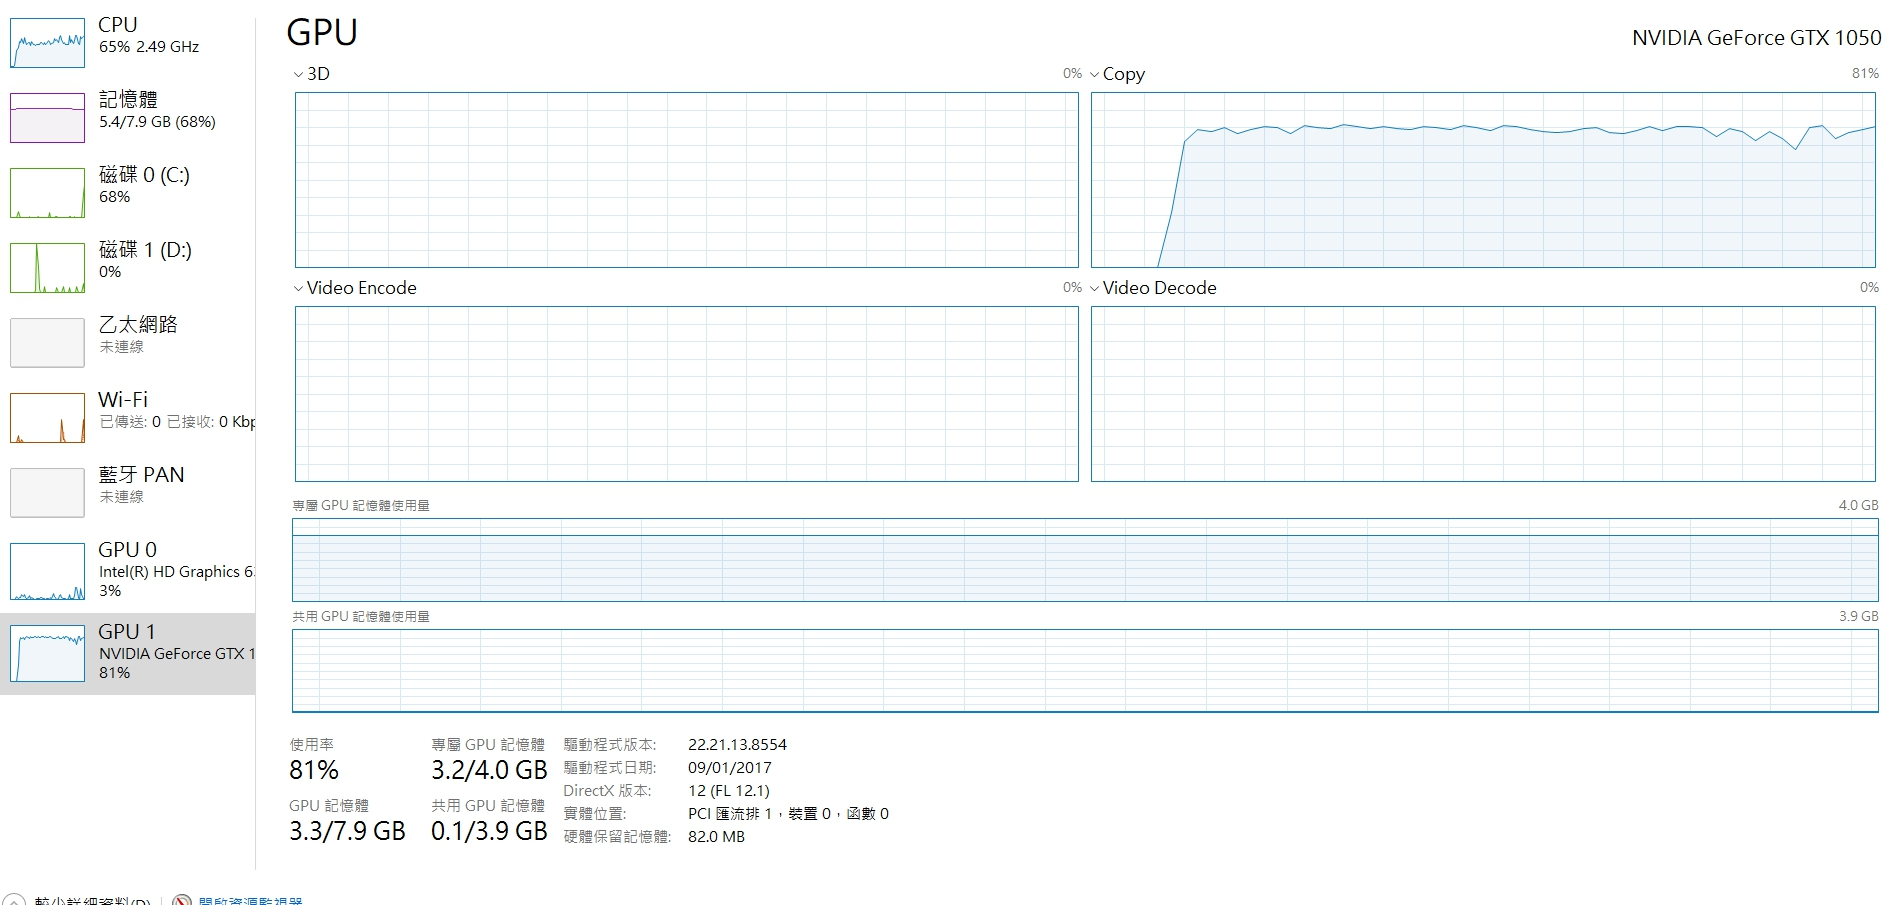

In [2]:
from IPython.display import Image
Image(filename = 'image/admin.jpg', width = 1000)

可以看到我們使用了80%的GPU以及65%CPU，成功的利用GPU進行運算。